In [ ]:
from functools import partial
from copy import deepcopy
import math
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(1234)

## Set Parameters

In [ ]:
tuple_size = 1
data_dim = 1
batch_size = 4
epochs = 500
learning_rate = 1e-3
total_dim = 48

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_sample_size = 60
test_sample_size = 10000
min_test_length = 5
max_test_length = 55
step_test_length = 5

# lengths = range(min_test_length, max_test_length, step_test_length)
lengths = [2, 4, 6, 8]

## Dataset Definition

In [ ]:
class NormalSum(Dataset):

    _repr_indent = 4

    def __init__(
            self,
            tuple_size: int,
            data_dim: int,
            sample_size: int = 10000,
            mean: torch.Tensor = None,
            covar: torch.Tensor = None,
            train: bool = True,
    ) -> None:
        super().__init__()
        self.tuple_size = tuple_size
        self.data_dim = data_dim
        self.sample_size = sample_size

        self.mean = torch.zeros(self.data_dim) if mean is None else mean
        self.covar = torch.eye(self.data_dim) if covar is None else covar
        self.distribution = MultivariateNormal(loc=self.mean, covariance_matrix=self.covar)
        self.data = self.distribution.sample((self.sample_size, self.tuple_size))

    def __len__(self):
        return self.sample_size

    def __getitem__(self, index):
        x = self.data[index]
        y = self.symmetric_expression(x)
        return x, y

    def symmetric_expression(self, x):
        """Symmetric Expression

        if x = [[x_1, y_1], [x_2, y_2], ..., [x_n, y_n] then
          return [\sum_{i=1}^n x_i, \sum_{i=1}^n y_i]
        """
        return x.sum(-2).sum(-1, keepdims=True)

    def __repr__(self):
        head = "Dataset " + self.__class__.__name__
        body = ["Sample Size: {}".format(self.__len__())]
        body.append("Tuple Size: {}".format(self.tuple_size))
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)

## Deepset Model

In [ ]:
class DeepSet(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
        )
        self.adder = partial(torch.sum, dim=1, keepdim=False)
        self.fc = nn.Linear(32, out_features)

    def forward(self, x):
        x = self.net(x)
        x = self.adder(x)
        x = self.fc(x)
        return x

## Train and evaluate function

In [ ]:
def train(model, criterion, dataloader, optimizer):
    model.train()
    losses = 0
    count = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        losses += loss.item() * x.size(0)
        count += x.size(0)
    return losses / count
    

def valid(model, criterion, dataloader):
    model.eval()
    losses = 0
    count = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            losses += loss.item() * x.size(0)
            count += x.size(0)
    return losses / count

def test(model, dataloader):
    model.eval()
    preds = []
    with torch.no_grad():
        preds = torch.cat([model(x.to(device)) for x, y in dataloader], 0)
    return preds


## Train DeepSet Model with `tuple_size`

In [ ]:
def train_deepset_with_tuplesize(tuple_size):
    trainset = NormalSum(tuple_size, total_dim//tuple_size, sample_size=train_sample_size)
    validset = NormalSum(tuple_size, total_dim//tuple_size, sample_size=2000)
    trainloader = DataLoader(trainset, batch_size=batch_size)
    validloader = DataLoader(validset, batch_size=batch_size)
    print(total_dim//tuple_size)
    model = DeepSet(total_dim//tuple_size, 1).to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-6)
    schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, eps=1e-100, verbose=True, patience=10, min_lr=0.)
    tqdm_bar = tqdm(range(epochs))
    for epoch in tqdm_bar:
        train_loss = train(model, criterion, trainloader, optimizer)
        valid_loss = valid(model, criterion, validloader)
        schedular.step(valid_loss)
        tqdm_bar.set_postfix(loss=train_loss, val_loss=valid_loss)

    return deepcopy(model.state_dict()), train_loss, valid_loss

In [ ]:
deep_wes_wes = [[train_deepset_with_tuplesize(ts) for ts in lengths] for j in range(5)]
torch.save(deep_wes_wes, "10trial.pth.tar")









  0%|          | 0/500 [00:00<?, ?it/s]

24










  0%|          | 0/500 [00:00<?, ?it/s, loss=6.34, val_loss=5.15]







  0%|          | 1/500 [00:00<01:41,  4.90it/s, loss=6.34, val_loss=5.15]







  0%|          | 1/500 [00:00<01:41,  4.90it/s, loss=5.3, val_loss=4.18] 







  0%|          | 2/500 [00:00<01:47,  4.63it/s, loss=5.3, val_loss=4.18]







  0%|          | 2/500 [00:00<01:47,  4.63it/s, loss=3.31, val_loss=2.29]







  1%|          | 3/500 [00:00<01:47,  4.61it/s, loss=3.31, val_loss=2.29]







  1%|          | 3/500 [00:00<01:47,  4.61it/s, loss=1.47, val_loss=1.38]







  1%|          | 4/500 [00:00<01:47,  4.63it/s, loss=1.47, val_loss=1.38]







  1%|          | 4/500 [00:01<01:47,  4.63it/s, loss=0.941, val_loss=0.79]







  1%|          | 5/500 [00:01<01:46,  4.66it/s, loss=0.941, val_loss=0.79]







  1%|          | 5/500 [00:01<01:46,  4.66it/s, loss=0.628, val_loss=0.604]







  1%|          | 6/500 [00:01<01:44,  4.72it/s, loss=0.628, val_loss=0.604]







  1%|          | 6/500 

Epoch    31: reducing learning rate of group 0 to 1.0000e-04.










  6%|▌         | 31/500 [00:06<01:43,  4.55it/s, loss=0.533, val_loss=0.282]







  6%|▋         | 32/500 [00:06<01:42,  4.58it/s, loss=0.533, val_loss=0.282]







  6%|▋         | 32/500 [00:07<01:42,  4.58it/s, loss=0.28, val_loss=0.207] 







  7%|▋         | 33/500 [00:07<01:40,  4.66it/s, loss=0.28, val_loss=0.207]







  7%|▋         | 33/500 [00:07<01:40,  4.66it/s, loss=0.144, val_loss=0.134]







  7%|▋         | 34/500 [00:07<01:40,  4.62it/s, loss=0.144, val_loss=0.134]







  7%|▋         | 34/500 [00:07<01:40,  4.62it/s, loss=0.0918, val_loss=0.0944]







  7%|▋         | 35/500 [00:07<01:42,  4.56it/s, loss=0.0918, val_loss=0.0944]







  7%|▋         | 35/500 [00:07<01:42,  4.56it/s, loss=0.0507, val_loss=0.0657]







  7%|▋         | 36/500 [00:07<01:41,  4.59it/s, loss=0.0507, val_loss=0.0657]







  7%|▋         | 36/500 [00:08<01:41,  4.59it/s, loss=0.0409, val_loss=0.0476]







  7%|▋         | 37/500 [00:08<01:39,  4.64it/s, loss=0.040

Epoch    50: reducing learning rate of group 0 to 1.0000e-05.










 10%|█         | 50/500 [00:11<01:36,  4.65it/s, loss=0.0395, val_loss=0.025] 







 10%|█         | 51/500 [00:11<01:37,  4.61it/s, loss=0.0395, val_loss=0.025]







 10%|█         | 51/500 [00:11<01:37,  4.61it/s, loss=0.0224, val_loss=0.0194]







 10%|█         | 52/500 [00:11<01:38,  4.56it/s, loss=0.0224, val_loss=0.0194]







 10%|█         | 52/500 [00:11<01:38,  4.56it/s, loss=0.0139, val_loss=0.0136]







 11%|█         | 53/500 [00:11<01:36,  4.63it/s, loss=0.0139, val_loss=0.0136]







 11%|█         | 53/500 [00:11<01:36,  4.63it/s, loss=0.00901, val_loss=0.00916]







 11%|█         | 54/500 [00:11<01:38,  4.51it/s, loss=0.00901, val_loss=0.00916]







 11%|█         | 54/500 [00:11<01:38,  4.51it/s, loss=0.0053, val_loss=0.00497] 







 11%|█         | 55/500 [00:11<01:38,  4.52it/s, loss=0.0053, val_loss=0.00497]







 11%|█         | 55/500 [00:12<01:38,  4.52it/s, loss=0.00296, val_loss=0.00368]







 11%|█         | 56/500 [00:12<01:36, 

Epoch    74: reducing learning rate of group 0 to 1.0000e-06.










 15%|█▍        | 74/500 [00:16<01:30,  4.69it/s, loss=0.00498, val_loss=0.00364]







 15%|█▌        | 75/500 [00:16<01:32,  4.60it/s, loss=0.00498, val_loss=0.00364]







 15%|█▌        | 75/500 [00:16<01:32,  4.60it/s, loss=0.00367, val_loss=0.00267]







 15%|█▌        | 76/500 [00:16<01:31,  4.61it/s, loss=0.00367, val_loss=0.00267]







 15%|█▌        | 76/500 [00:16<01:31,  4.61it/s, loss=0.00232, val_loss=0.00191]







 15%|█▌        | 77/500 [00:16<01:33,  4.54it/s, loss=0.00232, val_loss=0.00191]







 15%|█▌        | 77/500 [00:16<01:33,  4.54it/s, loss=0.00132, val_loss=0.00123]







 16%|█▌        | 78/500 [00:16<01:32,  4.59it/s, loss=0.00132, val_loss=0.00123]







 16%|█▌        | 78/500 [00:17<01:32,  4.59it/s, loss=0.000795, val_loss=0.000849]







 16%|█▌        | 79/500 [00:17<01:32,  4.57it/s, loss=0.000795, val_loss=0.000849]







 16%|█▌        | 79/500 [00:17<01:32,  4.57it/s, loss=0.000616, val_loss=0.000454]







 16%|█▌        | 8

Epoch    93: reducing learning rate of group 0 to 1.0000e-07.










 19%|█▊        | 93/500 [00:20<01:28,  4.58it/s, loss=0.000388, val_loss=0.000334]







 19%|█▉        | 94/500 [00:20<01:29,  4.55it/s, loss=0.000388, val_loss=0.000334]







 19%|█▉        | 94/500 [00:20<01:29,  4.55it/s, loss=0.000268, val_loss=0.000214]







 19%|█▉        | 95/500 [00:20<01:29,  4.53it/s, loss=0.000268, val_loss=0.000214]







 19%|█▉        | 95/500 [00:20<01:29,  4.53it/s, loss=0.000153, val_loss=0.000133]







 19%|█▉        | 96/500 [00:20<01:28,  4.54it/s, loss=0.000153, val_loss=0.000133]







 19%|█▉        | 96/500 [00:21<01:28,  4.54it/s, loss=8.89e-5, val_loss=9.13e-5]  







 19%|█▉        | 97/500 [00:21<01:27,  4.59it/s, loss=8.89e-5, val_loss=9.13e-5]







 19%|█▉        | 97/500 [00:21<01:27,  4.59it/s, loss=5.11e-5, val_loss=6.67e-5]







 20%|█▉        | 98/500 [00:21<01:27,  4.62it/s, loss=5.11e-5, val_loss=6.67e-5]







 20%|█▉        | 98/500 [00:21<01:27,  4.62it/s, loss=5.02e-5, val_loss=3.87e-5]







 20%|█▉   

Epoch   115: reducing learning rate of group 0 to 1.0000e-08.










 23%|██▎       | 115/500 [00:25<01:26,  4.46it/s, loss=5.69e-5, val_loss=3.61e-5]







 23%|██▎       | 116/500 [00:25<01:26,  4.46it/s, loss=5.69e-5, val_loss=3.61e-5]







 23%|██▎       | 116/500 [00:25<01:26,  4.46it/s, loss=3.39e-5, val_loss=2.82e-5]







 23%|██▎       | 117/500 [00:25<01:23,  4.57it/s, loss=3.39e-5, val_loss=2.82e-5]







 23%|██▎       | 117/500 [00:25<01:23,  4.57it/s, loss=1.96e-5, val_loss=2.26e-5]







 24%|██▎       | 118/500 [00:25<01:23,  4.58it/s, loss=1.96e-5, val_loss=2.26e-5]







 24%|██▎       | 118/500 [00:26<01:23,  4.58it/s, loss=1.34e-5, val_loss=1.88e-5]







 24%|██▍       | 119/500 [00:26<01:25,  4.48it/s, loss=1.34e-5, val_loss=1.88e-5]







 24%|██▍       | 119/500 [00:26<01:25,  4.48it/s, loss=8.55e-6, val_loss=1.54e-5]







 24%|██▍       | 120/500 [00:26<01:23,  4.54it/s, loss=8.55e-6, val_loss=1.54e-5]







 24%|██▍       | 120/500 [00:26<01:23,  4.54it/s, loss=7.33e-6, val_loss=1.22e-5]







 24%|██▍     

Epoch   140: reducing learning rate of group 0 to 1.0000e-09.










 28%|██▊       | 140/500 [00:30<01:22,  4.34it/s, loss=3.07e-6, val_loss=2.45e-6]







 28%|██▊       | 141/500 [00:30<01:22,  4.37it/s, loss=3.07e-6, val_loss=2.45e-6]







 28%|██▊       | 141/500 [00:31<01:22,  4.37it/s, loss=1.75e-6, val_loss=1.6e-6] 







 28%|██▊       | 142/500 [00:31<01:21,  4.41it/s, loss=1.75e-6, val_loss=1.6e-6]







 28%|██▊       | 142/500 [00:31<01:21,  4.41it/s, loss=1.05e-6, val_loss=1.14e-6]







 29%|██▊       | 143/500 [00:31<01:20,  4.45it/s, loss=1.05e-6, val_loss=1.14e-6]







 29%|██▊       | 143/500 [00:31<01:20,  4.45it/s, loss=7.3e-7, val_loss=7.76e-7] 







 29%|██▉       | 144/500 [00:31<01:21,  4.39it/s, loss=7.3e-7, val_loss=7.76e-7]







 29%|██▉       | 144/500 [00:31<01:21,  4.39it/s, loss=4.88e-7, val_loss=5.33e-7]







 29%|██▉       | 145/500 [00:31<01:21,  4.38it/s, loss=4.88e-7, val_loss=5.33e-7]







 29%|██▉       | 145/500 [00:32<01:21,  4.38it/s, loss=5.51e-7, val_loss=3.52e-7]







 29%|██▉       

Epoch   158: reducing learning rate of group 0 to 1.0000e-10.










 32%|███▏      | 158/500 [00:34<01:14,  4.59it/s, loss=3.63e-7, val_loss=2.73e-7]







 32%|███▏      | 159/500 [00:34<01:16,  4.48it/s, loss=3.63e-7, val_loss=2.73e-7]







 32%|███▏      | 159/500 [00:35<01:16,  4.48it/s, loss=2.39e-7, val_loss=2.06e-7]







 32%|███▏      | 160/500 [00:35<01:16,  4.44it/s, loss=2.39e-7, val_loss=2.06e-7]







 32%|███▏      | 160/500 [00:35<01:16,  4.44it/s, loss=1.4e-7, val_loss=1.48e-7] 







 32%|███▏      | 161/500 [00:35<01:15,  4.46it/s, loss=1.4e-7, val_loss=1.48e-7]







 32%|███▏      | 161/500 [00:35<01:15,  4.46it/s, loss=9.07e-8, val_loss=9.75e-8]







 32%|███▏      | 162/500 [00:35<01:16,  4.42it/s, loss=9.07e-8, val_loss=9.75e-8]







 32%|███▏      | 162/500 [00:35<01:16,  4.42it/s, loss=5.57e-8, val_loss=6.56e-8]







 33%|███▎      | 163/500 [00:35<01:16,  4.43it/s, loss=5.57e-8, val_loss=6.56e-8]







 33%|███▎      | 163/500 [00:36<01:16,  4.43it/s, loss=5.34e-8, val_loss=4.88e-8]







 33%|███▎     

Epoch   187: reducing learning rate of group 0 to 1.0000e-11.










 37%|███▋      | 187/500 [00:41<01:09,  4.49it/s, loss=4.77e-8, val_loss=3.16e-8]







 38%|███▊      | 188/500 [00:41<01:09,  4.48it/s, loss=4.77e-8, val_loss=3.16e-8]







 38%|███▊      | 188/500 [00:41<01:09,  4.48it/s, loss=3.14e-8, val_loss=2.16e-8]







 38%|███▊      | 189/500 [00:41<01:10,  4.43it/s, loss=3.14e-8, val_loss=2.16e-8]







 38%|███▊      | 189/500 [00:42<01:10,  4.43it/s, loss=1.56e-8, val_loss=1.36e-8]







 38%|███▊      | 190/500 [00:42<01:09,  4.45it/s, loss=1.56e-8, val_loss=1.36e-8]







 38%|███▊      | 190/500 [00:42<01:09,  4.45it/s, loss=1.06e-8, val_loss=8.24e-9]







 38%|███▊      | 191/500 [00:42<01:09,  4.44it/s, loss=1.06e-8, val_loss=8.24e-9]







 38%|███▊      | 191/500 [00:42<01:09,  4.44it/s, loss=5.19e-9, val_loss=4.48e-9]







 38%|███▊      | 192/500 [00:42<01:09,  4.42it/s, loss=5.19e-9, val_loss=4.48e-9]







 38%|███▊      | 192/500 [00:42<01:09,  4.42it/s, loss=4.67e-9, val_loss=4.65e-9]







 39%|███▊    

Epoch   209: reducing learning rate of group 0 to 1.0000e-12.










 42%|████▏     | 209/500 [00:46<01:05,  4.44it/s, loss=3.8e-9, val_loss=2.87e-9] 







 42%|████▏     | 210/500 [00:46<01:05,  4.44it/s, loss=3.8e-9, val_loss=2.87e-9]







 42%|████▏     | 210/500 [00:46<01:05,  4.44it/s, loss=2.38e-9, val_loss=1.91e-9]







 42%|████▏     | 211/500 [00:46<01:05,  4.40it/s, loss=2.38e-9, val_loss=1.91e-9]







 42%|████▏     | 211/500 [00:47<01:05,  4.40it/s, loss=1.49e-9, val_loss=1.23e-9]







 42%|████▏     | 212/500 [00:47<01:04,  4.43it/s, loss=1.49e-9, val_loss=1.23e-9]







 42%|████▏     | 212/500 [00:47<01:04,  4.43it/s, loss=8.38e-10, val_loss=6.31e-10]







 43%|████▎     | 213/500 [00:47<01:05,  4.38it/s, loss=8.38e-10, val_loss=6.31e-10]







 43%|████▎     | 213/500 [00:47<01:05,  4.38it/s, loss=4.95e-10, val_loss=3.98e-10]







 43%|████▎     | 214/500 [00:47<01:04,  4.40it/s, loss=4.95e-10, val_loss=3.98e-10]







 43%|████▎     | 214/500 [00:47<01:04,  4.40it/s, loss=3.67e-10, val_loss=4.14e-10]







 43%

Epoch   227: reducing learning rate of group 0 to 1.0000e-13.










 45%|████▌     | 227/500 [00:50<01:02,  4.36it/s, loss=5.83e-10, val_loss=4.04e-10]







 46%|████▌     | 228/500 [00:50<01:03,  4.31it/s, loss=5.83e-10, val_loss=4.04e-10]







 46%|████▌     | 228/500 [00:50<01:03,  4.31it/s, loss=3.47e-10, val_loss=2.5e-10] 







 46%|████▌     | 229/500 [00:50<01:02,  4.32it/s, loss=3.47e-10, val_loss=2.5e-10]







 46%|████▌     | 229/500 [00:51<01:02,  4.32it/s, loss=1.8e-10, val_loss=1.7e-10] 







 46%|████▌     | 230/500 [00:51<01:01,  4.36it/s, loss=1.8e-10, val_loss=1.7e-10]







 46%|████▌     | 230/500 [00:51<01:01,  4.36it/s, loss=1.13e-10, val_loss=1.25e-10]







 46%|████▌     | 231/500 [00:51<01:02,  4.30it/s, loss=1.13e-10, val_loss=1.25e-10]







 46%|████▌     | 231/500 [00:51<01:02,  4.30it/s, loss=7.84e-11, val_loss=9.45e-11]







 46%|████▋     | 232/500 [00:51<01:01,  4.36it/s, loss=7.84e-11, val_loss=9.45e-11]







 46%|████▋     | 232/500 [00:51<01:01,  4.36it/s, loss=5.2e-11, val_loss=6.48e-11] 




Epoch   266: reducing learning rate of group 0 to 1.0000e-14.










 53%|█████▎    | 266/500 [00:59<00:53,  4.35it/s, loss=4.53e-11, val_loss=3.56e-11]







 53%|█████▎    | 267/500 [00:59<00:55,  4.20it/s, loss=4.53e-11, val_loss=3.56e-11]







 53%|█████▎    | 267/500 [00:59<00:55,  4.20it/s, loss=3.08e-11, val_loss=2.38e-11]







 54%|█████▎    | 268/500 [00:59<00:54,  4.22it/s, loss=3.08e-11, val_loss=2.38e-11]







 54%|█████▎    | 268/500 [01:00<00:54,  4.22it/s, loss=1.69e-11, val_loss=1.57e-11]







 54%|█████▍    | 269/500 [01:00<00:53,  4.36it/s, loss=1.69e-11, val_loss=1.57e-11]







 54%|█████▍    | 269/500 [01:00<00:53,  4.36it/s, loss=1.06e-11, val_loss=1.18e-11]







 54%|█████▍    | 270/500 [01:00<00:52,  4.40it/s, loss=1.06e-11, val_loss=1.18e-11]







 54%|█████▍    | 270/500 [01:00<00:52,  4.40it/s, loss=6.98e-12, val_loss=7.98e-12]







 54%|█████▍    | 271/500 [01:00<00:53,  4.30it/s, loss=6.98e-12, val_loss=7.98e-12]







 54%|█████▍    | 271/500 [01:00<00:53,  4.30it/s, loss=4.99e-12, val_loss=5.08e-12

Epoch   285: reducing learning rate of group 0 to 1.0000e-15.










 57%|█████▋    | 285/500 [01:04<00:49,  4.32it/s, loss=5.62e-12, val_loss=3.18e-12]







 57%|█████▋    | 286/500 [01:04<00:49,  4.34it/s, loss=5.62e-12, val_loss=3.18e-12]







 57%|█████▋    | 286/500 [01:04<00:49,  4.34it/s, loss=2.81e-12, val_loss=2.25e-12]







 57%|█████▋    | 287/500 [01:04<00:49,  4.31it/s, loss=2.81e-12, val_loss=2.25e-12]







 57%|█████▋    | 287/500 [01:04<00:49,  4.31it/s, loss=1.78e-12, val_loss=1.42e-12]







 58%|█████▊    | 288/500 [01:04<00:49,  4.32it/s, loss=1.78e-12, val_loss=1.42e-12]







 58%|█████▊    | 288/500 [01:04<00:49,  4.32it/s, loss=9.78e-13, val_loss=1.03e-12]







 58%|█████▊    | 289/500 [01:04<00:49,  4.27it/s, loss=9.78e-13, val_loss=1.03e-12]







 58%|█████▊    | 289/500 [01:04<00:49,  4.27it/s, loss=6.74e-13, val_loss=8.27e-13]







 58%|█████▊    | 290/500 [01:04<00:48,  4.35it/s, loss=6.74e-13, val_loss=8.27e-13]







 58%|█████▊    | 290/500 [01:05<00:48,  4.35it/s, loss=5.31e-13, val_loss=4.85e-13

Epoch   307: reducing learning rate of group 0 to 1.0000e-16.










 61%|██████▏   | 307/500 [01:09<00:46,  4.18it/s, loss=5.52e-13, val_loss=3.12e-13]







 62%|██████▏   | 308/500 [01:09<00:45,  4.23it/s, loss=5.52e-13, val_loss=3.12e-13]







 62%|██████▏   | 308/500 [01:09<00:45,  4.23it/s, loss=2.66e-13, val_loss=2.08e-13]







 62%|██████▏   | 309/500 [01:09<00:44,  4.32it/s, loss=2.66e-13, val_loss=2.08e-13]







 62%|██████▏   | 309/500 [01:09<00:44,  4.32it/s, loss=1.74e-13, val_loss=1.45e-13]







 62%|██████▏   | 310/500 [01:09<00:43,  4.35it/s, loss=1.74e-13, val_loss=1.45e-13]







 62%|██████▏   | 310/500 [01:09<00:43,  4.35it/s, loss=9.97e-14, val_loss=9.92e-14]







 62%|██████▏   | 311/500 [01:09<00:44,  4.27it/s, loss=9.97e-14, val_loss=9.92e-14]







 62%|██████▏   | 311/500 [01:10<00:44,  4.27it/s, loss=6.56e-14, val_loss=6.48e-14]







 62%|██████▏   | 312/500 [01:10<00:43,  4.32it/s, loss=6.56e-14, val_loss=6.48e-14]







 62%|██████▏   | 312/500 [01:10<00:43,  4.32it/s, loss=4.88e-14, val_loss=3.95e-14

Epoch   347: reducing learning rate of group 0 to 1.0000e-17.










 69%|██████▉   | 347/500 [01:18<00:35,  4.36it/s, loss=4.13e-14, val_loss=3.12e-14]







 70%|██████▉   | 348/500 [01:18<00:35,  4.28it/s, loss=4.13e-14, val_loss=3.12e-14]







 70%|██████▉   | 348/500 [01:18<00:35,  4.28it/s, loss=2.9e-14, val_loss=2.13e-14] 







 70%|██████▉   | 349/500 [01:18<00:35,  4.26it/s, loss=2.9e-14, val_loss=2.13e-14]







 70%|██████▉   | 349/500 [01:18<00:35,  4.26it/s, loss=1.88e-14, val_loss=1.53e-14]







 70%|███████   | 350/500 [01:18<00:34,  4.32it/s, loss=1.88e-14, val_loss=1.53e-14]







 70%|███████   | 350/500 [01:19<00:34,  4.32it/s, loss=1.24e-14, val_loss=1.15e-14]







 70%|███████   | 351/500 [01:19<00:34,  4.37it/s, loss=1.24e-14, val_loss=1.15e-14]







 70%|███████   | 351/500 [01:19<00:34,  4.37it/s, loss=8.11e-15, val_loss=9.43e-15]







 70%|███████   | 352/500 [01:19<00:34,  4.34it/s, loss=8.11e-15, val_loss=9.43e-15]







 70%|███████   | 352/500 [01:19<00:34,  4.34it/s, loss=5.59e-15, val_loss=7.96e-15]

Epoch   372: reducing learning rate of group 0 to 1.0000e-18.










 74%|███████▍  | 372/500 [01:24<00:29,  4.36it/s, loss=1.95e-15, val_loss=1.99e-15]







 75%|███████▍  | 373/500 [01:24<00:29,  4.24it/s, loss=1.95e-15, val_loss=1.99e-15]







 75%|███████▍  | 373/500 [01:24<00:29,  4.24it/s, loss=1.71e-15, val_loss=1.94e-15]







 75%|███████▍  | 374/500 [01:24<00:29,  4.25it/s, loss=1.71e-15, val_loss=1.94e-15]







 75%|███████▍  | 374/500 [01:24<00:29,  4.25it/s, loss=1.62e-15, val_loss=1.85e-15]







 75%|███████▌  | 375/500 [01:24<00:29,  4.21it/s, loss=1.62e-15, val_loss=1.85e-15]







 75%|███████▌  | 375/500 [01:24<00:29,  4.21it/s, loss=1.54e-15, val_loss=1.81e-15]







 75%|███████▌  | 376/500 [01:24<00:29,  4.27it/s, loss=1.54e-15, val_loss=1.81e-15]







 75%|███████▌  | 376/500 [01:25<00:29,  4.27it/s, loss=1.54e-15, val_loss=1.74e-15]







 75%|███████▌  | 377/500 [01:25<00:29,  4.22it/s, loss=1.54e-15, val_loss=1.74e-15]







 75%|███████▌  | 377/500 [01:25<00:29,  4.22it/s, loss=1.52e-15, val_loss=1.71e-15

Epoch   383: reducing learning rate of group 0 to 1.0000e-19.










 77%|███████▋  | 383/500 [01:26<00:28,  4.17it/s, loss=1.24e-15, val_loss=1.54e-15]







 77%|███████▋  | 384/500 [01:26<00:27,  4.18it/s, loss=1.24e-15, val_loss=1.54e-15]







 77%|███████▋  | 384/500 [01:27<00:27,  4.18it/s, loss=1.24e-15, val_loss=1.54e-15]







 77%|███████▋  | 385/500 [01:27<00:27,  4.13it/s, loss=1.24e-15, val_loss=1.54e-15]







 77%|███████▋  | 385/500 [01:27<00:27,  4.13it/s, loss=1.22e-15, val_loss=1.54e-15]







 77%|███████▋  | 386/500 [01:27<00:26,  4.23it/s, loss=1.22e-15, val_loss=1.54e-15]







 77%|███████▋  | 386/500 [01:27<00:26,  4.23it/s, loss=1.21e-15, val_loss=1.54e-15]







 77%|███████▋  | 387/500 [01:27<00:26,  4.27it/s, loss=1.21e-15, val_loss=1.54e-15]







 77%|███████▋  | 387/500 [01:27<00:26,  4.27it/s, loss=1.21e-15, val_loss=1.54e-15]







 78%|███████▊  | 388/500 [01:27<00:25,  4.31it/s, loss=1.21e-15, val_loss=1.54e-15]







 78%|███████▊  | 388/500 [01:28<00:25,  4.31it/s, loss=1.18e-15, val_loss=1.54e-15

Epoch   394: reducing learning rate of group 0 to 1.0000e-20.










 79%|███████▉  | 394/500 [01:29<00:25,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 79%|███████▉  | 395/500 [01:29<00:24,  4.26it/s, loss=1.22e-15, val_loss=1.54e-15]







 79%|███████▉  | 395/500 [01:29<00:24,  4.26it/s, loss=1.22e-15, val_loss=1.54e-15]







 79%|███████▉  | 396/500 [01:29<00:24,  4.31it/s, loss=1.22e-15, val_loss=1.54e-15]







 79%|███████▉  | 396/500 [01:29<00:24,  4.31it/s, loss=1.22e-15, val_loss=1.54e-15]







 79%|███████▉  | 397/500 [01:29<00:23,  4.36it/s, loss=1.22e-15, val_loss=1.54e-15]







 79%|███████▉  | 397/500 [01:30<00:23,  4.36it/s, loss=1.22e-15, val_loss=1.54e-15]







 80%|███████▉  | 398/500 [01:30<00:23,  4.27it/s, loss=1.22e-15, val_loss=1.54e-15]







 80%|███████▉  | 398/500 [01:30<00:23,  4.27it/s, loss=1.22e-15, val_loss=1.54e-15]







 80%|███████▉  | 399/500 [01:30<00:23,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15]







 80%|███████▉  | 399/500 [01:30<00:23,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   405: reducing learning rate of group 0 to 1.0000e-21.










 81%|████████  | 405/500 [01:31<00:21,  4.35it/s, loss=1.22e-15, val_loss=1.54e-15]







 81%|████████  | 406/500 [01:31<00:22,  4.27it/s, loss=1.22e-15, val_loss=1.54e-15]







 81%|████████  | 406/500 [01:32<00:22,  4.27it/s, loss=1.22e-15, val_loss=1.54e-15]







 81%|████████▏ | 407/500 [01:32<00:22,  4.18it/s, loss=1.22e-15, val_loss=1.54e-15]







 81%|████████▏ | 407/500 [01:32<00:22,  4.18it/s, loss=1.22e-15, val_loss=1.54e-15]







 82%|████████▏ | 408/500 [01:32<00:22,  4.11it/s, loss=1.22e-15, val_loss=1.54e-15]







 82%|████████▏ | 408/500 [01:32<00:22,  4.11it/s, loss=1.22e-15, val_loss=1.54e-15]







 82%|████████▏ | 409/500 [01:32<00:22,  4.12it/s, loss=1.22e-15, val_loss=1.54e-15]







 82%|████████▏ | 409/500 [01:32<00:22,  4.12it/s, loss=1.22e-15, val_loss=1.54e-15]







 82%|████████▏ | 410/500 [01:32<00:21,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 82%|████████▏ | 410/500 [01:33<00:21,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   416: reducing learning rate of group 0 to 1.0000e-22.










 83%|████████▎ | 416/500 [01:34<00:19,  4.33it/s, loss=1.22e-15, val_loss=1.54e-15]







 83%|████████▎ | 417/500 [01:34<00:19,  4.24it/s, loss=1.22e-15, val_loss=1.54e-15]







 83%|████████▎ | 417/500 [01:34<00:19,  4.24it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▎ | 418/500 [01:34<00:19,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▎ | 418/500 [01:35<00:19,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▍ | 419/500 [01:35<00:19,  4.15it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▍ | 419/500 [01:35<00:19,  4.15it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▍ | 420/500 [01:35<00:19,  4.12it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▍ | 420/500 [01:35<00:19,  4.12it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▍ | 421/500 [01:35<00:18,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 84%|████████▍ | 421/500 [01:35<00:18,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   427: reducing learning rate of group 0 to 1.0000e-23.










 85%|████████▌ | 427/500 [01:37<00:17,  4.15it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 428/500 [01:37<00:17,  4.07it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 428/500 [01:37<00:17,  4.07it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 429/500 [01:37<00:17,  4.10it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 429/500 [01:37<00:17,  4.10it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 430/500 [01:37<00:16,  4.19it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 430/500 [01:37<00:16,  4.19it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 431/500 [01:37<00:16,  4.26it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▌ | 431/500 [01:38<00:16,  4.26it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▋ | 432/500 [01:38<00:16,  4.15it/s, loss=1.22e-15, val_loss=1.54e-15]







 86%|████████▋ | 432/500 [01:38<00:16,  4.15it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   438: reducing learning rate of group 0 to 1.0000e-24.










 88%|████████▊ | 438/500 [01:39<00:14,  4.25it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 439/500 [01:39<00:14,  4.26it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 439/500 [01:40<00:14,  4.26it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 440/500 [01:40<00:14,  4.27it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 440/500 [01:40<00:14,  4.27it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 441/500 [01:40<00:14,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 441/500 [01:40<00:14,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 442/500 [01:40<00:13,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 88%|████████▊ | 442/500 [01:40<00:13,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 89%|████████▊ | 443/500 [01:40<00:13,  4.32it/s, loss=1.22e-15, val_loss=1.54e-15]







 89%|████████▊ | 443/500 [01:41<00:13,  4.32it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   449: reducing learning rate of group 0 to 1.0000e-25.










 90%|████████▉ | 449/500 [01:42<00:12,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 90%|█████████ | 450/500 [01:42<00:12,  4.14it/s, loss=1.22e-15, val_loss=1.54e-15]







 90%|█████████ | 450/500 [01:42<00:12,  4.14it/s, loss=1.22e-15, val_loss=1.54e-15]







 90%|█████████ | 451/500 [01:42<00:11,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 90%|█████████ | 451/500 [01:42<00:11,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 90%|█████████ | 452/500 [01:42<00:11,  4.18it/s, loss=1.22e-15, val_loss=1.54e-15]







 90%|█████████ | 452/500 [01:43<00:11,  4.18it/s, loss=1.22e-15, val_loss=1.54e-15]







 91%|█████████ | 453/500 [01:43<00:11,  4.23it/s, loss=1.22e-15, val_loss=1.54e-15]







 91%|█████████ | 453/500 [01:43<00:11,  4.23it/s, loss=1.22e-15, val_loss=1.54e-15]







 91%|█████████ | 454/500 [01:43<00:10,  4.24it/s, loss=1.22e-15, val_loss=1.54e-15]







 91%|█████████ | 454/500 [01:43<00:10,  4.24it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   460: reducing learning rate of group 0 to 1.0000e-26.










 92%|█████████▏| 460/500 [01:45<00:09,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15]







 92%|█████████▏| 461/500 [01:45<00:09,  4.31it/s, loss=1.22e-15, val_loss=1.54e-15]







 92%|█████████▏| 461/500 [01:45<00:09,  4.31it/s, loss=1.22e-15, val_loss=1.54e-15]







 92%|█████████▏| 462/500 [01:45<00:08,  4.24it/s, loss=1.22e-15, val_loss=1.54e-15]







 92%|█████████▏| 462/500 [01:45<00:08,  4.24it/s, loss=1.22e-15, val_loss=1.54e-15]







 93%|█████████▎| 463/500 [01:45<00:08,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15]







 93%|█████████▎| 463/500 [01:45<00:08,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15]







 93%|█████████▎| 464/500 [01:45<00:08,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15]







 93%|█████████▎| 464/500 [01:45<00:08,  4.28it/s, loss=1.22e-15, val_loss=1.54e-15]







 93%|█████████▎| 465/500 [01:46<00:08,  4.29it/s, loss=1.22e-15, val_loss=1.54e-15]







 93%|█████████▎| 465/500 [01:46<00:08,  4.29it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   471: reducing learning rate of group 0 to 1.0000e-27.










 94%|█████████▍| 471/500 [01:47<00:07,  4.13it/s, loss=1.22e-15, val_loss=1.54e-15]







 94%|█████████▍| 472/500 [01:47<00:06,  4.07it/s, loss=1.22e-15, val_loss=1.54e-15]







 94%|█████████▍| 472/500 [01:47<00:06,  4.07it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▍| 473/500 [01:47<00:06,  4.13it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▍| 473/500 [01:48<00:06,  4.13it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▍| 474/500 [01:48<00:06,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▍| 474/500 [01:48<00:06,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▌| 475/500 [01:48<00:05,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▌| 475/500 [01:48<00:05,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▌| 476/500 [01:48<00:05,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15]







 95%|█████████▌| 476/500 [01:48<00:05,  4.21it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   482: reducing learning rate of group 0 to 1.0000e-28.










 96%|█████████▋| 482/500 [01:50<00:04,  4.29it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 483/500 [01:50<00:04,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 483/500 [01:50<00:04,  4.22it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 484/500 [01:50<00:03,  4.16it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 484/500 [01:50<00:03,  4.16it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 485/500 [01:50<00:03,  4.08it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 485/500 [01:50<00:03,  4.08it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 486/500 [01:50<00:03,  4.23it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 486/500 [01:51<00:03,  4.23it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 487/500 [01:51<00:03,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 97%|█████████▋| 487/500 [01:51<00:03,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15

Epoch   493: reducing learning rate of group 0 to 1.0000e-29.










 99%|█████████▊| 493/500 [01:52<00:01,  4.15it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 494/500 [01:52<00:01,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 494/500 [01:53<00:01,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 495/500 [01:53<00:01,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 495/500 [01:53<00:01,  4.17it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 496/500 [01:53<00:00,  4.18it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 496/500 [01:53<00:00,  4.18it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 497/500 [01:53<00:00,  4.12it/s, loss=1.22e-15, val_loss=1.54e-15]







 99%|█████████▉| 497/500 [01:53<00:00,  4.12it/s, loss=1.22e-15, val_loss=1.54e-15]







100%|█████████▉| 498/500 [01:53<00:00,  4.19it/s, loss=1.22e-15, val_loss=1.54e-15]







100%|█████████▉| 498/500 [01:54<00:00,  4.19it/s, loss=1.22e-15, val_loss=1.54e-15

12










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.4, val_loss=4.89]







  0%|          | 1/500 [00:00<02:08,  3.88it/s, loss=5.4, val_loss=4.89]







  0%|          | 1/500 [00:00<02:08,  3.88it/s, loss=4.11, val_loss=3.6]







  0%|          | 2/500 [00:00<02:02,  4.06it/s, loss=4.11, val_loss=3.6]







  0%|          | 2/500 [00:00<02:02,  4.06it/s, loss=2.11, val_loss=1.31]







  1%|          | 3/500 [00:00<02:01,  4.08it/s, loss=2.11, val_loss=1.31]







  1%|          | 3/500 [00:00<02:01,  4.08it/s, loss=0.69, val_loss=0.445]







  1%|          | 4/500 [00:00<02:01,  4.08it/s, loss=0.69, val_loss=0.445]







  1%|          | 4/500 [00:01<02:01,  4.08it/s, loss=0.552, val_loss=0.534]







  1%|          | 5/500 [00:01<02:00,  4.11it/s, loss=0.552, val_loss=0.534]







  1%|          | 5/500 [00:01<02:00,  4.11it/s, loss=0.493, val_loss=0.682]







  1%|          | 6/500 [00:01<02:00,  4.11it/s, loss=0.493, val_loss=0.682]







  1%|          | 6/500

Epoch    31: reducing learning rate of group 0 to 1.0000e-04.










  6%|▌         | 31/500 [00:07<01:52,  4.16it/s, loss=0.442, val_loss=0.344]







  6%|▋         | 32/500 [00:07<01:52,  4.16it/s, loss=0.442, val_loss=0.344]







  6%|▋         | 32/500 [00:07<01:52,  4.16it/s, loss=0.214, val_loss=0.147]







  7%|▋         | 33/500 [00:07<01:54,  4.08it/s, loss=0.214, val_loss=0.147]







  7%|▋         | 33/500 [00:08<01:54,  4.08it/s, loss=0.112, val_loss=0.0781]







  7%|▋         | 34/500 [00:08<01:52,  4.15it/s, loss=0.112, val_loss=0.0781]







  7%|▋         | 34/500 [00:08<01:52,  4.15it/s, loss=0.0461, val_loss=0.0259]







  7%|▋         | 35/500 [00:08<01:51,  4.18it/s, loss=0.0461, val_loss=0.0259]







  7%|▋         | 35/500 [00:08<01:51,  4.18it/s, loss=0.0372, val_loss=0.0548]







  7%|▋         | 36/500 [00:08<01:50,  4.20it/s, loss=0.0372, val_loss=0.0548]







  7%|▋         | 36/500 [00:08<01:50,  4.20it/s, loss=0.0528, val_loss=0.0477]







  7%|▋         | 37/500 [00:08<01:49,  4.22it/s, loss=0.

Epoch    53: reducing learning rate of group 0 to 1.0000e-05.










 11%|█         | 53/500 [00:12<01:48,  4.13it/s, loss=0.0526, val_loss=0.03]  







 11%|█         | 54/500 [00:12<01:45,  4.23it/s, loss=0.0526, val_loss=0.03]







 11%|█         | 54/500 [00:13<01:45,  4.23it/s, loss=0.0233, val_loss=0.016]







 11%|█         | 55/500 [00:13<01:44,  4.27it/s, loss=0.0233, val_loss=0.016]







 11%|█         | 55/500 [00:13<01:44,  4.27it/s, loss=0.0106, val_loss=0.00795]







 11%|█         | 56/500 [00:13<01:45,  4.20it/s, loss=0.0106, val_loss=0.00795]







 11%|█         | 56/500 [00:13<01:45,  4.20it/s, loss=0.00505, val_loss=0.00284]







 11%|█▏        | 57/500 [00:13<01:44,  4.22it/s, loss=0.00505, val_loss=0.00284]







 11%|█▏        | 57/500 [00:13<01:44,  4.22it/s, loss=0.00238, val_loss=0.00226]







 12%|█▏        | 58/500 [00:13<01:45,  4.17it/s, loss=0.00238, val_loss=0.00226]







 12%|█▏        | 58/500 [00:14<01:45,  4.17it/s, loss=0.00272, val_loss=0.00272]







 12%|█▏        | 59/500 [00:14<01:45, 

Epoch    69: reducing learning rate of group 0 to 1.0000e-06.










 14%|█▍        | 69/500 [00:16<01:41,  4.24it/s, loss=0.00395, val_loss=0.00286]







 14%|█▍        | 70/500 [00:16<01:42,  4.21it/s, loss=0.00395, val_loss=0.00286]







 14%|█▍        | 70/500 [00:16<01:42,  4.21it/s, loss=0.0023, val_loss=0.00154] 







 14%|█▍        | 71/500 [00:16<01:41,  4.22it/s, loss=0.0023, val_loss=0.00154]







 14%|█▍        | 71/500 [00:17<01:41,  4.22it/s, loss=0.00115, val_loss=0.000745]







 14%|█▍        | 72/500 [00:17<01:40,  4.25it/s, loss=0.00115, val_loss=0.000745]







 14%|█▍        | 72/500 [00:17<01:40,  4.25it/s, loss=0.000465, val_loss=0.000286]







 15%|█▍        | 73/500 [00:17<01:40,  4.23it/s, loss=0.000465, val_loss=0.000286]







 15%|█▍        | 73/500 [00:17<01:40,  4.23it/s, loss=0.000321, val_loss=0.000341]







 15%|█▍        | 74/500 [00:17<01:39,  4.29it/s, loss=0.000321, val_loss=0.000341]







 15%|█▍        | 74/500 [00:17<01:39,  4.29it/s, loss=0.000367, val_loss=0.000231]







 15%|█▌      

Epoch    92: reducing learning rate of group 0 to 1.0000e-07.










 18%|█▊        | 92/500 [00:22<01:38,  4.13it/s, loss=0.000436, val_loss=0.0003]  







 19%|█▊        | 93/500 [00:22<01:40,  4.04it/s, loss=0.000436, val_loss=0.0003]







 19%|█▊        | 93/500 [00:22<01:40,  4.04it/s, loss=0.000255, val_loss=0.000204]







 19%|█▉        | 94/500 [00:22<01:41,  4.01it/s, loss=0.000255, val_loss=0.000204]







 19%|█▉        | 94/500 [00:22<01:41,  4.01it/s, loss=0.000133, val_loss=0.000104]







 19%|█▉        | 95/500 [00:22<01:39,  4.07it/s, loss=0.000133, val_loss=0.000104]







 19%|█▉        | 95/500 [00:22<01:39,  4.07it/s, loss=6.65e-5, val_loss=5.06e-5]  







 19%|█▉        | 96/500 [00:22<01:37,  4.15it/s, loss=6.65e-5, val_loss=5.06e-5]







 19%|█▉        | 96/500 [00:23<01:37,  4.15it/s, loss=4.74e-5, val_loss=4.13e-5]







 19%|█▉        | 97/500 [00:23<01:35,  4.21it/s, loss=4.74e-5, val_loss=4.13e-5]







 19%|█▉        | 97/500 [00:23<01:35,  4.21it/s, loss=5.97e-5, val_loss=6.67e-5]







 20%|█▉     

Epoch   119: reducing learning rate of group 0 to 1.0000e-08.










 24%|██▍       | 119/500 [00:28<01:30,  4.23it/s, loss=2.58e-5, val_loss=1.69e-5]







 24%|██▍       | 120/500 [00:28<01:31,  4.16it/s, loss=2.58e-5, val_loss=1.69e-5]







 24%|██▍       | 120/500 [00:28<01:31,  4.16it/s, loss=1.24e-5, val_loss=1.07e-5]







 24%|██▍       | 121/500 [00:28<01:30,  4.18it/s, loss=1.24e-5, val_loss=1.07e-5]







 24%|██▍       | 121/500 [00:29<01:30,  4.18it/s, loss=6.87e-6, val_loss=4.25e-6]







 24%|██▍       | 122/500 [00:29<01:31,  4.14it/s, loss=6.87e-6, val_loss=4.25e-6]







 24%|██▍       | 122/500 [00:29<01:31,  4.14it/s, loss=4.11e-6, val_loss=3.37e-6]







 25%|██▍       | 123/500 [00:29<01:31,  4.13it/s, loss=4.11e-6, val_loss=3.37e-6]







 25%|██▍       | 123/500 [00:29<01:31,  4.13it/s, loss=3.05e-6, val_loss=2.62e-6]







 25%|██▍       | 124/500 [00:29<01:29,  4.18it/s, loss=3.05e-6, val_loss=2.62e-6]







 25%|██▍       | 124/500 [00:29<01:29,  4.18it/s, loss=2.9e-6, val_loss=3.93e-6] 







 25%|██▌     

Epoch   149: reducing learning rate of group 0 to 1.0000e-09.










 30%|██▉       | 149/500 [00:35<01:24,  4.18it/s, loss=2.04e-6, val_loss=1.41e-6]







 30%|███       | 150/500 [00:35<01:26,  4.06it/s, loss=2.04e-6, val_loss=1.41e-6]







 30%|███       | 150/500 [00:36<01:26,  4.06it/s, loss=1.09e-6, val_loss=5.26e-7]







 30%|███       | 151/500 [00:36<01:24,  4.12it/s, loss=1.09e-6, val_loss=5.26e-7]







 30%|███       | 151/500 [00:36<01:24,  4.12it/s, loss=4.11e-7, val_loss=3.03e-7]







 30%|███       | 152/500 [00:36<01:23,  4.16it/s, loss=4.11e-7, val_loss=3.03e-7]







 30%|███       | 152/500 [00:36<01:23,  4.16it/s, loss=4.61e-7, val_loss=5.58e-7]







 31%|███       | 153/500 [00:36<01:24,  4.12it/s, loss=4.61e-7, val_loss=5.58e-7]







 31%|███       | 153/500 [00:36<01:24,  4.12it/s, loss=4.54e-7, val_loss=1.95e-7]







 31%|███       | 154/500 [00:36<01:26,  4.01it/s, loss=4.54e-7, val_loss=1.95e-7]







 31%|███       | 154/500 [00:37<01:26,  4.01it/s, loss=2.09e-7, val_loss=3.15e-7]







 31%|███     

Epoch   165: reducing learning rate of group 0 to 1.0000e-10.










 33%|███▎      | 165/500 [00:39<01:22,  4.08it/s, loss=4.07e-7, val_loss=2.61e-7]







 33%|███▎      | 166/500 [00:39<01:22,  4.05it/s, loss=4.07e-7, val_loss=2.61e-7]







 33%|███▎      | 166/500 [00:40<01:22,  4.05it/s, loss=1.65e-7, val_loss=1.05e-7]







 33%|███▎      | 167/500 [00:40<01:21,  4.08it/s, loss=1.65e-7, val_loss=1.05e-7]







 33%|███▎      | 167/500 [00:40<01:21,  4.08it/s, loss=7.14e-8, val_loss=3.48e-8]







 34%|███▎      | 168/500 [00:40<01:20,  4.11it/s, loss=7.14e-8, val_loss=3.48e-8]







 34%|███▎      | 168/500 [00:40<01:20,  4.11it/s, loss=3.61e-8, val_loss=3.09e-8]







 34%|███▍      | 169/500 [00:40<01:18,  4.21it/s, loss=3.61e-8, val_loss=3.09e-8]







 34%|███▍      | 169/500 [00:40<01:18,  4.21it/s, loss=3.39e-8, val_loss=3.44e-8]







 34%|███▍      | 170/500 [00:40<01:18,  4.22it/s, loss=3.39e-8, val_loss=3.44e-8]







 34%|███▍      | 170/500 [00:41<01:18,  4.22it/s, loss=3.68e-8, val_loss=3.39e-8]







 34%|███▍    

Epoch   197: reducing learning rate of group 0 to 1.0000e-11.










 39%|███▉      | 197/500 [00:47<01:11,  4.21it/s, loss=3.38e-8, val_loss=2.07e-8]







 40%|███▉      | 198/500 [00:47<01:12,  4.18it/s, loss=3.38e-8, val_loss=2.07e-8]







 40%|███▉      | 198/500 [00:47<01:12,  4.18it/s, loss=1.58e-8, val_loss=1.66e-8]







 40%|███▉      | 199/500 [00:47<01:12,  4.14it/s, loss=1.58e-8, val_loss=1.66e-8]







 40%|███▉      | 199/500 [00:47<01:12,  4.14it/s, loss=8.16e-9, val_loss=6.9e-9] 







 40%|████      | 200/500 [00:47<01:13,  4.07it/s, loss=8.16e-9, val_loss=6.9e-9]







 40%|████      | 200/500 [00:48<01:13,  4.07it/s, loss=4.26e-9, val_loss=4.9e-9]







 40%|████      | 201/500 [00:48<01:12,  4.15it/s, loss=4.26e-9, val_loss=4.9e-9]







 40%|████      | 201/500 [00:48<01:12,  4.15it/s, loss=3.61e-9, val_loss=4.11e-9]







 40%|████      | 202/500 [00:48<01:11,  4.15it/s, loss=3.61e-9, val_loss=4.11e-9]







 40%|████      | 202/500 [00:48<01:11,  4.15it/s, loss=4.12e-9, val_loss=4.13e-9]







 41%|████      |

Epoch   226: reducing learning rate of group 0 to 1.0000e-12.










 45%|████▌     | 226/500 [00:54<01:07,  4.06it/s, loss=4.8e-9, val_loss=3.63e-9] 







 45%|████▌     | 227/500 [00:54<01:07,  4.02it/s, loss=4.8e-9, val_loss=3.63e-9]







 45%|████▌     | 227/500 [00:54<01:07,  4.02it/s, loss=2.26e-9, val_loss=1.11e-9]







 46%|████▌     | 228/500 [00:54<01:05,  4.16it/s, loss=2.26e-9, val_loss=1.11e-9]







 46%|████▌     | 228/500 [00:55<01:05,  4.16it/s, loss=8.31e-10, val_loss=4.79e-10]







 46%|████▌     | 229/500 [00:55<01:05,  4.13it/s, loss=8.31e-10, val_loss=4.79e-10]







 46%|████▌     | 229/500 [00:55<01:05,  4.13it/s, loss=4.26e-10, val_loss=4.02e-10]







 46%|████▌     | 230/500 [00:55<01:06,  4.04it/s, loss=4.26e-10, val_loss=4.02e-10]







 46%|████▌     | 230/500 [00:55<01:06,  4.04it/s, loss=4.59e-10, val_loss=4.31e-10]







 46%|████▌     | 231/500 [00:55<01:04,  4.14it/s, loss=4.59e-10, val_loss=4.31e-10]







 46%|████▌     | 231/500 [00:55<01:04,  4.14it/s, loss=4.17e-10, val_loss=3.95e-10]









Epoch   245: reducing learning rate of group 0 to 1.0000e-13.










 49%|████▉     | 245/500 [00:59<01:03,  4.03it/s, loss=5.33e-10, val_loss=4.24e-10]







 49%|████▉     | 246/500 [00:59<01:02,  4.08it/s, loss=5.33e-10, val_loss=4.24e-10]







 49%|████▉     | 246/500 [00:59<01:02,  4.08it/s, loss=3.71e-10, val_loss=2.9e-10] 







 49%|████▉     | 247/500 [00:59<01:01,  4.12it/s, loss=3.71e-10, val_loss=2.9e-10]







 49%|████▉     | 247/500 [00:59<01:01,  4.12it/s, loss=2.3e-10, val_loss=1.7e-10] 







 50%|████▉     | 248/500 [00:59<01:00,  4.14it/s, loss=2.3e-10, val_loss=1.7e-10]







 50%|████▉     | 248/500 [00:59<01:00,  4.14it/s, loss=1.1e-10, val_loss=7.55e-11]







 50%|████▉     | 249/500 [00:59<01:01,  4.11it/s, loss=1.1e-10, val_loss=7.55e-11]







 50%|████▉     | 249/500 [01:00<01:01,  4.11it/s, loss=5.91e-11, val_loss=5e-11]  







 50%|█████     | 250/500 [01:00<01:02,  4.00it/s, loss=5.91e-11, val_loss=5e-11]







 50%|█████     | 250/500 [01:00<01:02,  4.00it/s, loss=6.15e-11, val_loss=5.28e-11]







 

Epoch   266: reducing learning rate of group 0 to 1.0000e-14.










 53%|█████▎    | 266/500 [01:04<00:58,  4.02it/s, loss=4.04e-11, val_loss=2.76e-11]







 53%|█████▎    | 267/500 [01:04<00:57,  4.02it/s, loss=4.04e-11, val_loss=2.76e-11]







 53%|█████▎    | 267/500 [01:04<00:57,  4.02it/s, loss=2.44e-11, val_loss=1.52e-11]







 54%|█████▎    | 268/500 [01:04<00:56,  4.14it/s, loss=2.44e-11, val_loss=1.52e-11]







 54%|█████▎    | 268/500 [01:04<00:56,  4.14it/s, loss=1.3e-11, val_loss=5.36e-12] 







 54%|█████▍    | 269/500 [01:04<00:54,  4.21it/s, loss=1.3e-11, val_loss=5.36e-12]







 54%|█████▍    | 269/500 [01:05<00:54,  4.21it/s, loss=4.43e-12, val_loss=5.59e-12]







 54%|█████▍    | 270/500 [01:05<00:54,  4.20it/s, loss=4.43e-12, val_loss=5.59e-12]







 54%|█████▍    | 270/500 [01:05<00:54,  4.20it/s, loss=6.92e-12, val_loss=6.44e-12]







 54%|█████▍    | 271/500 [01:05<00:55,  4.12it/s, loss=6.92e-12, val_loss=6.44e-12]







 54%|█████▍    | 271/500 [01:05<00:55,  4.12it/s, loss=8.07e-12, val_loss=7.14e-12]

Epoch   286: reducing learning rate of group 0 to 1.0000e-15.










 57%|█████▋    | 286/500 [01:09<00:54,  3.91it/s, loss=2.15e-12, val_loss=1.55e-12]







 57%|█████▋    | 287/500 [01:09<00:54,  3.90it/s, loss=2.15e-12, val_loss=1.55e-12]







 57%|█████▋    | 287/500 [01:09<00:54,  3.90it/s, loss=1.31e-12, val_loss=7.19e-13]







 58%|█████▊    | 288/500 [01:09<00:53,  3.98it/s, loss=1.31e-12, val_loss=7.19e-13]







 58%|█████▊    | 288/500 [01:09<00:53,  3.98it/s, loss=5.4e-13, val_loss=2.78e-13] 







 58%|█████▊    | 289/500 [01:09<00:52,  3.98it/s, loss=5.4e-13, val_loss=2.78e-13]







 58%|█████▊    | 289/500 [01:10<00:52,  3.98it/s, loss=4.32e-13, val_loss=4.73e-13]







 58%|█████▊    | 290/500 [01:10<00:52,  4.03it/s, loss=4.32e-13, val_loss=4.73e-13]







 58%|█████▊    | 290/500 [01:10<00:52,  4.03it/s, loss=5.44e-13, val_loss=3.59e-13]







 58%|█████▊    | 291/500 [01:10<00:52,  3.98it/s, loss=5.44e-13, val_loss=3.59e-13]







 58%|█████▊    | 291/500 [01:10<00:52,  3.98it/s, loss=4.62e-13, val_loss=6.04e-13]

Epoch   300: reducing learning rate of group 0 to 1.0000e-16.










 60%|██████    | 300/500 [01:12<00:51,  3.87it/s, loss=4.26e-13, val_loss=3.54e-13]







 60%|██████    | 301/500 [01:12<00:50,  3.96it/s, loss=4.26e-13, val_loss=3.54e-13]







 60%|██████    | 301/500 [01:13<00:50,  3.96it/s, loss=2.58e-13, val_loss=2.65e-13]







 60%|██████    | 302/500 [01:13<00:49,  4.04it/s, loss=2.58e-13, val_loss=2.65e-13]







 60%|██████    | 302/500 [01:13<00:49,  4.04it/s, loss=1.63e-13, val_loss=1.94e-13]







 61%|██████    | 303/500 [01:13<00:48,  4.04it/s, loss=1.63e-13, val_loss=1.94e-13]







 61%|██████    | 303/500 [01:13<00:48,  4.04it/s, loss=1.02e-13, val_loss=1.04e-13]







 61%|██████    | 304/500 [01:13<00:48,  4.07it/s, loss=1.02e-13, val_loss=1.04e-13]







 61%|██████    | 304/500 [01:13<00:48,  4.07it/s, loss=5.33e-14, val_loss=5.04e-14]







 61%|██████    | 305/500 [01:13<00:47,  4.09it/s, loss=5.33e-14, val_loss=5.04e-14]







 61%|██████    | 305/500 [01:14<00:47,  4.09it/s, loss=4.78e-14, val_loss=5.54e-14

Epoch   319: reducing learning rate of group 0 to 1.0000e-17.










 64%|██████▍   | 319/500 [01:17<00:44,  4.09it/s, loss=4.46e-14, val_loss=3.18e-14]







 64%|██████▍   | 320/500 [01:17<00:44,  4.01it/s, loss=4.46e-14, val_loss=3.18e-14]







 64%|██████▍   | 320/500 [01:17<00:44,  4.01it/s, loss=2.66e-14, val_loss=2.14e-14]







 64%|██████▍   | 321/500 [01:17<00:44,  4.02it/s, loss=2.66e-14, val_loss=2.14e-14]







 64%|██████▍   | 321/500 [01:18<00:44,  4.02it/s, loss=1.52e-14, val_loss=1.72e-14]







 64%|██████▍   | 322/500 [01:18<00:44,  4.03it/s, loss=1.52e-14, val_loss=1.72e-14]







 64%|██████▍   | 322/500 [01:18<00:44,  4.03it/s, loss=1.04e-14, val_loss=1.23e-14]







 65%|██████▍   | 323/500 [01:18<00:43,  4.03it/s, loss=1.04e-14, val_loss=1.23e-14]







 65%|██████▍   | 323/500 [01:18<00:43,  4.03it/s, loss=6.58e-15, val_loss=7.06e-15]







 65%|██████▍   | 324/500 [01:18<00:44,  3.93it/s, loss=6.58e-15, val_loss=7.06e-15]







 65%|██████▍   | 324/500 [01:18<00:44,  3.93it/s, loss=3.47e-15, val_loss=2.99e-15

Epoch   339: reducing learning rate of group 0 to 1.0000e-18.










 68%|██████▊   | 339/500 [01:22<00:40,  4.01it/s, loss=1.86e-15, val_loss=2.02e-15]







 68%|██████▊   | 340/500 [01:22<00:39,  4.03it/s, loss=1.86e-15, val_loss=2.02e-15]







 68%|██████▊   | 340/500 [01:22<00:39,  4.03it/s, loss=1.87e-15, val_loss=1.85e-15]







 68%|██████▊   | 341/500 [01:22<00:39,  3.99it/s, loss=1.87e-15, val_loss=1.85e-15]







 68%|██████▊   | 341/500 [01:23<00:39,  3.99it/s, loss=1.75e-15, val_loss=1.64e-15]







 68%|██████▊   | 342/500 [01:23<00:40,  3.91it/s, loss=1.75e-15, val_loss=1.64e-15]







 68%|██████▊   | 342/500 [01:23<00:40,  3.91it/s, loss=1.53e-15, val_loss=1.49e-15]







 69%|██████▊   | 343/500 [01:23<00:39,  3.98it/s, loss=1.53e-15, val_loss=1.49e-15]







 69%|██████▊   | 343/500 [01:23<00:39,  3.98it/s, loss=1.38e-15, val_loss=1.39e-15]







 69%|██████▉   | 344/500 [01:23<00:38,  4.09it/s, loss=1.38e-15, val_loss=1.39e-15]







 69%|██████▉   | 344/500 [01:23<00:38,  4.09it/s, loss=1.33e-15, val_loss=1.3e-15]

Epoch   350: reducing learning rate of group 0 to 1.0000e-19.










 70%|███████   | 350/500 [01:25<00:36,  4.06it/s, loss=9.09e-16, val_loss=1.11e-15]







 70%|███████   | 351/500 [01:25<00:36,  4.04it/s, loss=9.09e-16, val_loss=1.11e-15]







 70%|███████   | 351/500 [01:25<00:36,  4.04it/s, loss=8.97e-16, val_loss=1.11e-15]







 70%|███████   | 352/500 [01:25<00:36,  4.04it/s, loss=8.97e-16, val_loss=1.11e-15]







 70%|███████   | 352/500 [01:25<00:36,  4.04it/s, loss=8.97e-16, val_loss=1.11e-15]







 71%|███████   | 353/500 [01:25<00:36,  4.00it/s, loss=8.97e-16, val_loss=1.11e-15]







 71%|███████   | 353/500 [01:26<00:36,  4.00it/s, loss=8.97e-16, val_loss=1.11e-15]







 71%|███████   | 354/500 [01:26<00:36,  3.97it/s, loss=8.97e-16, val_loss=1.11e-15]







 71%|███████   | 354/500 [01:26<00:36,  3.97it/s, loss=8.97e-16, val_loss=1.11e-15]







 71%|███████   | 355/500 [01:26<00:35,  4.09it/s, loss=8.97e-16, val_loss=1.11e-15]







 71%|███████   | 355/500 [01:26<00:35,  4.09it/s, loss=8.97e-16, val_loss=1.11e-15

Epoch   361: reducing learning rate of group 0 to 1.0000e-20.










 72%|███████▏  | 361/500 [01:27<00:33,  4.15it/s, loss=9.11e-16, val_loss=1.11e-15]







 72%|███████▏  | 362/500 [01:27<00:33,  4.10it/s, loss=9.11e-16, val_loss=1.11e-15]







 72%|███████▏  | 362/500 [01:28<00:33,  4.10it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 363/500 [01:28<00:34,  3.99it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 363/500 [01:28<00:34,  3.99it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 364/500 [01:28<00:33,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 364/500 [01:28<00:33,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 365/500 [01:28<00:33,  4.04it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 365/500 [01:28<00:33,  4.04it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 366/500 [01:28<00:32,  4.07it/s, loss=9.11e-16, val_loss=1.11e-15]







 73%|███████▎  | 366/500 [01:29<00:32,  4.07it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   372: reducing learning rate of group 0 to 1.0000e-21.










 74%|███████▍  | 372/500 [01:30<00:30,  4.14it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▍  | 373/500 [01:30<00:30,  4.10it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▍  | 373/500 [01:30<00:30,  4.10it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▍  | 374/500 [01:30<00:30,  4.11it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▍  | 374/500 [01:31<00:30,  4.11it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▌  | 375/500 [01:31<00:30,  4.08it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▌  | 375/500 [01:31<00:30,  4.08it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▌  | 376/500 [01:31<00:29,  4.15it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▌  | 376/500 [01:31<00:29,  4.15it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▌  | 377/500 [01:31<00:29,  4.17it/s, loss=9.11e-16, val_loss=1.11e-15]







 75%|███████▌  | 377/500 [01:31<00:29,  4.17it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   383: reducing learning rate of group 0 to 1.0000e-22.










 77%|███████▋  | 383/500 [01:33<00:29,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 384/500 [01:33<00:29,  3.96it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 384/500 [01:33<00:29,  3.96it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 385/500 [01:33<00:28,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 385/500 [01:33<00:28,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 386/500 [01:33<00:28,  4.05it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 386/500 [01:34<00:28,  4.05it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 387/500 [01:34<00:27,  4.04it/s, loss=9.11e-16, val_loss=1.11e-15]







 77%|███████▋  | 387/500 [01:34<00:27,  4.04it/s, loss=9.11e-16, val_loss=1.11e-15]







 78%|███████▊  | 388/500 [01:34<00:27,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 78%|███████▊  | 388/500 [01:34<00:27,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   394: reducing learning rate of group 0 to 1.0000e-23.










 79%|███████▉  | 394/500 [01:36<00:27,  3.91it/s, loss=9.11e-16, val_loss=1.11e-15]







 79%|███████▉  | 395/500 [01:36<00:27,  3.87it/s, loss=9.11e-16, val_loss=1.11e-15]







 79%|███████▉  | 395/500 [01:36<00:27,  3.87it/s, loss=9.11e-16, val_loss=1.11e-15]







 79%|███████▉  | 396/500 [01:36<00:26,  3.86it/s, loss=9.11e-16, val_loss=1.11e-15]







 79%|███████▉  | 396/500 [01:36<00:26,  3.86it/s, loss=9.11e-16, val_loss=1.11e-15]







 79%|███████▉  | 397/500 [01:36<00:26,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 79%|███████▉  | 397/500 [01:36<00:26,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 80%|███████▉  | 398/500 [01:36<00:25,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 80%|███████▉  | 398/500 [01:37<00:25,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 80%|███████▉  | 399/500 [01:37<00:25,  3.94it/s, loss=9.11e-16, val_loss=1.11e-15]







 80%|███████▉  | 399/500 [01:37<00:25,  3.94it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   405: reducing learning rate of group 0 to 1.0000e-24.










 81%|████████  | 405/500 [01:38<00:24,  3.90it/s, loss=9.11e-16, val_loss=1.11e-15]







 81%|████████  | 406/500 [01:38<00:24,  3.83it/s, loss=9.11e-16, val_loss=1.11e-15]







 81%|████████  | 406/500 [01:39<00:24,  3.83it/s, loss=9.11e-16, val_loss=1.11e-15]







 81%|████████▏ | 407/500 [01:39<00:23,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 81%|████████▏ | 407/500 [01:39<00:23,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 82%|████████▏ | 408/500 [01:39<00:23,  3.88it/s, loss=9.11e-16, val_loss=1.11e-15]







 82%|████████▏ | 408/500 [01:39<00:23,  3.88it/s, loss=9.11e-16, val_loss=1.11e-15]







 82%|████████▏ | 409/500 [01:39<00:22,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 82%|████████▏ | 409/500 [01:39<00:22,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 82%|████████▏ | 410/500 [01:39<00:22,  3.96it/s, loss=9.11e-16, val_loss=1.11e-15]







 82%|████████▏ | 410/500 [01:40<00:22,  3.96it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   416: reducing learning rate of group 0 to 1.0000e-25.










 83%|████████▎ | 416/500 [01:41<00:20,  4.09it/s, loss=9.11e-16, val_loss=1.11e-15]







 83%|████████▎ | 417/500 [01:41<00:20,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 83%|████████▎ | 417/500 [01:41<00:20,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▎ | 418/500 [01:41<00:20,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▎ | 418/500 [01:42<00:20,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▍ | 419/500 [01:42<00:20,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▍ | 419/500 [01:42<00:20,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▍ | 420/500 [01:42<00:19,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▍ | 420/500 [01:42<00:19,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▍ | 421/500 [01:42<00:19,  4.02it/s, loss=9.11e-16, val_loss=1.11e-15]







 84%|████████▍ | 421/500 [01:42<00:19,  4.02it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   427: reducing learning rate of group 0 to 1.0000e-26.










 85%|████████▌ | 427/500 [01:44<00:18,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 428/500 [01:44<00:17,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 428/500 [01:44<00:17,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 429/500 [01:44<00:17,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 429/500 [01:44<00:17,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 430/500 [01:44<00:17,  3.92it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 430/500 [01:45<00:17,  3.92it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 431/500 [01:45<00:17,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▌ | 431/500 [01:45<00:17,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▋ | 432/500 [01:45<00:16,  4.02it/s, loss=9.11e-16, val_loss=1.11e-15]







 86%|████████▋ | 432/500 [01:45<00:16,  4.02it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   438: reducing learning rate of group 0 to 1.0000e-27.










 88%|████████▊ | 438/500 [01:47<00:15,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 439/500 [01:47<00:15,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 439/500 [01:47<00:15,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 440/500 [01:47<00:14,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 440/500 [01:47<00:14,  4.01it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 441/500 [01:47<00:14,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 441/500 [01:47<00:14,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 442/500 [01:47<00:14,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 88%|████████▊ | 442/500 [01:48<00:14,  4.06it/s, loss=9.11e-16, val_loss=1.11e-15]







 89%|████████▊ | 443/500 [01:48<00:14,  4.07it/s, loss=9.11e-16, val_loss=1.11e-15]







 89%|████████▊ | 443/500 [01:48<00:14,  4.07it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   449: reducing learning rate of group 0 to 1.0000e-28.










 90%|████████▉ | 449/500 [01:49<00:12,  3.96it/s, loss=9.11e-16, val_loss=1.11e-15]







 90%|█████████ | 450/500 [01:49<00:12,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 90%|█████████ | 450/500 [01:50<00:12,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 90%|█████████ | 451/500 [01:50<00:12,  3.89it/s, loss=9.11e-16, val_loss=1.11e-15]







 90%|█████████ | 451/500 [01:50<00:12,  3.89it/s, loss=9.11e-16, val_loss=1.11e-15]







 90%|█████████ | 452/500 [01:50<00:12,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 90%|█████████ | 452/500 [01:50<00:12,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 91%|█████████ | 453/500 [01:50<00:11,  3.99it/s, loss=9.11e-16, val_loss=1.11e-15]







 91%|█████████ | 453/500 [01:50<00:11,  3.99it/s, loss=9.11e-16, val_loss=1.11e-15]







 91%|█████████ | 454/500 [01:50<00:11,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15]







 91%|█████████ | 454/500 [01:51<00:11,  4.03it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   460: reducing learning rate of group 0 to 1.0000e-29.










 92%|█████████▏| 460/500 [01:52<00:10,  3.90it/s, loss=9.11e-16, val_loss=1.11e-15]







 92%|█████████▏| 461/500 [01:52<00:09,  3.91it/s, loss=9.11e-16, val_loss=1.11e-15]







 92%|█████████▏| 461/500 [01:53<00:09,  3.91it/s, loss=9.11e-16, val_loss=1.11e-15]







 92%|█████████▏| 462/500 [01:53<00:09,  3.85it/s, loss=9.11e-16, val_loss=1.11e-15]







 92%|█████████▏| 462/500 [01:53<00:09,  3.85it/s, loss=9.11e-16, val_loss=1.11e-15]







 93%|█████████▎| 463/500 [01:53<00:09,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 93%|█████████▎| 463/500 [01:53<00:09,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 93%|█████████▎| 464/500 [01:53<00:09,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 93%|█████████▎| 464/500 [01:53<00:09,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 93%|█████████▎| 465/500 [01:53<00:08,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 93%|█████████▎| 465/500 [01:53<00:08,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   471: reducing learning rate of group 0 to 1.0000e-30.










 94%|█████████▍| 471/500 [01:55<00:07,  3.97it/s, loss=9.11e-16, val_loss=1.11e-15]







 94%|█████████▍| 472/500 [01:55<00:07,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 94%|█████████▍| 472/500 [01:55<00:07,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▍| 473/500 [01:55<00:06,  4.02it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▍| 473/500 [01:56<00:06,  4.02it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▍| 474/500 [01:56<00:06,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▍| 474/500 [01:56<00:06,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▌| 475/500 [01:56<00:06,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▌| 475/500 [01:56<00:06,  4.00it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▌| 476/500 [01:56<00:06,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 95%|█████████▌| 476/500 [01:56<00:06,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   482: reducing learning rate of group 0 to 1.0000e-31.










 96%|█████████▋| 482/500 [01:58<00:04,  3.99it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 483/500 [01:58<00:04,  3.90it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 483/500 [01:58<00:04,  3.90it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 484/500 [01:58<00:04,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 484/500 [01:58<00:04,  3.98it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 485/500 [01:58<00:03,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 485/500 [01:59<00:03,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 486/500 [01:59<00:03,  3.94it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 486/500 [01:59<00:03,  3.94it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 487/500 [01:59<00:03,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15]







 97%|█████████▋| 487/500 [01:59<00:03,  3.95it/s, loss=9.11e-16, val_loss=1.11e-15

Epoch   493: reducing learning rate of group 0 to 1.0000e-32.










 99%|█████████▊| 493/500 [02:01<00:01,  3.99it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 494/500 [02:01<00:01,  3.91it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 494/500 [02:01<00:01,  3.91it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 495/500 [02:01<00:01,  3.85it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 495/500 [02:01<00:01,  3.85it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 496/500 [02:01<00:01,  3.84it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 496/500 [02:01<00:01,  3.84it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 497/500 [02:01<00:00,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







 99%|█████████▉| 497/500 [02:02<00:00,  3.93it/s, loss=9.11e-16, val_loss=1.11e-15]







100%|█████████▉| 498/500 [02:02<00:00,  3.89it/s, loss=9.11e-16, val_loss=1.11e-15]







100%|█████████▉| 498/500 [02:02<00:00,  3.89it/s, loss=9.11e-16, val_loss=1.11e-15

8










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.46, val_loss=4.7]







  0%|          | 1/500 [00:00<02:11,  3.80it/s, loss=5.46, val_loss=4.7]







  0%|          | 1/500 [00:00<02:11,  3.80it/s, loss=3.48, val_loss=2.29]







  0%|          | 2/500 [00:00<02:13,  3.74it/s, loss=3.48, val_loss=2.29]







  0%|          | 2/500 [00:00<02:13,  3.74it/s, loss=1.19, val_loss=0.873]







  1%|          | 3/500 [00:00<02:11,  3.78it/s, loss=1.19, val_loss=0.873]







  1%|          | 3/500 [00:01<02:11,  3.78it/s, loss=0.801, val_loss=0.966]







  1%|          | 4/500 [00:01<02:10,  3.79it/s, loss=0.801, val_loss=0.966]







  1%|          | 4/500 [00:01<02:10,  3.79it/s, loss=1.14, val_loss=0.528] 







  1%|          | 5/500 [00:01<02:07,  3.88it/s, loss=1.14, val_loss=0.528]







  1%|          | 5/500 [00:01<02:07,  3.88it/s, loss=0.895, val_loss=0.51]







  1%|          | 6/500 [00:01<02:07,  3.88it/s, loss=0.895, val_loss=0.51]







  1%|          | 6/

Epoch    49: reducing learning rate of group 0 to 1.0000e-04.










 10%|▉         | 49/500 [00:13<01:56,  3.86it/s, loss=0.219, val_loss=0.166]







 10%|█         | 50/500 [00:13<01:56,  3.88it/s, loss=0.219, val_loss=0.166]







 10%|█         | 50/500 [00:13<01:56,  3.88it/s, loss=0.105, val_loss=0.0383]







 10%|█         | 51/500 [00:13<01:55,  3.88it/s, loss=0.105, val_loss=0.0383]







 10%|█         | 51/500 [00:13<01:55,  3.88it/s, loss=0.0361, val_loss=0.0321]







 10%|█         | 52/500 [00:13<01:56,  3.86it/s, loss=0.0361, val_loss=0.0321]







 10%|█         | 52/500 [00:13<01:56,  3.86it/s, loss=0.055, val_loss=0.0311] 







 11%|█         | 53/500 [00:13<01:54,  3.89it/s, loss=0.055, val_loss=0.0311]







 11%|█         | 53/500 [00:14<01:54,  3.89it/s, loss=0.0558, val_loss=0.0373]







 11%|█         | 54/500 [00:14<01:54,  3.89it/s, loss=0.0558, val_loss=0.0373]







 11%|█         | 54/500 [00:14<01:54,  3.89it/s, loss=0.0537, val_loss=0.0382]







 11%|█         | 55/500 [00:14<01:53,  3.90it/s, loss

Epoch    89: reducing learning rate of group 0 to 1.0000e-05.










 18%|█▊        | 89/500 [00:23<01:52,  3.67it/s, loss=0.0285, val_loss=0.0215]







 18%|█▊        | 90/500 [00:23<01:54,  3.57it/s, loss=0.0285, val_loss=0.0215]







 18%|█▊        | 90/500 [00:23<01:54,  3.57it/s, loss=0.0112, val_loss=0.00547]







 18%|█▊        | 91/500 [00:23<01:56,  3.50it/s, loss=0.0112, val_loss=0.00547]







 18%|█▊        | 91/500 [00:24<01:56,  3.50it/s, loss=0.00409, val_loss=0.0027]







 18%|█▊        | 92/500 [00:24<01:56,  3.49it/s, loss=0.00409, val_loss=0.0027]







 18%|█▊        | 92/500 [00:24<01:56,  3.49it/s, loss=0.00405, val_loss=0.00434]







 19%|█▊        | 93/500 [00:24<01:59,  3.41it/s, loss=0.00405, val_loss=0.00434]







 19%|█▊        | 93/500 [00:24<01:59,  3.41it/s, loss=0.00431, val_loss=0.00405]







 19%|█▉        | 94/500 [00:24<02:04,  3.26it/s, loss=0.00431, val_loss=0.00405]







 19%|█▉        | 94/500 [00:25<02:04,  3.26it/s, loss=0.00289, val_loss=0.00249]







 19%|█▉        | 95/500 [00:25<0

Epoch   118: reducing learning rate of group 0 to 1.0000e-06.










 24%|██▎       | 118/500 [00:31<01:39,  3.84it/s, loss=0.00141, val_loss=0.00109]







 24%|██▍       | 119/500 [00:31<01:39,  3.84it/s, loss=0.00141, val_loss=0.00109]







 24%|██▍       | 119/500 [00:32<01:39,  3.84it/s, loss=0.000957, val_loss=0.000551]







 24%|██▍       | 120/500 [00:32<01:36,  3.92it/s, loss=0.000957, val_loss=0.000551]







 24%|██▍       | 120/500 [00:32<01:36,  3.92it/s, loss=0.000607, val_loss=0.000323]







 24%|██▍       | 121/500 [00:32<01:38,  3.86it/s, loss=0.000607, val_loss=0.000323]







 24%|██▍       | 121/500 [00:32<01:38,  3.86it/s, loss=0.000439, val_loss=0.000432]







 24%|██▍       | 122/500 [00:32<01:37,  3.86it/s, loss=0.000439, val_loss=0.000432]







 24%|██▍       | 122/500 [00:32<01:37,  3.86it/s, loss=0.000398, val_loss=0.000431]







 25%|██▍       | 123/500 [00:32<01:36,  3.91it/s, loss=0.000398, val_loss=0.000431]







 25%|██▍       | 123/500 [00:33<01:36,  3.91it/s, loss=0.000319, val_loss=0.000254]




Epoch   152: reducing learning rate of group 0 to 1.0000e-07.










 30%|███       | 152/500 [00:40<01:36,  3.61it/s, loss=0.000368, val_loss=0.000335]







 31%|███       | 153/500 [00:40<01:37,  3.54it/s, loss=0.000368, val_loss=0.000335]







 31%|███       | 153/500 [00:41<01:37,  3.54it/s, loss=0.000188, val_loss=0.000143]







 31%|███       | 154/500 [00:41<01:37,  3.54it/s, loss=0.000188, val_loss=0.000143]







 31%|███       | 154/500 [00:41<01:37,  3.54it/s, loss=9.1e-5, val_loss=7.14e-5]   







 31%|███       | 155/500 [00:41<01:36,  3.58it/s, loss=9.1e-5, val_loss=7.14e-5]







 31%|███       | 155/500 [00:41<01:36,  3.58it/s, loss=4.55e-5, val_loss=2.74e-5]







 31%|███       | 156/500 [00:41<01:35,  3.61it/s, loss=4.55e-5, val_loss=2.74e-5]







 31%|███       | 156/500 [00:42<01:35,  3.61it/s, loss=2.94e-5, val_loss=2.19e-5]







 31%|███▏      | 157/500 [00:42<01:33,  3.68it/s, loss=2.94e-5, val_loss=2.19e-5]







 31%|███▏      | 157/500 [00:42<01:33,  3.68it/s, loss=2.61e-5, val_loss=1.95e-5]







 32%

Epoch   177: reducing learning rate of group 0 to 1.0000e-08.










 35%|███▌      | 177/500 [00:47<01:26,  3.73it/s, loss=1.71e-5, val_loss=1.05e-5]







 36%|███▌      | 178/500 [00:47<01:28,  3.65it/s, loss=1.71e-5, val_loss=1.05e-5]







 36%|███▌      | 178/500 [00:48<01:28,  3.65it/s, loss=5.98e-6, val_loss=1.37e-6]







 36%|███▌      | 179/500 [00:48<01:31,  3.51it/s, loss=5.98e-6, val_loss=1.37e-6]







 36%|███▌      | 179/500 [00:48<01:31,  3.51it/s, loss=4.88e-6, val_loss=5.31e-6]







 36%|███▌      | 180/500 [00:48<01:32,  3.47it/s, loss=4.88e-6, val_loss=5.31e-6]







 36%|███▌      | 180/500 [00:48<01:32,  3.47it/s, loss=5.41e-6, val_loss=2.47e-6]







 36%|███▌      | 181/500 [00:48<01:30,  3.53it/s, loss=5.41e-6, val_loss=2.47e-6]







 36%|███▌      | 181/500 [00:49<01:30,  3.53it/s, loss=4.81e-6, val_loss=6.33e-6]







 36%|███▋      | 182/500 [00:49<01:30,  3.51it/s, loss=4.81e-6, val_loss=6.33e-6]







 36%|███▋      | 182/500 [00:49<01:30,  3.51it/s, loss=3.84e-6, val_loss=2.74e-6]







 37%|███▋    

Epoch   190: reducing learning rate of group 0 to 1.0000e-09.










 38%|███▊      | 190/500 [00:51<01:30,  3.42it/s, loss=2.25e-6, val_loss=1.3e-6] 







 38%|███▊      | 191/500 [00:51<01:32,  3.36it/s, loss=2.25e-6, val_loss=1.3e-6]







 38%|███▊      | 191/500 [00:51<01:32,  3.36it/s, loss=9.94e-7, val_loss=5.79e-7]







 38%|███▊      | 192/500 [00:51<01:29,  3.44it/s, loss=9.94e-7, val_loss=5.79e-7]







 38%|███▊      | 192/500 [00:52<01:29,  3.44it/s, loss=4.85e-7, val_loss=3.37e-7]







 39%|███▊      | 193/500 [00:52<01:25,  3.57it/s, loss=4.85e-7, val_loss=3.37e-7]







 39%|███▊      | 193/500 [00:52<01:25,  3.57it/s, loss=2.88e-7, val_loss=3.99e-7]







 39%|███▉      | 194/500 [00:52<01:27,  3.51it/s, loss=2.88e-7, val_loss=3.99e-7]







 39%|███▉      | 194/500 [00:52<01:27,  3.51it/s, loss=3.35e-7, val_loss=3e-7]   







 39%|███▉      | 195/500 [00:52<01:26,  3.54it/s, loss=3.35e-7, val_loss=3e-7]







 39%|███▉      | 195/500 [00:53<01:26,  3.54it/s, loss=3.36e-7, val_loss=2.19e-7]







 39%|███▉      | 

Epoch   224: reducing learning rate of group 0 to 1.0000e-10.










 45%|████▍     | 224/500 [01:01<01:15,  3.67it/s, loss=2.19e-7, val_loss=1.6e-7] 







 45%|████▌     | 225/500 [01:01<01:14,  3.69it/s, loss=2.19e-7, val_loss=1.6e-7]







 45%|████▌     | 225/500 [01:01<01:14,  3.69it/s, loss=1e-7, val_loss=6.43e-8]  







 45%|████▌     | 226/500 [01:01<01:12,  3.78it/s, loss=1e-7, val_loss=6.43e-8]







 45%|████▌     | 226/500 [01:01<01:12,  3.78it/s, loss=5.06e-8, val_loss=3.63e-8]







 45%|████▌     | 227/500 [01:01<01:10,  3.85it/s, loss=5.06e-8, val_loss=3.63e-8]







 45%|████▌     | 227/500 [01:01<01:10,  3.85it/s, loss=3.65e-8, val_loss=3.21e-8]







 46%|████▌     | 228/500 [01:01<01:10,  3.87it/s, loss=3.65e-8, val_loss=3.21e-8]







 46%|████▌     | 228/500 [01:02<01:10,  3.87it/s, loss=3.46e-8, val_loss=4.18e-8]







 46%|████▌     | 229/500 [01:02<01:10,  3.83it/s, loss=3.46e-8, val_loss=4.18e-8]







 46%|████▌     | 229/500 [01:02<01:10,  3.83it/s, loss=3.56e-8, val_loss=5.24e-8]







 46%|████▌     | 2

Epoch   248: reducing learning rate of group 0 to 1.0000e-11.










 50%|████▉     | 248/500 [01:07<01:06,  3.80it/s, loss=2.84e-8, val_loss=2.41e-8]







 50%|████▉     | 249/500 [01:07<01:04,  3.87it/s, loss=2.84e-8, val_loss=2.41e-8]







 50%|████▉     | 249/500 [01:07<01:04,  3.87it/s, loss=1.46e-8, val_loss=1.11e-8]







 50%|█████     | 250/500 [01:07<01:04,  3.85it/s, loss=1.46e-8, val_loss=1.11e-8]







 50%|█████     | 250/500 [01:07<01:04,  3.85it/s, loss=7.13e-9, val_loss=2.95e-9]







 50%|█████     | 251/500 [01:07<01:03,  3.94it/s, loss=7.13e-9, val_loss=2.95e-9]







 50%|█████     | 251/500 [01:08<01:03,  3.94it/s, loss=2.91e-9, val_loss=4.23e-9]







 50%|█████     | 252/500 [01:08<01:03,  3.88it/s, loss=2.91e-9, val_loss=4.23e-9]







 50%|█████     | 252/500 [01:08<01:03,  3.88it/s, loss=2.83e-9, val_loss=1.91e-9]







 51%|█████     | 253/500 [01:08<01:03,  3.91it/s, loss=2.83e-9, val_loss=1.91e-9]







 51%|█████     | 253/500 [01:08<01:03,  3.91it/s, loss=2.56e-9, val_loss=2.03e-9]







 51%|█████   

Epoch   268: reducing learning rate of group 0 to 1.0000e-12.










 54%|█████▎    | 268/500 [01:12<01:03,  3.64it/s, loss=2.52e-9, val_loss=2.15e-9]







 54%|█████▍    | 269/500 [01:12<01:04,  3.59it/s, loss=2.52e-9, val_loss=2.15e-9]







 54%|█████▍    | 269/500 [01:12<01:04,  3.59it/s, loss=1.15e-9, val_loss=7.49e-10]







 54%|█████▍    | 270/500 [01:12<01:03,  3.65it/s, loss=1.15e-9, val_loss=7.49e-10]







 54%|█████▍    | 270/500 [01:13<01:03,  3.65it/s, loss=5.75e-10, val_loss=2.95e-10]







 54%|█████▍    | 271/500 [01:13<01:02,  3.68it/s, loss=5.75e-10, val_loss=2.95e-10]







 54%|█████▍    | 271/500 [01:13<01:02,  3.68it/s, loss=5.41e-10, val_loss=2.38e-10]







 54%|█████▍    | 272/500 [01:13<01:00,  3.79it/s, loss=5.41e-10, val_loss=2.38e-10]







 54%|█████▍    | 272/500 [01:13<01:00,  3.79it/s, loss=3.21e-10, val_loss=4.14e-10]







 55%|█████▍    | 273/500 [01:13<00:59,  3.80it/s, loss=3.21e-10, val_loss=4.14e-10]







 55%|█████▍    | 273/500 [01:13<00:59,  3.80it/s, loss=2.51e-10, val_loss=2.11e-10]






Epoch   288: reducing learning rate of group 0 to 1.0000e-13.










 58%|█████▊    | 288/500 [01:17<00:55,  3.82it/s, loss=1.94e-10, val_loss=1.44e-10]







 58%|█████▊    | 289/500 [01:17<00:55,  3.79it/s, loss=1.94e-10, val_loss=1.44e-10]







 58%|█████▊    | 289/500 [01:18<00:55,  3.79it/s, loss=1.21e-10, val_loss=5.57e-11]







 58%|█████▊    | 290/500 [01:18<00:55,  3.80it/s, loss=1.21e-10, val_loss=5.57e-11]







 58%|█████▊    | 290/500 [01:18<00:55,  3.80it/s, loss=5.46e-11, val_loss=4.01e-11]







 58%|█████▊    | 291/500 [01:18<00:56,  3.70it/s, loss=5.46e-11, val_loss=4.01e-11]







 58%|█████▊    | 291/500 [01:18<00:56,  3.70it/s, loss=5.53e-11, val_loss=5.69e-11]







 58%|█████▊    | 292/500 [01:18<00:56,  3.68it/s, loss=5.53e-11, val_loss=5.69e-11]







 58%|█████▊    | 292/500 [01:18<00:56,  3.68it/s, loss=6.58e-11, val_loss=2.97e-11]







 59%|█████▊    | 293/500 [01:18<00:55,  3.76it/s, loss=6.58e-11, val_loss=2.97e-11]







 59%|█████▊    | 293/500 [01:19<00:55,  3.76it/s, loss=4.74e-11, val_loss=4.5e-11]

Epoch   313: reducing learning rate of group 0 to 1.0000e-14.










 63%|██████▎   | 313/500 [01:24<00:48,  3.87it/s, loss=3.65e-11, val_loss=2.12e-11]







 63%|██████▎   | 314/500 [01:24<00:49,  3.78it/s, loss=3.65e-11, val_loss=2.12e-11]







 63%|██████▎   | 314/500 [01:24<00:49,  3.78it/s, loss=1.62e-11, val_loss=1.12e-11]







 63%|██████▎   | 315/500 [01:24<00:49,  3.71it/s, loss=1.62e-11, val_loss=1.12e-11]







 63%|██████▎   | 315/500 [01:25<00:49,  3.71it/s, loss=6.77e-12, val_loss=4.18e-12]







 63%|██████▎   | 316/500 [01:25<00:48,  3.77it/s, loss=6.77e-12, val_loss=4.18e-12]







 63%|██████▎   | 316/500 [01:25<00:48,  3.77it/s, loss=5.89e-12, val_loss=3.86e-12]







 63%|██████▎   | 317/500 [01:25<00:47,  3.85it/s, loss=5.89e-12, val_loss=3.86e-12]







 63%|██████▎   | 317/500 [01:25<00:47,  3.85it/s, loss=5.72e-12, val_loss=2.98e-12]







 64%|██████▎   | 318/500 [01:25<00:47,  3.84it/s, loss=5.72e-12, val_loss=2.98e-12]







 64%|██████▎   | 318/500 [01:25<00:47,  3.84it/s, loss=4.4e-12, val_loss=3.71e-12]

Epoch   333: reducing learning rate of group 0 to 1.0000e-15.










 67%|██████▋   | 333/500 [01:29<00:43,  3.87it/s, loss=1.22e-12, val_loss=8.58e-13]







 67%|██████▋   | 334/500 [01:29<00:43,  3.80it/s, loss=1.22e-12, val_loss=8.58e-13]







 67%|██████▋   | 334/500 [01:29<00:43,  3.80it/s, loss=5.35e-13, val_loss=2.89e-13]







 67%|██████▋   | 335/500 [01:29<00:43,  3.83it/s, loss=5.35e-13, val_loss=2.89e-13]







 67%|██████▋   | 335/500 [01:30<00:43,  3.83it/s, loss=3.6e-13, val_loss=3e-13]    







 67%|██████▋   | 336/500 [01:30<00:42,  3.86it/s, loss=3.6e-13, val_loss=3e-13]







 67%|██████▋   | 336/500 [01:30<00:42,  3.86it/s, loss=3.16e-13, val_loss=4.4e-13]







 67%|██████▋   | 337/500 [01:30<00:41,  3.89it/s, loss=3.16e-13, val_loss=4.4e-13]







 67%|██████▋   | 337/500 [01:30<00:41,  3.89it/s, loss=2.55e-13, val_loss=1.4e-13]







 68%|██████▊   | 338/500 [01:30<00:41,  3.89it/s, loss=2.55e-13, val_loss=1.4e-13]







 68%|██████▊   | 338/500 [01:31<00:41,  3.89it/s, loss=1.44e-13, val_loss=2.05e-13]








Epoch   358: reducing learning rate of group 0 to 1.0000e-16.










 72%|███████▏  | 358/500 [01:36<00:38,  3.72it/s, loss=1.34e-13, val_loss=1.12e-13]







 72%|███████▏  | 359/500 [01:36<00:37,  3.75it/s, loss=1.34e-13, val_loss=1.12e-13]







 72%|███████▏  | 359/500 [01:36<00:37,  3.75it/s, loss=9.86e-14, val_loss=4.69e-14]







 72%|███████▏  | 360/500 [01:36<00:37,  3.71it/s, loss=9.86e-14, val_loss=4.69e-14]







 72%|███████▏  | 360/500 [01:36<00:37,  3.71it/s, loss=6.01e-14, val_loss=4.33e-14]







 72%|███████▏  | 361/500 [01:36<00:36,  3.80it/s, loss=6.01e-14, val_loss=4.33e-14]







 72%|███████▏  | 361/500 [01:37<00:36,  3.80it/s, loss=4.91e-14, val_loss=3.78e-14]







 72%|███████▏  | 362/500 [01:37<00:36,  3.79it/s, loss=4.91e-14, val_loss=3.78e-14]







 72%|███████▏  | 362/500 [01:37<00:36,  3.79it/s, loss=2.74e-14, val_loss=2.15e-14]







 73%|███████▎  | 363/500 [01:37<00:35,  3.83it/s, loss=2.74e-14, val_loss=2.15e-14]







 73%|███████▎  | 363/500 [01:37<00:35,  3.83it/s, loss=3.19e-14, val_loss=3.38e-14

Epoch   385: reducing learning rate of group 0 to 1.0000e-17.










 77%|███████▋  | 385/500 [01:43<00:29,  3.84it/s, loss=2.56e-14, val_loss=2.18e-14]







 77%|███████▋  | 386/500 [01:43<00:29,  3.81it/s, loss=2.56e-14, val_loss=2.18e-14]







 77%|███████▋  | 386/500 [01:43<00:29,  3.81it/s, loss=1.59e-14, val_loss=1.08e-14]







 77%|███████▋  | 387/500 [01:43<00:29,  3.83it/s, loss=1.59e-14, val_loss=1.08e-14]







 77%|███████▋  | 387/500 [01:44<00:29,  3.83it/s, loss=6.71e-15, val_loss=4.91e-15]







 78%|███████▊  | 388/500 [01:44<00:29,  3.86it/s, loss=6.71e-15, val_loss=4.91e-15]







 78%|███████▊  | 388/500 [01:44<00:29,  3.86it/s, loss=2.56e-15, val_loss=2.36e-15]







 78%|███████▊  | 389/500 [01:44<00:28,  3.89it/s, loss=2.56e-15, val_loss=2.36e-15]







 78%|███████▊  | 389/500 [01:44<00:28,  3.89it/s, loss=2.14e-15, val_loss=1.82e-15]







 78%|███████▊  | 390/500 [01:44<00:28,  3.86it/s, loss=2.14e-15, val_loss=1.82e-15]







 78%|███████▊  | 390/500 [01:44<00:28,  3.86it/s, loss=1.82e-15, val_loss=1.61e-15

Epoch   405: reducing learning rate of group 0 to 1.0000e-18.










 81%|████████  | 405/500 [01:48<00:25,  3.75it/s, loss=1.48e-15, val_loss=1.57e-15]







 81%|████████  | 406/500 [01:48<00:25,  3.64it/s, loss=1.48e-15, val_loss=1.57e-15]







 81%|████████  | 406/500 [01:49<00:25,  3.64it/s, loss=1.19e-15, val_loss=1.45e-15]







 81%|████████▏ | 407/500 [01:49<00:25,  3.69it/s, loss=1.19e-15, val_loss=1.45e-15]







 81%|████████▏ | 407/500 [01:49<00:25,  3.69it/s, loss=1.13e-15, val_loss=1.38e-15]







 82%|████████▏ | 408/500 [01:49<00:24,  3.68it/s, loss=1.13e-15, val_loss=1.38e-15]







 82%|████████▏ | 408/500 [01:49<00:24,  3.68it/s, loss=1.14e-15, val_loss=1.34e-15]







 82%|████████▏ | 409/500 [01:49<00:24,  3.69it/s, loss=1.14e-15, val_loss=1.34e-15]







 82%|████████▏ | 409/500 [01:49<00:24,  3.69it/s, loss=9.32e-16, val_loss=1.31e-15]







 82%|████████▏ | 410/500 [01:49<00:23,  3.76it/s, loss=9.32e-16, val_loss=1.31e-15]







 82%|████████▏ | 410/500 [01:50<00:23,  3.76it/s, loss=9.33e-16, val_loss=1.28e-15

Epoch   416: reducing learning rate of group 0 to 1.0000e-19.










 83%|████████▎ | 416/500 [01:51<00:21,  3.88it/s, loss=7.96e-16, val_loss=1.23e-15]







 83%|████████▎ | 417/500 [01:51<00:21,  3.80it/s, loss=7.96e-16, val_loss=1.23e-15]







 83%|████████▎ | 417/500 [01:52<00:21,  3.80it/s, loss=8.1e-16, val_loss=1.22e-15] 







 84%|████████▎ | 418/500 [01:52<00:21,  3.75it/s, loss=8.1e-16, val_loss=1.22e-15]







 84%|████████▎ | 418/500 [01:52<00:21,  3.75it/s, loss=8.1e-16, val_loss=1.23e-15]







 84%|████████▍ | 419/500 [01:52<00:21,  3.82it/s, loss=8.1e-16, val_loss=1.23e-15]







 84%|████████▍ | 419/500 [01:52<00:21,  3.82it/s, loss=8.1e-16, val_loss=1.23e-15]







 84%|████████▍ | 420/500 [01:52<00:20,  3.82it/s, loss=8.1e-16, val_loss=1.23e-15]







 84%|████████▍ | 420/500 [01:52<00:20,  3.82it/s, loss=7.66e-16, val_loss=1.23e-15]







 84%|████████▍ | 421/500 [01:52<00:20,  3.91it/s, loss=7.66e-16, val_loss=1.23e-15]







 84%|████████▍ | 421/500 [01:53<00:20,  3.91it/s, loss=7.95e-16, val_loss=1.23e-15]





Epoch   427: reducing learning rate of group 0 to 1.0000e-20.










 85%|████████▌ | 427/500 [01:54<00:18,  3.86it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 428/500 [01:54<00:18,  3.87it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 428/500 [01:54<00:18,  3.87it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 429/500 [01:54<00:18,  3.89it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 429/500 [01:55<00:18,  3.89it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 430/500 [01:55<00:18,  3.84it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 430/500 [01:55<00:18,  3.84it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 431/500 [01:55<00:18,  3.81it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▌ | 431/500 [01:55<00:18,  3.81it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▋ | 432/500 [01:55<00:18,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 86%|████████▋ | 432/500 [01:55<00:18,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15

Epoch   438: reducing learning rate of group 0 to 1.0000e-21.










 88%|████████▊ | 438/500 [01:57<00:16,  3.71it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 439/500 [01:57<00:16,  3.64it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 439/500 [01:57<00:16,  3.64it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 440/500 [01:57<00:16,  3.65it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 440/500 [01:58<00:16,  3.65it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 441/500 [01:58<00:15,  3.72it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 441/500 [01:58<00:15,  3.72it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 442/500 [01:58<00:15,  3.70it/s, loss=7.92e-16, val_loss=1.22e-15]







 88%|████████▊ | 442/500 [01:58<00:15,  3.70it/s, loss=7.92e-16, val_loss=1.22e-15]







 89%|████████▊ | 443/500 [01:58<00:15,  3.79it/s, loss=7.92e-16, val_loss=1.22e-15]







 89%|████████▊ | 443/500 [01:58<00:15,  3.79it/s, loss=7.92e-16, val_loss=1.22e-15

Epoch   449: reducing learning rate of group 0 to 1.0000e-22.










 90%|████████▉ | 449/500 [02:00<00:13,  3.72it/s, loss=7.92e-16, val_loss=1.22e-15]







 90%|█████████ | 450/500 [02:00<00:13,  3.68it/s, loss=7.92e-16, val_loss=1.22e-15]







 90%|█████████ | 450/500 [02:00<00:13,  3.68it/s, loss=7.92e-16, val_loss=1.22e-15]







 90%|█████████ | 451/500 [02:00<00:13,  3.72it/s, loss=7.92e-16, val_loss=1.22e-15]







 90%|█████████ | 451/500 [02:01<00:13,  3.72it/s, loss=7.92e-16, val_loss=1.22e-15]







 90%|█████████ | 452/500 [02:01<00:13,  3.67it/s, loss=7.92e-16, val_loss=1.22e-15]







 90%|█████████ | 452/500 [02:01<00:13,  3.67it/s, loss=7.92e-16, val_loss=1.22e-15]







 91%|█████████ | 453/500 [02:01<00:12,  3.69it/s, loss=7.92e-16, val_loss=1.22e-15]







 91%|█████████ | 453/500 [02:01<00:12,  3.69it/s, loss=7.92e-16, val_loss=1.22e-15]







 91%|█████████ | 454/500 [02:01<00:12,  3.68it/s, loss=7.92e-16, val_loss=1.22e-15]







 91%|█████████ | 454/500 [02:01<00:12,  3.68it/s, loss=7.92e-16, val_loss=1.22e-15

Epoch   460: reducing learning rate of group 0 to 1.0000e-23.










 92%|█████████▏| 460/500 [02:03<00:10,  3.74it/s, loss=7.92e-16, val_loss=1.22e-15]







 92%|█████████▏| 461/500 [02:03<00:10,  3.71it/s, loss=7.92e-16, val_loss=1.22e-15]







 92%|█████████▏| 461/500 [02:03<00:10,  3.71it/s, loss=7.92e-16, val_loss=1.22e-15]







 92%|█████████▏| 462/500 [02:03<00:10,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 92%|█████████▏| 462/500 [02:03<00:10,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 93%|█████████▎| 463/500 [02:03<00:10,  3.68it/s, loss=7.92e-16, val_loss=1.22e-15]







 93%|█████████▎| 463/500 [02:04<00:10,  3.68it/s, loss=7.92e-16, val_loss=1.22e-15]







 93%|█████████▎| 464/500 [02:04<00:09,  3.71it/s, loss=7.92e-16, val_loss=1.22e-15]







 93%|█████████▎| 464/500 [02:04<00:09,  3.71it/s, loss=7.92e-16, val_loss=1.22e-15]







 93%|█████████▎| 465/500 [02:04<00:09,  3.70it/s, loss=7.92e-16, val_loss=1.22e-15]







 93%|█████████▎| 465/500 [02:04<00:09,  3.70it/s, loss=7.92e-16, val_loss=1.22e-15

Epoch   471: reducing learning rate of group 0 to 1.0000e-24.










 94%|█████████▍| 471/500 [02:06<00:07,  3.77it/s, loss=7.92e-16, val_loss=1.22e-15]







 94%|█████████▍| 472/500 [02:06<00:07,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 94%|█████████▍| 472/500 [02:06<00:07,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▍| 473/500 [02:06<00:07,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▍| 473/500 [02:06<00:07,  3.73it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▍| 474/500 [02:06<00:06,  3.75it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▍| 474/500 [02:07<00:06,  3.75it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▌| 475/500 [02:07<00:06,  3.67it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▌| 475/500 [02:07<00:06,  3.67it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▌| 476/500 [02:07<00:06,  3.75it/s, loss=7.92e-16, val_loss=1.22e-15]







 95%|█████████▌| 476/500 [02:07<00:06,  3.75it/s, loss=7.92e-16, val_loss=1.22e-15

Epoch   482: reducing learning rate of group 0 to 1.0000e-25.










 96%|█████████▋| 482/500 [02:09<00:05,  3.50it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 483/500 [02:09<00:05,  3.39it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 483/500 [02:09<00:05,  3.39it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 484/500 [02:09<00:04,  3.42it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 484/500 [02:10<00:04,  3.42it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 485/500 [02:10<00:04,  3.45it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 485/500 [02:10<00:04,  3.45it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 486/500 [02:10<00:03,  3.58it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 486/500 [02:10<00:03,  3.58it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 487/500 [02:10<00:03,  3.60it/s, loss=7.92e-16, val_loss=1.22e-15]







 97%|█████████▋| 487/500 [02:10<00:03,  3.60it/s, loss=7.92e-16, val_loss=1.22e-15

Epoch   493: reducing learning rate of group 0 to 1.0000e-26.










 99%|█████████▊| 493/500 [02:12<00:01,  3.70it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 494/500 [02:12<00:01,  3.69it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 494/500 [02:12<00:01,  3.69it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 495/500 [02:12<00:01,  3.67it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 495/500 [02:12<00:01,  3.67it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 496/500 [02:12<00:01,  3.78it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 496/500 [02:13<00:01,  3.78it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 497/500 [02:13<00:00,  3.77it/s, loss=7.92e-16, val_loss=1.22e-15]







 99%|█████████▉| 497/500 [02:13<00:00,  3.77it/s, loss=7.92e-16, val_loss=1.22e-15]







100%|█████████▉| 498/500 [02:13<00:00,  3.75it/s, loss=7.92e-16, val_loss=1.22e-15]







100%|█████████▉| 498/500 [02:13<00:00,  3.75it/s, loss=7.92e-16, val_loss=1.22e-15

6










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.35, val_loss=4.34]







  0%|          | 1/500 [00:00<02:26,  3.40it/s, loss=5.35, val_loss=4.34]







  0%|          | 1/500 [00:00<02:26,  3.40it/s, loss=3.25, val_loss=1.97]







  0%|          | 2/500 [00:00<02:22,  3.50it/s, loss=3.25, val_loss=1.97]







  0%|          | 2/500 [00:00<02:22,  3.50it/s, loss=1.3, val_loss=1.42] 







  1%|          | 3/500 [00:00<02:21,  3.52it/s, loss=1.3, val_loss=1.42]







  1%|          | 3/500 [00:01<02:21,  3.52it/s, loss=1.08, val_loss=1.39]







  1%|          | 4/500 [00:01<02:18,  3.57it/s, loss=1.08, val_loss=1.39]







  1%|          | 4/500 [00:01<02:18,  3.57it/s, loss=1.04, val_loss=0.582]







  1%|          | 5/500 [00:01<02:19,  3.54it/s, loss=1.04, val_loss=0.582]







  1%|          | 5/500 [00:01<02:19,  3.54it/s, loss=0.619, val_loss=0.524]







  1%|          | 6/500 [00:01<02:18,  3.56it/s, loss=0.619, val_loss=0.524]







  1%|          | 6/500 

Epoch    21: reducing learning rate of group 0 to 1.0000e-04.










  4%|▍         | 21/500 [00:05<02:08,  3.71it/s, loss=0.391, val_loss=0.222]







  4%|▍         | 22/500 [00:06<02:11,  3.63it/s, loss=0.391, val_loss=0.222]







  4%|▍         | 22/500 [00:06<02:11,  3.63it/s, loss=0.197, val_loss=0.118]







  5%|▍         | 23/500 [00:06<02:10,  3.65it/s, loss=0.197, val_loss=0.118]







  5%|▍         | 23/500 [00:06<02:10,  3.65it/s, loss=0.0724, val_loss=0.0734]







  5%|▍         | 24/500 [00:06<02:11,  3.62it/s, loss=0.0724, val_loss=0.0734]







  5%|▍         | 24/500 [00:06<02:11,  3.62it/s, loss=0.073, val_loss=0.0432] 







  5%|▌         | 25/500 [00:06<02:08,  3.70it/s, loss=0.073, val_loss=0.0432]







  5%|▌         | 25/500 [00:07<02:08,  3.70it/s, loss=0.0336, val_loss=0.0383]







  5%|▌         | 26/500 [00:07<02:11,  3.61it/s, loss=0.0336, val_loss=0.0383]







  5%|▌         | 26/500 [00:07<02:11,  3.61it/s, loss=0.0219, val_loss=0.023] 







  5%|▌         | 27/500 [00:07<02:10,  3.62it/s, loss=0

Epoch    40: reducing learning rate of group 0 to 1.0000e-05.










  8%|▊         | 40/500 [00:11<02:03,  3.73it/s, loss=0.0203, val_loss=0.0153]







  8%|▊         | 41/500 [00:11<02:03,  3.71it/s, loss=0.0203, val_loss=0.0153]







  8%|▊         | 41/500 [00:11<02:03,  3.71it/s, loss=0.0115, val_loss=0.00642]







  8%|▊         | 42/500 [00:11<02:02,  3.74it/s, loss=0.0115, val_loss=0.00642]







  8%|▊         | 42/500 [00:11<02:02,  3.74it/s, loss=0.0056, val_loss=0.00543]







  9%|▊         | 43/500 [00:11<02:04,  3.66it/s, loss=0.0056, val_loss=0.00543]







  9%|▊         | 43/500 [00:11<02:04,  3.66it/s, loss=0.00458, val_loss=0.00277]







  9%|▉         | 44/500 [00:11<02:04,  3.67it/s, loss=0.00458, val_loss=0.00277]







  9%|▉         | 44/500 [00:12<02:04,  3.67it/s, loss=0.00336, val_loss=0.00269]







  9%|▉         | 45/500 [00:12<02:05,  3.62it/s, loss=0.00336, val_loss=0.00269]







  9%|▉         | 45/500 [00:12<02:05,  3.62it/s, loss=0.00297, val_loss=0.00348]







  9%|▉         | 46/500 [00:12<0

Epoch    62: reducing learning rate of group 0 to 1.0000e-06.










 12%|█▏        | 62/500 [00:17<01:58,  3.70it/s, loss=0.00256, val_loss=0.0017] 







 13%|█▎        | 63/500 [00:17<01:58,  3.68it/s, loss=0.00256, val_loss=0.0017]







 13%|█▎        | 63/500 [00:17<01:58,  3.68it/s, loss=0.00128, val_loss=0.000729]







 13%|█▎        | 64/500 [00:17<01:57,  3.72it/s, loss=0.00128, val_loss=0.000729]







 13%|█▎        | 64/500 [00:17<01:57,  3.72it/s, loss=0.000621, val_loss=0.000556]







 13%|█▎        | 65/500 [00:17<01:59,  3.65it/s, loss=0.000621, val_loss=0.000556]







 13%|█▎        | 65/500 [00:17<01:59,  3.65it/s, loss=0.000618, val_loss=0.000528]







 13%|█▎        | 66/500 [00:17<01:57,  3.71it/s, loss=0.000618, val_loss=0.000528]







 13%|█▎        | 66/500 [00:18<01:57,  3.71it/s, loss=0.000343, val_loss=0.000411]







 13%|█▎        | 67/500 [00:18<01:55,  3.75it/s, loss=0.000343, val_loss=0.000411]







 13%|█▎        | 67/500 [00:18<01:55,  3.75it/s, loss=0.000296, val_loss=0.000319]







 14%|█▎  

Epoch   103: reducing learning rate of group 0 to 1.0000e-07.










 21%|██        | 103/500 [00:28<01:51,  3.56it/s, loss=0.000246, val_loss=0.000173]







 21%|██        | 104/500 [00:28<01:50,  3.59it/s, loss=0.000246, val_loss=0.000173]







 21%|██        | 104/500 [00:28<01:50,  3.59it/s, loss=0.000127, val_loss=6.83e-5] 







 21%|██        | 105/500 [00:28<01:51,  3.54it/s, loss=0.000127, val_loss=6.83e-5]







 21%|██        | 105/500 [00:28<01:51,  3.54it/s, loss=4.47e-5, val_loss=6.52e-5] 







 21%|██        | 106/500 [00:28<01:52,  3.51it/s, loss=4.47e-5, val_loss=6.52e-5]







 21%|██        | 106/500 [00:29<01:52,  3.51it/s, loss=6.02e-5, val_loss=1.97e-5]







 21%|██▏       | 107/500 [00:29<01:49,  3.58it/s, loss=6.02e-5, val_loss=1.97e-5]







 21%|██▏       | 107/500 [00:29<01:49,  3.58it/s, loss=2.79e-5, val_loss=2.84e-5]







 22%|██▏       | 108/500 [00:29<01:47,  3.65it/s, loss=2.79e-5, val_loss=2.84e-5]







 22%|██▏       | 108/500 [00:29<01:47,  3.65it/s, loss=3.1e-5, val_loss=2.68e-5] 







 22%|

Epoch   118: reducing learning rate of group 0 to 1.0000e-08.










 24%|██▎       | 118/500 [00:32<01:45,  3.63it/s, loss=3.06e-5, val_loss=1.7e-5] 







 24%|██▍       | 119/500 [00:32<01:46,  3.59it/s, loss=3.06e-5, val_loss=1.7e-5]







 24%|██▍       | 119/500 [00:32<01:46,  3.59it/s, loss=1.3e-5, val_loss=5.04e-6]







 24%|██▍       | 120/500 [00:32<01:45,  3.61it/s, loss=1.3e-5, val_loss=5.04e-6]







 24%|██▍       | 120/500 [00:33<01:45,  3.61it/s, loss=4.36e-6, val_loss=2.9e-6]







 24%|██▍       | 121/500 [00:33<01:45,  3.60it/s, loss=4.36e-6, val_loss=2.9e-6]







 24%|██▍       | 121/500 [00:33<01:45,  3.60it/s, loss=2.07e-6, val_loss=2.56e-6]







 24%|██▍       | 122/500 [00:33<01:45,  3.58it/s, loss=2.07e-6, val_loss=2.56e-6]







 24%|██▍       | 122/500 [00:33<01:45,  3.58it/s, loss=3.28e-6, val_loss=3.11e-6]







 25%|██▍       | 123/500 [00:33<01:45,  3.56it/s, loss=3.28e-6, val_loss=3.11e-6]







 25%|██▍       | 123/500 [00:33<01:45,  3.56it/s, loss=3.13e-6, val_loss=2.59e-6]







 25%|██▍       | 1

Epoch   133: reducing learning rate of group 0 to 1.0000e-09.










 27%|██▋       | 133/500 [00:36<01:41,  3.63it/s, loss=2.69e-6, val_loss=2.22e-6]







 27%|██▋       | 134/500 [00:36<01:45,  3.47it/s, loss=2.69e-6, val_loss=2.22e-6]







 27%|██▋       | 134/500 [00:36<01:45,  3.47it/s, loss=1.43e-6, val_loss=6.34e-7]







 27%|██▋       | 135/500 [00:36<01:43,  3.52it/s, loss=1.43e-6, val_loss=6.34e-7]







 27%|██▋       | 135/500 [00:37<01:43,  3.52it/s, loss=3.13e-7, val_loss=4.56e-7]







 27%|██▋       | 136/500 [00:37<01:43,  3.53it/s, loss=3.13e-7, val_loss=4.56e-7]







 27%|██▋       | 136/500 [00:37<01:43,  3.53it/s, loss=3.26e-7, val_loss=1.5e-7] 







 27%|██▋       | 137/500 [00:37<01:41,  3.56it/s, loss=3.26e-7, val_loss=1.5e-7]







 27%|██▋       | 137/500 [00:37<01:41,  3.56it/s, loss=2.18e-7, val_loss=1.7e-7]







 28%|██▊       | 138/500 [00:37<01:40,  3.59it/s, loss=2.18e-7, val_loss=1.7e-7]







 28%|██▊       | 138/500 [00:38<01:40,  3.59it/s, loss=2.27e-7, val_loss=2.5e-7]







 28%|██▊       | 

Epoch   148: reducing learning rate of group 0 to 1.0000e-10.










 30%|██▉       | 148/500 [00:40<01:37,  3.62it/s, loss=2.3e-7, val_loss=1.15e-7] 







 30%|██▉       | 149/500 [00:40<01:36,  3.62it/s, loss=2.3e-7, val_loss=1.15e-7]







 30%|██▉       | 149/500 [00:41<01:36,  3.62it/s, loss=9.76e-8, val_loss=7.73e-8]







 30%|███       | 150/500 [00:41<01:36,  3.63it/s, loss=9.76e-8, val_loss=7.73e-8]







 30%|███       | 150/500 [00:41<01:36,  3.63it/s, loss=6.47e-8, val_loss=4.28e-8]







 30%|███       | 151/500 [00:41<01:35,  3.66it/s, loss=6.47e-8, val_loss=4.28e-8]







 30%|███       | 151/500 [00:41<01:35,  3.66it/s, loss=3.64e-8, val_loss=4.66e-8]







 30%|███       | 152/500 [00:41<01:36,  3.61it/s, loss=3.64e-8, val_loss=4.66e-8]







 30%|███       | 152/500 [00:41<01:36,  3.61it/s, loss=4.19e-8, val_loss=4.02e-8]







 31%|███       | 153/500 [00:41<01:34,  3.67it/s, loss=4.19e-8, val_loss=4.02e-8]







 31%|███       | 153/500 [00:42<01:34,  3.67it/s, loss=3.89e-8, val_loss=4.49e-8]







 31%|███      

Epoch   181: reducing learning rate of group 0 to 1.0000e-11.










 36%|███▌      | 181/500 [00:49<01:26,  3.68it/s, loss=4.17e-8, val_loss=2.54e-8]







 36%|███▋      | 182/500 [00:49<01:29,  3.56it/s, loss=4.17e-8, val_loss=2.54e-8]







 36%|███▋      | 182/500 [00:50<01:29,  3.56it/s, loss=2.1e-8, val_loss=8.69e-9] 







 37%|███▋      | 183/500 [00:50<01:28,  3.59it/s, loss=2.1e-8, val_loss=8.69e-9]







 37%|███▋      | 183/500 [00:50<01:28,  3.59it/s, loss=4.67e-9, val_loss=3.79e-9]







 37%|███▋      | 184/500 [00:50<01:27,  3.61it/s, loss=4.67e-9, val_loss=3.79e-9]







 37%|███▋      | 184/500 [00:50<01:27,  3.61it/s, loss=3.93e-9, val_loss=2.76e-9]







 37%|███▋      | 185/500 [00:50<01:28,  3.58it/s, loss=3.93e-9, val_loss=2.76e-9]







 37%|███▋      | 185/500 [00:50<01:28,  3.58it/s, loss=2.94e-9, val_loss=2.52e-9]







 37%|███▋      | 186/500 [00:50<01:29,  3.53it/s, loss=2.94e-9, val_loss=2.52e-9]







 37%|███▋      | 186/500 [00:51<01:29,  3.53it/s, loss=3.66e-9, val_loss=3.17e-9]







 37%|███▋     

Epoch   208: reducing learning rate of group 0 to 1.0000e-12.










 42%|████▏     | 208/500 [00:57<01:22,  3.54it/s, loss=3.16e-9, val_loss=1.48e-9]







 42%|████▏     | 209/500 [00:57<01:22,  3.52it/s, loss=3.16e-9, val_loss=1.48e-9]







 42%|████▏     | 209/500 [00:57<01:22,  3.52it/s, loss=1.1e-9, val_loss=4.92e-10]







 42%|████▏     | 210/500 [00:57<01:21,  3.55it/s, loss=1.1e-9, val_loss=4.92e-10]







 42%|████▏     | 210/500 [00:57<01:21,  3.55it/s, loss=3.51e-10, val_loss=1.29e-10]







 42%|████▏     | 211/500 [00:57<01:20,  3.60it/s, loss=3.51e-10, val_loss=1.29e-10]







 42%|████▏     | 211/500 [00:58<01:20,  3.60it/s, loss=1.5e-10, val_loss=1.34e-10] 







 42%|████▏     | 212/500 [00:58<01:18,  3.67it/s, loss=1.5e-10, val_loss=1.34e-10]







 42%|████▏     | 212/500 [00:58<01:18,  3.67it/s, loss=2.45e-10, val_loss=3.67e-10]







 43%|████▎     | 213/500 [00:58<01:20,  3.59it/s, loss=2.45e-10, val_loss=3.67e-10]







 43%|████▎     | 213/500 [00:58<01:20,  3.59it/s, loss=3.05e-10, val_loss=3.89e-10]









Epoch   222: reducing learning rate of group 0 to 1.0000e-13.










 44%|████▍     | 222/500 [01:01<01:15,  3.67it/s, loss=1.91e-10, val_loss=1.5e-10] 







 45%|████▍     | 223/500 [01:01<01:15,  3.66it/s, loss=1.91e-10, val_loss=1.5e-10]







 45%|████▍     | 223/500 [01:01<01:15,  3.66it/s, loss=1.04e-10, val_loss=5.75e-11]







 45%|████▍     | 224/500 [01:01<01:15,  3.65it/s, loss=1.04e-10, val_loss=5.75e-11]







 45%|████▍     | 224/500 [01:01<01:15,  3.65it/s, loss=6.46e-11, val_loss=4.02e-11]







 45%|████▌     | 225/500 [01:01<01:15,  3.64it/s, loss=6.46e-11, val_loss=4.02e-11]







 45%|████▌     | 225/500 [01:01<01:15,  3.64it/s, loss=3.6e-11, val_loss=2.94e-11] 







 45%|████▌     | 226/500 [01:02<01:14,  3.68it/s, loss=3.6e-11, val_loss=2.94e-11]







 45%|████▌     | 226/500 [01:02<01:14,  3.68it/s, loss=2.93e-11, val_loss=3.6e-11]







 45%|████▌     | 227/500 [01:02<01:14,  3.66it/s, loss=2.93e-11, val_loss=3.6e-11]







 45%|████▌     | 227/500 [01:02<01:14,  3.66it/s, loss=3.74e-11, val_loss=2.29e-11]




Epoch   239: reducing learning rate of group 0 to 1.0000e-14.










 48%|████▊     | 239/500 [01:05<01:11,  3.64it/s, loss=3.11e-11, val_loss=2.42e-11]







 48%|████▊     | 240/500 [01:05<01:11,  3.64it/s, loss=3.11e-11, val_loss=2.42e-11]







 48%|████▊     | 240/500 [01:06<01:11,  3.64it/s, loss=2.3e-11, val_loss=1.43e-11] 







 48%|████▊     | 241/500 [01:06<01:10,  3.67it/s, loss=2.3e-11, val_loss=1.43e-11]







 48%|████▊     | 241/500 [01:06<01:10,  3.67it/s, loss=7.99e-12, val_loss=4.92e-12]







 48%|████▊     | 242/500 [01:06<01:11,  3.59it/s, loss=7.99e-12, val_loss=4.92e-12]







 48%|████▊     | 242/500 [01:06<01:11,  3.59it/s, loss=4.26e-12, val_loss=3.96e-12]







 49%|████▊     | 243/500 [01:06<01:11,  3.57it/s, loss=4.26e-12, val_loss=3.96e-12]







 49%|████▊     | 243/500 [01:06<01:11,  3.57it/s, loss=3.06e-12, val_loss=3.45e-12]







 49%|████▉     | 244/500 [01:06<01:11,  3.59it/s, loss=3.06e-12, val_loss=3.45e-12]







 49%|████▉     | 244/500 [01:07<01:11,  3.59it/s, loss=1.96e-12, val_loss=9.71e-13]

Epoch   256: reducing learning rate of group 0 to 1.0000e-15.










 51%|█████     | 256/500 [01:10<01:06,  3.65it/s, loss=3.05e-12, val_loss=2.26e-12]







 51%|█████▏    | 257/500 [01:10<01:07,  3.57it/s, loss=3.05e-12, val_loss=2.26e-12]







 51%|█████▏    | 257/500 [01:10<01:07,  3.57it/s, loss=1.69e-12, val_loss=8.96e-13]







 52%|█████▏    | 258/500 [01:10<01:07,  3.60it/s, loss=1.69e-12, val_loss=8.96e-13]







 52%|█████▏    | 258/500 [01:11<01:07,  3.60it/s, loss=5.87e-13, val_loss=4.67e-13]







 52%|█████▏    | 259/500 [01:11<01:05,  3.67it/s, loss=5.87e-13, val_loss=4.67e-13]







 52%|█████▏    | 259/500 [01:11<01:05,  3.67it/s, loss=4.49e-13, val_loss=5.31e-13]







 52%|█████▏    | 260/500 [01:11<01:05,  3.65it/s, loss=4.49e-13, val_loss=5.31e-13]







 52%|█████▏    | 260/500 [01:11<01:05,  3.65it/s, loss=4.26e-13, val_loss=3.43e-13]







 52%|█████▏    | 261/500 [01:11<01:06,  3.60it/s, loss=4.26e-13, val_loss=3.43e-13]







 52%|█████▏    | 261/500 [01:11<01:06,  3.60it/s, loss=3.12e-13, val_loss=2.71e-13

Epoch   287: reducing learning rate of group 0 to 1.0000e-16.










 57%|█████▋    | 287/500 [01:19<00:58,  3.63it/s, loss=4.15e-13, val_loss=2.89e-13]







 58%|█████▊    | 288/500 [01:19<00:59,  3.55it/s, loss=4.15e-13, val_loss=2.89e-13]







 58%|█████▊    | 288/500 [01:19<00:59,  3.55it/s, loss=2.24e-13, val_loss=1.38e-13]







 58%|█████▊    | 289/500 [01:19<00:58,  3.60it/s, loss=2.24e-13, val_loss=1.38e-13]







 58%|█████▊    | 289/500 [01:19<00:58,  3.60it/s, loss=9.03e-14, val_loss=7.36e-14]







 58%|█████▊    | 290/500 [01:19<00:56,  3.69it/s, loss=9.03e-14, val_loss=7.36e-14]







 58%|█████▊    | 290/500 [01:19<00:56,  3.69it/s, loss=5.41e-14, val_loss=8.27e-14]







 58%|█████▊    | 291/500 [01:19<00:56,  3.69it/s, loss=5.41e-14, val_loss=8.27e-14]







 58%|█████▊    | 291/500 [01:20<00:56,  3.69it/s, loss=9.62e-14, val_loss=9.88e-14]







 58%|█████▊    | 292/500 [01:20<00:56,  3.71it/s, loss=9.62e-14, val_loss=9.88e-14]







 58%|█████▊    | 292/500 [01:20<00:56,  3.71it/s, loss=7.56e-14, val_loss=2.46e-14

Epoch   305: reducing learning rate of group 0 to 1.0000e-17.










 61%|██████    | 305/500 [01:24<00:55,  3.52it/s, loss=4.13e-14, val_loss=3e-14]   







 61%|██████    | 306/500 [01:24<00:54,  3.54it/s, loss=4.13e-14, val_loss=3e-14]







 61%|██████    | 306/500 [01:24<00:54,  3.54it/s, loss=2.57e-14, val_loss=1.67e-14]







 61%|██████▏   | 307/500 [01:24<00:55,  3.51it/s, loss=2.57e-14, val_loss=1.67e-14]







 61%|██████▏   | 307/500 [01:24<00:55,  3.51it/s, loss=1.18e-14, val_loss=6.88e-15]







 62%|██████▏   | 308/500 [01:24<00:54,  3.50it/s, loss=1.18e-14, val_loss=6.88e-15]







 62%|██████▏   | 308/500 [01:24<00:54,  3.50it/s, loss=4.48e-15, val_loss=2.52e-15]







 62%|██████▏   | 309/500 [01:24<00:53,  3.57it/s, loss=4.48e-15, val_loss=2.52e-15]







 62%|██████▏   | 309/500 [01:25<00:53,  3.57it/s, loss=1.83e-15, val_loss=2.19e-15]







 62%|██████▏   | 310/500 [01:25<00:53,  3.56it/s, loss=1.83e-15, val_loss=2.19e-15]







 62%|██████▏   | 310/500 [01:25<00:53,  3.56it/s, loss=2.6e-15, val_loss=2.57e-15] 



Epoch   329: reducing learning rate of group 0 to 1.0000e-18.










 66%|██████▌   | 329/500 [01:30<00:47,  3.60it/s, loss=9.99e-16, val_loss=1.12e-15]







 66%|██████▌   | 330/500 [01:30<00:47,  3.56it/s, loss=9.99e-16, val_loss=1.12e-15]







 66%|██████▌   | 330/500 [01:31<00:47,  3.56it/s, loss=8.65e-16, val_loss=1.08e-15]







 66%|██████▌   | 331/500 [01:31<00:47,  3.53it/s, loss=8.65e-16, val_loss=1.08e-15]







 66%|██████▌   | 331/500 [01:31<00:47,  3.53it/s, loss=8.93e-16, val_loss=1.08e-15]







 66%|██████▋   | 332/500 [01:31<00:46,  3.61it/s, loss=8.93e-16, val_loss=1.08e-15]







 66%|██████▋   | 332/500 [01:31<00:46,  3.61it/s, loss=8.85e-16, val_loss=1.08e-15]







 67%|██████▋   | 333/500 [01:31<00:46,  3.58it/s, loss=8.85e-16, val_loss=1.08e-15]







 67%|██████▋   | 333/500 [01:31<00:46,  3.58it/s, loss=8.79e-16, val_loss=1.08e-15]







 67%|██████▋   | 334/500 [01:31<00:46,  3.60it/s, loss=8.79e-16, val_loss=1.08e-15]







 67%|██████▋   | 334/500 [01:32<00:46,  3.60it/s, loss=8.88e-16, val_loss=1.07e-15

Epoch   374: reducing learning rate of group 0 to 1.0000e-19.










 75%|███████▍  | 374/500 [01:43<00:34,  3.63it/s, loss=9.3e-16, val_loss=1.02e-15] 







 75%|███████▌  | 375/500 [01:43<00:34,  3.57it/s, loss=9.3e-16, val_loss=1.02e-15]







 75%|███████▌  | 375/500 [01:43<00:34,  3.57it/s, loss=9.3e-16, val_loss=1.02e-15]







 75%|███████▌  | 376/500 [01:43<00:34,  3.59it/s, loss=9.3e-16, val_loss=1.02e-15]







 75%|███████▌  | 376/500 [01:43<00:34,  3.59it/s, loss=9.3e-16, val_loss=1.02e-15]







 75%|███████▌  | 377/500 [01:43<00:34,  3.62it/s, loss=9.3e-16, val_loss=1.02e-15]







 75%|███████▌  | 377/500 [01:43<00:34,  3.62it/s, loss=9.3e-16, val_loss=1.03e-15]







 76%|███████▌  | 378/500 [01:43<00:33,  3.64it/s, loss=9.3e-16, val_loss=1.03e-15]







 76%|███████▌  | 378/500 [01:44<00:33,  3.64it/s, loss=9.3e-16, val_loss=1.03e-15]







 76%|███████▌  | 379/500 [01:44<00:33,  3.57it/s, loss=9.3e-16, val_loss=1.03e-15]







 76%|███████▌  | 379/500 [01:44<00:33,  3.57it/s, loss=9.3e-16, val_loss=1.03e-15]







 

Epoch   385: reducing learning rate of group 0 to 1.0000e-20.










 77%|███████▋  | 385/500 [01:46<00:31,  3.63it/s, loss=9.26e-16, val_loss=1.02e-15]







 77%|███████▋  | 386/500 [01:46<00:31,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







 77%|███████▋  | 386/500 [01:46<00:31,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







 77%|███████▋  | 387/500 [01:46<00:31,  3.59it/s, loss=9.26e-16, val_loss=1.02e-15]







 77%|███████▋  | 387/500 [01:46<00:31,  3.59it/s, loss=9.26e-16, val_loss=1.02e-15]







 78%|███████▊  | 388/500 [01:46<00:30,  3.63it/s, loss=9.26e-16, val_loss=1.02e-15]







 78%|███████▊  | 388/500 [01:47<00:30,  3.63it/s, loss=9.26e-16, val_loss=1.02e-15]







 78%|███████▊  | 389/500 [01:47<00:30,  3.63it/s, loss=9.26e-16, val_loss=1.02e-15]







 78%|███████▊  | 389/500 [01:47<00:30,  3.63it/s, loss=9.26e-16, val_loss=1.02e-15]







 78%|███████▊  | 390/500 [01:47<00:30,  3.62it/s, loss=9.26e-16, val_loss=1.02e-15]







 78%|███████▊  | 390/500 [01:47<00:30,  3.62it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   396: reducing learning rate of group 0 to 1.0000e-21.










 79%|███████▉  | 396/500 [01:49<00:29,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 79%|███████▉  | 397/500 [01:49<00:29,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 79%|███████▉  | 397/500 [01:49<00:29,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|███████▉  | 398/500 [01:49<00:28,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|███████▉  | 398/500 [01:49<00:28,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|███████▉  | 399/500 [01:49<00:28,  3.60it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|███████▉  | 399/500 [01:50<00:28,  3.60it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|████████  | 400/500 [01:50<00:27,  3.64it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|████████  | 400/500 [01:50<00:27,  3.64it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|████████  | 401/500 [01:50<00:27,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 80%|████████  | 401/500 [01:50<00:27,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   407: reducing learning rate of group 0 to 1.0000e-22.










 81%|████████▏ | 407/500 [01:52<00:25,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 408/500 [01:52<00:26,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 408/500 [01:52<00:26,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 409/500 [01:52<00:25,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 409/500 [01:52<00:25,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 410/500 [01:52<00:25,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 410/500 [01:53<00:25,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 411/500 [01:53<00:24,  3.60it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 411/500 [01:53<00:24,  3.60it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 412/500 [01:53<00:25,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 82%|████████▏ | 412/500 [01:53<00:25,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   418: reducing learning rate of group 0 to 1.0000e-23.










 84%|████████▎ | 418/500 [01:55<00:22,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 419/500 [01:55<00:22,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 419/500 [01:55<00:22,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 420/500 [01:55<00:22,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 420/500 [01:56<00:22,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 421/500 [01:56<00:21,  3.60it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 421/500 [01:56<00:21,  3.60it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 422/500 [01:56<00:21,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 84%|████████▍ | 422/500 [01:56<00:21,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 85%|████████▍ | 423/500 [01:56<00:21,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 85%|████████▍ | 423/500 [01:56<00:21,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   429: reducing learning rate of group 0 to 1.0000e-24.










 86%|████████▌ | 429/500 [01:58<00:19,  3.62it/s, loss=9.26e-16, val_loss=1.02e-15]







 86%|████████▌ | 430/500 [01:58<00:19,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 86%|████████▌ | 430/500 [01:58<00:19,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 86%|████████▌ | 431/500 [01:58<00:19,  3.50it/s, loss=9.26e-16, val_loss=1.02e-15]







 86%|████████▌ | 431/500 [01:59<00:19,  3.50it/s, loss=9.26e-16, val_loss=1.02e-15]







 86%|████████▋ | 432/500 [01:59<00:19,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 86%|████████▋ | 432/500 [01:59<00:19,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 87%|████████▋ | 433/500 [01:59<00:18,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 87%|████████▋ | 433/500 [01:59<00:18,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 87%|████████▋ | 434/500 [01:59<00:18,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15]







 87%|████████▋ | 434/500 [01:59<00:18,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   440: reducing learning rate of group 0 to 1.0000e-25.










 88%|████████▊ | 440/500 [02:01<00:16,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







 88%|████████▊ | 441/500 [02:01<00:17,  3.45it/s, loss=9.26e-16, val_loss=1.02e-15]







 88%|████████▊ | 441/500 [02:01<00:17,  3.45it/s, loss=9.26e-16, val_loss=1.02e-15]







 88%|████████▊ | 442/500 [02:01<00:16,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 88%|████████▊ | 442/500 [02:02<00:16,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 89%|████████▊ | 443/500 [02:02<00:16,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 89%|████████▊ | 443/500 [02:02<00:16,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 89%|████████▉ | 444/500 [02:02<00:15,  3.51it/s, loss=9.26e-16, val_loss=1.02e-15]







 89%|████████▉ | 444/500 [02:02<00:15,  3.51it/s, loss=9.26e-16, val_loss=1.02e-15]







 89%|████████▉ | 445/500 [02:02<00:15,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 89%|████████▉ | 445/500 [02:03<00:15,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   451: reducing learning rate of group 0 to 1.0000e-26.










 90%|█████████ | 451/500 [02:04<00:13,  3.55it/s, loss=9.26e-16, val_loss=1.02e-15]







 90%|█████████ | 452/500 [02:04<00:13,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 90%|█████████ | 452/500 [02:05<00:13,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 453/500 [02:05<00:13,  3.51it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 453/500 [02:05<00:13,  3.51it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 454/500 [02:05<00:13,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 454/500 [02:05<00:13,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 455/500 [02:05<00:12,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 455/500 [02:05<00:12,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 456/500 [02:05<00:12,  3.50it/s, loss=9.26e-16, val_loss=1.02e-15]







 91%|█████████ | 456/500 [02:06<00:12,  3.50it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   462: reducing learning rate of group 0 to 1.0000e-27.










 92%|█████████▏| 462/500 [02:07<00:10,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 463/500 [02:07<00:10,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 463/500 [02:08<00:10,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 464/500 [02:08<00:10,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 464/500 [02:08<00:10,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 465/500 [02:08<00:09,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 465/500 [02:08<00:09,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 466/500 [02:08<00:09,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 466/500 [02:08<00:09,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 467/500 [02:08<00:09,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 93%|█████████▎| 467/500 [02:09<00:09,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   473: reducing learning rate of group 0 to 1.0000e-28.










 95%|█████████▍| 473/500 [02:10<00:07,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▍| 474/500 [02:10<00:07,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▍| 474/500 [02:11<00:07,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▌| 475/500 [02:11<00:07,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▌| 475/500 [02:11<00:07,  3.52it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▌| 476/500 [02:11<00:06,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▌| 476/500 [02:11<00:06,  3.49it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▌| 477/500 [02:11<00:06,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 95%|█████████▌| 477/500 [02:12<00:06,  3.47it/s, loss=9.26e-16, val_loss=1.02e-15]







 96%|█████████▌| 478/500 [02:12<00:06,  3.51it/s, loss=9.26e-16, val_loss=1.02e-15]







 96%|█████████▌| 478/500 [02:12<00:06,  3.51it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   484: reducing learning rate of group 0 to 1.0000e-29.










 97%|█████████▋| 484/500 [02:14<00:04,  3.48it/s, loss=9.26e-16, val_loss=1.02e-15]







 97%|█████████▋| 485/500 [02:14<00:04,  3.46it/s, loss=9.26e-16, val_loss=1.02e-15]







 97%|█████████▋| 485/500 [02:14<00:04,  3.46it/s, loss=9.26e-16, val_loss=1.02e-15]







 97%|█████████▋| 486/500 [02:14<00:04,  3.48it/s, loss=9.26e-16, val_loss=1.02e-15]







 97%|█████████▋| 486/500 [02:14<00:04,  3.48it/s, loss=9.26e-16, val_loss=1.02e-15]







 97%|█████████▋| 487/500 [02:14<00:03,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 97%|█████████▋| 487/500 [02:14<00:03,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 98%|█████████▊| 488/500 [02:14<00:03,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 98%|█████████▊| 488/500 [02:15<00:03,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 98%|█████████▊| 489/500 [02:15<00:03,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







 98%|█████████▊| 489/500 [02:15<00:03,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15

Epoch   495: reducing learning rate of group 0 to 1.0000e-30.










 99%|█████████▉| 495/500 [02:17<00:01,  3.56it/s, loss=9.26e-16, val_loss=1.02e-15]







 99%|█████████▉| 496/500 [02:17<00:01,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 99%|█████████▉| 496/500 [02:17<00:01,  3.53it/s, loss=9.26e-16, val_loss=1.02e-15]







 99%|█████████▉| 497/500 [02:17<00:00,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







 99%|█████████▉| 497/500 [02:17<00:00,  3.58it/s, loss=9.26e-16, val_loss=1.02e-15]







100%|█████████▉| 498/500 [02:17<00:00,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







100%|█████████▉| 498/500 [02:18<00:00,  3.57it/s, loss=9.26e-16, val_loss=1.02e-15]







100%|█████████▉| 499/500 [02:18<00:00,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







100%|█████████▉| 499/500 [02:18<00:00,  3.54it/s, loss=9.26e-16, val_loss=1.02e-15]







100%|██████████| 500/500 [02:18<00:00,  3.61it/s, loss=9.26e-16, val_loss=1.02e-15]








  0%|          | 0/500 [00:00<?, ?it/s]

24










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.4, val_loss=5.17]







  0%|          | 1/500 [00:00<02:22,  3.49it/s, loss=5.4, val_loss=5.17]







  0%|          | 1/500 [00:00<02:22,  3.49it/s, loss=4.78, val_loss=4.61]







  0%|          | 2/500 [00:00<02:21,  3.52it/s, loss=4.78, val_loss=4.61]







  0%|          | 2/500 [00:00<02:21,  3.52it/s, loss=3.5, val_loss=3.48] 







  1%|          | 3/500 [00:00<02:17,  3.61it/s, loss=3.5, val_loss=3.48]







  1%|          | 3/500 [00:01<02:17,  3.61it/s, loss=2.48, val_loss=2.85]







  1%|          | 4/500 [00:01<02:19,  3.56it/s, loss=2.48, val_loss=2.85]







  1%|          | 4/500 [00:01<02:19,  3.56it/s, loss=1.66, val_loss=1.96]







  1%|          | 5/500 [00:01<02:18,  3.58it/s, loss=1.66, val_loss=1.96]







  1%|          | 5/500 [00:01<02:18,  3.58it/s, loss=1.13, val_loss=1.26]







  1%|          | 6/500 [00:01<02:18,  3.58it/s, loss=1.13, val_loss=1.26]







  1%|          | 6/500 [00:01<0

Epoch    42: reducing learning rate of group 0 to 1.0000e-04.










  8%|▊         | 42/500 [00:11<02:03,  3.70it/s, loss=0.745, val_loss=0.532]







  9%|▊         | 43/500 [00:11<02:05,  3.64it/s, loss=0.745, val_loss=0.532]







  9%|▊         | 43/500 [00:12<02:05,  3.64it/s, loss=0.456, val_loss=0.307]







  9%|▉         | 44/500 [00:12<02:04,  3.65it/s, loss=0.456, val_loss=0.307]







  9%|▉         | 44/500 [00:12<02:04,  3.65it/s, loss=0.272, val_loss=0.237]







  9%|▉         | 45/500 [00:12<02:05,  3.63it/s, loss=0.272, val_loss=0.237]







  9%|▉         | 45/500 [00:12<02:05,  3.63it/s, loss=0.167, val_loss=0.161]







  9%|▉         | 46/500 [00:12<02:06,  3.60it/s, loss=0.167, val_loss=0.161]







  9%|▉         | 46/500 [00:12<02:06,  3.60it/s, loss=0.086, val_loss=0.124]







  9%|▉         | 47/500 [00:12<02:05,  3.61it/s, loss=0.086, val_loss=0.124]







  9%|▉         | 47/500 [00:13<02:05,  3.61it/s, loss=0.0556, val_loss=0.097]







 10%|▉         | 48/500 [00:13<02:08,  3.53it/s, loss=0.0556, val_l

Epoch    69: reducing learning rate of group 0 to 1.0000e-05.










 14%|█▍        | 69/500 [00:19<02:00,  3.58it/s, loss=0.0474, val_loss=0.0362]







 14%|█▍        | 70/500 [00:19<02:01,  3.55it/s, loss=0.0474, val_loss=0.0362]







 14%|█▍        | 70/500 [00:19<02:01,  3.55it/s, loss=0.027, val_loss=0.0233] 







 14%|█▍        | 71/500 [00:19<02:00,  3.56it/s, loss=0.027, val_loss=0.0233]







 14%|█▍        | 71/500 [00:19<02:00,  3.56it/s, loss=0.0174, val_loss=0.0161]







 14%|█▍        | 72/500 [00:19<01:59,  3.58it/s, loss=0.0174, val_loss=0.0161]







 14%|█▍        | 72/500 [00:20<01:59,  3.58it/s, loss=0.01, val_loss=0.0108]  







 15%|█▍        | 73/500 [00:20<01:58,  3.60it/s, loss=0.01, val_loss=0.0108]







 15%|█▍        | 73/500 [00:20<01:58,  3.60it/s, loss=0.00607, val_loss=0.00642]







 15%|█▍        | 74/500 [00:20<01:56,  3.66it/s, loss=0.00607, val_loss=0.00642]







 15%|█▍        | 74/500 [00:20<01:56,  3.66it/s, loss=0.00432, val_loss=0.00476]







 15%|█▌        | 75/500 [00:20<01:56,  3.65

Epoch   114: reducing learning rate of group 0 to 1.0000e-06.










 23%|██▎       | 114/500 [00:31<01:45,  3.65it/s, loss=0.00867, val_loss=0.00578]







 23%|██▎       | 115/500 [00:31<01:46,  3.61it/s, loss=0.00867, val_loss=0.00578]







 23%|██▎       | 115/500 [00:31<01:46,  3.61it/s, loss=0.00491, val_loss=0.00251]







 23%|██▎       | 116/500 [00:31<01:46,  3.61it/s, loss=0.00491, val_loss=0.00251]







 23%|██▎       | 116/500 [00:32<01:46,  3.61it/s, loss=0.00223, val_loss=0.00175]







 23%|██▎       | 117/500 [00:32<01:46,  3.58it/s, loss=0.00223, val_loss=0.00175]







 23%|██▎       | 117/500 [00:32<01:46,  3.58it/s, loss=0.00107, val_loss=0.00102]







 24%|██▎       | 118/500 [00:32<01:48,  3.53it/s, loss=0.00107, val_loss=0.00102]







 24%|██▎       | 118/500 [00:32<01:48,  3.53it/s, loss=0.000711, val_loss=0.000641]







 24%|██▍       | 119/500 [00:32<01:46,  3.57it/s, loss=0.000711, val_loss=0.000641]







 24%|██▍       | 119/500 [00:33<01:46,  3.57it/s, loss=0.000373, val_loss=0.000454]







 24%|██

Epoch   132: reducing learning rate of group 0 to 1.0000e-07.










 26%|██▋       | 132/500 [00:36<01:42,  3.60it/s, loss=0.000492, val_loss=0.000314]







 27%|██▋       | 133/500 [00:36<01:46,  3.45it/s, loss=0.000492, val_loss=0.000314]







 27%|██▋       | 133/500 [00:37<01:46,  3.45it/s, loss=0.000317, val_loss=0.000222]







 27%|██▋       | 134/500 [00:37<01:43,  3.55it/s, loss=0.000317, val_loss=0.000222]







 27%|██▋       | 134/500 [00:37<01:43,  3.55it/s, loss=0.000167, val_loss=0.000149]







 27%|██▋       | 135/500 [00:37<01:42,  3.56it/s, loss=0.000167, val_loss=0.000149]







 27%|██▋       | 135/500 [00:37<01:42,  3.56it/s, loss=9.83e-5, val_loss=0.000105] 







 27%|██▋       | 136/500 [00:37<01:41,  3.58it/s, loss=9.83e-5, val_loss=0.000105]







 27%|██▋       | 136/500 [00:37<01:41,  3.58it/s, loss=5.94e-5, val_loss=7.22e-5] 







 27%|██▋       | 137/500 [00:37<01:41,  3.57it/s, loss=5.94e-5, val_loss=7.22e-5]







 27%|██▋       | 137/500 [00:38<01:41,  3.57it/s, loss=3.93e-5, val_loss=5.42e-5]






Epoch   153: reducing learning rate of group 0 to 1.0000e-08.










 31%|███       | 153/500 [00:42<01:33,  3.71it/s, loss=2.78e-5, val_loss=2.2e-5] 







 31%|███       | 154/500 [00:42<01:35,  3.63it/s, loss=2.78e-5, val_loss=2.2e-5]







 31%|███       | 154/500 [00:42<01:35,  3.63it/s, loss=1.8e-5, val_loss=1.59e-5]







 31%|███       | 155/500 [00:42<01:36,  3.57it/s, loss=1.8e-5, val_loss=1.59e-5]







 31%|███       | 155/500 [00:43<01:36,  3.57it/s, loss=9.98e-6, val_loss=1.11e-5]







 31%|███       | 156/500 [00:43<01:33,  3.67it/s, loss=9.98e-6, val_loss=1.11e-5]







 31%|███       | 156/500 [00:43<01:33,  3.67it/s, loss=6.04e-6, val_loss=8.86e-6]







 31%|███▏      | 157/500 [00:43<01:34,  3.61it/s, loss=6.04e-6, val_loss=8.86e-6]







 31%|███▏      | 157/500 [00:43<01:34,  3.61it/s, loss=5.46e-6, val_loss=8.05e-6]







 32%|███▏      | 158/500 [00:43<01:35,  3.58it/s, loss=5.46e-6, val_loss=8.05e-6]







 32%|███▏      | 158/500 [00:43<01:35,  3.58it/s, loss=4.58e-6, val_loss=4.87e-6]







 32%|███▏      |

Epoch   177: reducing learning rate of group 0 to 1.0000e-09.










 35%|███▌      | 177/500 [00:49<01:30,  3.58it/s, loss=6.07e-6, val_loss=3.9e-6]







 36%|███▌      | 178/500 [00:49<01:31,  3.52it/s, loss=6.07e-6, val_loss=3.9e-6]







 36%|███▌      | 178/500 [00:49<01:31,  3.52it/s, loss=2.86e-6, val_loss=1.93e-6]







 36%|███▌      | 179/500 [00:49<01:31,  3.53it/s, loss=2.86e-6, val_loss=1.93e-6]







 36%|███▌      | 179/500 [00:49<01:31,  3.53it/s, loss=1.54e-6, val_loss=1.3e-6] 







 36%|███▌      | 180/500 [00:49<01:30,  3.55it/s, loss=1.54e-6, val_loss=1.3e-6]







 36%|███▌      | 180/500 [00:50<01:30,  3.55it/s, loss=8.08e-7, val_loss=7.64e-7]







 36%|███▌      | 181/500 [00:50<01:28,  3.61it/s, loss=8.08e-7, val_loss=7.64e-7]







 36%|███▌      | 181/500 [00:50<01:28,  3.61it/s, loss=4.7e-7, val_loss=3.6e-7]  







 36%|███▋      | 182/500 [00:50<01:27,  3.64it/s, loss=4.7e-7, val_loss=3.6e-7]







 36%|███▋      | 182/500 [00:50<01:27,  3.64it/s, loss=3.23e-7, val_loss=5.35e-7]







 37%|███▋      | 1

Epoch   202: reducing learning rate of group 0 to 1.0000e-10.










 40%|████      | 202/500 [00:56<01:24,  3.52it/s, loss=3.43e-7, val_loss=2.87e-7]







 41%|████      | 203/500 [00:56<01:24,  3.51it/s, loss=3.43e-7, val_loss=2.87e-7]







 41%|████      | 203/500 [00:56<01:24,  3.51it/s, loss=1.88e-7, val_loss=1.6e-7] 







 41%|████      | 204/500 [00:56<01:23,  3.55it/s, loss=1.88e-7, val_loss=1.6e-7]







 41%|████      | 204/500 [00:56<01:23,  3.55it/s, loss=1.22e-7, val_loss=1.07e-7]







 41%|████      | 205/500 [00:56<01:23,  3.55it/s, loss=1.22e-7, val_loss=1.07e-7]







 41%|████      | 205/500 [00:57<01:23,  3.55it/s, loss=7.59e-8, val_loss=6.75e-8]







 41%|████      | 206/500 [00:57<01:22,  3.55it/s, loss=7.59e-8, val_loss=6.75e-8]







 41%|████      | 206/500 [00:57<01:22,  3.55it/s, loss=5.3e-8, val_loss=6.69e-8] 







 41%|████▏     | 207/500 [00:57<01:22,  3.57it/s, loss=5.3e-8, val_loss=6.69e-8]







 41%|████▏     | 207/500 [00:57<01:22,  3.57it/s, loss=5.86e-8, val_loss=4.54e-8]







 42%|████▏     

Epoch   222: reducing learning rate of group 0 to 1.0000e-11.










 44%|████▍     | 222/500 [01:02<01:24,  3.31it/s, loss=2.8e-8, val_loss=2.59e-8]







 45%|████▍     | 223/500 [01:02<01:24,  3.27it/s, loss=2.8e-8, val_loss=2.59e-8]







 45%|████▍     | 223/500 [01:02<01:24,  3.27it/s, loss=1.93e-8, val_loss=2.01e-8]







 45%|████▍     | 224/500 [01:02<01:30,  3.04it/s, loss=1.93e-8, val_loss=2.01e-8]







 45%|████▍     | 224/500 [01:02<01:30,  3.04it/s, loss=1.27e-8, val_loss=1.4e-8] 







 45%|████▌     | 225/500 [01:02<01:28,  3.09it/s, loss=1.27e-8, val_loss=1.4e-8]







 45%|████▌     | 225/500 [01:03<01:28,  3.09it/s, loss=8.49e-9, val_loss=1.04e-8]







 45%|████▌     | 226/500 [01:03<01:25,  3.19it/s, loss=8.49e-9, val_loss=1.04e-8]







 45%|████▌     | 226/500 [01:03<01:25,  3.19it/s, loss=7.6e-9, val_loss=7e-9]    







 45%|████▌     | 227/500 [01:03<01:22,  3.29it/s, loss=7.6e-9, val_loss=7e-9]







 45%|████▌     | 227/500 [01:03<01:22,  3.29it/s, loss=5.07e-9, val_loss=3.98e-9]







 46%|████▌     | 228

Epoch   254: reducing learning rate of group 0 to 1.0000e-12.










 51%|█████     | 254/500 [01:11<01:08,  3.58it/s, loss=2.69e-9, val_loss=2.13e-9]







 51%|█████     | 255/500 [01:11<01:09,  3.51it/s, loss=2.69e-9, val_loss=2.13e-9]







 51%|█████     | 255/500 [01:11<01:09,  3.51it/s, loss=1.59e-9, val_loss=1.54e-9]







 51%|█████     | 256/500 [01:11<01:09,  3.52it/s, loss=1.59e-9, val_loss=1.54e-9]







 51%|█████     | 256/500 [01:11<01:09,  3.52it/s, loss=9.52e-10, val_loss=1.07e-9]







 51%|█████▏    | 257/500 [01:11<01:08,  3.55it/s, loss=9.52e-10, val_loss=1.07e-9]







 51%|█████▏    | 257/500 [01:12<01:08,  3.55it/s, loss=6.27e-10, val_loss=6.19e-10]







 52%|█████▏    | 258/500 [01:12<01:09,  3.48it/s, loss=6.27e-10, val_loss=6.19e-10]







 52%|█████▏    | 258/500 [01:12<01:09,  3.48it/s, loss=4.01e-10, val_loss=3.83e-10]







 52%|█████▏    | 259/500 [01:12<01:07,  3.55it/s, loss=4.01e-10, val_loss=3.83e-10]







 52%|█████▏    | 259/500 [01:12<01:07,  3.55it/s, loss=2.68e-10, val_loss=3.38e-10]







 

Epoch   273: reducing learning rate of group 0 to 1.0000e-13.










 55%|█████▍    | 273/500 [01:16<01:07,  3.34it/s, loss=4.51e-10, val_loss=3.25e-10]







 55%|█████▍    | 274/500 [01:16<01:08,  3.31it/s, loss=4.51e-10, val_loss=3.25e-10]







 55%|█████▍    | 274/500 [01:16<01:08,  3.31it/s, loss=2.89e-10, val_loss=2.27e-10]







 55%|█████▌    | 275/500 [01:16<01:10,  3.18it/s, loss=2.89e-10, val_loss=2.27e-10]







 55%|█████▌    | 275/500 [01:17<01:10,  3.18it/s, loss=1.82e-10, val_loss=1.59e-10]







 55%|█████▌    | 276/500 [01:17<01:07,  3.30it/s, loss=1.82e-10, val_loss=1.59e-10]







 55%|█████▌    | 276/500 [01:17<01:07,  3.30it/s, loss=1.08e-10, val_loss=1.04e-10]







 55%|█████▌    | 277/500 [01:17<01:07,  3.29it/s, loss=1.08e-10, val_loss=1.04e-10]







 55%|█████▌    | 277/500 [01:17<01:07,  3.29it/s, loss=8.25e-11, val_loss=8.79e-11]







 56%|█████▌    | 278/500 [01:17<01:05,  3.39it/s, loss=8.25e-11, val_loss=8.79e-11]







 56%|█████▌    | 278/500 [01:18<01:05,  3.39it/s, loss=7.66e-11, val_loss=6.25e-11

Epoch   299: reducing learning rate of group 0 to 1.0000e-14.










 60%|█████▉    | 299/500 [01:24<00:57,  3.50it/s, loss=3.71e-11, val_loss=3.07e-11]







 60%|██████    | 300/500 [01:24<00:56,  3.52it/s, loss=3.71e-11, val_loss=3.07e-11]







 60%|██████    | 300/500 [01:24<00:56,  3.52it/s, loss=2.64e-11, val_loss=2.36e-11]







 60%|██████    | 301/500 [01:24<00:58,  3.41it/s, loss=2.64e-11, val_loss=2.36e-11]







 60%|██████    | 301/500 [01:24<00:58,  3.41it/s, loss=1.67e-11, val_loss=1.86e-11]







 60%|██████    | 302/500 [01:24<00:56,  3.51it/s, loss=1.67e-11, val_loss=1.86e-11]







 60%|██████    | 302/500 [01:24<00:56,  3.51it/s, loss=1.26e-11, val_loss=1.21e-11]







 61%|██████    | 303/500 [01:24<00:56,  3.47it/s, loss=1.26e-11, val_loss=1.21e-11]







 61%|██████    | 303/500 [01:25<00:56,  3.47it/s, loss=7.3e-12, val_loss=7.75e-12] 







 61%|██████    | 304/500 [01:25<00:55,  3.50it/s, loss=7.3e-12, val_loss=7.75e-12]







 61%|██████    | 304/500 [01:25<00:55,  3.50it/s, loss=4.54e-12, val_loss=5.13e-12]

Epoch   318: reducing learning rate of group 0 to 1.0000e-15.










 64%|██████▎   | 318/500 [01:29<00:52,  3.48it/s, loss=3.28e-12, val_loss=2.89e-12]







 64%|██████▍   | 319/500 [01:29<00:53,  3.40it/s, loss=3.28e-12, val_loss=2.89e-12]







 64%|██████▍   | 319/500 [01:29<00:53,  3.40it/s, loss=2.42e-12, val_loss=2.1e-12] 







 64%|██████▍   | 320/500 [01:29<00:52,  3.43it/s, loss=2.42e-12, val_loss=2.1e-12]







 64%|██████▍   | 320/500 [01:29<00:52,  3.43it/s, loss=1.58e-12, val_loss=1.29e-12]







 64%|██████▍   | 321/500 [01:29<00:52,  3.42it/s, loss=1.58e-12, val_loss=1.29e-12]







 64%|██████▍   | 321/500 [01:30<00:52,  3.42it/s, loss=8.41e-13, val_loss=7.33e-13]







 64%|██████▍   | 322/500 [01:30<00:52,  3.42it/s, loss=8.41e-13, val_loss=7.33e-13]







 64%|██████▍   | 322/500 [01:30<00:52,  3.42it/s, loss=4.64e-13, val_loss=3.92e-13]







 65%|██████▍   | 323/500 [01:30<00:52,  3.40it/s, loss=4.64e-13, val_loss=3.92e-13]







 65%|██████▍   | 323/500 [01:30<00:52,  3.40it/s, loss=3.01e-13, val_loss=2.11e-13]

Epoch   335: reducing learning rate of group 0 to 1.0000e-16.










 67%|██████▋   | 335/500 [01:34<00:48,  3.42it/s, loss=4.97e-13, val_loss=3.53e-13]







 67%|██████▋   | 336/500 [01:34<00:47,  3.42it/s, loss=4.97e-13, val_loss=3.53e-13]







 67%|██████▋   | 336/500 [01:34<00:47,  3.42it/s, loss=2.28e-13, val_loss=2.16e-13]







 67%|██████▋   | 337/500 [01:34<00:48,  3.36it/s, loss=2.28e-13, val_loss=2.16e-13]







 67%|██████▋   | 337/500 [01:35<00:48,  3.36it/s, loss=1.65e-13, val_loss=1.52e-13]







 68%|██████▊   | 338/500 [01:35<00:49,  3.25it/s, loss=1.65e-13, val_loss=1.52e-13]







 68%|██████▊   | 338/500 [01:35<00:49,  3.25it/s, loss=1.09e-13, val_loss=1.08e-13]







 68%|██████▊   | 339/500 [01:35<00:49,  3.27it/s, loss=1.09e-13, val_loss=1.08e-13]







 68%|██████▊   | 339/500 [01:35<00:49,  3.27it/s, loss=6.56e-14, val_loss=6.48e-14]







 68%|██████▊   | 340/500 [01:35<00:49,  3.25it/s, loss=6.56e-14, val_loss=6.48e-14]







 68%|██████▊   | 340/500 [01:35<00:49,  3.25it/s, loss=4.76e-14, val_loss=5.76e-14

Epoch   357: reducing learning rate of group 0 to 1.0000e-17.










 71%|███████▏  | 357/500 [01:40<00:41,  3.47it/s, loss=4.68e-14, val_loss=3.21e-14]







 72%|███████▏  | 358/500 [01:40<00:40,  3.47it/s, loss=4.68e-14, val_loss=3.21e-14]







 72%|███████▏  | 358/500 [01:41<00:40,  3.47it/s, loss=2.62e-14, val_loss=1.56e-14]







 72%|███████▏  | 359/500 [01:41<00:40,  3.46it/s, loss=2.62e-14, val_loss=1.56e-14]







 72%|███████▏  | 359/500 [01:41<00:40,  3.46it/s, loss=1.38e-14, val_loss=1.24e-14]







 72%|███████▏  | 360/500 [01:41<00:41,  3.40it/s, loss=1.38e-14, val_loss=1.24e-14]







 72%|███████▏  | 360/500 [01:41<00:41,  3.40it/s, loss=7.6e-15, val_loss=9.32e-15] 







 72%|███████▏  | 361/500 [01:41<00:40,  3.42it/s, loss=7.6e-15, val_loss=9.32e-15]







 72%|███████▏  | 361/500 [01:41<00:40,  3.42it/s, loss=5.47e-15, val_loss=7.19e-15]







 72%|███████▏  | 362/500 [01:41<00:39,  3.46it/s, loss=5.47e-15, val_loss=7.19e-15]







 72%|███████▏  | 362/500 [01:42<00:39,  3.46it/s, loss=3.7e-15, val_loss=6.12e-15] 

Epoch   398: reducing learning rate of group 0 to 1.0000e-18.










 80%|███████▉  | 398/500 [01:52<00:28,  3.56it/s, loss=2.19e-15, val_loss=2.23e-15]







 80%|███████▉  | 399/500 [01:52<00:28,  3.53it/s, loss=2.19e-15, val_loss=2.23e-15]







 80%|███████▉  | 399/500 [01:52<00:28,  3.53it/s, loss=1.95e-15, val_loss=2.02e-15]







 80%|████████  | 400/500 [01:52<00:28,  3.50it/s, loss=1.95e-15, val_loss=2.02e-15]







 80%|████████  | 400/500 [01:53<00:28,  3.50it/s, loss=1.78e-15, val_loss=1.85e-15]







 80%|████████  | 401/500 [01:53<00:28,  3.53it/s, loss=1.78e-15, val_loss=1.85e-15]







 80%|████████  | 401/500 [01:53<00:28,  3.53it/s, loss=1.64e-15, val_loss=1.71e-15]







 80%|████████  | 402/500 [01:53<00:27,  3.54it/s, loss=1.64e-15, val_loss=1.71e-15]







 80%|████████  | 402/500 [01:53<00:27,  3.54it/s, loss=1.4e-15, val_loss=1.56e-15] 







 81%|████████  | 403/500 [01:53<00:27,  3.56it/s, loss=1.4e-15, val_loss=1.56e-15]







 81%|████████  | 403/500 [01:54<00:27,  3.56it/s, loss=1.25e-15, val_loss=1.48e-15]

Epoch   452: reducing learning rate of group 0 to 1.0000e-19.










 90%|█████████ | 452/500 [02:07<00:13,  3.51it/s, loss=5.3e-16, val_loss=1.1e-15] 







 91%|█████████ | 453/500 [02:07<00:13,  3.49it/s, loss=5.3e-16, val_loss=1.1e-15]







 91%|█████████ | 453/500 [02:08<00:13,  3.49it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████ | 454/500 [02:08<00:13,  3.49it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████ | 454/500 [02:08<00:13,  3.49it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████ | 455/500 [02:08<00:12,  3.47it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████ | 455/500 [02:08<00:12,  3.47it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████ | 456/500 [02:08<00:12,  3.50it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████ | 456/500 [02:09<00:12,  3.50it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████▏| 457/500 [02:09<00:12,  3.50it/s, loss=5.47e-16, val_loss=1.1e-15]







 91%|█████████▏| 457/500 [02:09<00:12,  3.50it/s, loss=5.47e-16, val_loss=1.1e-15]







 92

Epoch   473: reducing learning rate of group 0 to 1.0000e-20.










 95%|█████████▍| 473/500 [02:13<00:07,  3.55it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▍| 474/500 [02:13<00:07,  3.46it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▍| 474/500 [02:14<00:07,  3.46it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▌| 475/500 [02:14<00:07,  3.49it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▌| 475/500 [02:14<00:07,  3.49it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▌| 476/500 [02:14<00:06,  3.46it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▌| 476/500 [02:14<00:06,  3.46it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▌| 477/500 [02:14<00:06,  3.46it/s, loss=5.75e-16, val_loss=1.1e-15]







 95%|█████████▌| 477/500 [02:14<00:06,  3.46it/s, loss=5.75e-16, val_loss=1.1e-15]







 96%|█████████▌| 478/500 [02:15<00:06,  3.51it/s, loss=5.75e-16, val_loss=1.1e-15]







 96%|█████████▌| 478/500 [02:15<00:06,  3.51it/s, loss=5.75e-16, val_loss=1.1e-15]







 9

Epoch   484: reducing learning rate of group 0 to 1.0000e-21.










 97%|█████████▋| 484/500 [02:17<00:04,  3.47it/s, loss=5.75e-16, val_loss=1.1e-15]







 97%|█████████▋| 485/500 [02:17<00:04,  3.44it/s, loss=5.75e-16, val_loss=1.1e-15]







 97%|█████████▋| 485/500 [02:17<00:04,  3.44it/s, loss=5.75e-16, val_loss=1.1e-15]







 97%|█████████▋| 486/500 [02:17<00:04,  3.43it/s, loss=5.75e-16, val_loss=1.1e-15]







 97%|█████████▋| 486/500 [02:17<00:04,  3.43it/s, loss=5.75e-16, val_loss=1.1e-15]







 97%|█████████▋| 487/500 [02:17<00:03,  3.41it/s, loss=5.75e-16, val_loss=1.1e-15]







 97%|█████████▋| 487/500 [02:17<00:03,  3.41it/s, loss=5.75e-16, val_loss=1.1e-15]







 98%|█████████▊| 488/500 [02:17<00:03,  3.38it/s, loss=5.75e-16, val_loss=1.1e-15]







 98%|█████████▊| 488/500 [02:18<00:03,  3.38it/s, loss=5.75e-16, val_loss=1.1e-15]







 98%|█████████▊| 489/500 [02:18<00:03,  3.44it/s, loss=5.75e-16, val_loss=1.1e-15]







 98%|█████████▊| 489/500 [02:18<00:03,  3.44it/s, loss=5.75e-16, val_loss=1.1e-15]







 9

Epoch   495: reducing learning rate of group 0 to 1.0000e-22.










 99%|█████████▉| 495/500 [02:20<00:01,  3.49it/s, loss=5.75e-16, val_loss=1.1e-15]







 99%|█████████▉| 496/500 [02:20<00:01,  3.47it/s, loss=5.75e-16, val_loss=1.1e-15]







 99%|█████████▉| 496/500 [02:20<00:01,  3.47it/s, loss=5.75e-16, val_loss=1.1e-15]







 99%|█████████▉| 497/500 [02:20<00:00,  3.47it/s, loss=5.75e-16, val_loss=1.1e-15]







 99%|█████████▉| 497/500 [02:20<00:00,  3.47it/s, loss=5.75e-16, val_loss=1.1e-15]







100%|█████████▉| 498/500 [02:20<00:00,  3.48it/s, loss=5.75e-16, val_loss=1.1e-15]







100%|█████████▉| 498/500 [02:21<00:00,  3.48it/s, loss=5.75e-16, val_loss=1.1e-15]







100%|█████████▉| 499/500 [02:21<00:00,  3.51it/s, loss=5.75e-16, val_loss=1.1e-15]







100%|█████████▉| 499/500 [02:21<00:00,  3.51it/s, loss=5.75e-16, val_loss=1.1e-15]







100%|██████████| 500/500 [02:21<00:00,  3.54it/s, loss=5.75e-16, val_loss=1.1e-15]








  0%|          | 0/500 [00:00<?, ?it/s]

12










  0%|          | 0/500 [00:00<?, ?it/s, loss=4.88, val_loss=4.33]







  0%|          | 1/500 [00:00<02:41,  3.09it/s, loss=4.88, val_loss=4.33]







  0%|          | 1/500 [00:00<02:41,  3.09it/s, loss=3.19, val_loss=2.12]







  0%|          | 2/500 [00:00<02:35,  3.20it/s, loss=3.19, val_loss=2.12]







  0%|          | 2/500 [00:00<02:35,  3.20it/s, loss=1.3, val_loss=0.916]







  1%|          | 3/500 [00:00<02:30,  3.30it/s, loss=1.3, val_loss=0.916]







  1%|          | 3/500 [00:01<02:30,  3.30it/s, loss=0.78, val_loss=0.62]







  1%|          | 4/500 [00:01<02:28,  3.35it/s, loss=0.78, val_loss=0.62]







  1%|          | 4/500 [00:01<02:28,  3.35it/s, loss=0.722, val_loss=0.496]







  1%|          | 5/500 [00:01<02:24,  3.43it/s, loss=0.722, val_loss=0.496]







  1%|          | 5/500 [00:01<02:24,  3.43it/s, loss=0.505, val_loss=0.448]







  1%|          | 6/500 [00:01<02:22,  3.46it/s, loss=0.505, val_loss=0.448]







  1%|          | 6/5

Epoch    20: reducing learning rate of group 0 to 1.0000e-04.










  4%|▍         | 20/500 [00:06<02:16,  3.51it/s, loss=0.312, val_loss=0.239]







  4%|▍         | 21/500 [00:06<02:16,  3.50it/s, loss=0.312, val_loss=0.239]







  4%|▍         | 21/500 [00:06<02:16,  3.50it/s, loss=0.149, val_loss=0.0993]







  4%|▍         | 22/500 [00:06<02:17,  3.48it/s, loss=0.149, val_loss=0.0993]







  4%|▍         | 22/500 [00:06<02:17,  3.48it/s, loss=0.0609, val_loss=0.0546]







  5%|▍         | 23/500 [00:06<02:16,  3.48it/s, loss=0.0609, val_loss=0.0546]







  5%|▍         | 23/500 [00:06<02:16,  3.48it/s, loss=0.0613, val_loss=0.069] 







  5%|▍         | 24/500 [00:06<02:17,  3.47it/s, loss=0.0613, val_loss=0.069]







  5%|▍         | 24/500 [00:07<02:17,  3.47it/s, loss=0.0619, val_loss=0.0348]







  5%|▌         | 25/500 [00:07<02:15,  3.51it/s, loss=0.0619, val_loss=0.0348]







  5%|▌         | 25/500 [00:07<02:15,  3.51it/s, loss=0.0483, val_loss=0.059] 







  5%|▌         | 26/500 [00:07<02:13,  3.55it/s, loss

Epoch    54: reducing learning rate of group 0 to 1.0000e-05.










 11%|█         | 54/500 [00:15<02:08,  3.48it/s, loss=0.0289, val_loss=0.0297]







 11%|█         | 55/500 [00:15<02:08,  3.46it/s, loss=0.0289, val_loss=0.0297]







 11%|█         | 55/500 [00:15<02:08,  3.46it/s, loss=0.0197, val_loss=0.0182]







 11%|█         | 56/500 [00:16<02:07,  3.48it/s, loss=0.0197, val_loss=0.0182]







 11%|█         | 56/500 [00:16<02:07,  3.48it/s, loss=0.00988, val_loss=0.0101]







 11%|█▏        | 57/500 [00:16<02:09,  3.41it/s, loss=0.00988, val_loss=0.0101]







 11%|█▏        | 57/500 [00:16<02:09,  3.41it/s, loss=0.00662, val_loss=0.00376]







 12%|█▏        | 58/500 [00:16<02:07,  3.47it/s, loss=0.00662, val_loss=0.00376]







 12%|█▏        | 58/500 [00:16<02:07,  3.47it/s, loss=0.00389, val_loss=0.00333]







 12%|█▏        | 59/500 [00:16<02:08,  3.44it/s, loss=0.00389, val_loss=0.00333]







 12%|█▏        | 59/500 [00:17<02:08,  3.44it/s, loss=0.00283, val_loss=0.00226]







 12%|█▏        | 60/500 [00:17<02:

Epoch    89: reducing learning rate of group 0 to 1.0000e-06.










 18%|█▊        | 89/500 [00:25<01:56,  3.52it/s, loss=0.00231, val_loss=0.0018] 







 18%|█▊        | 90/500 [00:25<01:56,  3.53it/s, loss=0.00231, val_loss=0.0018]







 18%|█▊        | 90/500 [00:26<01:56,  3.53it/s, loss=0.00119, val_loss=0.00107]







 18%|█▊        | 91/500 [00:26<01:54,  3.58it/s, loss=0.00119, val_loss=0.00107]







 18%|█▊        | 91/500 [00:26<01:54,  3.58it/s, loss=0.000749, val_loss=0.000605]







 18%|█▊        | 92/500 [00:26<01:55,  3.52it/s, loss=0.000749, val_loss=0.000605]







 18%|█▊        | 92/500 [00:26<01:55,  3.52it/s, loss=0.000304, val_loss=0.00018] 







 19%|█▊        | 93/500 [00:26<01:57,  3.47it/s, loss=0.000304, val_loss=0.00018]







 19%|█▊        | 93/500 [00:26<01:57,  3.47it/s, loss=0.000311, val_loss=0.000274]







 19%|█▉        | 94/500 [00:26<01:56,  3.49it/s, loss=0.000311, val_loss=0.000274]







 19%|█▉        | 94/500 [00:27<01:56,  3.49it/s, loss=0.000225, val_loss=0.000315]







 19%|█▉     

Epoch   104: reducing learning rate of group 0 to 1.0000e-07.










 21%|██        | 104/500 [00:30<01:54,  3.47it/s, loss=0.000279, val_loss=0.000227]







 21%|██        | 105/500 [00:30<01:56,  3.39it/s, loss=0.000279, val_loss=0.000227]







 21%|██        | 105/500 [00:30<01:56,  3.39it/s, loss=0.000147, val_loss=0.000129]







 21%|██        | 106/500 [00:30<01:54,  3.45it/s, loss=0.000147, val_loss=0.000129]







 21%|██        | 106/500 [00:30<01:54,  3.45it/s, loss=8.16e-5, val_loss=5.83e-5]  







 21%|██▏       | 107/500 [00:30<01:54,  3.43it/s, loss=8.16e-5, val_loss=5.83e-5]







 21%|██▏       | 107/500 [00:30<01:54,  3.43it/s, loss=4.18e-5, val_loss=3.98e-5]







 22%|██▏       | 108/500 [00:30<01:54,  3.43it/s, loss=4.18e-5, val_loss=3.98e-5]







 22%|██▏       | 108/500 [00:31<01:54,  3.43it/s, loss=5.74e-5, val_loss=3.49e-5]







 22%|██▏       | 109/500 [00:31<01:54,  3.42it/s, loss=5.74e-5, val_loss=3.49e-5]







 22%|██▏       | 109/500 [00:31<01:54,  3.42it/s, loss=3.73e-5, val_loss=5.87e-5]







 22

Epoch   133: reducing learning rate of group 0 to 1.0000e-08.










 27%|██▋       | 133/500 [00:38<01:45,  3.47it/s, loss=3.84e-5, val_loss=2.67e-5]







 27%|██▋       | 134/500 [00:38<01:47,  3.39it/s, loss=3.84e-5, val_loss=2.67e-5]







 27%|██▋       | 134/500 [00:38<01:47,  3.39it/s, loss=1.84e-5, val_loss=2.08e-5]







 27%|██▋       | 135/500 [00:38<01:46,  3.41it/s, loss=1.84e-5, val_loss=2.08e-5]







 27%|██▋       | 135/500 [00:39<01:46,  3.41it/s, loss=1.1e-5, val_loss=1.05e-5] 







 27%|██▋       | 136/500 [00:39<01:45,  3.45it/s, loss=1.1e-5, val_loss=1.05e-5]







 27%|██▋       | 136/500 [00:39<01:45,  3.45it/s, loss=6.25e-6, val_loss=5.19e-6]







 27%|██▋       | 137/500 [00:39<01:44,  3.46it/s, loss=6.25e-6, val_loss=5.19e-6]







 27%|██▋       | 137/500 [00:39<01:44,  3.46it/s, loss=4.73e-6, val_loss=2.8e-6] 







 28%|██▊       | 138/500 [00:39<01:45,  3.43it/s, loss=4.73e-6, val_loss=2.8e-6]







 28%|██▊       | 138/500 [00:39<01:45,  3.43it/s, loss=3.82e-6, val_loss=4.81e-6]







 28%|██▊       

Epoch   149: reducing learning rate of group 0 to 1.0000e-09.










 30%|██▉       | 149/500 [00:43<01:44,  3.35it/s, loss=3.94e-6, val_loss=2.69e-6]







 30%|███       | 150/500 [00:43<01:43,  3.37it/s, loss=3.94e-6, val_loss=2.69e-6]







 30%|███       | 150/500 [00:43<01:43,  3.37it/s, loss=2.07e-6, val_loss=1.32e-6]







 30%|███       | 151/500 [00:43<01:42,  3.41it/s, loss=2.07e-6, val_loss=1.32e-6]







 30%|███       | 151/500 [00:43<01:42,  3.41it/s, loss=7.54e-7, val_loss=6.98e-7]







 30%|███       | 152/500 [00:43<01:42,  3.41it/s, loss=7.54e-7, val_loss=6.98e-7]







 30%|███       | 152/500 [00:44<01:42,  3.41it/s, loss=4.64e-7, val_loss=4.08e-7]







 31%|███       | 153/500 [00:44<01:40,  3.44it/s, loss=4.64e-7, val_loss=4.08e-7]







 31%|███       | 153/500 [00:44<01:40,  3.44it/s, loss=4.87e-7, val_loss=4.57e-7]







 31%|███       | 154/500 [00:44<01:40,  3.44it/s, loss=4.87e-7, val_loss=4.57e-7]







 31%|███       | 154/500 [00:44<01:40,  3.44it/s, loss=5.48e-7, val_loss=2.82e-7]







 31%|███     

Epoch   168: reducing learning rate of group 0 to 1.0000e-10.










 34%|███▎      | 168/500 [00:48<01:36,  3.44it/s, loss=3.24e-7, val_loss=2.89e-7]







 34%|███▍      | 169/500 [00:48<01:36,  3.42it/s, loss=3.24e-7, val_loss=2.89e-7]







 34%|███▍      | 169/500 [00:48<01:36,  3.42it/s, loss=2.08e-7, val_loss=2.11e-7]







 34%|███▍      | 170/500 [00:48<01:36,  3.42it/s, loss=2.08e-7, val_loss=2.11e-7]







 34%|███▍      | 170/500 [00:49<01:36,  3.42it/s, loss=1.16e-7, val_loss=8.08e-8]







 34%|███▍      | 171/500 [00:49<01:34,  3.46it/s, loss=1.16e-7, val_loss=8.08e-8]







 34%|███▍      | 171/500 [00:49<01:34,  3.46it/s, loss=4.14e-8, val_loss=3.45e-8]







 34%|███▍      | 172/500 [00:49<01:34,  3.48it/s, loss=4.14e-8, val_loss=3.45e-8]







 34%|███▍      | 172/500 [00:49<01:34,  3.48it/s, loss=3.23e-8, val_loss=3.07e-8]







 35%|███▍      | 173/500 [00:49<01:33,  3.48it/s, loss=3.23e-8, val_loss=3.07e-8]







 35%|███▍      | 173/500 [00:50<01:33,  3.48it/s, loss=3.29e-8, val_loss=3.15e-8]







 35%|███▍    

Epoch   187: reducing learning rate of group 0 to 1.0000e-11.










 37%|███▋      | 187/500 [00:54<01:30,  3.46it/s, loss=3.31e-8, val_loss=2.34e-8]







 38%|███▊      | 188/500 [00:54<01:32,  3.38it/s, loss=3.31e-8, val_loss=2.34e-8]







 38%|███▊      | 188/500 [00:54<01:32,  3.38it/s, loss=1.78e-8, val_loss=1.2e-8] 







 38%|███▊      | 189/500 [00:54<01:32,  3.38it/s, loss=1.78e-8, val_loss=1.2e-8]







 38%|███▊      | 189/500 [00:54<01:32,  3.38it/s, loss=8.37e-9, val_loss=5.66e-9]







 38%|███▊      | 190/500 [00:54<01:30,  3.42it/s, loss=8.37e-9, val_loss=5.66e-9]







 38%|███▊      | 190/500 [00:55<01:30,  3.42it/s, loss=4.59e-9, val_loss=4.65e-9]







 38%|███▊      | 191/500 [00:55<01:32,  3.35it/s, loss=4.59e-9, val_loss=4.65e-9]







 38%|███▊      | 191/500 [00:55<01:32,  3.35it/s, loss=3.6e-9, val_loss=3.53e-9] 







 38%|███▊      | 192/500 [00:55<01:30,  3.42it/s, loss=3.6e-9, val_loss=3.53e-9]







 38%|███▊      | 192/500 [00:55<01:30,  3.42it/s, loss=2.89e-9, val_loss=1.92e-9]







 39%|███▊      

Epoch   204: reducing learning rate of group 0 to 1.0000e-12.










 41%|████      | 204/500 [00:59<01:27,  3.37it/s, loss=4.8e-9, val_loss=2.68e-9]







 41%|████      | 205/500 [00:59<01:29,  3.28it/s, loss=4.8e-9, val_loss=2.68e-9]







 41%|████      | 205/500 [00:59<01:29,  3.28it/s, loss=2.07e-9, val_loss=1.51e-9]







 41%|████      | 206/500 [00:59<01:27,  3.36it/s, loss=2.07e-9, val_loss=1.51e-9]







 41%|████      | 206/500 [00:59<01:27,  3.36it/s, loss=8.78e-10, val_loss=7.32e-10]







 41%|████▏     | 207/500 [00:59<01:26,  3.39it/s, loss=8.78e-10, val_loss=7.32e-10]







 41%|████▏     | 207/500 [01:00<01:26,  3.39it/s, loss=6.62e-10, val_loss=5.58e-10]







 42%|████▏     | 208/500 [01:00<01:28,  3.31it/s, loss=6.62e-10, val_loss=5.58e-10]







 42%|████▏     | 208/500 [01:00<01:28,  3.31it/s, loss=4.89e-10, val_loss=2.11e-10]







 42%|████▏     | 209/500 [01:00<01:25,  3.39it/s, loss=4.89e-10, val_loss=2.11e-10]







 42%|████▏     | 209/500 [01:00<01:25,  3.39it/s, loss=2.86e-10, val_loss=3.23e-10]







 

Epoch   220: reducing learning rate of group 0 to 1.0000e-13.










 44%|████▍     | 220/500 [01:03<01:22,  3.39it/s, loss=2.32e-10, val_loss=1.68e-10]







 44%|████▍     | 221/500 [01:03<01:23,  3.33it/s, loss=2.32e-10, val_loss=1.68e-10]







 44%|████▍     | 221/500 [01:04<01:23,  3.33it/s, loss=1.12e-10, val_loss=7.79e-11]







 44%|████▍     | 222/500 [01:04<01:22,  3.36it/s, loss=1.12e-10, val_loss=7.79e-11]







 44%|████▍     | 222/500 [01:04<01:22,  3.36it/s, loss=4.67e-11, val_loss=3.33e-11]







 45%|████▍     | 223/500 [01:04<01:22,  3.36it/s, loss=4.67e-11, val_loss=3.33e-11]







 45%|████▍     | 223/500 [01:04<01:22,  3.36it/s, loss=3.01e-11, val_loss=2.97e-11]







 45%|████▍     | 224/500 [01:04<01:22,  3.36it/s, loss=3.01e-11, val_loss=2.97e-11]







 45%|████▍     | 224/500 [01:05<01:22,  3.36it/s, loss=3.04e-11, val_loss=4.77e-11]







 45%|████▌     | 225/500 [01:05<01:20,  3.42it/s, loss=3.04e-11, val_loss=4.77e-11]







 45%|████▌     | 225/500 [01:05<01:20,  3.42it/s, loss=3.54e-11, val_loss=3.74e-11

Epoch   238: reducing learning rate of group 0 to 1.0000e-14.










 48%|████▊     | 238/500 [01:09<01:16,  3.43it/s, loss=2.51e-11, val_loss=1.71e-11]







 48%|████▊     | 239/500 [01:09<01:16,  3.42it/s, loss=2.51e-11, val_loss=1.71e-11]







 48%|████▊     | 239/500 [01:09<01:16,  3.42it/s, loss=1.02e-11, val_loss=6.12e-12]







 48%|████▊     | 240/500 [01:09<01:15,  3.43it/s, loss=1.02e-11, val_loss=6.12e-12]







 48%|████▊     | 240/500 [01:09<01:15,  3.43it/s, loss=6.44e-12, val_loss=3.75e-12]







 48%|████▊     | 241/500 [01:09<01:15,  3.43it/s, loss=6.44e-12, val_loss=3.75e-12]







 48%|████▊     | 241/500 [01:09<01:15,  3.43it/s, loss=4.31e-12, val_loss=3.88e-12]







 48%|████▊     | 242/500 [01:09<01:16,  3.38it/s, loss=4.31e-12, val_loss=3.88e-12]







 48%|████▊     | 242/500 [01:10<01:16,  3.38it/s, loss=3.12e-12, val_loss=3.52e-12]







 49%|████▊     | 243/500 [01:10<01:15,  3.39it/s, loss=3.12e-12, val_loss=3.52e-12]







 49%|████▊     | 243/500 [01:10<01:15,  3.39it/s, loss=4.21e-12, val_loss=2.98e-12

Epoch   257: reducing learning rate of group 0 to 1.0000e-15.










 51%|█████▏    | 257/500 [01:14<01:09,  3.52it/s, loss=3.47e-12, val_loss=2.51e-12]







 52%|█████▏    | 258/500 [01:14<01:10,  3.42it/s, loss=3.47e-12, val_loss=2.51e-12]







 52%|█████▏    | 258/500 [01:14<01:10,  3.42it/s, loss=1.85e-12, val_loss=1.64e-12]







 52%|█████▏    | 259/500 [01:14<01:10,  3.43it/s, loss=1.85e-12, val_loss=1.64e-12]







 52%|█████▏    | 259/500 [01:15<01:10,  3.43it/s, loss=9.45e-13, val_loss=6.25e-13]







 52%|█████▏    | 260/500 [01:15<01:10,  3.42it/s, loss=9.45e-13, val_loss=6.25e-13]







 52%|█████▏    | 260/500 [01:15<01:10,  3.42it/s, loss=4.85e-13, val_loss=3.03e-13]







 52%|█████▏    | 261/500 [01:15<01:10,  3.40it/s, loss=4.85e-13, val_loss=3.03e-13]







 52%|█████▏    | 261/500 [01:15<01:10,  3.40it/s, loss=3.3e-13, val_loss=3.49e-13] 







 52%|█████▏    | 262/500 [01:15<01:09,  3.42it/s, loss=3.3e-13, val_loss=3.49e-13]







 52%|█████▏    | 262/500 [01:16<01:09,  3.42it/s, loss=3.68e-13, val_loss=2.98e-13]

Epoch   274: reducing learning rate of group 0 to 1.0000e-16.










 55%|█████▍    | 274/500 [01:19<01:04,  3.51it/s, loss=4.6e-13, val_loss=3.46e-13] 







 55%|█████▌    | 275/500 [01:19<01:05,  3.42it/s, loss=4.6e-13, val_loss=3.46e-13]







 55%|█████▌    | 275/500 [01:19<01:05,  3.42it/s, loss=2.61e-13, val_loss=2.59e-13]







 55%|█████▌    | 276/500 [01:19<01:05,  3.42it/s, loss=2.61e-13, val_loss=2.59e-13]







 55%|█████▌    | 276/500 [01:20<01:05,  3.42it/s, loss=1.4e-13, val_loss=1.24e-13] 







 55%|█████▌    | 277/500 [01:20<01:05,  3.39it/s, loss=1.4e-13, val_loss=1.24e-13]







 55%|█████▌    | 277/500 [01:20<01:05,  3.39it/s, loss=8.9e-14, val_loss=6.54e-14]







 56%|█████▌    | 278/500 [01:20<01:04,  3.43it/s, loss=8.9e-14, val_loss=6.54e-14]







 56%|█████▌    | 278/500 [01:20<01:04,  3.43it/s, loss=5.27e-14, val_loss=4.88e-14]







 56%|█████▌    | 279/500 [01:20<01:04,  3.43it/s, loss=5.27e-14, val_loss=4.88e-14]







 56%|█████▌    | 279/500 [01:20<01:04,  3.43it/s, loss=4.75e-14, val_loss=4.11e-14]




Epoch   307: reducing learning rate of group 0 to 1.0000e-17.










 61%|██████▏   | 307/500 [01:29<00:55,  3.45it/s, loss=2.68e-14, val_loss=2.81e-14]







 62%|██████▏   | 308/500 [01:29<00:56,  3.39it/s, loss=2.68e-14, val_loss=2.81e-14]







 62%|██████▏   | 308/500 [01:29<00:56,  3.39it/s, loss=1.66e-14, val_loss=1.87e-14]







 62%|██████▏   | 309/500 [01:29<00:55,  3.44it/s, loss=1.66e-14, val_loss=1.87e-14]







 62%|██████▏   | 309/500 [01:29<00:55,  3.44it/s, loss=1.17e-14, val_loss=1.34e-14]







 62%|██████▏   | 310/500 [01:29<00:55,  3.42it/s, loss=1.17e-14, val_loss=1.34e-14]







 62%|██████▏   | 310/500 [01:30<00:55,  3.42it/s, loss=7.56e-15, val_loss=8.43e-15]







 62%|██████▏   | 311/500 [01:30<00:54,  3.47it/s, loss=7.56e-15, val_loss=8.43e-15]







 62%|██████▏   | 311/500 [01:30<00:54,  3.47it/s, loss=4.37e-15, val_loss=3.76e-15]







 62%|██████▏   | 312/500 [01:30<00:53,  3.50it/s, loss=4.37e-15, val_loss=3.76e-15]







 62%|██████▏   | 312/500 [01:30<00:53,  3.50it/s, loss=2.11e-15, val_loss=1.25e-15

Epoch   332: reducing learning rate of group 0 to 1.0000e-18.










 66%|██████▋   | 332/500 [01:36<00:49,  3.43it/s, loss=1.9e-15, val_loss=2.05e-15] 







 67%|██████▋   | 333/500 [01:36<00:48,  3.41it/s, loss=1.9e-15, val_loss=2.05e-15]







 67%|██████▋   | 333/500 [01:36<00:48,  3.41it/s, loss=1.73e-15, val_loss=1.88e-15]







 67%|██████▋   | 334/500 [01:36<00:48,  3.42it/s, loss=1.73e-15, val_loss=1.88e-15]







 67%|██████▋   | 334/500 [01:37<00:48,  3.42it/s, loss=1.45e-15, val_loss=1.76e-15]







 67%|██████▋   | 335/500 [01:37<00:48,  3.42it/s, loss=1.45e-15, val_loss=1.76e-15]







 67%|██████▋   | 335/500 [01:37<00:48,  3.42it/s, loss=1.41e-15, val_loss=1.68e-15]







 67%|██████▋   | 336/500 [01:37<00:47,  3.43it/s, loss=1.41e-15, val_loss=1.68e-15]







 67%|██████▋   | 336/500 [01:37<00:47,  3.43it/s, loss=1.23e-15, val_loss=1.61e-15]







 67%|██████▋   | 337/500 [01:37<00:47,  3.45it/s, loss=1.23e-15, val_loss=1.61e-15]







 67%|██████▋   | 337/500 [01:37<00:47,  3.45it/s, loss=1.11e-15, val_loss=1.52e-15]

Epoch   343: reducing learning rate of group 0 to 1.0000e-19.










 69%|██████▊   | 343/500 [01:39<00:46,  3.37it/s, loss=8.78e-16, val_loss=1.39e-15]







 69%|██████▉   | 344/500 [01:39<00:46,  3.34it/s, loss=8.78e-16, val_loss=1.39e-15]







 69%|██████▉   | 344/500 [01:39<00:46,  3.34it/s, loss=8.79e-16, val_loss=1.39e-15]







 69%|██████▉   | 345/500 [01:39<00:45,  3.39it/s, loss=8.79e-16, val_loss=1.39e-15]







 69%|██████▉   | 345/500 [01:40<00:45,  3.39it/s, loss=8.86e-16, val_loss=1.39e-15]







 69%|██████▉   | 346/500 [01:40<00:45,  3.41it/s, loss=8.86e-16, val_loss=1.39e-15]







 69%|██████▉   | 346/500 [01:40<00:45,  3.41it/s, loss=8.79e-16, val_loss=1.39e-15]







 69%|██████▉   | 347/500 [01:40<00:44,  3.42it/s, loss=8.79e-16, val_loss=1.39e-15]







 69%|██████▉   | 347/500 [01:40<00:44,  3.42it/s, loss=8.79e-16, val_loss=1.39e-15]







 70%|██████▉   | 348/500 [01:40<00:44,  3.45it/s, loss=8.79e-16, val_loss=1.39e-15]







 70%|██████▉   | 348/500 [01:41<00:44,  3.45it/s, loss=8.78e-16, val_loss=1.39e-15

Epoch   354: reducing learning rate of group 0 to 1.0000e-20.










 71%|███████   | 354/500 [01:42<00:42,  3.44it/s, loss=8.47e-16, val_loss=1.39e-15]







 71%|███████   | 355/500 [01:42<00:43,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 71%|███████   | 355/500 [01:43<00:43,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 71%|███████   | 356/500 [01:43<00:43,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 71%|███████   | 356/500 [01:43<00:43,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 71%|███████▏  | 357/500 [01:43<00:42,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15]







 71%|███████▏  | 357/500 [01:43<00:42,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15]







 72%|███████▏  | 358/500 [01:43<00:41,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 72%|███████▏  | 358/500 [01:44<00:41,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 72%|███████▏  | 359/500 [01:44<00:41,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15]







 72%|███████▏  | 359/500 [01:44<00:41,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   365: reducing learning rate of group 0 to 1.0000e-21.










 73%|███████▎  | 365/500 [01:46<00:39,  3.44it/s, loss=8.47e-16, val_loss=1.39e-15]







 73%|███████▎  | 366/500 [01:46<00:39,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 73%|███████▎  | 366/500 [01:46<00:39,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 73%|███████▎  | 367/500 [01:46<00:39,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 73%|███████▎  | 367/500 [01:46<00:39,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 74%|███████▎  | 368/500 [01:46<00:39,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 74%|███████▎  | 368/500 [01:47<00:39,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 74%|███████▍  | 369/500 [01:47<00:38,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 74%|███████▍  | 369/500 [01:47<00:38,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 74%|███████▍  | 370/500 [01:47<00:37,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 74%|███████▍  | 370/500 [01:47<00:37,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   376: reducing learning rate of group 0 to 1.0000e-22.










 75%|███████▌  | 376/500 [01:49<00:35,  3.49it/s, loss=8.47e-16, val_loss=1.39e-15]







 75%|███████▌  | 377/500 [01:49<00:35,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15]







 75%|███████▌  | 377/500 [01:49<00:35,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 378/500 [01:49<00:35,  3.46it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 378/500 [01:49<00:35,  3.46it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 379/500 [01:49<00:34,  3.50it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 379/500 [01:50<00:34,  3.50it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 380/500 [01:50<00:35,  3.41it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 380/500 [01:50<00:35,  3.41it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 381/500 [01:50<00:34,  3.46it/s, loss=8.47e-16, val_loss=1.39e-15]







 76%|███████▌  | 381/500 [01:50<00:34,  3.46it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   387: reducing learning rate of group 0 to 1.0000e-23.










 77%|███████▋  | 387/500 [01:52<00:33,  3.41it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 388/500 [01:52<00:32,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 388/500 [01:52<00:32,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 389/500 [01:52<00:32,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 389/500 [01:53<00:32,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 390/500 [01:53<00:31,  3.44it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 390/500 [01:53<00:31,  3.44it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 391/500 [01:53<00:32,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 391/500 [01:53<00:32,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 392/500 [01:53<00:32,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 78%|███████▊  | 392/500 [01:54<00:32,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   398: reducing learning rate of group 0 to 1.0000e-24.










 80%|███████▉  | 398/500 [01:55<00:30,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|███████▉  | 399/500 [01:55<00:30,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|███████▉  | 399/500 [01:56<00:30,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|████████  | 400/500 [01:56<00:30,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|████████  | 400/500 [01:56<00:30,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|████████  | 401/500 [01:56<00:29,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|████████  | 401/500 [01:56<00:29,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|████████  | 402/500 [01:56<00:29,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 80%|████████  | 402/500 [01:57<00:29,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 81%|████████  | 403/500 [01:57<00:28,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15]







 81%|████████  | 403/500 [01:57<00:28,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   409: reducing learning rate of group 0 to 1.0000e-25.










 82%|████████▏ | 409/500 [01:59<00:26,  3.43it/s, loss=8.47e-16, val_loss=1.39e-15]







 82%|████████▏ | 410/500 [01:59<00:26,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 82%|████████▏ | 410/500 [01:59<00:26,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 82%|████████▏ | 411/500 [01:59<00:26,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 82%|████████▏ | 411/500 [01:59<00:26,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 82%|████████▏ | 412/500 [01:59<00:25,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 82%|████████▏ | 412/500 [01:59<00:25,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 83%|████████▎ | 413/500 [01:59<00:25,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 83%|████████▎ | 413/500 [02:00<00:25,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 83%|████████▎ | 414/500 [02:00<00:24,  3.45it/s, loss=8.47e-16, val_loss=1.39e-15]







 83%|████████▎ | 414/500 [02:00<00:24,  3.45it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   420: reducing learning rate of group 0 to 1.0000e-26.










 84%|████████▍ | 420/500 [02:02<00:24,  3.25it/s, loss=8.47e-16, val_loss=1.39e-15]







 84%|████████▍ | 421/500 [02:02<00:24,  3.24it/s, loss=8.47e-16, val_loss=1.39e-15]







 84%|████████▍ | 421/500 [02:02<00:24,  3.24it/s, loss=8.47e-16, val_loss=1.39e-15]







 84%|████████▍ | 422/500 [02:02<00:23,  3.29it/s, loss=8.47e-16, val_loss=1.39e-15]







 84%|████████▍ | 422/500 [02:03<00:23,  3.29it/s, loss=8.47e-16, val_loss=1.39e-15]







 85%|████████▍ | 423/500 [02:03<00:22,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 85%|████████▍ | 423/500 [02:03<00:22,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 85%|████████▍ | 424/500 [02:03<00:22,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 85%|████████▍ | 424/500 [02:03<00:22,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 85%|████████▌ | 425/500 [02:03<00:22,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 85%|████████▌ | 425/500 [02:03<00:22,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   431: reducing learning rate of group 0 to 1.0000e-27.










 86%|████████▌ | 431/500 [02:05<00:20,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 86%|████████▋ | 432/500 [02:05<00:20,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 86%|████████▋ | 432/500 [02:06<00:20,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 433/500 [02:06<00:19,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 433/500 [02:06<00:19,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 434/500 [02:06<00:19,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 434/500 [02:06<00:19,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 435/500 [02:06<00:19,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 435/500 [02:06<00:19,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 436/500 [02:06<00:18,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 87%|████████▋ | 436/500 [02:07<00:18,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   442: reducing learning rate of group 0 to 1.0000e-28.










 88%|████████▊ | 442/500 [02:09<00:17,  3.40it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▊ | 443/500 [02:09<00:17,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▊ | 443/500 [02:09<00:17,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 444/500 [02:09<00:16,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 444/500 [02:09<00:16,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 445/500 [02:09<00:16,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 445/500 [02:09<00:16,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 446/500 [02:09<00:15,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 446/500 [02:10<00:15,  3.39it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 447/500 [02:10<00:15,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 89%|████████▉ | 447/500 [02:10<00:15,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   453: reducing learning rate of group 0 to 1.0000e-29.










 91%|█████████ | 453/500 [02:12<00:13,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████ | 454/500 [02:12<00:13,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████ | 454/500 [02:12<00:13,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████ | 455/500 [02:12<00:13,  3.26it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████ | 455/500 [02:12<00:13,  3.26it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████ | 456/500 [02:12<00:13,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████ | 456/500 [02:13<00:13,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████▏| 457/500 [02:13<00:12,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 91%|█████████▏| 457/500 [02:13<00:12,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 92%|█████████▏| 458/500 [02:13<00:12,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15]







 92%|█████████▏| 458/500 [02:13<00:12,  3.38it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   464: reducing learning rate of group 0 to 1.0000e-30.










 93%|█████████▎| 464/500 [02:15<00:10,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 93%|█████████▎| 465/500 [02:15<00:10,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 93%|█████████▎| 465/500 [02:15<00:10,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 93%|█████████▎| 466/500 [02:15<00:10,  3.28it/s, loss=8.47e-16, val_loss=1.39e-15]







 93%|█████████▎| 466/500 [02:16<00:10,  3.28it/s, loss=8.47e-16, val_loss=1.39e-15]







 93%|█████████▎| 467/500 [02:16<00:09,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 93%|█████████▎| 467/500 [02:16<00:09,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 94%|█████████▎| 468/500 [02:16<00:09,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 94%|█████████▎| 468/500 [02:16<00:09,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 94%|█████████▍| 469/500 [02:16<00:09,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15]







 94%|█████████▍| 469/500 [02:17<00:09,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   475: reducing learning rate of group 0 to 1.0000e-31.










 95%|█████████▌| 475/500 [02:18<00:07,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]







 95%|█████████▌| 476/500 [02:18<00:07,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 95%|█████████▌| 476/500 [02:19<00:07,  3.34it/s, loss=8.47e-16, val_loss=1.39e-15]







 95%|█████████▌| 477/500 [02:19<00:06,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 95%|█████████▌| 477/500 [02:19<00:06,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 96%|█████████▌| 478/500 [02:19<00:06,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 96%|█████████▌| 478/500 [02:19<00:06,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 96%|█████████▌| 479/500 [02:19<00:06,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 96%|█████████▌| 479/500 [02:20<00:06,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 96%|█████████▌| 480/500 [02:20<00:05,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15]







 96%|█████████▌| 480/500 [02:20<00:05,  3.35it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   486: reducing learning rate of group 0 to 1.0000e-32.










 97%|█████████▋| 486/500 [02:22<00:04,  3.29it/s, loss=8.47e-16, val_loss=1.39e-15]







 97%|█████████▋| 487/500 [02:22<00:03,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 97%|█████████▋| 487/500 [02:22<00:03,  3.30it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 488/500 [02:22<00:03,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 488/500 [02:22<00:03,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 489/500 [02:22<00:03,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 489/500 [02:23<00:03,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 490/500 [02:23<00:03,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 490/500 [02:23<00:03,  3.32it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 491/500 [02:23<00:02,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15]







 98%|█████████▊| 491/500 [02:23<00:02,  3.37it/s, loss=8.47e-16, val_loss=1.39e-15

Epoch   497: reducing learning rate of group 0 to 1.0000e-33.










 99%|█████████▉| 497/500 [02:25<00:00,  3.31it/s, loss=8.47e-16, val_loss=1.39e-15]







100%|█████████▉| 498/500 [02:25<00:00,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







100%|█████████▉| 498/500 [02:25<00:00,  3.33it/s, loss=8.47e-16, val_loss=1.39e-15]







100%|█████████▉| 499/500 [02:25<00:00,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15]







100%|█████████▉| 499/500 [02:26<00:00,  3.36it/s, loss=8.47e-16, val_loss=1.39e-15]







100%|██████████| 500/500 [02:26<00:00,  3.42it/s, loss=8.47e-16, val_loss=1.39e-15]








  0%|          | 0/500 [00:00<?, ?it/s]

8










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.12, val_loss=4.78]







  0%|          | 1/500 [00:00<02:35,  3.21it/s, loss=5.12, val_loss=4.78]







  0%|          | 1/500 [00:00<02:35,  3.21it/s, loss=3.58, val_loss=3.14]







  0%|          | 2/500 [00:00<02:38,  3.14it/s, loss=3.58, val_loss=3.14]







  0%|          | 2/500 [00:00<02:38,  3.14it/s, loss=1.68, val_loss=1.19]







  1%|          | 3/500 [00:00<02:36,  3.19it/s, loss=1.68, val_loss=1.19]







  1%|          | 3/500 [00:01<02:36,  3.19it/s, loss=0.875, val_loss=0.548]







  1%|          | 4/500 [00:01<02:32,  3.25it/s, loss=0.875, val_loss=0.548]







  1%|          | 4/500 [00:01<02:32,  3.25it/s, loss=0.511, val_loss=0.51] 







  1%|          | 5/500 [00:01<02:29,  3.32it/s, loss=0.511, val_loss=0.51]







  1%|          | 5/500 [00:01<02:29,  3.32it/s, loss=0.491, val_loss=0.444]







  1%|          | 6/500 [00:01<02:28,  3.32it/s, loss=0.491, val_loss=0.444]







  1%|          | 

Epoch    28: reducing learning rate of group 0 to 1.0000e-04.










  6%|▌         | 28/500 [00:08<02:21,  3.35it/s, loss=0.301, val_loss=0.187]







  6%|▌         | 29/500 [00:08<02:21,  3.33it/s, loss=0.301, val_loss=0.187]







  6%|▌         | 29/500 [00:08<02:21,  3.33it/s, loss=0.158, val_loss=0.0867]







  6%|▌         | 30/500 [00:09<02:21,  3.33it/s, loss=0.158, val_loss=0.0867]







  6%|▌         | 30/500 [00:09<02:21,  3.33it/s, loss=0.0519, val_loss=0.0296]







  6%|▌         | 31/500 [00:09<02:18,  3.39it/s, loss=0.0519, val_loss=0.0296]







  6%|▌         | 31/500 [00:09<02:18,  3.39it/s, loss=0.0423, val_loss=0.0285]







  6%|▋         | 32/500 [00:09<02:22,  3.28it/s, loss=0.0423, val_loss=0.0285]







  6%|▋         | 32/500 [00:09<02:22,  3.28it/s, loss=0.0235, val_loss=0.0215]







  7%|▋         | 33/500 [00:09<02:22,  3.28it/s, loss=0.0235, val_loss=0.0215]







  7%|▋         | 33/500 [00:10<02:22,  3.28it/s, loss=0.0287, val_loss=0.0255]







  7%|▋         | 34/500 [00:10<02:21,  3.30it/s, los

Epoch    57: reducing learning rate of group 0 to 1.0000e-05.










 11%|█▏        | 57/500 [00:17<02:13,  3.31it/s, loss=0.0259, val_loss=0.012]







 12%|█▏        | 58/500 [00:17<02:12,  3.33it/s, loss=0.0259, val_loss=0.012]







 12%|█▏        | 58/500 [00:17<02:12,  3.33it/s, loss=0.0102, val_loss=0.00678]







 12%|█▏        | 59/500 [00:17<02:13,  3.31it/s, loss=0.0102, val_loss=0.00678]







 12%|█▏        | 59/500 [00:18<02:13,  3.31it/s, loss=0.00458, val_loss=0.00255]







 12%|█▏        | 60/500 [00:18<02:10,  3.36it/s, loss=0.00458, val_loss=0.00255]







 12%|█▏        | 60/500 [00:18<02:10,  3.36it/s, loss=0.00269, val_loss=0.00213]







 12%|█▏        | 61/500 [00:18<02:12,  3.32it/s, loss=0.00269, val_loss=0.00213]







 12%|█▏        | 61/500 [00:18<02:12,  3.32it/s, loss=0.00274, val_loss=0.00132]







 12%|█▏        | 62/500 [00:18<02:10,  3.36it/s, loss=0.00274, val_loss=0.00132]







 12%|█▏        | 62/500 [00:18<02:10,  3.36it/s, loss=0.00309, val_loss=0.00268]







 13%|█▎        | 63/500 [00:18<0

Epoch    73: reducing learning rate of group 0 to 1.0000e-06.










 15%|█▍        | 73/500 [00:22<02:08,  3.33it/s, loss=0.00291, val_loss=0.00138]







 15%|█▍        | 74/500 [00:22<02:08,  3.31it/s, loss=0.00291, val_loss=0.00138]







 15%|█▍        | 74/500 [00:22<02:08,  3.31it/s, loss=0.00121, val_loss=0.000931]







 15%|█▌        | 75/500 [00:22<02:06,  3.37it/s, loss=0.00121, val_loss=0.000931]







 15%|█▌        | 75/500 [00:22<02:06,  3.37it/s, loss=0.00056, val_loss=0.000273]







 15%|█▌        | 76/500 [00:22<02:04,  3.42it/s, loss=0.00056, val_loss=0.000273]







 15%|█▌        | 76/500 [00:23<02:04,  3.42it/s, loss=0.000302, val_loss=0.000432]







 15%|█▌        | 77/500 [00:23<02:03,  3.42it/s, loss=0.000302, val_loss=0.000432]







 15%|█▌        | 77/500 [00:23<02:03,  3.42it/s, loss=0.00022, val_loss=0.000131] 







 16%|█▌        | 78/500 [00:23<02:05,  3.36it/s, loss=0.00022, val_loss=0.000131]







 16%|█▌        | 78/500 [00:23<02:05,  3.36it/s, loss=0.000264, val_loss=0.000228]







 16%|█▌    

Epoch   104: reducing learning rate of group 0 to 1.0000e-07.










 21%|██        | 104/500 [00:31<02:01,  3.27it/s, loss=0.000183, val_loss=0.00014] 







 21%|██        | 105/500 [00:31<02:01,  3.25it/s, loss=0.000183, val_loss=0.00014]







 21%|██        | 105/500 [00:31<02:01,  3.25it/s, loss=7.22e-5, val_loss=3.18e-5] 







 21%|██        | 106/500 [00:31<01:59,  3.29it/s, loss=7.22e-5, val_loss=3.18e-5]







 21%|██        | 106/500 [00:32<01:59,  3.29it/s, loss=3.64e-5, val_loss=3.11e-5]







 21%|██▏       | 107/500 [00:32<01:58,  3.31it/s, loss=3.64e-5, val_loss=3.11e-5]







 21%|██▏       | 107/500 [00:32<01:58,  3.31it/s, loss=2.94e-5, val_loss=1.75e-5]







 22%|██▏       | 108/500 [00:32<01:58,  3.30it/s, loss=2.94e-5, val_loss=1.75e-5]







 22%|██▏       | 108/500 [00:32<01:58,  3.30it/s, loss=1.86e-5, val_loss=2.91e-5]







 22%|██▏       | 109/500 [00:32<01:58,  3.31it/s, loss=1.86e-5, val_loss=2.91e-5]







 22%|██▏       | 109/500 [00:33<01:58,  3.31it/s, loss=2.55e-5, val_loss=2.48e-5]







 22%|██▏ 

Epoch   127: reducing learning rate of group 0 to 1.0000e-08.










 25%|██▌       | 127/500 [00:38<01:52,  3.33it/s, loss=2.5e-5, val_loss=1.32e-5] 







 26%|██▌       | 128/500 [00:38<01:55,  3.23it/s, loss=2.5e-5, val_loss=1.32e-5]







 26%|██▌       | 128/500 [00:38<01:55,  3.23it/s, loss=9.43e-6, val_loss=5.08e-6]







 26%|██▌       | 129/500 [00:38<01:55,  3.22it/s, loss=9.43e-6, val_loss=5.08e-6]







 26%|██▌       | 129/500 [00:39<01:55,  3.22it/s, loss=4.94e-6, val_loss=2.69e-6]







 26%|██▌       | 130/500 [00:39<01:52,  3.28it/s, loss=4.94e-6, val_loss=2.69e-6]







 26%|██▌       | 130/500 [00:39<01:52,  3.28it/s, loss=3.01e-6, val_loss=2.27e-6]







 26%|██▌       | 131/500 [00:39<01:51,  3.30it/s, loss=3.01e-6, val_loss=2.27e-6]







 26%|██▌       | 131/500 [00:39<01:51,  3.30it/s, loss=3.72e-6, val_loss=3.54e-6]







 26%|██▋       | 132/500 [00:39<01:51,  3.30it/s, loss=3.72e-6, val_loss=3.54e-6]







 26%|██▋       | 132/500 [00:40<01:51,  3.30it/s, loss=3.69e-6, val_loss=2.96e-6]







 27%|██▋      

Epoch   178: reducing learning rate of group 0 to 1.0000e-09.










 36%|███▌      | 178/500 [00:54<01:37,  3.29it/s, loss=3.77e-6, val_loss=2.36e-6]







 36%|███▌      | 179/500 [00:54<01:38,  3.24it/s, loss=3.77e-6, val_loss=2.36e-6]







 36%|███▌      | 179/500 [00:54<01:38,  3.24it/s, loss=1.78e-6, val_loss=1.04e-6]







 36%|███▌      | 180/500 [00:54<01:39,  3.22it/s, loss=1.78e-6, val_loss=1.04e-6]







 36%|███▌      | 180/500 [00:54<01:39,  3.22it/s, loss=5.66e-7, val_loss=4.77e-7]







 36%|███▌      | 181/500 [00:54<01:37,  3.26it/s, loss=5.66e-7, val_loss=4.77e-7]







 36%|███▌      | 181/500 [00:54<01:37,  3.26it/s, loss=5.7e-7, val_loss=3.53e-7] 







 36%|███▋      | 182/500 [00:54<01:40,  3.17it/s, loss=5.7e-7, val_loss=3.53e-7]







 36%|███▋      | 182/500 [00:55<01:40,  3.17it/s, loss=3.13e-7, val_loss=3.5e-7]







 37%|███▋      | 183/500 [00:55<01:37,  3.24it/s, loss=3.13e-7, val_loss=3.5e-7]







 37%|███▋      | 183/500 [00:55<01:37,  3.24it/s, loss=2.84e-7, val_loss=2.88e-7]







 37%|███▋      |

Epoch   212: reducing learning rate of group 0 to 1.0000e-10.










 42%|████▏     | 212/500 [01:04<01:25,  3.35it/s, loss=1.92e-7, val_loss=1.35e-7]







 43%|████▎     | 213/500 [01:04<01:27,  3.28it/s, loss=1.92e-7, val_loss=1.35e-7]







 43%|████▎     | 213/500 [01:04<01:27,  3.28it/s, loss=8.37e-8, val_loss=4.1e-8] 







 43%|████▎     | 214/500 [01:04<01:25,  3.33it/s, loss=8.37e-8, val_loss=4.1e-8]







 43%|████▎     | 214/500 [01:04<01:25,  3.33it/s, loss=4.11e-8, val_loss=5.79e-8]







 43%|████▎     | 215/500 [01:04<01:25,  3.34it/s, loss=4.11e-8, val_loss=5.79e-8]







 43%|████▎     | 215/500 [01:05<01:25,  3.34it/s, loss=3.32e-8, val_loss=3.74e-8]







 43%|████▎     | 216/500 [01:05<01:25,  3.30it/s, loss=3.32e-8, val_loss=3.74e-8]







 43%|████▎     | 216/500 [01:05<01:25,  3.30it/s, loss=4.76e-8, val_loss=5.28e-8]







 43%|████▎     | 217/500 [01:05<01:25,  3.30it/s, loss=4.76e-8, val_loss=5.28e-8]







 43%|████▎     | 217/500 [01:05<01:25,  3.30it/s, loss=2.54e-8, val_loss=2.21e-8]







 44%|████▎    

Epoch   229: reducing learning rate of group 0 to 1.0000e-11.










 46%|████▌     | 229/500 [01:09<01:23,  3.25it/s, loss=3.75e-8, val_loss=2.36e-8]







 46%|████▌     | 230/500 [01:09<01:23,  3.23it/s, loss=3.75e-8, val_loss=2.36e-8]







 46%|████▌     | 230/500 [01:09<01:23,  3.23it/s, loss=2.25e-8, val_loss=1.07e-8]







 46%|████▌     | 231/500 [01:09<01:23,  3.22it/s, loss=2.25e-8, val_loss=1.07e-8]







 46%|████▌     | 231/500 [01:10<01:23,  3.22it/s, loss=6.72e-9, val_loss=3.35e-9]







 46%|████▋     | 232/500 [01:10<01:23,  3.22it/s, loss=6.72e-9, val_loss=3.35e-9]







 46%|████▋     | 232/500 [01:10<01:23,  3.22it/s, loss=4.41e-9, val_loss=2.52e-9]







 47%|████▋     | 233/500 [01:10<01:21,  3.28it/s, loss=4.41e-9, val_loss=2.52e-9]







 47%|████▋     | 233/500 [01:10<01:21,  3.28it/s, loss=3.12e-9, val_loss=2.73e-9]







 47%|████▋     | 234/500 [01:10<01:20,  3.32it/s, loss=3.12e-9, val_loss=2.73e-9]







 47%|████▋     | 234/500 [01:11<01:20,  3.32it/s, loss=3.04e-9, val_loss=2.55e-9]







 47%|████▋   

Epoch   250: reducing learning rate of group 0 to 1.0000e-12.










 50%|█████     | 250/500 [01:15<01:17,  3.24it/s, loss=4.81e-9, val_loss=2.29e-9]







 50%|█████     | 251/500 [01:15<01:16,  3.25it/s, loss=4.81e-9, val_loss=2.29e-9]







 50%|█████     | 251/500 [01:16<01:16,  3.25it/s, loss=1.94e-9, val_loss=1.73e-9]







 50%|█████     | 252/500 [01:16<01:17,  3.20it/s, loss=1.94e-9, val_loss=1.73e-9]







 50%|█████     | 252/500 [01:16<01:17,  3.20it/s, loss=8.89e-10, val_loss=3.71e-10]







 51%|█████     | 253/500 [01:16<01:16,  3.21it/s, loss=8.89e-10, val_loss=3.71e-10]







 51%|█████     | 253/500 [01:16<01:16,  3.21it/s, loss=3.01e-10, val_loss=2.9e-10] 







 51%|█████     | 254/500 [01:16<01:15,  3.28it/s, loss=3.01e-10, val_loss=2.9e-10]







 51%|█████     | 254/500 [01:17<01:15,  3.28it/s, loss=3.39e-10, val_loss=3.31e-10]







 51%|█████     | 255/500 [01:17<01:15,  3.23it/s, loss=3.39e-10, val_loss=3.31e-10]







 51%|█████     | 255/500 [01:17<01:15,  3.23it/s, loss=3.5e-10, val_loss=2.61e-10] 









Epoch   275: reducing learning rate of group 0 to 1.0000e-13.










 55%|█████▌    | 275/500 [01:24<01:12,  3.12it/s, loss=2.97e-10, val_loss=1.59e-10]







 55%|█████▌    | 276/500 [01:24<01:11,  3.15it/s, loss=2.97e-10, val_loss=1.59e-10]







 55%|█████▌    | 276/500 [01:24<01:11,  3.15it/s, loss=1.09e-10, val_loss=3.53e-11]







 55%|█████▌    | 277/500 [01:24<01:11,  3.13it/s, loss=1.09e-10, val_loss=3.53e-11]







 55%|█████▌    | 277/500 [01:24<01:11,  3.13it/s, loss=3.4e-11, val_loss=2.01e-11] 







 56%|█████▌    | 278/500 [01:24<01:09,  3.18it/s, loss=3.4e-11, val_loss=2.01e-11]







 56%|█████▌    | 278/500 [01:25<01:09,  3.18it/s, loss=2.1e-11, val_loss=1.7e-11] 







 56%|█████▌    | 279/500 [01:25<01:08,  3.21it/s, loss=2.1e-11, val_loss=1.7e-11]







 56%|█████▌    | 279/500 [01:25<01:08,  3.21it/s, loss=2.49e-11, val_loss=2.14e-11]







 56%|█████▌    | 280/500 [01:25<01:07,  3.27it/s, loss=2.49e-11, val_loss=2.14e-11]







 56%|█████▌    | 280/500 [01:25<01:07,  3.27it/s, loss=2.71e-11, val_loss=2.31e-11]




Epoch   305: reducing learning rate of group 0 to 1.0000e-14.










 61%|██████    | 305/500 [01:33<00:59,  3.29it/s, loss=1.33e-11, val_loss=9.84e-12]







 61%|██████    | 306/500 [01:33<00:59,  3.24it/s, loss=1.33e-11, val_loss=9.84e-12]







 61%|██████    | 306/500 [01:33<00:59,  3.24it/s, loss=7.4e-12, val_loss=5.31e-12] 







 61%|██████▏   | 307/500 [01:33<00:59,  3.25it/s, loss=7.4e-12, val_loss=5.31e-12]







 61%|██████▏   | 307/500 [01:34<00:59,  3.25it/s, loss=5.69e-12, val_loss=4.85e-12]







 62%|██████▏   | 308/500 [01:34<01:00,  3.20it/s, loss=5.69e-12, val_loss=4.85e-12]







 62%|██████▏   | 308/500 [01:34<01:00,  3.20it/s, loss=4.16e-12, val_loss=2.82e-12]







 62%|██████▏   | 309/500 [01:34<00:59,  3.21it/s, loss=4.16e-12, val_loss=2.82e-12]







 62%|██████▏   | 309/500 [01:34<00:59,  3.21it/s, loss=1.84e-12, val_loss=2.27e-12]







 62%|██████▏   | 310/500 [01:34<01:00,  3.16it/s, loss=1.84e-12, val_loss=2.27e-12]







 62%|██████▏   | 310/500 [01:35<01:00,  3.16it/s, loss=3.12e-12, val_loss=2.53e-12]

Epoch   334: reducing learning rate of group 0 to 1.0000e-15.










 67%|██████▋   | 334/500 [01:42<00:50,  3.26it/s, loss=4.38e-12, val_loss=2.29e-12]







 67%|██████▋   | 335/500 [01:42<00:52,  3.14it/s, loss=4.38e-12, val_loss=2.29e-12]







 67%|██████▋   | 335/500 [01:42<00:52,  3.14it/s, loss=1.88e-12, val_loss=1.72e-12]







 67%|██████▋   | 336/500 [01:42<00:52,  3.13it/s, loss=1.88e-12, val_loss=1.72e-12]







 67%|██████▋   | 336/500 [01:43<00:52,  3.13it/s, loss=8.85e-13, val_loss=2.74e-13]







 67%|██████▋   | 337/500 [01:43<00:51,  3.19it/s, loss=8.85e-13, val_loss=2.74e-13]







 67%|██████▋   | 337/500 [01:43<00:51,  3.19it/s, loss=3.34e-13, val_loss=3.11e-13]







 68%|██████▊   | 338/500 [01:43<00:50,  3.21it/s, loss=3.34e-13, val_loss=3.11e-13]







 68%|██████▊   | 338/500 [01:43<00:50,  3.21it/s, loss=3.32e-13, val_loss=3.66e-13]







 68%|██████▊   | 339/500 [01:43<00:50,  3.21it/s, loss=3.32e-13, val_loss=3.66e-13]







 68%|██████▊   | 339/500 [01:44<00:50,  3.21it/s, loss=3.16e-13, val_loss=1.51e-13

Epoch   351: reducing learning rate of group 0 to 1.0000e-16.










 70%|███████   | 351/500 [01:47<00:47,  3.16it/s, loss=3.24e-13, val_loss=2.2e-13] 







 70%|███████   | 352/500 [01:47<00:47,  3.13it/s, loss=3.24e-13, val_loss=2.2e-13]







 70%|███████   | 352/500 [01:48<00:47,  3.13it/s, loss=1.81e-13, val_loss=9.97e-14]







 71%|███████   | 353/500 [01:48<00:46,  3.18it/s, loss=1.81e-13, val_loss=9.97e-14]







 71%|███████   | 353/500 [01:48<00:46,  3.18it/s, loss=6.19e-14, val_loss=3.2e-14] 







 71%|███████   | 354/500 [01:48<00:45,  3.24it/s, loss=6.19e-14, val_loss=3.2e-14]







 71%|███████   | 354/500 [01:48<00:45,  3.24it/s, loss=4.29e-14, val_loss=4.88e-14]







 71%|███████   | 355/500 [01:48<00:44,  3.23it/s, loss=4.29e-14, val_loss=4.88e-14]







 71%|███████   | 355/500 [01:49<00:44,  3.23it/s, loss=4.02e-14, val_loss=2.87e-14]







 71%|███████   | 356/500 [01:49<00:44,  3.23it/s, loss=4.02e-14, val_loss=2.87e-14]







 71%|███████   | 356/500 [01:49<00:44,  3.23it/s, loss=1.83e-14, val_loss=1.45e-14]


Epoch   375: reducing learning rate of group 0 to 1.0000e-17.










 75%|███████▌  | 375/500 [01:55<00:38,  3.23it/s, loss=4.91e-14, val_loss=3.47e-14]







 75%|███████▌  | 376/500 [01:55<00:40,  3.08it/s, loss=4.91e-14, val_loss=3.47e-14]







 75%|███████▌  | 376/500 [01:55<00:40,  3.08it/s, loss=3.5e-14, val_loss=2.3e-14]  







 75%|███████▌  | 377/500 [01:55<00:38,  3.16it/s, loss=3.5e-14, val_loss=2.3e-14]







 75%|███████▌  | 377/500 [01:55<00:38,  3.16it/s, loss=2.31e-14, val_loss=1.31e-14]







 76%|███████▌  | 378/500 [01:55<00:38,  3.17it/s, loss=2.31e-14, val_loss=1.31e-14]







 76%|███████▌  | 378/500 [01:56<00:38,  3.17it/s, loss=1.02e-14, val_loss=5.9e-15] 







 76%|███████▌  | 379/500 [01:56<00:38,  3.17it/s, loss=1.02e-14, val_loss=5.9e-15]







 76%|███████▌  | 379/500 [01:56<00:38,  3.17it/s, loss=4.34e-15, val_loss=3.48e-15]







 76%|███████▌  | 380/500 [01:56<00:37,  3.21it/s, loss=4.34e-15, val_loss=3.48e-15]







 76%|███████▌  | 380/500 [01:56<00:37,  3.21it/s, loss=3.17e-15, val_loss=3.56e-15]



Epoch   411: reducing learning rate of group 0 to 1.0000e-18.










 82%|████████▏ | 411/500 [02:06<00:29,  3.02it/s, loss=8.49e-16, val_loss=1.01e-15]







 82%|████████▏ | 412/500 [02:06<00:29,  2.98it/s, loss=8.49e-16, val_loss=1.01e-15]







 82%|████████▏ | 412/500 [02:06<00:29,  2.98it/s, loss=7.68e-16, val_loss=9.83e-16]







 83%|████████▎ | 413/500 [02:06<00:29,  2.94it/s, loss=7.68e-16, val_loss=9.83e-16]







 83%|████████▎ | 413/500 [02:07<00:29,  2.94it/s, loss=8.8e-16, val_loss=9.49e-16] 







 83%|████████▎ | 414/500 [02:07<00:29,  2.89it/s, loss=8.8e-16, val_loss=9.49e-16]







 83%|████████▎ | 414/500 [02:07<00:29,  2.89it/s, loss=8.33e-16, val_loss=9.67e-16]







 83%|████████▎ | 415/500 [02:07<00:28,  2.94it/s, loss=8.33e-16, val_loss=9.67e-16]







 83%|████████▎ | 415/500 [02:07<00:28,  2.94it/s, loss=8.13e-16, val_loss=9.43e-16]







 83%|████████▎ | 416/500 [02:07<00:28,  2.98it/s, loss=8.13e-16, val_loss=9.43e-16]







 83%|████████▎ | 416/500 [02:08<00:28,  2.98it/s, loss=8.87e-16, val_loss=9.42e-16]

Epoch   444: reducing learning rate of group 0 to 1.0000e-19.










 89%|████████▉ | 444/500 [02:17<00:17,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







 89%|████████▉ | 445/500 [02:17<00:17,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







 89%|████████▉ | 445/500 [02:17<00:17,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







 89%|████████▉ | 446/500 [02:17<00:16,  3.19it/s, loss=8.01e-16, val_loss=9.08e-16]







 89%|████████▉ | 446/500 [02:17<00:16,  3.19it/s, loss=8.01e-16, val_loss=9.08e-16]







 89%|████████▉ | 447/500 [02:17<00:17,  3.11it/s, loss=8.01e-16, val_loss=9.08e-16]







 89%|████████▉ | 447/500 [02:18<00:17,  3.11it/s, loss=8.01e-16, val_loss=9.08e-16]







 90%|████████▉ | 448/500 [02:18<00:16,  3.14it/s, loss=8.01e-16, val_loss=9.08e-16]







 90%|████████▉ | 448/500 [02:18<00:16,  3.14it/s, loss=8.01e-16, val_loss=9.08e-16]







 90%|████████▉ | 449/500 [02:18<00:16,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







 90%|████████▉ | 449/500 [02:18<00:16,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16

Epoch   474: reducing learning rate of group 0 to 1.0000e-20.










 95%|█████████▍| 474/500 [02:26<00:08,  3.22it/s, loss=8.01e-16, val_loss=9.08e-16]







 95%|█████████▌| 475/500 [02:26<00:07,  3.22it/s, loss=8.01e-16, val_loss=9.08e-16]







 95%|█████████▌| 475/500 [02:26<00:07,  3.22it/s, loss=8.01e-16, val_loss=9.08e-16]







 95%|█████████▌| 476/500 [02:26<00:07,  3.12it/s, loss=8.01e-16, val_loss=9.08e-16]







 95%|█████████▌| 476/500 [02:27<00:07,  3.12it/s, loss=8.01e-16, val_loss=9.08e-16]







 95%|█████████▌| 477/500 [02:27<00:07,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







 95%|█████████▌| 477/500 [02:27<00:07,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







 96%|█████████▌| 478/500 [02:27<00:06,  3.20it/s, loss=8.01e-16, val_loss=9.08e-16]







 96%|█████████▌| 478/500 [02:27<00:06,  3.20it/s, loss=8.01e-16, val_loss=9.08e-16]







 96%|█████████▌| 479/500 [02:27<00:06,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







 96%|█████████▌| 479/500 [02:28<00:06,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16

Epoch   485: reducing learning rate of group 0 to 1.0000e-21.










 97%|█████████▋| 485/500 [02:30<00:04,  3.20it/s, loss=8.01e-16, val_loss=9.08e-16]







 97%|█████████▋| 486/500 [02:30<00:04,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







 97%|█████████▋| 486/500 [02:30<00:04,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







 97%|█████████▋| 487/500 [02:30<00:04,  3.18it/s, loss=8.01e-16, val_loss=9.08e-16]







 97%|█████████▋| 487/500 [02:30<00:04,  3.18it/s, loss=8.01e-16, val_loss=9.08e-16]







 98%|█████████▊| 488/500 [02:30<00:03,  3.24it/s, loss=8.01e-16, val_loss=9.08e-16]







 98%|█████████▊| 488/500 [02:30<00:03,  3.24it/s, loss=8.01e-16, val_loss=9.08e-16]







 98%|█████████▊| 489/500 [02:30<00:03,  3.24it/s, loss=8.01e-16, val_loss=9.08e-16]







 98%|█████████▊| 489/500 [02:31<00:03,  3.24it/s, loss=8.01e-16, val_loss=9.08e-16]







 98%|█████████▊| 490/500 [02:31<00:03,  3.20it/s, loss=8.01e-16, val_loss=9.08e-16]







 98%|█████████▊| 490/500 [02:31<00:03,  3.20it/s, loss=8.01e-16, val_loss=9.08e-16

Epoch   496: reducing learning rate of group 0 to 1.0000e-22.










 99%|█████████▉| 496/500 [02:33<00:01,  3.19it/s, loss=8.01e-16, val_loss=9.08e-16]







 99%|█████████▉| 497/500 [02:33<00:00,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







 99%|█████████▉| 497/500 [02:33<00:00,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







100%|█████████▉| 498/500 [02:33<00:00,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







100%|█████████▉| 498/500 [02:34<00:00,  3.17it/s, loss=8.01e-16, val_loss=9.08e-16]







100%|█████████▉| 499/500 [02:34<00:00,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







100%|█████████▉| 499/500 [02:34<00:00,  3.15it/s, loss=8.01e-16, val_loss=9.08e-16]







100%|██████████| 500/500 [02:34<00:00,  3.24it/s, loss=8.01e-16, val_loss=9.08e-16]








  0%|          | 0/500 [00:00<?, ?it/s]

6










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.88, val_loss=4.88]







  0%|          | 1/500 [00:00<02:45,  3.01it/s, loss=5.88, val_loss=4.88]







  0%|          | 1/500 [00:00<02:45,  3.01it/s, loss=3.86, val_loss=3.26]







  0%|          | 2/500 [00:00<02:47,  2.97it/s, loss=3.86, val_loss=3.26]







  0%|          | 2/500 [00:01<02:47,  2.97it/s, loss=1.86, val_loss=1.55]







  1%|          | 3/500 [00:01<02:45,  3.00it/s, loss=1.86, val_loss=1.55]







  1%|          | 3/500 [00:01<02:45,  3.00it/s, loss=1.17, val_loss=0.569]







  1%|          | 4/500 [00:01<02:41,  3.07it/s, loss=1.17, val_loss=0.569]







  1%|          | 4/500 [00:01<02:41,  3.07it/s, loss=0.628, val_loss=0.917]







  1%|          | 5/500 [00:01<02:42,  3.05it/s, loss=0.628, val_loss=0.917]







  1%|          | 5/500 [00:01<02:42,  3.05it/s, loss=0.85, val_loss=0.467] 







  1%|          | 6/500 [00:01<02:37,  3.13it/s, loss=0.85, val_loss=0.467]







  1%|          | 6/

Epoch    24: reducing learning rate of group 0 to 1.0000e-04.










  5%|▍         | 24/500 [00:08<02:32,  3.11it/s, loss=0.566, val_loss=0.31]







  5%|▌         | 25/500 [00:08<02:34,  3.07it/s, loss=0.566, val_loss=0.31]







  5%|▌         | 25/500 [00:08<02:34,  3.07it/s, loss=0.18, val_loss=0.162]







  5%|▌         | 26/500 [00:08<02:31,  3.12it/s, loss=0.18, val_loss=0.162]







  5%|▌         | 26/500 [00:08<02:31,  3.12it/s, loss=0.112, val_loss=0.0316]







  5%|▌         | 27/500 [00:08<02:34,  3.07it/s, loss=0.112, val_loss=0.0316]







  5%|▌         | 27/500 [00:08<02:34,  3.07it/s, loss=0.0317, val_loss=0.0296]







  6%|▌         | 28/500 [00:08<02:33,  3.08it/s, loss=0.0317, val_loss=0.0296]







  6%|▌         | 28/500 [00:09<02:33,  3.08it/s, loss=0.0349, val_loss=0.0284]







  6%|▌         | 29/500 [00:09<02:32,  3.10it/s, loss=0.0349, val_loss=0.0284]







  6%|▌         | 29/500 [00:09<02:32,  3.10it/s, loss=0.0282, val_loss=0.0394]







  6%|▌         | 30/500 [00:09<02:33,  3.07it/s, loss=0.0282

Epoch    43: reducing learning rate of group 0 to 1.0000e-05.










  9%|▊         | 43/500 [00:14<02:22,  3.20it/s, loss=0.0229, val_loss=0.014] 







  9%|▉         | 44/500 [00:14<02:23,  3.18it/s, loss=0.0229, val_loss=0.014]







  9%|▉         | 44/500 [00:14<02:23,  3.18it/s, loss=0.0114, val_loss=0.00437]







  9%|▉         | 45/500 [00:14<02:23,  3.16it/s, loss=0.0114, val_loss=0.00437]







  9%|▉         | 45/500 [00:14<02:23,  3.16it/s, loss=0.00505, val_loss=0.00487]







  9%|▉         | 46/500 [00:14<02:22,  3.19it/s, loss=0.00505, val_loss=0.00487]







  9%|▉         | 46/500 [00:14<02:22,  3.19it/s, loss=0.00388, val_loss=0.00576]







  9%|▉         | 47/500 [00:15<02:23,  3.17it/s, loss=0.00388, val_loss=0.00576]







  9%|▉         | 47/500 [00:15<02:23,  3.17it/s, loss=0.00439, val_loss=0.00249]







 10%|▉         | 48/500 [00:15<02:21,  3.19it/s, loss=0.00439, val_loss=0.00249]







 10%|▉         | 48/500 [00:15<02:21,  3.19it/s, loss=0.00241, val_loss=0.00288]







 10%|▉         | 49/500 [00:15<

Epoch    61: reducing learning rate of group 0 to 1.0000e-06.










 12%|█▏        | 61/500 [00:19<02:19,  3.15it/s, loss=0.00204, val_loss=0.00116]







 12%|█▏        | 62/500 [00:19<02:19,  3.13it/s, loss=0.00204, val_loss=0.00116]







 12%|█▏        | 62/500 [00:20<02:19,  3.13it/s, loss=0.000738, val_loss=0.000674]







 13%|█▎        | 63/500 [00:20<02:20,  3.11it/s, loss=0.000738, val_loss=0.000674]







 13%|█▎        | 63/500 [00:20<02:20,  3.11it/s, loss=0.0005, val_loss=0.000328]  







 13%|█▎        | 64/500 [00:20<02:19,  3.13it/s, loss=0.0005, val_loss=0.000328]







 13%|█▎        | 64/500 [00:20<02:19,  3.13it/s, loss=0.000258, val_loss=0.000258]







 13%|█▎        | 65/500 [00:20<02:20,  3.10it/s, loss=0.000258, val_loss=0.000258]







 13%|█▎        | 65/500 [00:21<02:20,  3.10it/s, loss=0.000322, val_loss=0.00036] 







 13%|█▎        | 66/500 [00:21<02:18,  3.12it/s, loss=0.000322, val_loss=0.00036]







 13%|█▎        | 66/500 [00:21<02:18,  3.12it/s, loss=0.000314, val_loss=0.000475]







 13%|█▎  

Epoch    79: reducing learning rate of group 0 to 1.0000e-07.










 16%|█▌        | 79/500 [00:25<02:18,  3.05it/s, loss=0.000186, val_loss=0.000128]







 16%|█▌        | 80/500 [00:25<02:17,  3.06it/s, loss=0.000186, val_loss=0.000128]







 16%|█▌        | 80/500 [00:25<02:17,  3.06it/s, loss=0.00012, val_loss=5.43e-5]  







 16%|█▌        | 81/500 [00:25<02:14,  3.12it/s, loss=0.00012, val_loss=5.43e-5]







 16%|█▌        | 81/500 [00:26<02:14,  3.12it/s, loss=5.07e-5, val_loss=3.56e-5]







 16%|█▋        | 82/500 [00:26<02:13,  3.13it/s, loss=5.07e-5, val_loss=3.56e-5]







 16%|█▋        | 82/500 [00:26<02:13,  3.13it/s, loss=3.56e-5, val_loss=3.12e-5]







 17%|█▋        | 83/500 [00:26<02:11,  3.17it/s, loss=3.56e-5, val_loss=3.12e-5]







 17%|█▋        | 83/500 [00:26<02:11,  3.17it/s, loss=2.39e-5, val_loss=3.25e-5]







 17%|█▋        | 84/500 [00:26<02:11,  3.16it/s, loss=2.39e-5, val_loss=3.25e-5]







 17%|█▋        | 84/500 [00:27<02:11,  3.16it/s, loss=2.79e-5, val_loss=1.52e-5]







 17%|█▋        | 8

Epoch    96: reducing learning rate of group 0 to 1.0000e-08.










 19%|█▉        | 96/500 [00:31<02:09,  3.13it/s, loss=2.93e-5, val_loss=1.57e-5]







 19%|█▉        | 97/500 [00:31<02:13,  3.01it/s, loss=2.93e-5, val_loss=1.57e-5]







 19%|█▉        | 97/500 [00:31<02:13,  3.01it/s, loss=1.18e-5, val_loss=8.32e-6]







 20%|█▉        | 98/500 [00:31<02:12,  3.04it/s, loss=1.18e-5, val_loss=8.32e-6]







 20%|█▉        | 98/500 [00:31<02:12,  3.04it/s, loss=6.17e-6, val_loss=3.85e-6]







 20%|█▉        | 99/500 [00:31<02:10,  3.08it/s, loss=6.17e-6, val_loss=3.85e-6]







 20%|█▉        | 99/500 [00:31<02:10,  3.08it/s, loss=5.08e-6, val_loss=4.74e-6]







 20%|██        | 100/500 [00:31<02:07,  3.14it/s, loss=5.08e-6, val_loss=4.74e-6]







 20%|██        | 100/500 [00:32<02:07,  3.14it/s, loss=4.02e-6, val_loss=2.73e-6]







 20%|██        | 101/500 [00:32<02:06,  3.15it/s, loss=4.02e-6, val_loss=2.73e-6]







 20%|██        | 101/500 [00:32<02:06,  3.15it/s, loss=3.18e-6, val_loss=1.43e-6]







 20%|██        | 102

Epoch   118: reducing learning rate of group 0 to 1.0000e-09.










 24%|██▎       | 118/500 [00:38<02:01,  3.15it/s, loss=1.63e-6, val_loss=1.29e-6]







 24%|██▍       | 119/500 [00:38<02:01,  3.13it/s, loss=1.63e-6, val_loss=1.29e-6]







 24%|██▍       | 119/500 [00:38<02:01,  3.13it/s, loss=1.1e-6, val_loss=5.62e-7] 







 24%|██▍       | 120/500 [00:38<02:02,  3.11it/s, loss=1.1e-6, val_loss=5.62e-7]







 24%|██▍       | 120/500 [00:38<02:02,  3.11it/s, loss=3.36e-7, val_loss=3.02e-7]







 24%|██▍       | 121/500 [00:38<02:00,  3.15it/s, loss=3.36e-7, val_loss=3.02e-7]







 24%|██▍       | 121/500 [00:38<02:00,  3.15it/s, loss=2.18e-7, val_loss=1.83e-7]







 24%|██▍       | 122/500 [00:38<01:59,  3.18it/s, loss=2.18e-7, val_loss=1.83e-7]







 24%|██▍       | 122/500 [00:39<01:59,  3.18it/s, loss=3.78e-7, val_loss=6.75e-7]







 25%|██▍       | 123/500 [00:39<01:59,  3.15it/s, loss=3.78e-7, val_loss=6.75e-7]







 25%|██▍       | 123/500 [00:39<01:59,  3.15it/s, loss=4.17e-7, val_loss=3.45e-7]







 25%|██▍      

Epoch   139: reducing learning rate of group 0 to 1.0000e-10.










 28%|██▊       | 139/500 [00:44<01:56,  3.11it/s, loss=3.25e-7, val_loss=1.83e-7]







 28%|██▊       | 140/500 [00:44<01:58,  3.03it/s, loss=3.25e-7, val_loss=1.83e-7]







 28%|██▊       | 140/500 [00:45<01:58,  3.03it/s, loss=1.56e-7, val_loss=1.25e-7]







 28%|██▊       | 141/500 [00:45<01:57,  3.07it/s, loss=1.56e-7, val_loss=1.25e-7]







 28%|██▊       | 141/500 [00:45<01:57,  3.07it/s, loss=6.09e-8, val_loss=4.61e-8]







 28%|██▊       | 142/500 [00:45<01:57,  3.05it/s, loss=6.09e-8, val_loss=4.61e-8]







 28%|██▊       | 142/500 [00:45<01:57,  3.05it/s, loss=4.13e-8, val_loss=2.09e-8]







 29%|██▊       | 143/500 [00:45<01:56,  3.07it/s, loss=4.13e-8, val_loss=2.09e-8]







 29%|██▊       | 143/500 [00:46<01:56,  3.07it/s, loss=3.06e-8, val_loss=2.13e-8]







 29%|██▉       | 144/500 [00:46<01:55,  3.08it/s, loss=3.06e-8, val_loss=2.13e-8]







 29%|██▉       | 144/500 [00:46<01:55,  3.08it/s, loss=4.31e-8, val_loss=5.24e-8]







 29%|██▉     

Epoch   167: reducing learning rate of group 0 to 1.0000e-11.










 33%|███▎      | 167/500 [00:53<01:44,  3.18it/s, loss=3.77e-8, val_loss=3.04e-8]







 34%|███▎      | 168/500 [00:53<01:48,  3.05it/s, loss=3.77e-8, val_loss=3.04e-8]







 34%|███▎      | 168/500 [00:54<01:48,  3.05it/s, loss=1.99e-8, val_loss=9.44e-9]







 34%|███▍      | 169/500 [00:54<01:47,  3.07it/s, loss=1.99e-8, val_loss=9.44e-9]







 34%|███▍      | 169/500 [00:54<01:47,  3.07it/s, loss=6.71e-9, val_loss=4.4e-9] 







 34%|███▍      | 170/500 [00:54<01:48,  3.05it/s, loss=6.71e-9, val_loss=4.4e-9]







 34%|███▍      | 170/500 [00:54<01:48,  3.05it/s, loss=4.97e-9, val_loss=3.69e-9]







 34%|███▍      | 171/500 [00:54<01:48,  3.05it/s, loss=4.97e-9, val_loss=3.69e-9]







 34%|███▍      | 171/500 [00:55<01:48,  3.05it/s, loss=3.07e-9, val_loss=2.19e-9]







 34%|███▍      | 172/500 [00:55<01:45,  3.10it/s, loss=3.07e-9, val_loss=2.19e-9]







 34%|███▍      | 172/500 [00:55<01:45,  3.10it/s, loss=2.15e-9, val_loss=2.29e-9]







 35%|███▍     

Epoch   195: reducing learning rate of group 0 to 1.0000e-12.










 39%|███▉      | 195/500 [01:02<01:37,  3.13it/s, loss=4.46e-9, val_loss=2.61e-9]







 39%|███▉      | 196/500 [01:02<01:39,  3.05it/s, loss=4.46e-9, val_loss=2.61e-9]







 39%|███▉      | 196/500 [01:03<01:39,  3.05it/s, loss=1.77e-9, val_loss=1.09e-9]







 39%|███▉      | 197/500 [01:03<01:38,  3.08it/s, loss=1.77e-9, val_loss=1.09e-9]







 39%|███▉      | 197/500 [01:03<01:38,  3.08it/s, loss=6.91e-10, val_loss=6.22e-10]







 40%|███▉      | 198/500 [01:03<01:37,  3.09it/s, loss=6.91e-10, val_loss=6.22e-10]







 40%|███▉      | 198/500 [01:03<01:37,  3.09it/s, loss=7.79e-10, val_loss=4.52e-10]







 40%|███▉      | 199/500 [01:03<01:36,  3.12it/s, loss=7.79e-10, val_loss=4.52e-10]







 40%|███▉      | 199/500 [01:04<01:36,  3.12it/s, loss=4.86e-10, val_loss=4.1e-10] 







 40%|████      | 200/500 [01:04<01:36,  3.12it/s, loss=4.86e-10, val_loss=4.1e-10]







 40%|████      | 200/500 [01:04<01:36,  3.12it/s, loss=4.29e-10, val_loss=5.11e-10]









Epoch   219: reducing learning rate of group 0 to 1.0000e-13.










 44%|████▍     | 219/500 [01:10<01:31,  3.08it/s, loss=1.24e-10, val_loss=1.09e-10]







 44%|████▍     | 220/500 [01:10<01:31,  3.05it/s, loss=1.24e-10, val_loss=1.09e-10]







 44%|████▍     | 220/500 [01:10<01:31,  3.05it/s, loss=6.65e-11, val_loss=5.04e-11]







 44%|████▍     | 221/500 [01:10<01:30,  3.07it/s, loss=6.65e-11, val_loss=5.04e-11]







 44%|████▍     | 221/500 [01:11<01:30,  3.07it/s, loss=3.8e-11, val_loss=4.24e-11] 







 44%|████▍     | 222/500 [01:11<01:32,  3.01it/s, loss=3.8e-11, val_loss=4.24e-11]







 44%|████▍     | 222/500 [01:11<01:32,  3.01it/s, loss=2.35e-11, val_loss=2.35e-11]







 45%|████▍     | 223/500 [01:11<01:31,  3.04it/s, loss=2.35e-11, val_loss=2.35e-11]







 45%|████▍     | 223/500 [01:11<01:31,  3.04it/s, loss=2.36e-11, val_loss=2.01e-11]







 45%|████▍     | 224/500 [01:11<01:30,  3.04it/s, loss=2.36e-11, val_loss=2.01e-11]







 45%|████▍     | 224/500 [01:12<01:30,  3.04it/s, loss=2.7e-11, val_loss=2.3e-11]  

Epoch   242: reducing learning rate of group 0 to 1.0000e-14.










 48%|████▊     | 242/500 [01:17<01:24,  3.07it/s, loss=2.69e-11, val_loss=1.88e-11]







 49%|████▊     | 243/500 [01:17<01:23,  3.07it/s, loss=2.69e-11, val_loss=1.88e-11]







 49%|████▊     | 243/500 [01:18<01:23,  3.07it/s, loss=1.43e-11, val_loss=6.72e-12]







 49%|████▉     | 244/500 [01:18<01:25,  3.00it/s, loss=1.43e-11, val_loss=6.72e-12]







 49%|████▉     | 244/500 [01:18<01:25,  3.00it/s, loss=5.99e-12, val_loss=4.75e-12]







 49%|████▉     | 245/500 [01:18<01:24,  3.02it/s, loss=5.99e-12, val_loss=4.75e-12]







 49%|████▉     | 245/500 [01:18<01:24,  3.02it/s, loss=4.7e-12, val_loss=6.45e-12] 







 49%|████▉     | 246/500 [01:18<01:21,  3.10it/s, loss=4.7e-12, val_loss=6.45e-12]







 49%|████▉     | 246/500 [01:19<01:21,  3.10it/s, loss=4.43e-12, val_loss=3.1e-12]







 49%|████▉     | 247/500 [01:19<01:22,  3.06it/s, loss=4.43e-12, val_loss=3.1e-12]







 49%|████▉     | 247/500 [01:19<01:22,  3.06it/s, loss=3.09e-12, val_loss=2.17e-12]



Epoch   274: reducing learning rate of group 0 to 1.0000e-15.










 55%|█████▍    | 274/500 [01:28<01:11,  3.15it/s, loss=1.3e-12, val_loss=8.72e-13] 







 55%|█████▌    | 275/500 [01:28<01:12,  3.12it/s, loss=1.3e-12, val_loss=8.72e-13]







 55%|█████▌    | 275/500 [01:28<01:12,  3.12it/s, loss=9.51e-13, val_loss=6.06e-13]







 55%|█████▌    | 276/500 [01:28<01:12,  3.09it/s, loss=9.51e-13, val_loss=6.06e-13]







 55%|█████▌    | 276/500 [01:28<01:12,  3.09it/s, loss=5.17e-13, val_loss=5.65e-13]







 55%|█████▌    | 277/500 [01:28<01:13,  3.03it/s, loss=5.17e-13, val_loss=5.65e-13]







 55%|█████▌    | 277/500 [01:29<01:13,  3.03it/s, loss=3.88e-13, val_loss=3.6e-13] 







 56%|█████▌    | 278/500 [01:29<01:12,  3.07it/s, loss=3.88e-13, val_loss=3.6e-13]







 56%|█████▌    | 278/500 [01:29<01:12,  3.07it/s, loss=2.77e-13, val_loss=4e-13]  







 56%|█████▌    | 279/500 [01:29<01:11,  3.08it/s, loss=2.77e-13, val_loss=4e-13]







 56%|█████▌    | 279/500 [01:29<01:11,  3.08it/s, loss=3.04e-13, val_loss=2.53e-13]






Epoch   302: reducing learning rate of group 0 to 1.0000e-16.










 60%|██████    | 302/500 [01:37<01:02,  3.16it/s, loss=1.16e-13, val_loss=5.68e-14]







 61%|██████    | 303/500 [01:37<01:03,  3.12it/s, loss=1.16e-13, val_loss=5.68e-14]







 61%|██████    | 303/500 [01:37<01:03,  3.12it/s, loss=5.08e-14, val_loss=4.02e-14]







 61%|██████    | 304/500 [01:37<01:02,  3.15it/s, loss=5.08e-14, val_loss=4.02e-14]







 61%|██████    | 304/500 [01:37<01:02,  3.15it/s, loss=3.88e-14, val_loss=2.73e-14]







 61%|██████    | 305/500 [01:37<01:02,  3.12it/s, loss=3.88e-14, val_loss=2.73e-14]







 61%|██████    | 305/500 [01:38<01:02,  3.12it/s, loss=3.36e-14, val_loss=3.15e-14]







 61%|██████    | 306/500 [01:38<01:02,  3.12it/s, loss=3.36e-14, val_loss=3.15e-14]







 61%|██████    | 306/500 [01:38<01:02,  3.12it/s, loss=3.12e-14, val_loss=3.17e-14]







 61%|██████▏   | 307/500 [01:38<01:02,  3.11it/s, loss=3.12e-14, val_loss=3.17e-14]







 61%|██████▏   | 307/500 [01:38<01:02,  3.11it/s, loss=3.28e-14, val_loss=3.96e-14

Epoch   324: reducing learning rate of group 0 to 1.0000e-17.










 65%|██████▍   | 324/500 [01:44<00:56,  3.11it/s, loss=3.29e-14, val_loss=2.95e-14]







 65%|██████▌   | 325/500 [01:44<00:56,  3.10it/s, loss=3.29e-14, val_loss=2.95e-14]







 65%|██████▌   | 325/500 [01:44<00:56,  3.10it/s, loss=2.34e-14, val_loss=1.88e-14]







 65%|██████▌   | 326/500 [01:44<00:55,  3.11it/s, loss=2.34e-14, val_loss=1.88e-14]







 65%|██████▌   | 326/500 [01:44<00:55,  3.11it/s, loss=1.25e-14, val_loss=8.55e-15]







 65%|██████▌   | 327/500 [01:44<00:55,  3.11it/s, loss=1.25e-14, val_loss=8.55e-15]







 65%|██████▌   | 327/500 [01:45<00:55,  3.11it/s, loss=4.72e-15, val_loss=1.56e-15]







 66%|██████▌   | 328/500 [01:45<00:55,  3.12it/s, loss=4.72e-15, val_loss=1.56e-15]







 66%|██████▌   | 328/500 [01:45<00:55,  3.12it/s, loss=1.79e-15, val_loss=1.51e-15]







 66%|██████▌   | 329/500 [01:45<00:55,  3.10it/s, loss=1.79e-15, val_loss=1.51e-15]







 66%|██████▌   | 329/500 [01:45<00:55,  3.10it/s, loss=1.38e-15, val_loss=2.2e-15]

Epoch   349: reducing learning rate of group 0 to 1.0000e-18.










 70%|██████▉   | 349/500 [01:52<00:49,  3.08it/s, loss=2.68e-15, val_loss=2.3e-15] 







 70%|███████   | 350/500 [01:52<00:48,  3.07it/s, loss=2.68e-15, val_loss=2.3e-15]







 70%|███████   | 350/500 [01:52<00:48,  3.07it/s, loss=1.98e-15, val_loss=1.65e-15]







 70%|███████   | 351/500 [01:52<00:48,  3.10it/s, loss=1.98e-15, val_loss=1.65e-15]







 70%|███████   | 351/500 [01:52<00:48,  3.10it/s, loss=1.58e-15, val_loss=1.46e-15]







 70%|███████   | 352/500 [01:52<00:48,  3.05it/s, loss=1.58e-15, val_loss=1.46e-15]







 70%|███████   | 352/500 [01:53<00:48,  3.05it/s, loss=1.37e-15, val_loss=1.39e-15]







 71%|███████   | 353/500 [01:53<00:47,  3.06it/s, loss=1.37e-15, val_loss=1.39e-15]







 71%|███████   | 353/500 [01:53<00:47,  3.06it/s, loss=1.36e-15, val_loss=1.32e-15]







 71%|███████   | 354/500 [01:53<00:47,  3.07it/s, loss=1.36e-15, val_loss=1.32e-15]







 71%|███████   | 354/500 [01:53<00:47,  3.07it/s, loss=1.33e-15, val_loss=1.27e-15]

Epoch   384: reducing learning rate of group 0 to 1.0000e-19.










 77%|███████▋  | 384/500 [02:03<00:37,  3.10it/s, loss=9.15e-16, val_loss=1.11e-15]







 77%|███████▋  | 385/500 [02:03<00:37,  3.06it/s, loss=9.15e-16, val_loss=1.11e-15]







 77%|███████▋  | 385/500 [02:03<00:37,  3.06it/s, loss=9.15e-16, val_loss=1.11e-15]







 77%|███████▋  | 386/500 [02:03<00:36,  3.09it/s, loss=9.15e-16, val_loss=1.11e-15]







 77%|███████▋  | 386/500 [02:04<00:36,  3.09it/s, loss=9.15e-16, val_loss=1.11e-15]







 77%|███████▋  | 387/500 [02:04<00:36,  3.09it/s, loss=9.15e-16, val_loss=1.11e-15]







 77%|███████▋  | 387/500 [02:04<00:36,  3.09it/s, loss=9.15e-16, val_loss=1.11e-15]







 78%|███████▊  | 388/500 [02:04<00:36,  3.06it/s, loss=9.15e-16, val_loss=1.11e-15]







 78%|███████▊  | 388/500 [02:04<00:36,  3.06it/s, loss=9.15e-16, val_loss=1.11e-15]







 78%|███████▊  | 389/500 [02:04<00:36,  3.06it/s, loss=9.15e-16, val_loss=1.11e-15]







 78%|███████▊  | 389/500 [02:05<00:36,  3.06it/s, loss=9.23e-16, val_loss=1.11e-15

Epoch   395: reducing learning rate of group 0 to 1.0000e-20.










 79%|███████▉  | 395/500 [02:06<00:34,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 79%|███████▉  | 396/500 [02:06<00:34,  2.98it/s, loss=9.21e-16, val_loss=1.11e-15]







 79%|███████▉  | 396/500 [02:07<00:34,  2.98it/s, loss=9.21e-16, val_loss=1.11e-15]







 79%|███████▉  | 397/500 [02:07<00:34,  2.99it/s, loss=9.21e-16, val_loss=1.11e-15]







 79%|███████▉  | 397/500 [02:07<00:34,  2.99it/s, loss=9.21e-16, val_loss=1.11e-15]







 80%|███████▉  | 398/500 [02:07<00:33,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 80%|███████▉  | 398/500 [02:07<00:33,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 80%|███████▉  | 399/500 [02:07<00:32,  3.07it/s, loss=9.21e-16, val_loss=1.11e-15]







 80%|███████▉  | 399/500 [02:08<00:32,  3.07it/s, loss=9.21e-16, val_loss=1.11e-15]







 80%|████████  | 400/500 [02:08<00:32,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 80%|████████  | 400/500 [02:08<00:32,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   406: reducing learning rate of group 0 to 1.0000e-21.










 81%|████████  | 406/500 [02:10<00:31,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 81%|████████▏ | 407/500 [02:10<00:30,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







 81%|████████▏ | 407/500 [02:10<00:30,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 408/500 [02:10<00:30,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 408/500 [02:11<00:30,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 409/500 [02:11<00:30,  3.03it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 409/500 [02:11<00:30,  3.03it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 410/500 [02:11<00:29,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 410/500 [02:11<00:29,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 411/500 [02:11<00:28,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 82%|████████▏ | 411/500 [02:12<00:28,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   417: reducing learning rate of group 0 to 1.0000e-22.










 83%|████████▎ | 417/500 [02:14<00:27,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▎ | 418/500 [02:14<00:26,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▎ | 418/500 [02:14<00:26,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 419/500 [02:14<00:26,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 419/500 [02:14<00:26,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 420/500 [02:14<00:26,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 420/500 [02:15<00:26,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 421/500 [02:15<00:25,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 421/500 [02:15<00:25,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 422/500 [02:15<00:25,  3.03it/s, loss=9.21e-16, val_loss=1.11e-15]







 84%|████████▍ | 422/500 [02:15<00:25,  3.03it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   428: reducing learning rate of group 0 to 1.0000e-23.










 86%|████████▌ | 428/500 [02:17<00:23,  3.10it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▌ | 429/500 [02:17<00:22,  3.11it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▌ | 429/500 [02:18<00:22,  3.11it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▌ | 430/500 [02:18<00:23,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▌ | 430/500 [02:18<00:23,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▌ | 431/500 [02:18<00:23,  3.00it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▌ | 431/500 [02:18<00:23,  3.00it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▋ | 432/500 [02:18<00:22,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 86%|████████▋ | 432/500 [02:19<00:22,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 87%|████████▋ | 433/500 [02:19<00:21,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 87%|████████▋ | 433/500 [02:19<00:21,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   439: reducing learning rate of group 0 to 1.0000e-24.










 88%|████████▊ | 439/500 [02:21<00:19,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 88%|████████▊ | 440/500 [02:21<00:19,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







 88%|████████▊ | 440/500 [02:21<00:19,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







 88%|████████▊ | 441/500 [02:21<00:19,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 88%|████████▊ | 441/500 [02:21<00:19,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 88%|████████▊ | 442/500 [02:21<00:18,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 88%|████████▊ | 442/500 [02:22<00:18,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 89%|████████▊ | 443/500 [02:22<00:18,  3.10it/s, loss=9.21e-16, val_loss=1.11e-15]







 89%|████████▊ | 443/500 [02:22<00:18,  3.10it/s, loss=9.21e-16, val_loss=1.11e-15]







 89%|████████▉ | 444/500 [02:22<00:18,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 89%|████████▉ | 444/500 [02:22<00:18,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   450: reducing learning rate of group 0 to 1.0000e-25.










 90%|█████████ | 450/500 [02:24<00:16,  3.07it/s, loss=9.21e-16, val_loss=1.11e-15]







 90%|█████████ | 451/500 [02:24<00:15,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 90%|█████████ | 451/500 [02:25<00:15,  3.09it/s, loss=9.21e-16, val_loss=1.11e-15]







 90%|█████████ | 452/500 [02:25<00:15,  3.12it/s, loss=9.21e-16, val_loss=1.11e-15]







 90%|█████████ | 452/500 [02:25<00:15,  3.12it/s, loss=9.21e-16, val_loss=1.11e-15]







 91%|█████████ | 453/500 [02:25<00:15,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 91%|█████████ | 453/500 [02:25<00:15,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 91%|█████████ | 454/500 [02:25<00:15,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 91%|█████████ | 454/500 [02:26<00:15,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 91%|█████████ | 455/500 [02:26<00:14,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 91%|█████████ | 455/500 [02:26<00:14,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   461: reducing learning rate of group 0 to 1.0000e-26.










 92%|█████████▏| 461/500 [02:28<00:12,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 92%|█████████▏| 462/500 [02:28<00:12,  3.11it/s, loss=9.21e-16, val_loss=1.11e-15]







 92%|█████████▏| 462/500 [02:28<00:12,  3.11it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 463/500 [02:28<00:12,  2.93it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 463/500 [02:29<00:12,  2.93it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 464/500 [02:29<00:11,  3.01it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 464/500 [02:29<00:11,  3.01it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 465/500 [02:29<00:11,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 465/500 [02:29<00:11,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 466/500 [02:29<00:11,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 93%|█████████▎| 466/500 [02:30<00:11,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   472: reducing learning rate of group 0 to 1.0000e-27.










 94%|█████████▍| 472/500 [02:32<00:09,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▍| 473/500 [02:32<00:08,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▍| 473/500 [02:32<00:08,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▍| 474/500 [02:32<00:08,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▍| 474/500 [02:32<00:08,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▌| 475/500 [02:32<00:08,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▌| 475/500 [02:33<00:08,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▌| 476/500 [02:33<00:07,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▌| 476/500 [02:33<00:07,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▌| 477/500 [02:33<00:07,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







 95%|█████████▌| 477/500 [02:33<00:07,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   483: reducing learning rate of group 0 to 1.0000e-28.










 97%|█████████▋| 483/500 [02:35<00:05,  3.13it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 484/500 [02:35<00:05,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 484/500 [02:35<00:05,  3.08it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 485/500 [02:35<00:04,  3.12it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 485/500 [02:36<00:04,  3.12it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 486/500 [02:36<00:04,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 486/500 [02:36<00:04,  3.06it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 487/500 [02:36<00:04,  2.98it/s, loss=9.21e-16, val_loss=1.11e-15]







 97%|█████████▋| 487/500 [02:36<00:04,  2.98it/s, loss=9.21e-16, val_loss=1.11e-15]







 98%|█████████▊| 488/500 [02:36<00:03,  3.03it/s, loss=9.21e-16, val_loss=1.11e-15]







 98%|█████████▊| 488/500 [02:37<00:03,  3.03it/s, loss=9.21e-16, val_loss=1.11e-15

Epoch   494: reducing learning rate of group 0 to 1.0000e-29.










 99%|█████████▉| 494/500 [02:39<00:02,  2.96it/s, loss=9.21e-16, val_loss=1.11e-15]







 99%|█████████▉| 495/500 [02:39<00:01,  2.99it/s, loss=9.21e-16, val_loss=1.11e-15]







 99%|█████████▉| 495/500 [02:39<00:01,  2.99it/s, loss=9.21e-16, val_loss=1.11e-15]







 99%|█████████▉| 496/500 [02:39<00:01,  3.01it/s, loss=9.21e-16, val_loss=1.11e-15]







 99%|█████████▉| 496/500 [02:39<00:01,  3.01it/s, loss=9.21e-16, val_loss=1.11e-15]







 99%|█████████▉| 497/500 [02:39<00:00,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







 99%|█████████▉| 497/500 [02:40<00:00,  3.02it/s, loss=9.21e-16, val_loss=1.11e-15]







100%|█████████▉| 498/500 [02:40<00:00,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







100%|█████████▉| 498/500 [02:40<00:00,  3.04it/s, loss=9.21e-16, val_loss=1.11e-15]







100%|█████████▉| 499/500 [02:40<00:00,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15]







100%|█████████▉| 499/500 [02:40<00:00,  3.05it/s, loss=9.21e-16, val_loss=1.11e-15

24










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.69, val_loss=5.15]







  0%|          | 1/500 [00:00<02:29,  3.34it/s, loss=5.69, val_loss=5.15]







  0%|          | 1/500 [00:00<02:29,  3.34it/s, loss=4.58, val_loss=4.33]







  0%|          | 2/500 [00:00<02:29,  3.33it/s, loss=4.58, val_loss=4.33]







  0%|          | 2/500 [00:00<02:29,  3.33it/s, loss=2.87, val_loss=3.2] 







  1%|          | 3/500 [00:00<02:30,  3.31it/s, loss=2.87, val_loss=3.2]







  1%|          | 3/500 [00:01<02:30,  3.31it/s, loss=1.82, val_loss=2.61]







  1%|          | 4/500 [00:01<02:29,  3.32it/s, loss=1.82, val_loss=2.61]







  1%|          | 4/500 [00:01<02:29,  3.32it/s, loss=1.46, val_loss=1.69]







  1%|          | 5/500 [00:01<02:31,  3.28it/s, loss=1.46, val_loss=1.69]







  1%|          | 5/500 [00:01<02:31,  3.28it/s, loss=0.993, val_loss=1.18]







  1%|          | 6/500 [00:01<02:31,  3.27it/s, loss=0.993, val_loss=1.18]







  1%|          | 6/500 [00:

Epoch    44: reducing learning rate of group 0 to 1.0000e-04.










  9%|▉         | 44/500 [00:14<02:21,  3.23it/s, loss=0.275, val_loss=0.228]







  9%|▉         | 45/500 [00:14<02:21,  3.21it/s, loss=0.275, val_loss=0.228]







  9%|▉         | 45/500 [00:14<02:21,  3.21it/s, loss=0.179, val_loss=0.17] 







  9%|▉         | 46/500 [00:14<02:20,  3.24it/s, loss=0.179, val_loss=0.17]







  9%|▉         | 46/500 [00:14<02:20,  3.24it/s, loss=0.11, val_loss=0.127]







  9%|▉         | 47/500 [00:14<02:20,  3.21it/s, loss=0.11, val_loss=0.127]







  9%|▉         | 47/500 [00:15<02:20,  3.21it/s, loss=0.0783, val_loss=0.0796]







 10%|▉         | 48/500 [00:15<02:23,  3.14it/s, loss=0.0783, val_loss=0.0796]







 10%|▉         | 48/500 [00:15<02:23,  3.14it/s, loss=0.0485, val_loss=0.0429]







 10%|▉         | 49/500 [00:15<02:27,  3.06it/s, loss=0.0485, val_loss=0.0429]







 10%|▉         | 49/500 [00:15<02:27,  3.06it/s, loss=0.0298, val_loss=0.0306]







 10%|█         | 50/500 [00:15<02:26,  3.07it/s, loss=0.0298,

Epoch    65: reducing learning rate of group 0 to 1.0000e-05.










 13%|█▎        | 65/500 [00:20<02:19,  3.12it/s, loss=0.0608, val_loss=0.046] 







 13%|█▎        | 66/500 [00:20<02:18,  3.14it/s, loss=0.0608, val_loss=0.046]







 13%|█▎        | 66/500 [00:21<02:18,  3.14it/s, loss=0.0419, val_loss=0.0337]







 13%|█▎        | 67/500 [00:21<02:16,  3.17it/s, loss=0.0419, val_loss=0.0337]







 13%|█▎        | 67/500 [00:21<02:16,  3.17it/s, loss=0.0296, val_loss=0.0259]







 14%|█▎        | 68/500 [00:21<02:18,  3.13it/s, loss=0.0296, val_loss=0.0259]







 14%|█▎        | 68/500 [00:21<02:18,  3.13it/s, loss=0.0192, val_loss=0.0188]







 14%|█▍        | 69/500 [00:21<02:16,  3.15it/s, loss=0.0192, val_loss=0.0188]







 14%|█▍        | 69/500 [00:22<02:16,  3.15it/s, loss=0.0133, val_loss=0.0127]







 14%|█▍        | 70/500 [00:22<02:17,  3.13it/s, loss=0.0133, val_loss=0.0127]







 14%|█▍        | 70/500 [00:22<02:17,  3.13it/s, loss=0.00783, val_loss=0.00828]







 14%|█▍        | 71/500 [00:22<02:18,  3.11it

Epoch    87: reducing learning rate of group 0 to 1.0000e-06.










 17%|█▋        | 87/500 [00:27<02:09,  3.19it/s, loss=0.00266, val_loss=0.00234]







 18%|█▊        | 88/500 [00:27<02:08,  3.21it/s, loss=0.00266, val_loss=0.00234]







 18%|█▊        | 88/500 [00:28<02:08,  3.21it/s, loss=0.00148, val_loss=0.00195]







 18%|█▊        | 89/500 [00:28<02:08,  3.20it/s, loss=0.00148, val_loss=0.00195]







 18%|█▊        | 89/500 [00:28<02:08,  3.20it/s, loss=0.00124, val_loss=0.00142]







 18%|█▊        | 90/500 [00:28<02:11,  3.13it/s, loss=0.00124, val_loss=0.00142]







 18%|█▊        | 90/500 [00:28<02:11,  3.13it/s, loss=0.000808, val_loss=0.00108]







 18%|█▊        | 91/500 [00:28<02:09,  3.15it/s, loss=0.000808, val_loss=0.00108]







 18%|█▊        | 91/500 [00:29<02:09,  3.15it/s, loss=0.00056, val_loss=0.000781]







 18%|█▊        | 92/500 [00:29<02:09,  3.16it/s, loss=0.00056, val_loss=0.000781]







 18%|█▊        | 92/500 [00:29<02:09,  3.16it/s, loss=0.000439, val_loss=0.000571]







 19%|█▊        | 9

Epoch   117: reducing learning rate of group 0 to 1.0000e-07.










 23%|██▎       | 117/500 [00:37<02:04,  3.08it/s, loss=0.000286, val_loss=0.000191]







 24%|██▎       | 118/500 [00:37<02:01,  3.13it/s, loss=0.000286, val_loss=0.000191]







 24%|██▎       | 118/500 [00:37<02:01,  3.13it/s, loss=0.000169, val_loss=0.000113]







 24%|██▍       | 119/500 [00:37<02:01,  3.14it/s, loss=0.000169, val_loss=0.000113]







 24%|██▍       | 119/500 [00:38<02:01,  3.14it/s, loss=7.32e-5, val_loss=6.73e-5]  







 24%|██▍       | 120/500 [00:38<01:58,  3.19it/s, loss=7.32e-5, val_loss=6.73e-5]







 24%|██▍       | 120/500 [00:38<01:58,  3.19it/s, loss=4.13e-5, val_loss=4.62e-5]







 24%|██▍       | 121/500 [00:38<01:58,  3.21it/s, loss=4.13e-5, val_loss=4.62e-5]







 24%|██▍       | 121/500 [00:38<01:58,  3.21it/s, loss=3.9e-5, val_loss=3.4e-5]  







 24%|██▍       | 122/500 [00:38<01:58,  3.19it/s, loss=3.9e-5, val_loss=3.4e-5]







 24%|██▍       | 122/500 [00:39<01:58,  3.19it/s, loss=3.76e-5, val_loss=4.29e-5]







 25%|

Epoch   154: reducing learning rate of group 0 to 1.0000e-08.










 31%|███       | 154/500 [00:49<01:48,  3.18it/s, loss=2.92e-5, val_loss=2.7e-5] 







 31%|███       | 155/500 [00:49<01:49,  3.14it/s, loss=2.92e-5, val_loss=2.7e-5]







 31%|███       | 155/500 [00:49<01:49,  3.14it/s, loss=2.04e-5, val_loss=2.1e-5]







 31%|███       | 156/500 [00:49<01:50,  3.13it/s, loss=2.04e-5, val_loss=2.1e-5]







 31%|███       | 156/500 [00:49<01:50,  3.13it/s, loss=1.42e-5, val_loss=1.43e-5]







 31%|███▏      | 157/500 [00:49<01:50,  3.09it/s, loss=1.42e-5, val_loss=1.43e-5]







 31%|███▏      | 157/500 [00:50<01:50,  3.09it/s, loss=8.57e-6, val_loss=8.57e-6]







 32%|███▏      | 158/500 [00:50<01:51,  3.07it/s, loss=8.57e-6, val_loss=8.57e-6]







 32%|███▏      | 158/500 [00:50<01:51,  3.07it/s, loss=4.88e-6, val_loss=4.81e-6]







 32%|███▏      | 159/500 [00:50<01:49,  3.11it/s, loss=4.88e-6, val_loss=4.81e-6]







 32%|███▏      | 159/500 [00:50<01:49,  3.11it/s, loss=4.64e-6, val_loss=4.14e-6]







 32%|███▏      |

Epoch   175: reducing learning rate of group 0 to 1.0000e-09.










 35%|███▌      | 175/500 [00:55<01:44,  3.11it/s, loss=3.6e-6, val_loss=2.56e-6] 







 35%|███▌      | 176/500 [00:55<01:44,  3.10it/s, loss=3.6e-6, val_loss=2.56e-6]







 35%|███▌      | 176/500 [00:56<01:44,  3.10it/s, loss=1.95e-6, val_loss=1.93e-6]







 35%|███▌      | 177/500 [00:56<01:47,  3.00it/s, loss=1.95e-6, val_loss=1.93e-6]







 35%|███▌      | 177/500 [00:56<01:47,  3.00it/s, loss=1.19e-6, val_loss=1.29e-6]







 36%|███▌      | 178/500 [00:56<01:45,  3.06it/s, loss=1.19e-6, val_loss=1.29e-6]







 36%|███▌      | 178/500 [00:56<01:45,  3.06it/s, loss=7.05e-7, val_loss=7.63e-7]







 36%|███▌      | 179/500 [00:56<01:43,  3.11it/s, loss=7.05e-7, val_loss=7.63e-7]







 36%|███▌      | 179/500 [00:57<01:43,  3.11it/s, loss=4.55e-7, val_loss=5.94e-7]







 36%|███▌      | 180/500 [00:57<01:42,  3.13it/s, loss=4.55e-7, val_loss=5.94e-7]







 36%|███▌      | 180/500 [00:57<01:42,  3.13it/s, loss=5.14e-7, val_loss=4.59e-7]







 36%|███▌     

Epoch   200: reducing learning rate of group 0 to 1.0000e-10.










 40%|████      | 200/500 [01:03<01:35,  3.13it/s, loss=3.56e-7, val_loss=2.66e-7]







 40%|████      | 201/500 [01:03<01:35,  3.12it/s, loss=3.56e-7, val_loss=2.66e-7]







 40%|████      | 201/500 [01:04<01:35,  3.12it/s, loss=2.06e-7, val_loss=1.82e-7]







 40%|████      | 202/500 [01:04<01:36,  3.09it/s, loss=2.06e-7, val_loss=1.82e-7]







 40%|████      | 202/500 [01:04<01:36,  3.09it/s, loss=1.25e-7, val_loss=1.2e-7] 







 41%|████      | 203/500 [01:04<01:35,  3.11it/s, loss=1.25e-7, val_loss=1.2e-7]







 41%|████      | 203/500 [01:04<01:35,  3.11it/s, loss=7.66e-8, val_loss=6.55e-8]







 41%|████      | 204/500 [01:04<01:36,  3.07it/s, loss=7.66e-8, val_loss=6.55e-8]







 41%|████      | 204/500 [01:05<01:36,  3.07it/s, loss=3.84e-8, val_loss=3.64e-8]







 41%|████      | 205/500 [01:05<01:35,  3.09it/s, loss=3.84e-8, val_loss=3.64e-8]







 41%|████      | 205/500 [01:05<01:35,  3.09it/s, loss=3.4e-8, val_loss=3.13e-8] 







 41%|████     

Epoch   228: reducing learning rate of group 0 to 1.0000e-11.










 46%|████▌     | 228/500 [01:13<01:35,  2.85it/s, loss=4.47e-8, val_loss=3.75e-8]







 46%|████▌     | 229/500 [01:13<01:39,  2.73it/s, loss=4.47e-8, val_loss=3.75e-8]







 46%|████▌     | 229/500 [01:13<01:39,  2.73it/s, loss=2.69e-8, val_loss=2.45e-8]







 46%|████▌     | 230/500 [01:13<01:38,  2.74it/s, loss=2.69e-8, val_loss=2.45e-8]







 46%|████▌     | 230/500 [01:13<01:38,  2.74it/s, loss=1.87e-8, val_loss=1.75e-8]







 46%|████▌     | 231/500 [01:13<01:40,  2.68it/s, loss=1.87e-8, val_loss=1.75e-8]







 46%|████▌     | 231/500 [01:14<01:40,  2.68it/s, loss=1.18e-8, val_loss=1.15e-8]







 46%|████▋     | 232/500 [01:14<01:41,  2.63it/s, loss=1.18e-8, val_loss=1.15e-8]







 46%|████▋     | 232/500 [01:14<01:41,  2.63it/s, loss=7.35e-9, val_loss=7.17e-9]







 47%|████▋     | 233/500 [01:14<01:41,  2.64it/s, loss=7.35e-9, val_loss=7.17e-9]







 47%|████▋     | 233/500 [01:15<01:41,  2.64it/s, loss=5.17e-9, val_loss=4.82e-9]







 47%|████▋   

Epoch   256: reducing learning rate of group 0 to 1.0000e-12.










 51%|█████     | 256/500 [01:22<01:16,  3.18it/s, loss=5.99e-9, val_loss=4.03e-9]







 51%|█████▏    | 257/500 [01:22<01:16,  3.17it/s, loss=5.99e-9, val_loss=4.03e-9]







 51%|█████▏    | 257/500 [01:22<01:16,  3.17it/s, loss=3.33e-9, val_loss=2.33e-9]







 52%|█████▏    | 258/500 [01:22<01:16,  3.14it/s, loss=3.33e-9, val_loss=2.33e-9]







 52%|█████▏    | 258/500 [01:22<01:16,  3.14it/s, loss=1.88e-9, val_loss=1.62e-9]







 52%|█████▏    | 259/500 [01:23<01:15,  3.17it/s, loss=1.88e-9, val_loss=1.62e-9]







 52%|█████▏    | 259/500 [01:23<01:15,  3.17it/s, loss=1.02e-9, val_loss=1.02e-9]







 52%|█████▏    | 260/500 [01:23<01:16,  3.12it/s, loss=1.02e-9, val_loss=1.02e-9]







 52%|█████▏    | 260/500 [01:23<01:16,  3.12it/s, loss=6.17e-10, val_loss=5.93e-10]







 52%|█████▏    | 261/500 [01:23<01:17,  3.09it/s, loss=6.17e-10, val_loss=5.93e-10]







 52%|█████▏    | 261/500 [01:23<01:17,  3.09it/s, loss=3.63e-10, val_loss=3.78e-10]







 52%|██

Epoch   277: reducing learning rate of group 0 to 1.0000e-13.










 55%|█████▌    | 277/500 [01:29<01:10,  3.17it/s, loss=3.62e-10, val_loss=2.75e-10]







 56%|█████▌    | 278/500 [01:29<01:10,  3.17it/s, loss=3.62e-10, val_loss=2.75e-10]







 56%|█████▌    | 278/500 [01:29<01:10,  3.17it/s, loss=2.6e-10, val_loss=1.99e-10] 







 56%|█████▌    | 279/500 [01:29<01:09,  3.16it/s, loss=2.6e-10, val_loss=1.99e-10]







 56%|█████▌    | 279/500 [01:29<01:09,  3.16it/s, loss=1.65e-10, val_loss=1.34e-10]







 56%|█████▌    | 280/500 [01:29<01:09,  3.15it/s, loss=1.65e-10, val_loss=1.34e-10]







 56%|█████▌    | 280/500 [01:30<01:09,  3.15it/s, loss=9.22e-11, val_loss=8.36e-11]







 56%|█████▌    | 281/500 [01:30<01:10,  3.09it/s, loss=9.22e-11, val_loss=8.36e-11]







 56%|█████▌    | 281/500 [01:30<01:10,  3.09it/s, loss=5.93e-11, val_loss=4.74e-11]







 56%|█████▋    | 282/500 [01:30<01:10,  3.09it/s, loss=5.93e-11, val_loss=4.74e-11]







 56%|█████▋    | 282/500 [01:30<01:10,  3.09it/s, loss=3.97e-11, val_loss=3.84e-11]

Epoch   310: reducing learning rate of group 0 to 1.0000e-14.










 62%|██████▏   | 310/500 [01:39<01:00,  3.14it/s, loss=2.96e-11, val_loss=2.15e-11]







 62%|██████▏   | 311/500 [01:39<01:00,  3.13it/s, loss=2.96e-11, val_loss=2.15e-11]







 62%|██████▏   | 311/500 [01:40<01:00,  3.13it/s, loss=1.76e-11, val_loss=1.41e-11]







 62%|██████▏   | 312/500 [01:40<01:01,  3.07it/s, loss=1.76e-11, val_loss=1.41e-11]







 62%|██████▏   | 312/500 [01:40<01:01,  3.07it/s, loss=1.03e-11, val_loss=7.98e-12]







 63%|██████▎   | 313/500 [01:40<01:00,  3.08it/s, loss=1.03e-11, val_loss=7.98e-12]







 63%|██████▎   | 313/500 [01:40<01:00,  3.08it/s, loss=5.35e-12, val_loss=3.22e-12]







 63%|██████▎   | 314/500 [01:40<01:00,  3.09it/s, loss=5.35e-12, val_loss=3.22e-12]







 63%|██████▎   | 314/500 [01:40<01:00,  3.09it/s, loss=2.6e-12, val_loss=2.51e-12] 







 63%|██████▎   | 315/500 [01:40<00:59,  3.12it/s, loss=2.6e-12, val_loss=2.51e-12]







 63%|██████▎   | 315/500 [01:41<00:59,  3.12it/s, loss=3.62e-12, val_loss=3.86e-12]

Epoch   341: reducing learning rate of group 0 to 1.0000e-15.










 68%|██████▊   | 341/500 [01:49<00:50,  3.12it/s, loss=4.14e-12, val_loss=3.43e-12]







 68%|██████▊   | 342/500 [01:49<00:50,  3.16it/s, loss=4.14e-12, val_loss=3.43e-12]







 68%|██████▊   | 342/500 [01:49<00:50,  3.16it/s, loss=2.92e-12, val_loss=3.05e-12]







 69%|██████▊   | 343/500 [01:49<00:49,  3.16it/s, loss=2.92e-12, val_loss=3.05e-12]







 69%|██████▊   | 343/500 [01:50<00:49,  3.16it/s, loss=2.06e-12, val_loss=2.18e-12]







 69%|██████▉   | 344/500 [01:50<00:50,  3.07it/s, loss=2.06e-12, val_loss=2.18e-12]







 69%|██████▉   | 344/500 [01:50<00:50,  3.07it/s, loss=1.41e-12, val_loss=1.52e-12]







 69%|██████▉   | 345/500 [01:50<00:50,  3.09it/s, loss=1.41e-12, val_loss=1.52e-12]







 69%|██████▉   | 345/500 [01:50<00:50,  3.09it/s, loss=8.27e-13, val_loss=1.08e-12]







 69%|██████▉   | 346/500 [01:50<00:49,  3.08it/s, loss=8.27e-13, val_loss=1.08e-12]







 69%|██████▉   | 346/500 [01:51<00:49,  3.08it/s, loss=6.28e-13, val_loss=7.85e-13

Epoch   362: reducing learning rate of group 0 to 1.0000e-16.










 72%|███████▏  | 362/500 [01:56<00:43,  3.14it/s, loss=2.83e-13, val_loss=2.99e-13]







 73%|███████▎  | 363/500 [01:56<00:43,  3.12it/s, loss=2.83e-13, val_loss=2.99e-13]







 73%|███████▎  | 363/500 [01:56<00:43,  3.12it/s, loss=2.18e-13, val_loss=2.18e-13]







 73%|███████▎  | 364/500 [01:56<00:43,  3.15it/s, loss=2.18e-13, val_loss=2.18e-13]







 73%|███████▎  | 364/500 [01:56<00:43,  3.15it/s, loss=1.44e-13, val_loss=1.52e-13]







 73%|███████▎  | 365/500 [01:57<00:43,  3.11it/s, loss=1.44e-13, val_loss=1.52e-13]







 73%|███████▎  | 365/500 [01:57<00:43,  3.11it/s, loss=9.44e-14, val_loss=1.06e-13]







 73%|███████▎  | 366/500 [01:57<00:43,  3.06it/s, loss=9.44e-14, val_loss=1.06e-13]







 73%|███████▎  | 366/500 [01:57<00:43,  3.06it/s, loss=6.61e-14, val_loss=6.65e-14]







 73%|███████▎  | 367/500 [01:57<00:43,  3.06it/s, loss=6.61e-14, val_loss=6.65e-14]







 73%|███████▎  | 367/500 [01:57<00:43,  3.06it/s, loss=4.33e-14, val_loss=3.29e-14

Epoch   382: reducing learning rate of group 0 to 1.0000e-17.










 76%|███████▋  | 382/500 [02:02<00:39,  2.99it/s, loss=4.56e-14, val_loss=4.16e-14]







 77%|███████▋  | 383/500 [02:02<00:38,  3.04it/s, loss=4.56e-14, val_loss=4.16e-14]







 77%|███████▋  | 383/500 [02:03<00:38,  3.04it/s, loss=3.61e-14, val_loss=3.43e-14]







 77%|███████▋  | 384/500 [02:03<00:37,  3.09it/s, loss=3.61e-14, val_loss=3.43e-14]







 77%|███████▋  | 384/500 [02:03<00:37,  3.09it/s, loss=2.79e-14, val_loss=3.07e-14]







 77%|███████▋  | 385/500 [02:03<00:36,  3.14it/s, loss=2.79e-14, val_loss=3.07e-14]







 77%|███████▋  | 385/500 [02:03<00:36,  3.14it/s, loss=2.29e-14, val_loss=2.74e-14]







 77%|███████▋  | 386/500 [02:03<00:36,  3.13it/s, loss=2.29e-14, val_loss=2.74e-14]







 77%|███████▋  | 386/500 [02:04<00:36,  3.13it/s, loss=2.01e-14, val_loss=2.33e-14]







 77%|███████▋  | 387/500 [02:04<00:35,  3.17it/s, loss=2.01e-14, val_loss=2.33e-14]







 77%|███████▋  | 387/500 [02:04<00:35,  3.17it/s, loss=1.57e-14, val_loss=2.02e-14

Epoch   424: reducing learning rate of group 0 to 1.0000e-18.










 85%|████████▍ | 424/500 [02:16<00:25,  2.99it/s, loss=1.73e-15, val_loss=2.07e-15]







 85%|████████▌ | 425/500 [02:16<00:24,  3.01it/s, loss=1.73e-15, val_loss=2.07e-15]







 85%|████████▌ | 425/500 [02:16<00:24,  3.01it/s, loss=1.59e-15, val_loss=2.03e-15]







 85%|████████▌ | 426/500 [02:16<00:24,  3.06it/s, loss=1.59e-15, val_loss=2.03e-15]







 85%|████████▌ | 426/500 [02:17<00:24,  3.06it/s, loss=1.65e-15, val_loss=1.97e-15]







 85%|████████▌ | 427/500 [02:17<00:23,  3.09it/s, loss=1.65e-15, val_loss=1.97e-15]







 85%|████████▌ | 427/500 [02:17<00:23,  3.09it/s, loss=1.58e-15, val_loss=1.93e-15]







 86%|████████▌ | 428/500 [02:17<00:23,  3.11it/s, loss=1.58e-15, val_loss=1.93e-15]







 86%|████████▌ | 428/500 [02:17<00:23,  3.11it/s, loss=1.55e-15, val_loss=1.87e-15]







 86%|████████▌ | 429/500 [02:17<00:22,  3.11it/s, loss=1.55e-15, val_loss=1.87e-15]







 86%|████████▌ | 429/500 [02:18<00:22,  3.11it/s, loss=1.46e-15, val_loss=1.85e-15

Epoch   435: reducing learning rate of group 0 to 1.0000e-19.










 87%|████████▋ | 435/500 [02:20<00:20,  3.13it/s, loss=1.24e-15, val_loss=1.69e-15]







 87%|████████▋ | 436/500 [02:20<00:20,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 87%|████████▋ | 436/500 [02:20<00:20,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 87%|████████▋ | 437/500 [02:20<00:20,  3.02it/s, loss=1.24e-15, val_loss=1.69e-15]







 87%|████████▋ | 437/500 [02:20<00:20,  3.02it/s, loss=1.24e-15, val_loss=1.69e-15]







 88%|████████▊ | 438/500 [02:20<00:20,  3.02it/s, loss=1.24e-15, val_loss=1.69e-15]







 88%|████████▊ | 438/500 [02:21<00:20,  3.02it/s, loss=1.24e-15, val_loss=1.69e-15]







 88%|████████▊ | 439/500 [02:21<00:20,  3.04it/s, loss=1.24e-15, val_loss=1.69e-15]







 88%|████████▊ | 439/500 [02:21<00:20,  3.04it/s, loss=1.24e-15, val_loss=1.69e-15]







 88%|████████▊ | 440/500 [02:21<00:19,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 88%|████████▊ | 440/500 [02:21<00:19,  3.07it/s, loss=1.25e-15, val_loss=1.69e-15

Epoch   446: reducing learning rate of group 0 to 1.0000e-20.










 89%|████████▉ | 446/500 [02:23<00:17,  3.11it/s, loss=1.24e-15, val_loss=1.69e-15]







 89%|████████▉ | 447/500 [02:23<00:16,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 89%|████████▉ | 447/500 [02:23<00:16,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|████████▉ | 448/500 [02:23<00:16,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|████████▉ | 448/500 [02:24<00:16,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|████████▉ | 449/500 [02:24<00:16,  3.09it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|████████▉ | 449/500 [02:24<00:16,  3.09it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|█████████ | 450/500 [02:24<00:16,  3.10it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|█████████ | 450/500 [02:24<00:16,  3.10it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|█████████ | 451/500 [02:24<00:15,  3.11it/s, loss=1.24e-15, val_loss=1.69e-15]







 90%|█████████ | 451/500 [02:25<00:15,  3.11it/s, loss=1.24e-15, val_loss=1.69e-15

Epoch   457: reducing learning rate of group 0 to 1.0000e-21.










 91%|█████████▏| 457/500 [02:27<00:13,  3.18it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.16it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.16it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 459/500 [02:27<00:13,  3.14it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 459/500 [02:27<00:13,  3.14it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 460/500 [02:27<00:12,  3.15it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 460/500 [02:28<00:12,  3.15it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.10it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.10it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 462/500 [02:28<00:12,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 92%|█████████▏| 462/500 [02:28<00:12,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15

Epoch   468: reducing learning rate of group 0 to 1.0000e-22.










 94%|█████████▎| 468/500 [02:30<00:10,  3.06it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 469/500 [02:30<00:10,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 469/500 [02:31<00:10,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 470/500 [02:31<00:09,  3.06it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 470/500 [02:31<00:09,  3.06it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 471/500 [02:31<00:09,  3.08it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 471/500 [02:31<00:09,  3.08it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 472/500 [02:31<00:09,  3.11it/s, loss=1.24e-15, val_loss=1.69e-15]







 94%|█████████▍| 472/500 [02:32<00:09,  3.11it/s, loss=1.24e-15, val_loss=1.69e-15]







 95%|█████████▍| 473/500 [02:32<00:08,  3.03it/s, loss=1.24e-15, val_loss=1.69e-15]







 95%|█████████▍| 473/500 [02:32<00:08,  3.03it/s, loss=1.24e-15, val_loss=1.69e-15

Epoch   479: reducing learning rate of group 0 to 1.0000e-23.










 96%|█████████▌| 479/500 [02:34<00:06,  3.17it/s, loss=1.24e-15, val_loss=1.69e-15]







 96%|█████████▌| 480/500 [02:34<00:06,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 96%|█████████▌| 480/500 [02:34<00:06,  3.07it/s, loss=1.24e-15, val_loss=1.69e-15]







 96%|█████████▌| 481/500 [02:34<00:06,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 96%|█████████▌| 481/500 [02:34<00:06,  3.12it/s, loss=1.24e-15, val_loss=1.69e-15]







 96%|█████████▋| 482/500 [02:34<00:05,  3.16it/s, loss=1.24e-15, val_loss=1.69e-15]







 96%|█████████▋| 482/500 [02:35<00:05,  3.16it/s, loss=1.24e-15, val_loss=1.69e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  3.14it/s, loss=1.24e-15, val_loss=1.69e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  3.14it/s, loss=1.24e-15, val_loss=1.69e-15]







 97%|█████████▋| 484/500 [02:35<00:05,  3.15it/s, loss=1.24e-15, val_loss=1.69e-15]







 97%|█████████▋| 484/500 [02:35<00:05,  3.15it/s, loss=1.24e-15, val_loss=1.69e-15

Epoch   490: reducing learning rate of group 0 to 1.0000e-24.










 98%|█████████▊| 490/500 [02:37<00:03,  3.08it/s, loss=1.24e-15, val_loss=1.69e-15]







 98%|█████████▊| 491/500 [02:37<00:02,  3.00it/s, loss=1.24e-15, val_loss=1.69e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.00it/s, loss=1.24e-15, val_loss=1.69e-15]







 98%|█████████▊| 492/500 [02:38<00:02,  2.95it/s, loss=1.24e-15, val_loss=1.69e-15]







 98%|█████████▊| 492/500 [02:38<00:02,  2.95it/s, loss=1.24e-15, val_loss=1.69e-15]







 99%|█████████▊| 493/500 [02:38<00:02,  2.99it/s, loss=1.24e-15, val_loss=1.69e-15]







 99%|█████████▊| 493/500 [02:38<00:02,  2.99it/s, loss=1.24e-15, val_loss=1.69e-15]







 99%|█████████▉| 494/500 [02:38<00:01,  3.06it/s, loss=1.24e-15, val_loss=1.69e-15]







 99%|█████████▉| 494/500 [02:39<00:01,  3.06it/s, loss=1.24e-15, val_loss=1.69e-15]







 99%|█████████▉| 495/500 [02:39<00:01,  3.09it/s, loss=1.24e-15, val_loss=1.69e-15]







 99%|█████████▉| 495/500 [02:39<00:01,  3.09it/s, loss=1.24e-15, val_loss=1.69e-15

12










  0%|          | 0/500 [00:00<?, ?it/s, loss=4.73, val_loss=4.65]







  0%|          | 1/500 [00:00<02:32,  3.26it/s, loss=4.73, val_loss=4.65]







  0%|          | 1/500 [00:00<02:32,  3.26it/s, loss=3.01, val_loss=2.62]







  0%|          | 2/500 [00:00<02:35,  3.21it/s, loss=3.01, val_loss=2.62]







  0%|          | 2/500 [00:00<02:35,  3.21it/s, loss=1.34, val_loss=1.08]







  1%|          | 3/500 [00:00<02:39,  3.12it/s, loss=1.34, val_loss=1.08]







  1%|          | 3/500 [00:01<02:39,  3.12it/s, loss=0.6, val_loss=0.504]







  1%|          | 4/500 [00:01<02:37,  3.14it/s, loss=0.6, val_loss=0.504]







  1%|          | 4/500 [00:01<02:37,  3.14it/s, loss=0.429, val_loss=0.386]







  1%|          | 5/500 [00:01<02:38,  3.11it/s, loss=0.429, val_loss=0.386]







  1%|          | 5/500 [00:01<02:38,  3.11it/s, loss=0.43, val_loss=0.516] 







  1%|          | 6/500 [00:01<02:36,  3.15it/s, loss=0.43, val_loss=0.516]







  1%|          | 6/50

Epoch    59: reducing learning rate of group 0 to 1.0000e-04.










 12%|█▏        | 59/500 [00:19<02:28,  2.97it/s, loss=0.231, val_loss=0.159]







 12%|█▏        | 60/500 [00:19<02:26,  3.00it/s, loss=0.231, val_loss=0.159]







 12%|█▏        | 60/500 [00:19<02:26,  3.00it/s, loss=0.129, val_loss=0.0905]







 12%|█▏        | 61/500 [00:19<02:24,  3.03it/s, loss=0.129, val_loss=0.0905]







 12%|█▏        | 61/500 [00:20<02:24,  3.03it/s, loss=0.0545, val_loss=0.0329]







 12%|█▏        | 62/500 [00:20<02:24,  3.02it/s, loss=0.0545, val_loss=0.0329]







 12%|█▏        | 62/500 [00:20<02:24,  3.02it/s, loss=0.0282, val_loss=0.0193]







 13%|█▎        | 63/500 [00:20<02:24,  3.03it/s, loss=0.0282, val_loss=0.0193]







 13%|█▎        | 63/500 [00:20<02:24,  3.03it/s, loss=0.0159, val_loss=0.017] 







 13%|█▎        | 64/500 [00:20<02:25,  3.00it/s, loss=0.0159, val_loss=0.017]







 13%|█▎        | 64/500 [00:21<02:25,  3.00it/s, loss=0.0166, val_loss=0.0237]







 13%|█▎        | 65/500 [00:21<02:26,  2.97it/s, loss

Epoch    81: reducing learning rate of group 0 to 1.0000e-05.










 16%|█▌        | 81/500 [00:26<02:14,  3.12it/s, loss=0.0432, val_loss=0.0278]







 16%|█▋        | 82/500 [00:26<02:13,  3.12it/s, loss=0.0432, val_loss=0.0278]







 16%|█▋        | 82/500 [00:26<02:13,  3.12it/s, loss=0.0216, val_loss=0.0147]







 17%|█▋        | 83/500 [00:26<02:12,  3.16it/s, loss=0.0216, val_loss=0.0147]







 17%|█▋        | 83/500 [00:27<02:12,  3.16it/s, loss=0.00892, val_loss=0.00894]







 17%|█▋        | 84/500 [00:27<02:12,  3.13it/s, loss=0.00892, val_loss=0.00894]







 17%|█▋        | 84/500 [00:27<02:12,  3.13it/s, loss=0.00454, val_loss=0.00374]







 17%|█▋        | 85/500 [00:27<02:10,  3.17it/s, loss=0.00454, val_loss=0.00374]







 17%|█▋        | 85/500 [00:27<02:10,  3.17it/s, loss=0.00265, val_loss=0.00291]







 17%|█▋        | 86/500 [00:27<02:12,  3.14it/s, loss=0.00265, val_loss=0.00291]







 17%|█▋        | 86/500 [00:28<02:12,  3.14it/s, loss=0.00316, val_loss=0.00354]







 17%|█▋        | 87/500 [00:28<0

Epoch   102: reducing learning rate of group 0 to 1.0000e-06.










 20%|██        | 102/500 [00:33<02:06,  3.16it/s, loss=0.00143, val_loss=0.00101]







 21%|██        | 103/500 [00:33<02:08,  3.08it/s, loss=0.00143, val_loss=0.00101]







 21%|██        | 103/500 [00:33<02:08,  3.08it/s, loss=0.000682, val_loss=0.000411]







 21%|██        | 104/500 [00:33<02:06,  3.12it/s, loss=0.000682, val_loss=0.000411]







 21%|██        | 104/500 [00:33<02:06,  3.12it/s, loss=0.000272, val_loss=0.000256]







 21%|██        | 105/500 [00:33<02:07,  3.10it/s, loss=0.000272, val_loss=0.000256]







 21%|██        | 105/500 [00:34<02:07,  3.10it/s, loss=0.000327, val_loss=0.000305]







 21%|██        | 106/500 [00:34<02:07,  3.09it/s, loss=0.000327, val_loss=0.000305]







 21%|██        | 106/500 [00:34<02:07,  3.09it/s, loss=0.000304, val_loss=0.000208]







 21%|██▏       | 107/500 [00:34<02:06,  3.10it/s, loss=0.000304, val_loss=0.000208]







 21%|██▏       | 107/500 [00:34<02:06,  3.10it/s, loss=0.000308, val_loss=0.000391]




Epoch   118: reducing learning rate of group 0 to 1.0000e-07.










 24%|██▎       | 118/500 [00:38<02:00,  3.17it/s, loss=0.000207, val_loss=0.000175]







 24%|██▍       | 119/500 [00:38<02:02,  3.10it/s, loss=0.000207, val_loss=0.000175]







 24%|██▍       | 119/500 [00:38<02:02,  3.10it/s, loss=0.000132, val_loss=0.000101]







 24%|██▍       | 120/500 [00:38<02:01,  3.13it/s, loss=0.000132, val_loss=0.000101]







 24%|██▍       | 120/500 [00:39<02:01,  3.13it/s, loss=5.2e-5, val_loss=4.7e-5]    







 24%|██▍       | 121/500 [00:39<01:59,  3.17it/s, loss=5.2e-5, val_loss=4.7e-5]







 24%|██▍       | 121/500 [00:39<01:59,  3.17it/s, loss=2.05e-5, val_loss=2.01e-5]







 24%|██▍       | 122/500 [00:39<02:00,  3.13it/s, loss=2.05e-5, val_loss=2.01e-5]







 24%|██▍       | 122/500 [00:39<02:00,  3.13it/s, loss=2.49e-5, val_loss=2.07e-5]







 25%|██▍       | 123/500 [00:39<02:01,  3.11it/s, loss=2.49e-5, val_loss=2.07e-5]







 25%|██▍       | 123/500 [00:39<02:01,  3.11it/s, loss=2.71e-5, val_loss=2.53e-5]







 25%|

Epoch   136: reducing learning rate of group 0 to 1.0000e-08.










 27%|██▋       | 136/500 [00:44<01:54,  3.18it/s, loss=3.56e-5, val_loss=2.84e-5]







 27%|██▋       | 137/500 [00:44<01:53,  3.19it/s, loss=3.56e-5, val_loss=2.84e-5]







 27%|██▋       | 137/500 [00:44<01:53,  3.19it/s, loss=2.36e-5, val_loss=1.84e-5]







 28%|██▊       | 138/500 [00:44<01:53,  3.19it/s, loss=2.36e-5, val_loss=1.84e-5]







 28%|██▊       | 138/500 [00:44<01:53,  3.19it/s, loss=1.22e-5, val_loss=1.01e-5]







 28%|██▊       | 139/500 [00:44<01:52,  3.21it/s, loss=1.22e-5, val_loss=1.01e-5]







 28%|██▊       | 139/500 [00:45<01:52,  3.21it/s, loss=5.82e-6, val_loss=5.59e-6]







 28%|██▊       | 140/500 [00:45<01:52,  3.21it/s, loss=5.82e-6, val_loss=5.59e-6]







 28%|██▊       | 140/500 [00:45<01:52,  3.21it/s, loss=4.58e-6, val_loss=4.46e-6]







 28%|██▊       | 141/500 [00:45<01:51,  3.22it/s, loss=4.58e-6, val_loss=4.46e-6]







 28%|██▊       | 141/500 [00:45<01:51,  3.22it/s, loss=4.14e-6, val_loss=3.45e-6]







 28%|██▊     

Epoch   157: reducing learning rate of group 0 to 1.0000e-09.










 31%|███▏      | 157/500 [00:50<01:52,  3.05it/s, loss=2.43e-6, val_loss=1.81e-6]







 32%|███▏      | 158/500 [00:50<01:55,  2.96it/s, loss=2.43e-6, val_loss=1.81e-6]







 32%|███▏      | 158/500 [00:51<01:55,  2.96it/s, loss=1.37e-6, val_loss=1.12e-6]







 32%|███▏      | 159/500 [00:51<01:55,  2.95it/s, loss=1.37e-6, val_loss=1.12e-6]







 32%|███▏      | 159/500 [00:51<01:55,  2.95it/s, loss=6.54e-7, val_loss=3.36e-7]







 32%|███▏      | 160/500 [00:51<01:54,  2.98it/s, loss=6.54e-7, val_loss=3.36e-7]







 32%|███▏      | 160/500 [00:51<01:54,  2.98it/s, loss=2.27e-7, val_loss=1.73e-7]







 32%|███▏      | 161/500 [00:51<01:53,  3.00it/s, loss=2.27e-7, val_loss=1.73e-7]







 32%|███▏      | 161/500 [00:52<01:53,  3.00it/s, loss=1.9e-7, val_loss=2.6e-7]  







 32%|███▏      | 162/500 [00:52<01:50,  3.06it/s, loss=1.9e-7, val_loss=2.6e-7]







 32%|███▏      | 162/500 [00:52<01:50,  3.06it/s, loss=2.71e-7, val_loss=2.82e-7]







 33%|███▎      

Epoch   182: reducing learning rate of group 0 to 1.0000e-10.










 36%|███▋      | 182/500 [00:58<01:43,  3.06it/s, loss=2.85e-7, val_loss=2.14e-7]







 37%|███▋      | 183/500 [00:58<01:42,  3.08it/s, loss=2.85e-7, val_loss=2.14e-7]







 37%|███▋      | 183/500 [00:59<01:42,  3.08it/s, loss=1.5e-7, val_loss=1.45e-7] 







 37%|███▋      | 184/500 [00:59<01:41,  3.12it/s, loss=1.5e-7, val_loss=1.45e-7]







 37%|███▋      | 184/500 [00:59<01:41,  3.12it/s, loss=8.19e-8, val_loss=9.08e-8]







 37%|███▋      | 185/500 [00:59<01:43,  3.03it/s, loss=8.19e-8, val_loss=9.08e-8]







 37%|███▋      | 185/500 [00:59<01:43,  3.03it/s, loss=5.29e-8, val_loss=3.03e-8]







 37%|███▋      | 186/500 [00:59<01:44,  3.00it/s, loss=5.29e-8, val_loss=3.03e-8]







 37%|███▋      | 186/500 [01:00<01:44,  3.00it/s, loss=1.89e-8, val_loss=2.17e-8]







 37%|███▋      | 187/500 [01:00<01:44,  3.01it/s, loss=1.89e-8, val_loss=2.17e-8]







 37%|███▋      | 187/500 [01:00<01:44,  3.01it/s, loss=2.01e-8, val_loss=1.43e-8]







 38%|███▊     

Epoch   199: reducing learning rate of group 0 to 1.0000e-11.










 40%|███▉      | 199/500 [01:04<01:39,  3.02it/s, loss=2.11e-8, val_loss=8.27e-9]







 40%|████      | 200/500 [01:04<01:39,  3.02it/s, loss=2.11e-8, val_loss=8.27e-9]







 40%|████      | 200/500 [01:04<01:39,  3.02it/s, loss=7.44e-9, val_loss=5.61e-9]







 40%|████      | 201/500 [01:04<01:37,  3.07it/s, loss=7.44e-9, val_loss=5.61e-9]







 40%|████      | 201/500 [01:05<01:37,  3.07it/s, loss=5.02e-9, val_loss=3.97e-9]







 40%|████      | 202/500 [01:05<01:36,  3.07it/s, loss=5.02e-9, val_loss=3.97e-9]







 40%|████      | 202/500 [01:05<01:36,  3.07it/s, loss=4.55e-9, val_loss=3.8e-9] 







 41%|████      | 203/500 [01:05<01:37,  3.05it/s, loss=4.55e-9, val_loss=3.8e-9]







 41%|████      | 203/500 [01:05<01:37,  3.05it/s, loss=3.4e-9, val_loss=2.77e-9]







 41%|████      | 204/500 [01:05<01:35,  3.09it/s, loss=3.4e-9, val_loss=2.77e-9]







 41%|████      | 204/500 [01:06<01:35,  3.09it/s, loss=3.68e-9, val_loss=4.3e-9]







 41%|████      | 

Epoch   221: reducing learning rate of group 0 to 1.0000e-12.










 44%|████▍     | 221/500 [01:11<01:31,  3.06it/s, loss=3.75e-9, val_loss=2.95e-9]







 44%|████▍     | 222/500 [01:11<01:32,  3.01it/s, loss=3.75e-9, val_loss=2.95e-9]







 44%|████▍     | 222/500 [01:11<01:32,  3.01it/s, loss=2.38e-9, val_loss=2.08e-9]







 45%|████▍     | 223/500 [01:11<01:30,  3.05it/s, loss=2.38e-9, val_loss=2.08e-9]







 45%|████▍     | 223/500 [01:12<01:30,  3.05it/s, loss=1.47e-9, val_loss=1.17e-9]







 45%|████▍     | 224/500 [01:12<01:29,  3.08it/s, loss=1.47e-9, val_loss=1.17e-9]







 45%|████▍     | 224/500 [01:12<01:29,  3.08it/s, loss=8.02e-10, val_loss=4.95e-10]







 45%|████▌     | 225/500 [01:12<01:28,  3.10it/s, loss=8.02e-10, val_loss=4.95e-10]







 45%|████▌     | 225/500 [01:12<01:28,  3.10it/s, loss=3.52e-10, val_loss=2.43e-10]







 45%|████▌     | 226/500 [01:12<01:28,  3.11it/s, loss=3.52e-10, val_loss=2.43e-10]







 45%|████▌     | 226/500 [01:13<01:28,  3.11it/s, loss=3.17e-10, val_loss=3.06e-10]







 45

Epoch   240: reducing learning rate of group 0 to 1.0000e-13.










 48%|████▊     | 240/500 [01:17<01:21,  3.19it/s, loss=2.32e-10, val_loss=1.98e-10]







 48%|████▊     | 241/500 [01:17<01:22,  3.15it/s, loss=2.32e-10, val_loss=1.98e-10]







 48%|████▊     | 241/500 [01:18<01:22,  3.15it/s, loss=1.29e-10, val_loss=1.13e-10]







 48%|████▊     | 242/500 [01:18<01:22,  3.14it/s, loss=1.29e-10, val_loss=1.13e-10]







 48%|████▊     | 242/500 [01:18<01:22,  3.14it/s, loss=6.9e-11, val_loss=6.33e-11] 







 49%|████▊     | 243/500 [01:18<01:22,  3.13it/s, loss=6.9e-11, val_loss=6.33e-11]







 49%|████▊     | 243/500 [01:18<01:22,  3.13it/s, loss=3.03e-11, val_loss=1.98e-11]







 49%|████▉     | 244/500 [01:18<01:21,  3.15it/s, loss=3.03e-11, val_loss=1.98e-11]







 49%|████▉     | 244/500 [01:18<01:21,  3.15it/s, loss=2.26e-11, val_loss=2.93e-11]







 49%|████▉     | 245/500 [01:18<01:19,  3.21it/s, loss=2.26e-11, val_loss=2.93e-11]







 49%|████▉     | 245/500 [01:19<01:19,  3.21it/s, loss=3.15e-11, val_loss=4.05e-11]

Epoch   255: reducing learning rate of group 0 to 1.0000e-14.










 51%|█████     | 255/500 [01:22<01:17,  3.17it/s, loss=1.74e-11, val_loss=1.57e-11]







 51%|█████     | 256/500 [01:22<01:17,  3.13it/s, loss=1.74e-11, val_loss=1.57e-11]







 51%|█████     | 256/500 [01:22<01:17,  3.13it/s, loss=1.24e-11, val_loss=8.91e-12]







 51%|█████▏    | 257/500 [01:22<01:16,  3.19it/s, loss=1.24e-11, val_loss=8.91e-12]







 51%|█████▏    | 257/500 [01:23<01:16,  3.19it/s, loss=5.01e-12, val_loss=3.39e-12]







 52%|█████▏    | 258/500 [01:23<01:16,  3.17it/s, loss=5.01e-12, val_loss=3.39e-12]







 52%|█████▏    | 258/500 [01:23<01:16,  3.17it/s, loss=2.69e-12, val_loss=2.7e-12] 







 52%|█████▏    | 259/500 [01:23<01:16,  3.15it/s, loss=2.69e-12, val_loss=2.7e-12]







 52%|█████▏    | 259/500 [01:23<01:16,  3.15it/s, loss=3.36e-12, val_loss=3.3e-12]







 52%|█████▏    | 260/500 [01:23<01:16,  3.15it/s, loss=3.36e-12, val_loss=3.3e-12]







 52%|█████▏    | 260/500 [01:24<01:16,  3.15it/s, loss=3.4e-12, val_loss=3.78e-12]




Epoch   288: reducing learning rate of group 0 to 1.0000e-15.










 58%|█████▊    | 288/500 [01:33<01:08,  3.10it/s, loss=2.46e-12, val_loss=1.56e-12]







 58%|█████▊    | 289/500 [01:33<01:07,  3.12it/s, loss=2.46e-12, val_loss=1.56e-12]







 58%|█████▊    | 289/500 [01:33<01:07,  3.12it/s, loss=1.35e-12, val_loss=8.02e-13]







 58%|█████▊    | 290/500 [01:33<01:06,  3.16it/s, loss=1.35e-12, val_loss=8.02e-13]







 58%|█████▊    | 290/500 [01:33<01:06,  3.16it/s, loss=4.51e-13, val_loss=1.58e-13]







 58%|█████▊    | 291/500 [01:33<01:07,  3.10it/s, loss=4.51e-13, val_loss=1.58e-13]







 58%|█████▊    | 291/500 [01:33<01:07,  3.10it/s, loss=3.01e-13, val_loss=2.99e-13]







 58%|█████▊    | 292/500 [01:34<01:06,  3.13it/s, loss=3.01e-13, val_loss=2.99e-13]







 58%|█████▊    | 292/500 [01:34<01:06,  3.13it/s, loss=3.33e-13, val_loss=3.26e-13]







 59%|█████▊    | 293/500 [01:34<01:06,  3.13it/s, loss=3.33e-13, val_loss=3.26e-13]







 59%|█████▊    | 293/500 [01:34<01:06,  3.13it/s, loss=3.58e-13, val_loss=2.93e-13

Epoch   302: reducing learning rate of group 0 to 1.0000e-16.










 60%|██████    | 302/500 [01:37<01:01,  3.22it/s, loss=3.93e-13, val_loss=2.66e-13]







 61%|██████    | 303/500 [01:37<01:04,  3.04it/s, loss=3.93e-13, val_loss=2.66e-13]







 61%|██████    | 303/500 [01:37<01:04,  3.04it/s, loss=1.94e-13, val_loss=1.67e-13]







 61%|██████    | 304/500 [01:37<01:03,  3.09it/s, loss=1.94e-13, val_loss=1.67e-13]







 61%|██████    | 304/500 [01:38<01:03,  3.09it/s, loss=1.08e-13, val_loss=6.8e-14] 







 61%|██████    | 305/500 [01:38<01:01,  3.16it/s, loss=1.08e-13, val_loss=6.8e-14]







 61%|██████    | 305/500 [01:38<01:01,  3.16it/s, loss=5.74e-14, val_loss=3.88e-14]







 61%|██████    | 306/500 [01:38<01:00,  3.23it/s, loss=5.74e-14, val_loss=3.88e-14]







 61%|██████    | 306/500 [01:38<01:00,  3.23it/s, loss=5.24e-14, val_loss=3.67e-14]







 61%|██████▏   | 307/500 [01:38<01:02,  3.11it/s, loss=5.24e-14, val_loss=3.67e-14]







 61%|██████▏   | 307/500 [01:39<01:02,  3.11it/s, loss=3.05e-14, val_loss=2.88e-14]

Epoch   329: reducing learning rate of group 0 to 1.0000e-17.










 66%|██████▌   | 329/500 [01:46<00:54,  3.16it/s, loss=1.89e-14, val_loss=1.41e-14]







 66%|██████▌   | 330/500 [01:46<00:53,  3.15it/s, loss=1.89e-14, val_loss=1.41e-14]







 66%|██████▌   | 330/500 [01:46<00:53,  3.15it/s, loss=1.08e-14, val_loss=9.47e-15]







 66%|██████▌   | 331/500 [01:46<00:53,  3.15it/s, loss=1.08e-14, val_loss=9.47e-15]







 66%|██████▌   | 331/500 [01:46<00:53,  3.15it/s, loss=5.71e-15, val_loss=5.11e-15]







 66%|██████▋   | 332/500 [01:46<00:53,  3.14it/s, loss=5.71e-15, val_loss=5.11e-15]







 66%|██████▋   | 332/500 [01:47<00:53,  3.14it/s, loss=3.43e-15, val_loss=2.49e-15]







 67%|██████▋   | 333/500 [01:47<00:52,  3.16it/s, loss=3.43e-15, val_loss=2.49e-15]







 67%|██████▋   | 333/500 [01:47<00:52,  3.16it/s, loss=1.28e-15, val_loss=1.49e-15]







 67%|██████▋   | 334/500 [01:47<00:53,  3.11it/s, loss=1.28e-15, val_loss=1.49e-15]







 67%|██████▋   | 334/500 [01:47<00:53,  3.11it/s, loss=1.16e-15, val_loss=1.33e-15

Epoch   349: reducing learning rate of group 0 to 1.0000e-18.










 70%|██████▉   | 349/500 [01:52<00:49,  3.07it/s, loss=1.3e-15, val_loss=1.45e-15] 







 70%|███████   | 350/500 [01:52<00:48,  3.07it/s, loss=1.3e-15, val_loss=1.45e-15]







 70%|███████   | 350/500 [01:53<00:48,  3.07it/s, loss=1.22e-15, val_loss=1.38e-15]







 70%|███████   | 351/500 [01:53<00:48,  3.10it/s, loss=1.22e-15, val_loss=1.38e-15]







 70%|███████   | 351/500 [01:53<00:48,  3.10it/s, loss=1.13e-15, val_loss=1.3e-15] 







 70%|███████   | 352/500 [01:53<00:48,  3.06it/s, loss=1.13e-15, val_loss=1.3e-15]







 70%|███████   | 352/500 [01:53<00:48,  3.06it/s, loss=1.06e-15, val_loss=1.26e-15]







 71%|███████   | 353/500 [01:53<00:48,  3.06it/s, loss=1.06e-15, val_loss=1.26e-15]







 71%|███████   | 353/500 [01:54<00:48,  3.06it/s, loss=1.03e-15, val_loss=1.17e-15]







 71%|███████   | 354/500 [01:54<00:47,  3.04it/s, loss=1.03e-15, val_loss=1.17e-15]







 71%|███████   | 354/500 [01:54<00:47,  3.04it/s, loss=8.61e-16, val_loss=1.15e-15]


Epoch   387: reducing learning rate of group 0 to 1.0000e-19.










 77%|███████▋  | 387/500 [02:04<00:35,  3.16it/s, loss=6.66e-16, val_loss=1.02e-15]







 78%|███████▊  | 388/500 [02:04<00:35,  3.16it/s, loss=6.66e-16, val_loss=1.02e-15]







 78%|███████▊  | 388/500 [02:05<00:35,  3.16it/s, loss=6.66e-16, val_loss=1.02e-15]







 78%|███████▊  | 389/500 [02:05<00:35,  3.11it/s, loss=6.66e-16, val_loss=1.02e-15]







 78%|███████▊  | 389/500 [02:05<00:35,  3.11it/s, loss=6.6e-16, val_loss=1.02e-15] 







 78%|███████▊  | 390/500 [02:05<00:34,  3.15it/s, loss=6.6e-16, val_loss=1.02e-15]







 78%|███████▊  | 390/500 [02:05<00:34,  3.15it/s, loss=6.56e-16, val_loss=1.02e-15]







 78%|███████▊  | 391/500 [02:05<00:35,  3.10it/s, loss=6.56e-16, val_loss=1.02e-15]







 78%|███████▊  | 391/500 [02:06<00:35,  3.10it/s, loss=6.63e-16, val_loss=1.02e-15]







 78%|███████▊  | 392/500 [02:06<00:35,  3.07it/s, loss=6.63e-16, val_loss=1.02e-15]







 78%|███████▊  | 392/500 [02:06<00:35,  3.07it/s, loss=6.49e-16, val_loss=1.02e-15]

Epoch   412: reducing learning rate of group 0 to 1.0000e-20.










 82%|████████▏ | 412/500 [02:13<00:27,  3.16it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 413/500 [02:13<00:27,  3.17it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 413/500 [02:13<00:27,  3.17it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 414/500 [02:13<00:27,  3.16it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 414/500 [02:13<00:27,  3.16it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 415/500 [02:13<00:26,  3.19it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 415/500 [02:13<00:26,  3.19it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 416/500 [02:14<00:26,  3.12it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 416/500 [02:14<00:26,  3.12it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 417/500 [02:14<00:27,  3.07it/s, loss=6.81e-16, val_loss=1.02e-15]







 83%|████████▎ | 417/500 [02:14<00:27,  3.07it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   423: reducing learning rate of group 0 to 1.0000e-21.










 85%|████████▍ | 423/500 [02:16<00:24,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▍ | 424/500 [02:16<00:25,  3.02it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▍ | 424/500 [02:16<00:25,  3.02it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▌ | 425/500 [02:16<00:24,  3.05it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▌ | 425/500 [02:17<00:24,  3.05it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▌ | 426/500 [02:17<00:24,  3.08it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▌ | 426/500 [02:17<00:24,  3.08it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▌ | 427/500 [02:17<00:23,  3.06it/s, loss=6.81e-16, val_loss=1.02e-15]







 85%|████████▌ | 427/500 [02:17<00:23,  3.06it/s, loss=6.81e-16, val_loss=1.02e-15]







 86%|████████▌ | 428/500 [02:17<00:23,  3.10it/s, loss=6.81e-16, val_loss=1.02e-15]







 86%|████████▌ | 428/500 [02:18<00:23,  3.10it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   434: reducing learning rate of group 0 to 1.0000e-22.










 87%|████████▋ | 434/500 [02:20<00:21,  3.07it/s, loss=6.81e-16, val_loss=1.02e-15]







 87%|████████▋ | 435/500 [02:20<00:21,  3.01it/s, loss=6.81e-16, val_loss=1.02e-15]







 87%|████████▋ | 435/500 [02:20<00:21,  3.01it/s, loss=6.81e-16, val_loss=1.02e-15]







 87%|████████▋ | 436/500 [02:20<00:20,  3.06it/s, loss=6.81e-16, val_loss=1.02e-15]







 87%|████████▋ | 436/500 [02:20<00:20,  3.06it/s, loss=6.81e-16, val_loss=1.02e-15]







 87%|████████▋ | 437/500 [02:20<00:20,  3.12it/s, loss=6.81e-16, val_loss=1.02e-15]







 87%|████████▋ | 437/500 [02:21<00:20,  3.12it/s, loss=6.81e-16, val_loss=1.02e-15]







 88%|████████▊ | 438/500 [02:21<00:20,  2.98it/s, loss=6.81e-16, val_loss=1.02e-15]







 88%|████████▊ | 438/500 [02:21<00:20,  2.98it/s, loss=6.81e-16, val_loss=1.02e-15]







 88%|████████▊ | 439/500 [02:21<00:20,  2.97it/s, loss=6.81e-16, val_loss=1.02e-15]







 88%|████████▊ | 439/500 [02:21<00:20,  2.97it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   445: reducing learning rate of group 0 to 1.0000e-23.










 89%|████████▉ | 445/500 [02:23<00:18,  2.99it/s, loss=6.81e-16, val_loss=1.02e-15]







 89%|████████▉ | 446/500 [02:23<00:17,  3.09it/s, loss=6.81e-16, val_loss=1.02e-15]







 89%|████████▉ | 446/500 [02:24<00:17,  3.09it/s, loss=6.81e-16, val_loss=1.02e-15]







 89%|████████▉ | 447/500 [02:24<00:17,  3.08it/s, loss=6.81e-16, val_loss=1.02e-15]







 89%|████████▉ | 447/500 [02:24<00:17,  3.08it/s, loss=6.81e-16, val_loss=1.02e-15]







 90%|████████▉ | 448/500 [02:24<00:17,  3.02it/s, loss=6.81e-16, val_loss=1.02e-15]







 90%|████████▉ | 448/500 [02:24<00:17,  3.02it/s, loss=6.81e-16, val_loss=1.02e-15]







 90%|████████▉ | 449/500 [02:24<00:17,  2.97it/s, loss=6.81e-16, val_loss=1.02e-15]







 90%|████████▉ | 449/500 [02:25<00:17,  2.97it/s, loss=6.81e-16, val_loss=1.02e-15]







 90%|█████████ | 450/500 [02:25<00:16,  3.05it/s, loss=6.81e-16, val_loss=1.02e-15]







 90%|█████████ | 450/500 [02:25<00:16,  3.05it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   456: reducing learning rate of group 0 to 1.0000e-24.










 91%|█████████ | 456/500 [02:27<00:14,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15]







 91%|█████████▏| 457/500 [02:27<00:13,  3.11it/s, loss=6.81e-16, val_loss=1.02e-15]







 91%|█████████▏| 457/500 [02:27<00:13,  3.11it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 458/500 [02:28<00:13,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 459/500 [02:28<00:13,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 459/500 [02:28<00:13,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 460/500 [02:28<00:12,  3.15it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 460/500 [02:28<00:12,  3.15it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   467: reducing learning rate of group 0 to 1.0000e-25.










 93%|█████████▎| 467/500 [02:30<00:10,  3.16it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▎| 468/500 [02:30<00:10,  3.10it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▎| 468/500 [02:31<00:10,  3.10it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 469/500 [02:31<00:09,  3.18it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 469/500 [02:31<00:09,  3.18it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 470/500 [02:31<00:09,  3.19it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 470/500 [02:31<00:09,  3.19it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 471/500 [02:31<00:09,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 471/500 [02:32<00:09,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 472/500 [02:32<00:08,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15]







 94%|█████████▍| 472/500 [02:32<00:08,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   478: reducing learning rate of group 0 to 1.0000e-26.










 96%|█████████▌| 478/500 [02:34<00:07,  2.91it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▌| 479/500 [02:34<00:07,  2.91it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▌| 479/500 [02:34<00:07,  2.91it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▌| 480/500 [02:34<00:06,  2.94it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▌| 480/500 [02:35<00:06,  2.94it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▌| 481/500 [02:35<00:06,  3.00it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▌| 481/500 [02:35<00:06,  3.00it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▋| 482/500 [02:35<00:05,  3.02it/s, loss=6.81e-16, val_loss=1.02e-15]







 96%|█████████▋| 482/500 [02:35<00:05,  3.02it/s, loss=6.81e-16, val_loss=1.02e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  2.98it/s, loss=6.81e-16, val_loss=1.02e-15]







 97%|█████████▋| 483/500 [02:36<00:05,  2.98it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   489: reducing learning rate of group 0 to 1.0000e-27.










 98%|█████████▊| 489/500 [02:38<00:03,  3.13it/s, loss=6.81e-16, val_loss=1.02e-15]







 98%|█████████▊| 490/500 [02:38<00:03,  3.10it/s, loss=6.81e-16, val_loss=1.02e-15]







 98%|█████████▊| 490/500 [02:38<00:03,  3.10it/s, loss=6.81e-16, val_loss=1.02e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.14it/s, loss=6.81e-16, val_loss=1.02e-15]







 98%|█████████▊| 492/500 [02:38<00:02,  3.21it/s, loss=6.81e-16, val_loss=1.02e-15]







 98%|█████████▊| 492/500 [02:39<00:02,  3.21it/s, loss=6.81e-16, val_loss=1.02e-15]







 99%|█████████▊| 493/500 [02:39<00:02,  3.18it/s, loss=6.81e-16, val_loss=1.02e-15]







 99%|█████████▊| 493/500 [02:39<00:02,  3.18it/s, loss=6.81e-16, val_loss=1.02e-15]







 99%|█████████▉| 494/500 [02:39<00:01,  3.17it/s, loss=6.81e-16, val_loss=1.02e-15]







 99%|█████████▉| 494/500 [02:39<00:01,  3.17it/s, loss=6.81e-16, val_loss=1.02e-15

Epoch   500: reducing learning rate of group 0 to 1.0000e-28.
8










  0%|          | 0/500 [00:00<?, ?it/s, loss=4.34, val_loss=4.35]







  0%|          | 1/500 [00:00<02:32,  3.26it/s, loss=4.34, val_loss=4.35]







  0%|          | 1/500 [00:00<02:32,  3.26it/s, loss=2.85, val_loss=2.36]







  0%|          | 2/500 [00:00<02:37,  3.15it/s, loss=2.85, val_loss=2.36]







  0%|          | 2/500 [00:00<02:37,  3.15it/s, loss=1.52, val_loss=1.25]







  1%|          | 3/500 [00:00<02:37,  3.16it/s, loss=1.52, val_loss=1.25]







  1%|          | 3/500 [00:01<02:37,  3.16it/s, loss=0.737, val_loss=0.506]







  1%|          | 4/500 [00:01<02:38,  3.12it/s, loss=0.737, val_loss=0.506]







  1%|          | 4/500 [00:01<02:38,  3.12it/s, loss=0.485, val_loss=0.37] 







  1%|          | 5/500 [00:01<02:42,  3.05it/s, loss=0.485, val_loss=0.37]







  1%|          | 5/500 [00:01<02:42,  3.05it/s, loss=0.401, val_loss=0.363]







  1%|          | 6/500 [00:01<02:40,  3.09it/s, loss=0.401, val_loss=0.363]







  1%|          | 

Epoch    35: reducing learning rate of group 0 to 1.0000e-04.










  7%|▋         | 35/500 [00:11<02:33,  3.04it/s, loss=0.264, val_loss=0.2]  







  7%|▋         | 36/500 [00:11<02:32,  3.04it/s, loss=0.264, val_loss=0.2]







  7%|▋         | 36/500 [00:12<02:32,  3.04it/s, loss=0.143, val_loss=0.115]







  7%|▋         | 37/500 [00:12<02:30,  3.07it/s, loss=0.143, val_loss=0.115]







  7%|▋         | 37/500 [00:12<02:30,  3.07it/s, loss=0.0617, val_loss=0.026]







  8%|▊         | 38/500 [00:12<02:28,  3.11it/s, loss=0.0617, val_loss=0.026]







  8%|▊         | 38/500 [00:12<02:28,  3.11it/s, loss=0.0363, val_loss=0.0205]







  8%|▊         | 39/500 [00:12<02:28,  3.10it/s, loss=0.0363, val_loss=0.0205]







  8%|▊         | 39/500 [00:13<02:28,  3.10it/s, loss=0.0254, val_loss=0.0241]







  8%|▊         | 40/500 [00:13<02:27,  3.13it/s, loss=0.0254, val_loss=0.0241]







  8%|▊         | 40/500 [00:13<02:27,  3.13it/s, loss=0.0221, val_loss=0.0146]







  8%|▊         | 41/500 [00:13<02:26,  3.12it/s, loss=0.02

Epoch    52: reducing learning rate of group 0 to 1.0000e-05.










 10%|█         | 52/500 [00:17<02:27,  3.04it/s, loss=0.0143, val_loss=0.0131]







 11%|█         | 53/500 [00:17<02:24,  3.08it/s, loss=0.0143, val_loss=0.0131]







 11%|█         | 53/500 [00:17<02:24,  3.08it/s, loss=0.00776, val_loss=0.00452]







 11%|█         | 54/500 [00:17<02:21,  3.14it/s, loss=0.00776, val_loss=0.00452]







 11%|█         | 54/500 [00:18<02:21,  3.14it/s, loss=0.00367, val_loss=0.00355]







 11%|█         | 55/500 [00:18<02:25,  3.07it/s, loss=0.00367, val_loss=0.00355]







 11%|█         | 55/500 [00:18<02:25,  3.07it/s, loss=0.00315, val_loss=0.00362]







 11%|█         | 56/500 [00:18<02:28,  2.99it/s, loss=0.00315, val_loss=0.00362]







 11%|█         | 56/500 [00:18<02:28,  2.99it/s, loss=0.00351, val_loss=0.00236]







 11%|█▏        | 57/500 [00:18<02:30,  2.94it/s, loss=0.00351, val_loss=0.00236]







 11%|█▏        | 57/500 [00:19<02:30,  2.94it/s, loss=0.00246, val_loss=0.00288]







 12%|█▏        | 58/500 [00:

Epoch    76: reducing learning rate of group 0 to 1.0000e-06.










 15%|█▌        | 76/500 [00:25<02:16,  3.11it/s, loss=0.00164, val_loss=0.00114]







 15%|█▌        | 77/500 [00:25<02:20,  3.00it/s, loss=0.00164, val_loss=0.00114]







 15%|█▌        | 77/500 [00:25<02:20,  3.00it/s, loss=0.000891, val_loss=0.000783]







 16%|█▌        | 78/500 [00:25<02:20,  3.00it/s, loss=0.000891, val_loss=0.000783]







 16%|█▌        | 78/500 [00:26<02:20,  3.00it/s, loss=0.000452, val_loss=0.00034] 







 16%|█▌        | 79/500 [00:26<02:19,  3.02it/s, loss=0.000452, val_loss=0.00034]







 16%|█▌        | 79/500 [00:26<02:19,  3.02it/s, loss=0.000313, val_loss=0.000268]







 16%|█▌        | 80/500 [00:26<02:18,  3.03it/s, loss=0.000313, val_loss=0.000268]







 16%|█▌        | 80/500 [00:26<02:18,  3.03it/s, loss=0.000297, val_loss=0.000227]







 16%|█▌        | 81/500 [00:26<02:17,  3.04it/s, loss=0.000297, val_loss=0.000227]







 16%|█▌        | 81/500 [00:26<02:17,  3.04it/s, loss=0.000232, val_loss=0.000248]







 16%|█▋

Epoch    95: reducing learning rate of group 0 to 1.0000e-07.










 19%|█▉        | 95/500 [00:31<02:14,  3.00it/s, loss=0.000171, val_loss=0.000139]







 19%|█▉        | 96/500 [00:31<02:10,  3.09it/s, loss=0.000171, val_loss=0.000139]







 19%|█▉        | 96/500 [00:31<02:10,  3.09it/s, loss=7.47e-5, val_loss=5.56e-5]  







 19%|█▉        | 97/500 [00:31<02:12,  3.05it/s, loss=7.47e-5, val_loss=5.56e-5]







 19%|█▉        | 97/500 [00:32<02:12,  3.05it/s, loss=2.84e-5, val_loss=2.51e-5]







 20%|█▉        | 98/500 [00:32<02:11,  3.05it/s, loss=2.84e-5, val_loss=2.51e-5]







 20%|█▉        | 98/500 [00:32<02:11,  3.05it/s, loss=2.41e-5, val_loss=1.02e-5]







 20%|█▉        | 99/500 [00:32<02:10,  3.06it/s, loss=2.41e-5, val_loss=1.02e-5]







 20%|█▉        | 99/500 [00:32<02:10,  3.06it/s, loss=1.97e-5, val_loss=2.58e-5]







 20%|██        | 100/500 [00:32<02:11,  3.04it/s, loss=1.97e-5, val_loss=2.58e-5]







 20%|██        | 100/500 [00:33<02:11,  3.04it/s, loss=2.37e-5, val_loss=1.6e-5] 







 20%|██        |

Epoch   110: reducing learning rate of group 0 to 1.0000e-08.










 22%|██▏       | 110/500 [00:36<02:09,  3.02it/s, loss=1.94e-5, val_loss=1.58e-5]







 22%|██▏       | 111/500 [00:36<02:10,  2.99it/s, loss=1.94e-5, val_loss=1.58e-5]







 22%|██▏       | 111/500 [00:36<02:10,  2.99it/s, loss=1.17e-5, val_loss=6.17e-6]







 22%|██▏       | 112/500 [00:36<02:10,  2.97it/s, loss=1.17e-5, val_loss=6.17e-6]







 22%|██▏       | 112/500 [00:37<02:10,  2.97it/s, loss=4.24e-6, val_loss=3.99e-6]







 23%|██▎       | 113/500 [00:37<02:08,  3.02it/s, loss=4.24e-6, val_loss=3.99e-6]







 23%|██▎       | 113/500 [00:37<02:08,  3.02it/s, loss=3.53e-6, val_loss=1.42e-6]







 23%|██▎       | 114/500 [00:37<02:08,  3.01it/s, loss=3.53e-6, val_loss=1.42e-6]







 23%|██▎       | 114/500 [00:37<02:08,  3.01it/s, loss=2.23e-6, val_loss=1.66e-6]







 23%|██▎       | 115/500 [00:37<02:07,  3.02it/s, loss=2.23e-6, val_loss=1.66e-6]







 23%|██▎       | 115/500 [00:38<02:07,  3.02it/s, loss=1.94e-6, val_loss=1.55e-6]







 23%|██▎     

Epoch   147: reducing learning rate of group 0 to 1.0000e-09.










 29%|██▉       | 147/500 [00:48<01:55,  3.07it/s, loss=1.19e-6, val_loss=8.84e-7]







 30%|██▉       | 148/500 [00:48<01:55,  3.04it/s, loss=1.19e-6, val_loss=8.84e-7]







 30%|██▉       | 148/500 [00:49<01:55,  3.04it/s, loss=5.71e-7, val_loss=4.2e-7] 







 30%|██▉       | 149/500 [00:49<01:56,  3.01it/s, loss=5.71e-7, val_loss=4.2e-7]







 30%|██▉       | 149/500 [00:49<01:56,  3.01it/s, loss=3.08e-7, val_loss=1.72e-7]







 30%|███       | 150/500 [00:49<02:00,  2.91it/s, loss=3.08e-7, val_loss=1.72e-7]







 30%|███       | 150/500 [00:49<02:00,  2.91it/s, loss=1.84e-7, val_loss=2.05e-7]







 30%|███       | 151/500 [00:49<01:59,  2.93it/s, loss=1.84e-7, val_loss=2.05e-7]







 30%|███       | 151/500 [00:50<01:59,  2.93it/s, loss=2.66e-7, val_loss=3.33e-7]







 30%|███       | 152/500 [00:50<01:57,  2.97it/s, loss=2.66e-7, val_loss=3.33e-7]







 30%|███       | 152/500 [00:50<01:57,  2.97it/s, loss=2.53e-7, val_loss=1.14e-7]







 31%|███      

Epoch   164: reducing learning rate of group 0 to 1.0000e-10.










 33%|███▎      | 164/500 [00:54<01:49,  3.07it/s, loss=1.16e-7, val_loss=7.49e-8]







 33%|███▎      | 165/500 [00:54<01:49,  3.07it/s, loss=1.16e-7, val_loss=7.49e-8]







 33%|███▎      | 165/500 [00:54<01:49,  3.07it/s, loss=3.82e-8, val_loss=3.9e-8] 







 33%|███▎      | 166/500 [00:54<01:49,  3.06it/s, loss=3.82e-8, val_loss=3.9e-8]







 33%|███▎      | 166/500 [00:55<01:49,  3.06it/s, loss=3.51e-8, val_loss=2.28e-8]







 33%|███▎      | 167/500 [00:55<01:51,  2.98it/s, loss=3.51e-8, val_loss=2.28e-8]







 33%|███▎      | 167/500 [00:55<01:51,  2.98it/s, loss=3.66e-8, val_loss=3.22e-8]







 34%|███▎      | 168/500 [00:55<01:51,  2.99it/s, loss=3.66e-8, val_loss=3.22e-8]







 34%|███▎      | 168/500 [00:55<01:51,  2.99it/s, loss=2.85e-8, val_loss=1.74e-8]







 34%|███▍      | 169/500 [00:55<01:51,  2.96it/s, loss=2.85e-8, val_loss=1.74e-8]







 34%|███▍      | 169/500 [00:56<01:51,  2.96it/s, loss=2.88e-8, val_loss=1.93e-8]







 34%|███▍     

Epoch   188: reducing learning rate of group 0 to 1.0000e-11.










 38%|███▊      | 188/500 [01:02<01:45,  2.95it/s, loss=1.83e-8, val_loss=9.52e-9]







 38%|███▊      | 189/500 [01:02<01:44,  2.97it/s, loss=1.83e-8, val_loss=9.52e-9]







 38%|███▊      | 189/500 [01:02<01:44,  2.97it/s, loss=4.28e-9, val_loss=2.26e-9]







 38%|███▊      | 190/500 [01:02<01:43,  3.00it/s, loss=4.28e-9, val_loss=2.26e-9]







 38%|███▊      | 190/500 [01:03<01:43,  3.00it/s, loss=3.36e-9, val_loss=2.48e-9]







 38%|███▊      | 191/500 [01:03<01:43,  2.99it/s, loss=3.36e-9, val_loss=2.48e-9]







 38%|███▊      | 191/500 [01:03<01:43,  2.99it/s, loss=2.59e-9, val_loss=2.37e-9]







 38%|███▊      | 192/500 [01:03<01:41,  3.02it/s, loss=2.59e-9, val_loss=2.37e-9]







 38%|███▊      | 192/500 [01:03<01:41,  3.02it/s, loss=2.72e-9, val_loss=2.16e-9]







 39%|███▊      | 193/500 [01:03<01:39,  3.08it/s, loss=2.72e-9, val_loss=2.16e-9]







 39%|███▊      | 193/500 [01:04<01:39,  3.08it/s, loss=2.86e-9, val_loss=2.66e-9]







 39%|███▉    

Epoch   213: reducing learning rate of group 0 to 1.0000e-12.










 43%|████▎     | 213/500 [01:10<01:32,  3.12it/s, loss=8.19e-10, val_loss=5.36e-10]







 43%|████▎     | 214/500 [01:10<01:32,  3.11it/s, loss=8.19e-10, val_loss=5.36e-10]







 43%|████▎     | 214/500 [01:11<01:32,  3.11it/s, loss=3.11e-10, val_loss=2.88e-10]







 43%|████▎     | 215/500 [01:11<01:34,  3.00it/s, loss=3.11e-10, val_loss=2.88e-10]







 43%|████▎     | 215/500 [01:11<01:34,  3.00it/s, loss=2.16e-10, val_loss=1.83e-10]







 43%|████▎     | 216/500 [01:11<01:34,  3.00it/s, loss=2.16e-10, val_loss=1.83e-10]







 43%|████▎     | 216/500 [01:11<01:34,  3.00it/s, loss=2.49e-10, val_loss=1.51e-10]







 43%|████▎     | 217/500 [01:11<01:34,  2.99it/s, loss=2.49e-10, val_loss=1.51e-10]







 43%|████▎     | 217/500 [01:12<01:34,  2.99it/s, loss=1.66e-10, val_loss=1.47e-10]







 44%|████▎     | 218/500 [01:12<01:33,  3.03it/s, loss=1.66e-10, val_loss=1.47e-10]







 44%|████▎     | 218/500 [01:12<01:33,  3.03it/s, loss=2.2e-10, val_loss=2.76e-10]

Epoch   233: reducing learning rate of group 0 to 1.0000e-13.










 47%|████▋     | 233/500 [01:17<01:25,  3.11it/s, loss=1.47e-10, val_loss=7.66e-11]







 47%|████▋     | 234/500 [01:17<01:25,  3.10it/s, loss=1.47e-10, val_loss=7.66e-11]







 47%|████▋     | 234/500 [01:17<01:25,  3.10it/s, loss=5.54e-11, val_loss=3.47e-11]







 47%|████▋     | 235/500 [01:17<01:25,  3.09it/s, loss=5.54e-11, val_loss=3.47e-11]







 47%|████▋     | 235/500 [01:17<01:25,  3.09it/s, loss=3.9e-11, val_loss=4.96e-11] 







 47%|████▋     | 236/500 [01:17<01:25,  3.11it/s, loss=3.9e-11, val_loss=4.96e-11]







 47%|████▋     | 236/500 [01:18<01:25,  3.11it/s, loss=3.88e-11, val_loss=2.45e-11]







 47%|████▋     | 237/500 [01:18<01:26,  3.06it/s, loss=3.88e-11, val_loss=2.45e-11]







 47%|████▋     | 237/500 [01:18<01:26,  3.06it/s, loss=2.58e-11, val_loss=2.31e-11]







 48%|████▊     | 238/500 [01:18<01:25,  3.08it/s, loss=2.58e-11, val_loss=2.31e-11]







 48%|████▊     | 238/500 [01:18<01:25,  3.08it/s, loss=2.46e-11, val_loss=1.41e-11]

Epoch   250: reducing learning rate of group 0 to 1.0000e-14.










 50%|█████     | 250/500 [01:22<01:22,  3.02it/s, loss=1.32e-11, val_loss=1.04e-11]







 50%|█████     | 251/500 [01:22<01:22,  3.01it/s, loss=1.32e-11, val_loss=1.04e-11]







 50%|█████     | 251/500 [01:23<01:22,  3.01it/s, loss=6.49e-12, val_loss=3.89e-12]







 50%|█████     | 252/500 [01:23<01:21,  3.03it/s, loss=6.49e-12, val_loss=3.89e-12]







 50%|█████     | 252/500 [01:23<01:21,  3.03it/s, loss=3.23e-12, val_loss=2.28e-12]







 51%|█████     | 253/500 [01:23<01:21,  3.03it/s, loss=3.23e-12, val_loss=2.28e-12]







 51%|█████     | 253/500 [01:23<01:21,  3.03it/s, loss=2.45e-12, val_loss=3.63e-12]







 51%|█████     | 254/500 [01:23<01:20,  3.07it/s, loss=2.45e-12, val_loss=3.63e-12]







 51%|█████     | 254/500 [01:24<01:20,  3.07it/s, loss=2.7e-12, val_loss=1.05e-12] 







 51%|█████     | 255/500 [01:24<01:19,  3.09it/s, loss=2.7e-12, val_loss=1.05e-12]







 51%|█████     | 255/500 [01:24<01:19,  3.09it/s, loss=2.75e-12, val_loss=2.21e-12]

Epoch   266: reducing learning rate of group 0 to 1.0000e-15.










 53%|█████▎    | 266/500 [01:28<01:16,  3.05it/s, loss=2.16e-12, val_loss=1.73e-12]







 53%|█████▎    | 267/500 [01:28<01:16,  3.05it/s, loss=2.16e-12, val_loss=1.73e-12]







 53%|█████▎    | 267/500 [01:28<01:16,  3.05it/s, loss=9.56e-13, val_loss=5.36e-13]







 54%|█████▎    | 268/500 [01:28<01:15,  3.07it/s, loss=9.56e-13, val_loss=5.36e-13]







 54%|█████▎    | 268/500 [01:28<01:15,  3.07it/s, loss=2.65e-13, val_loss=3.3e-13] 







 54%|█████▍    | 269/500 [01:28<01:15,  3.06it/s, loss=2.65e-13, val_loss=3.3e-13]







 54%|█████▍    | 269/500 [01:29<01:15,  3.06it/s, loss=3.04e-13, val_loss=1.51e-13]







 54%|█████▍    | 270/500 [01:29<01:16,  3.01it/s, loss=3.04e-13, val_loss=1.51e-13]







 54%|█████▍    | 270/500 [01:29<01:16,  3.01it/s, loss=1.51e-13, val_loss=2.95e-13]







 54%|█████▍    | 271/500 [01:29<01:15,  3.04it/s, loss=1.51e-13, val_loss=2.95e-13]







 54%|█████▍    | 271/500 [01:29<01:15,  3.04it/s, loss=3.18e-13, val_loss=2.78e-13]

Epoch   289: reducing learning rate of group 0 to 1.0000e-16.










 58%|█████▊    | 289/500 [01:35<01:08,  3.08it/s, loss=1.22e-13, val_loss=5.94e-14]







 58%|█████▊    | 290/500 [01:35<01:08,  3.08it/s, loss=1.22e-13, val_loss=5.94e-14]







 58%|█████▊    | 290/500 [01:35<01:08,  3.08it/s, loss=4.23e-14, val_loss=2.01e-14]







 58%|█████▊    | 291/500 [01:35<01:07,  3.09it/s, loss=4.23e-14, val_loss=2.01e-14]







 58%|█████▊    | 291/500 [01:36<01:07,  3.09it/s, loss=2.83e-14, val_loss=2.91e-14]







 58%|█████▊    | 292/500 [01:36<01:07,  3.09it/s, loss=2.83e-14, val_loss=2.91e-14]







 58%|█████▊    | 292/500 [01:36<01:07,  3.09it/s, loss=3.66e-14, val_loss=3.59e-14]







 59%|█████▊    | 293/500 [01:36<01:06,  3.12it/s, loss=3.66e-14, val_loss=3.59e-14]







 59%|█████▊    | 293/500 [01:36<01:06,  3.12it/s, loss=4.17e-14, val_loss=3.77e-14]







 59%|█████▉    | 294/500 [01:36<01:06,  3.11it/s, loss=4.17e-14, val_loss=3.77e-14]







 59%|█████▉    | 294/500 [01:37<01:06,  3.11it/s, loss=3.17e-14, val_loss=4e-14]  

Epoch   309: reducing learning rate of group 0 to 1.0000e-17.










 62%|██████▏   | 309/500 [01:42<01:01,  3.10it/s, loss=2.05e-14, val_loss=1.8e-14] 







 62%|██████▏   | 310/500 [01:42<01:01,  3.09it/s, loss=2.05e-14, val_loss=1.8e-14]







 62%|██████▏   | 310/500 [01:42<01:01,  3.09it/s, loss=1.31e-14, val_loss=1.12e-14]







 62%|██████▏   | 311/500 [01:42<01:00,  3.12it/s, loss=1.31e-14, val_loss=1.12e-14]







 62%|██████▏   | 311/500 [01:42<01:00,  3.12it/s, loss=6.4e-15, val_loss=4.98e-15] 







 62%|██████▏   | 312/500 [01:42<00:59,  3.17it/s, loss=6.4e-15, val_loss=4.98e-15]







 62%|██████▏   | 312/500 [01:43<00:59,  3.17it/s, loss=2.84e-15, val_loss=1.17e-15]







 63%|██████▎   | 313/500 [01:43<00:58,  3.19it/s, loss=2.84e-15, val_loss=1.17e-15]







 63%|██████▎   | 313/500 [01:43<00:58,  3.19it/s, loss=2.15e-15, val_loss=2.7e-15] 







 63%|██████▎   | 314/500 [01:43<00:57,  3.22it/s, loss=2.15e-15, val_loss=2.7e-15]







 63%|██████▎   | 314/500 [01:43<00:57,  3.22it/s, loss=2.62e-15, val_loss=2.31e-15]



Epoch   333: reducing learning rate of group 0 to 1.0000e-18.










 67%|██████▋   | 333/500 [01:49<00:53,  3.12it/s, loss=1.95e-15, val_loss=2.19e-15]







 67%|██████▋   | 334/500 [01:49<00:53,  3.13it/s, loss=1.95e-15, val_loss=2.19e-15]







 67%|██████▋   | 334/500 [01:50<00:53,  3.13it/s, loss=1.86e-15, val_loss=1.97e-15]







 67%|██████▋   | 335/500 [01:50<00:53,  3.08it/s, loss=1.86e-15, val_loss=1.97e-15]







 67%|██████▋   | 335/500 [01:50<00:53,  3.08it/s, loss=1.65e-15, val_loss=1.75e-15]







 67%|██████▋   | 336/500 [01:50<00:52,  3.12it/s, loss=1.65e-15, val_loss=1.75e-15]







 67%|██████▋   | 336/500 [01:50<00:52,  3.12it/s, loss=1.49e-15, val_loss=1.57e-15]







 67%|██████▋   | 337/500 [01:50<00:53,  3.08it/s, loss=1.49e-15, val_loss=1.57e-15]







 67%|██████▋   | 337/500 [01:51<00:53,  3.08it/s, loss=1.21e-15, val_loss=1.43e-15]







 68%|██████▊   | 338/500 [01:51<00:53,  3.01it/s, loss=1.21e-15, val_loss=1.43e-15]







 68%|██████▊   | 338/500 [01:51<00:53,  3.01it/s, loss=1.1e-15, val_loss=1.34e-15]

Epoch   344: reducing learning rate of group 0 to 1.0000e-19.










 69%|██████▉   | 344/500 [01:53<00:50,  3.09it/s, loss=8.57e-16, val_loss=1.16e-15]







 69%|██████▉   | 345/500 [01:53<00:50,  3.10it/s, loss=8.57e-16, val_loss=1.16e-15]







 69%|██████▉   | 345/500 [01:53<00:50,  3.10it/s, loss=8.21e-16, val_loss=1.16e-15]







 69%|██████▉   | 346/500 [01:53<00:49,  3.14it/s, loss=8.21e-16, val_loss=1.16e-15]







 69%|██████▉   | 346/500 [01:54<00:49,  3.14it/s, loss=8.21e-16, val_loss=1.16e-15]







 69%|██████▉   | 347/500 [01:54<00:49,  3.09it/s, loss=8.21e-16, val_loss=1.16e-15]







 69%|██████▉   | 347/500 [01:54<00:49,  3.09it/s, loss=8.29e-16, val_loss=1.16e-15]







 70%|██████▉   | 348/500 [01:54<00:48,  3.12it/s, loss=8.29e-16, val_loss=1.16e-15]







 70%|██████▉   | 348/500 [01:54<00:48,  3.12it/s, loss=8.47e-16, val_loss=1.16e-15]







 70%|██████▉   | 349/500 [01:54<00:47,  3.16it/s, loss=8.47e-16, val_loss=1.16e-15]







 70%|██████▉   | 349/500 [01:55<00:47,  3.16it/s, loss=8.81e-16, val_loss=1.16e-15

Epoch   355: reducing learning rate of group 0 to 1.0000e-20.










 71%|███████   | 355/500 [01:57<00:47,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 71%|███████   | 356/500 [01:57<00:49,  2.90it/s, loss=8.78e-16, val_loss=1.16e-15]







 71%|███████   | 356/500 [01:57<00:49,  2.90it/s, loss=8.78e-16, val_loss=1.16e-15]







 71%|███████▏  | 357/500 [01:57<00:49,  2.89it/s, loss=8.78e-16, val_loss=1.16e-15]







 71%|███████▏  | 357/500 [01:57<00:49,  2.89it/s, loss=8.78e-16, val_loss=1.16e-15]







 72%|███████▏  | 358/500 [01:57<00:48,  2.92it/s, loss=8.78e-16, val_loss=1.16e-15]







 72%|███████▏  | 358/500 [01:58<00:48,  2.92it/s, loss=8.78e-16, val_loss=1.16e-15]







 72%|███████▏  | 359/500 [01:58<00:47,  2.96it/s, loss=8.78e-16, val_loss=1.16e-15]







 72%|███████▏  | 359/500 [01:58<00:47,  2.96it/s, loss=8.78e-16, val_loss=1.16e-15]







 72%|███████▏  | 360/500 [01:58<00:47,  2.97it/s, loss=8.78e-16, val_loss=1.16e-15]







 72%|███████▏  | 360/500 [01:58<00:47,  2.97it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   366: reducing learning rate of group 0 to 1.0000e-21.










 73%|███████▎  | 366/500 [02:00<00:44,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 73%|███████▎  | 367/500 [02:00<00:43,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 73%|███████▎  | 367/500 [02:01<00:43,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▎  | 368/500 [02:01<00:43,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▎  | 368/500 [02:01<00:43,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▍  | 369/500 [02:01<00:43,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▍  | 369/500 [02:01<00:43,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▍  | 370/500 [02:01<00:42,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▍  | 370/500 [02:02<00:42,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▍  | 371/500 [02:02<00:42,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 74%|███████▍  | 371/500 [02:02<00:42,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   377: reducing learning rate of group 0 to 1.0000e-22.










 75%|███████▌  | 377/500 [02:04<00:40,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 378/500 [02:04<00:40,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 378/500 [02:04<00:40,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 379/500 [02:04<00:39,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 379/500 [02:04<00:39,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 380/500 [02:04<00:38,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 380/500 [02:05<00:38,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 381/500 [02:05<00:38,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▌  | 381/500 [02:05<00:38,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▋  | 382/500 [02:05<00:38,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 76%|███████▋  | 382/500 [02:05<00:38,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   388: reducing learning rate of group 0 to 1.0000e-23.










 78%|███████▊  | 388/500 [02:07<00:36,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 389/500 [02:07<00:36,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 389/500 [02:08<00:36,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 390/500 [02:08<00:36,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 390/500 [02:08<00:36,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 391/500 [02:08<00:37,  2.94it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 391/500 [02:08<00:37,  2.94it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 392/500 [02:08<00:36,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 78%|███████▊  | 392/500 [02:09<00:36,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 79%|███████▊  | 393/500 [02:09<00:35,  2.98it/s, loss=8.78e-16, val_loss=1.16e-15]







 79%|███████▊  | 393/500 [02:09<00:35,  2.98it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   399: reducing learning rate of group 0 to 1.0000e-24.










 80%|███████▉  | 399/500 [02:11<00:32,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 80%|████████  | 400/500 [02:11<00:32,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 80%|████████  | 400/500 [02:11<00:32,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 80%|████████  | 401/500 [02:11<00:31,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 80%|████████  | 401/500 [02:12<00:31,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 80%|████████  | 402/500 [02:12<00:31,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 80%|████████  | 402/500 [02:12<00:31,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 81%|████████  | 403/500 [02:12<00:32,  3.00it/s, loss=8.78e-16, val_loss=1.16e-15]







 81%|████████  | 403/500 [02:12<00:32,  3.00it/s, loss=8.78e-16, val_loss=1.16e-15]







 81%|████████  | 404/500 [02:12<00:31,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 81%|████████  | 404/500 [02:13<00:31,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   410: reducing learning rate of group 0 to 1.0000e-25.










 82%|████████▏ | 410/500 [02:15<00:28,  3.13it/s, loss=8.78e-16, val_loss=1.16e-15]







 82%|████████▏ | 411/500 [02:15<00:28,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 82%|████████▏ | 411/500 [02:15<00:28,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 82%|████████▏ | 412/500 [02:15<00:28,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 82%|████████▏ | 412/500 [02:15<00:28,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 83%|████████▎ | 413/500 [02:15<00:28,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 83%|████████▎ | 413/500 [02:16<00:28,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 83%|████████▎ | 414/500 [02:16<00:28,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 83%|████████▎ | 414/500 [02:16<00:28,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 83%|████████▎ | 415/500 [02:16<00:27,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 83%|████████▎ | 415/500 [02:16<00:27,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   421: reducing learning rate of group 0 to 1.0000e-26.










 84%|████████▍ | 421/500 [02:18<00:26,  2.98it/s, loss=8.78e-16, val_loss=1.16e-15]







 84%|████████▍ | 422/500 [02:18<00:26,  2.94it/s, loss=8.78e-16, val_loss=1.16e-15]







 84%|████████▍ | 422/500 [02:19<00:26,  2.94it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▍ | 423/500 [02:19<00:25,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▍ | 423/500 [02:19<00:25,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▍ | 424/500 [02:19<00:25,  2.96it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▍ | 424/500 [02:19<00:25,  2.96it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▌ | 425/500 [02:19<00:25,  2.89it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▌ | 425/500 [02:20<00:25,  2.89it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▌ | 426/500 [02:20<00:25,  2.90it/s, loss=8.78e-16, val_loss=1.16e-15]







 85%|████████▌ | 426/500 [02:20<00:25,  2.90it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   432: reducing learning rate of group 0 to 1.0000e-27.










 86%|████████▋ | 432/500 [02:22<00:22,  2.97it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 433/500 [02:22<00:22,  2.98it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 433/500 [02:22<00:22,  2.98it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 434/500 [02:22<00:22,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 434/500 [02:23<00:22,  2.99it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 435/500 [02:23<00:21,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 435/500 [02:23<00:21,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 436/500 [02:23<00:20,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 436/500 [02:23<00:20,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 437/500 [02:23<00:20,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15]







 87%|████████▋ | 437/500 [02:24<00:20,  3.06it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   443: reducing learning rate of group 0 to 1.0000e-28.










 89%|████████▊ | 443/500 [02:26<00:18,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 444/500 [02:26<00:18,  3.10it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 444/500 [02:26<00:18,  3.10it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 445/500 [02:26<00:17,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 445/500 [02:26<00:17,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 446/500 [02:26<00:17,  3.14it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 446/500 [02:26<00:17,  3.14it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 447/500 [02:26<00:17,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 89%|████████▉ | 447/500 [02:27<00:17,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 90%|████████▉ | 448/500 [02:27<00:17,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15]







 90%|████████▉ | 448/500 [02:27<00:17,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   454: reducing learning rate of group 0 to 1.0000e-29.










 91%|█████████ | 454/500 [02:29<00:15,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15]







 91%|█████████ | 455/500 [02:29<00:14,  3.00it/s, loss=8.78e-16, val_loss=1.16e-15]







 91%|█████████ | 455/500 [02:29<00:14,  3.00it/s, loss=8.78e-16, val_loss=1.16e-15]







 91%|█████████ | 456/500 [02:29<00:14,  3.00it/s, loss=8.78e-16, val_loss=1.16e-15]







 91%|█████████ | 456/500 [02:30<00:14,  3.00it/s, loss=8.78e-16, val_loss=1.16e-15]







 91%|█████████▏| 457/500 [02:30<00:14,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 91%|█████████▏| 457/500 [02:30<00:14,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 92%|█████████▏| 458/500 [02:30<00:13,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 92%|█████████▏| 458/500 [02:30<00:13,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 92%|█████████▏| 459/500 [02:30<00:13,  2.97it/s, loss=8.78e-16, val_loss=1.16e-15]







 92%|█████████▏| 459/500 [02:31<00:13,  2.97it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   465: reducing learning rate of group 0 to 1.0000e-30.










 93%|█████████▎| 465/500 [02:33<00:11,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 93%|█████████▎| 466/500 [02:33<00:11,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 93%|█████████▎| 466/500 [02:33<00:11,  3.09it/s, loss=8.78e-16, val_loss=1.16e-15]







 93%|█████████▎| 467/500 [02:33<00:10,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 93%|█████████▎| 467/500 [02:33<00:10,  3.11it/s, loss=8.78e-16, val_loss=1.16e-15]







 94%|█████████▎| 468/500 [02:33<00:10,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 94%|█████████▎| 468/500 [02:34<00:10,  3.12it/s, loss=8.78e-16, val_loss=1.16e-15]







 94%|█████████▍| 469/500 [02:34<00:10,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 94%|█████████▍| 469/500 [02:34<00:10,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 94%|█████████▍| 470/500 [02:34<00:09,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 94%|█████████▍| 470/500 [02:34<00:09,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   476: reducing learning rate of group 0 to 1.0000e-31.










 95%|█████████▌| 476/500 [02:36<00:07,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 95%|█████████▌| 477/500 [02:36<00:07,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 95%|█████████▌| 477/500 [02:37<00:07,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 478/500 [02:37<00:07,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 478/500 [02:37<00:07,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 479/500 [02:37<00:06,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 479/500 [02:37<00:06,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 480/500 [02:37<00:06,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 480/500 [02:38<00:06,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 481/500 [02:38<00:06,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15]







 96%|█████████▌| 481/500 [02:38<00:06,  3.01it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   487: reducing learning rate of group 0 to 1.0000e-32.










 97%|█████████▋| 487/500 [02:40<00:04,  3.05it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 488/500 [02:40<00:03,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 488/500 [02:40<00:03,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 489/500 [02:40<00:03,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 489/500 [02:41<00:03,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 490/500 [02:41<00:03,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 490/500 [02:41<00:03,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 491/500 [02:41<00:02,  3.13it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 491/500 [02:41<00:02,  3.13it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 492/500 [02:41<00:02,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15]







 98%|█████████▊| 492/500 [02:42<00:02,  3.07it/s, loss=8.78e-16, val_loss=1.16e-15

Epoch   498: reducing learning rate of group 0 to 1.0000e-33.










100%|█████████▉| 498/500 [02:44<00:00,  3.08it/s, loss=8.78e-16, val_loss=1.16e-15]







100%|█████████▉| 499/500 [02:44<00:00,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







100%|█████████▉| 499/500 [02:44<00:00,  3.03it/s, loss=8.78e-16, val_loss=1.16e-15]







100%|██████████| 500/500 [02:44<00:00,  3.04it/s, loss=8.78e-16, val_loss=1.16e-15]








  0%|          | 0/500 [00:00<?, ?it/s]

6










  0%|          | 0/500 [00:00<?, ?it/s, loss=3.89, val_loss=4.05]







  0%|          | 1/500 [00:00<02:36,  3.18it/s, loss=3.89, val_loss=4.05]







  0%|          | 1/500 [00:00<02:36,  3.18it/s, loss=2.58, val_loss=2.09]







  0%|          | 2/500 [00:00<02:39,  3.12it/s, loss=2.58, val_loss=2.09]







  0%|          | 2/500 [00:00<02:39,  3.12it/s, loss=1.5, val_loss=0.802]







  1%|          | 3/500 [00:00<02:41,  3.08it/s, loss=1.5, val_loss=0.802]







  1%|          | 3/500 [00:01<02:41,  3.08it/s, loss=1.14, val_loss=1.68]







  1%|          | 4/500 [00:01<02:40,  3.09it/s, loss=1.14, val_loss=1.68]







  1%|          | 4/500 [00:01<02:40,  3.09it/s, loss=0.875, val_loss=0.733]







  1%|          | 5/500 [00:01<02:41,  3.06it/s, loss=0.875, val_loss=0.733]







  1%|          | 5/500 [00:01<02:41,  3.06it/s, loss=0.725, val_loss=0.897]







  1%|          | 6/500 [00:01<02:42,  3.05it/s, loss=0.725, val_loss=0.897]







  1%|          | 6/5

Epoch    26: reducing learning rate of group 0 to 1.0000e-04.










  5%|▌         | 26/500 [00:09<02:50,  2.79it/s, loss=0.197, val_loss=0.115]







  5%|▌         | 27/500 [00:09<02:46,  2.85it/s, loss=0.197, val_loss=0.115]







  5%|▌         | 27/500 [00:09<02:46,  2.85it/s, loss=0.0754, val_loss=0.0278]







  6%|▌         | 28/500 [00:09<02:43,  2.90it/s, loss=0.0754, val_loss=0.0278]







  6%|▌         | 28/500 [00:09<02:43,  2.90it/s, loss=0.0329, val_loss=0.0186]







  6%|▌         | 29/500 [00:09<02:42,  2.90it/s, loss=0.0329, val_loss=0.0186]







  6%|▌         | 29/500 [00:10<02:42,  2.90it/s, loss=0.0275, val_loss=0.0227]







  6%|▌         | 30/500 [00:10<02:41,  2.92it/s, loss=0.0275, val_loss=0.0227]







  6%|▌         | 30/500 [00:10<02:41,  2.92it/s, loss=0.0302, val_loss=0.0395]







  6%|▌         | 31/500 [00:10<02:39,  2.94it/s, loss=0.0302, val_loss=0.0395]







  6%|▌         | 31/500 [00:10<02:39,  2.94it/s, loss=0.0318, val_loss=0.036] 







  6%|▋         | 32/500 [00:10<02:39,  2.93it/s, l

Epoch    40: reducing learning rate of group 0 to 1.0000e-05.










  8%|▊         | 40/500 [00:13<02:33,  3.00it/s, loss=0.0205, val_loss=0.012] 







  8%|▊         | 41/500 [00:13<02:34,  2.97it/s, loss=0.0205, val_loss=0.012]







  8%|▊         | 41/500 [00:14<02:34,  2.97it/s, loss=0.00863, val_loss=0.00963]







  8%|▊         | 42/500 [00:14<02:35,  2.95it/s, loss=0.00863, val_loss=0.00963]







  8%|▊         | 42/500 [00:14<02:35,  2.95it/s, loss=0.00696, val_loss=0.00359]







  9%|▊         | 43/500 [00:14<02:34,  2.96it/s, loss=0.00696, val_loss=0.00359]







  9%|▊         | 43/500 [00:14<02:34,  2.96it/s, loss=0.00209, val_loss=0.00221]







  9%|▉         | 44/500 [00:14<02:34,  2.95it/s, loss=0.00209, val_loss=0.00221]







  9%|▉         | 44/500 [00:15<02:34,  2.95it/s, loss=0.00162, val_loss=0.00105]







  9%|▉         | 45/500 [00:15<02:34,  2.95it/s, loss=0.00162, val_loss=0.00105]







  9%|▉         | 45/500 [00:15<02:34,  2.95it/s, loss=0.00208, val_loss=0.00274]







  9%|▉         | 46/500 [00:1

Epoch    56: reducing learning rate of group 0 to 1.0000e-06.










 11%|█         | 56/500 [00:19<02:30,  2.95it/s, loss=0.00284, val_loss=0.002]







 11%|█▏        | 57/500 [00:19<02:32,  2.91it/s, loss=0.00284, val_loss=0.002]







 11%|█▏        | 57/500 [00:19<02:32,  2.91it/s, loss=0.00134, val_loss=0.000603]







 12%|█▏        | 58/500 [00:19<02:35,  2.83it/s, loss=0.00134, val_loss=0.000603]







 12%|█▏        | 58/500 [00:20<02:35,  2.83it/s, loss=0.000436, val_loss=0.000531]







 12%|█▏        | 59/500 [00:20<02:35,  2.83it/s, loss=0.000436, val_loss=0.000531]







 12%|█▏        | 59/500 [00:20<02:35,  2.83it/s, loss=0.000354, val_loss=0.000329]







 12%|█▏        | 60/500 [00:20<02:31,  2.91it/s, loss=0.000354, val_loss=0.000329]







 12%|█▏        | 60/500 [00:20<02:31,  2.91it/s, loss=0.000294, val_loss=0.000462]







 12%|█▏        | 61/500 [00:20<02:28,  2.97it/s, loss=0.000294, val_loss=0.000462]







 12%|█▏        | 61/500 [00:20<02:28,  2.97it/s, loss=0.000228, val_loss=0.000232]







 12%|█▏     

Epoch    87: reducing learning rate of group 0 to 1.0000e-07.










 17%|█▋        | 87/500 [00:29<02:23,  2.88it/s, loss=0.000172, val_loss=9e-5]   







 18%|█▊        | 88/500 [00:29<02:22,  2.90it/s, loss=0.000172, val_loss=9e-5]







 18%|█▊        | 88/500 [00:30<02:22,  2.90it/s, loss=4.43e-5, val_loss=2.83e-5]







 18%|█▊        | 89/500 [00:30<02:23,  2.87it/s, loss=4.43e-5, val_loss=2.83e-5]







 18%|█▊        | 89/500 [00:30<02:23,  2.87it/s, loss=3.53e-5, val_loss=2.52e-5]







 18%|█▊        | 90/500 [00:30<02:19,  2.93it/s, loss=3.53e-5, val_loss=2.52e-5]







 18%|█▊        | 90/500 [00:30<02:19,  2.93it/s, loss=1.97e-5, val_loss=1.46e-5]







 18%|█▊        | 91/500 [00:30<02:18,  2.95it/s, loss=1.97e-5, val_loss=1.46e-5]







 18%|█▊        | 91/500 [00:31<02:18,  2.95it/s, loss=2.24e-5, val_loss=2.02e-5]







 18%|█▊        | 92/500 [00:31<02:16,  2.98it/s, loss=2.24e-5, val_loss=2.02e-5]







 18%|█▊        | 92/500 [00:31<02:16,  2.98it/s, loss=2.28e-5, val_loss=2.78e-5]







 19%|█▊        | 93/500 [

Epoch   102: reducing learning rate of group 0 to 1.0000e-08.










 20%|██        | 102/500 [00:34<02:15,  2.94it/s, loss=1e-5, val_loss=4.47e-6]   







 21%|██        | 103/500 [00:34<02:16,  2.92it/s, loss=1e-5, val_loss=4.47e-6]







 21%|██        | 103/500 [00:35<02:16,  2.92it/s, loss=4.33e-6, val_loss=4.17e-6]







 21%|██        | 104/500 [00:35<02:15,  2.93it/s, loss=4.33e-6, val_loss=4.17e-6]







 21%|██        | 104/500 [00:35<02:15,  2.93it/s, loss=3.54e-6, val_loss=3.59e-6]







 21%|██        | 105/500 [00:35<02:17,  2.87it/s, loss=3.54e-6, val_loss=3.59e-6]







 21%|██        | 105/500 [00:35<02:17,  2.87it/s, loss=4.73e-6, val_loss=4.47e-6]







 21%|██        | 106/500 [00:35<02:16,  2.89it/s, loss=4.73e-6, val_loss=4.47e-6]







 21%|██        | 106/500 [00:36<02:16,  2.89it/s, loss=4.22e-6, val_loss=2.51e-6]







 21%|██▏       | 107/500 [00:36<02:14,  2.92it/s, loss=4.22e-6, val_loss=2.51e-6]







 21%|██▏       | 107/500 [00:36<02:14,  2.92it/s, loss=2.03e-6, val_loss=1.65e-6]







 22%|██▏       |

Epoch   133: reducing learning rate of group 0 to 1.0000e-09.










 27%|██▋       | 133/500 [00:45<02:08,  2.85it/s, loss=1.65e-6, val_loss=8.3e-7] 







 27%|██▋       | 134/500 [00:45<02:06,  2.90it/s, loss=1.65e-6, val_loss=8.3e-7]







 27%|██▋       | 134/500 [00:45<02:06,  2.90it/s, loss=5.15e-7, val_loss=3.13e-7]







 27%|██▋       | 135/500 [00:45<02:05,  2.90it/s, loss=5.15e-7, val_loss=3.13e-7]







 27%|██▋       | 135/500 [00:46<02:05,  2.90it/s, loss=2.8e-7, val_loss=2.21e-7] 







 27%|██▋       | 136/500 [00:46<02:06,  2.88it/s, loss=2.8e-7, val_loss=2.21e-7]







 27%|██▋       | 136/500 [00:46<02:06,  2.88it/s, loss=1.57e-7, val_loss=1.08e-7]







 27%|██▋       | 137/500 [00:46<02:04,  2.91it/s, loss=1.57e-7, val_loss=1.08e-7]







 27%|██▋       | 137/500 [00:46<02:04,  2.91it/s, loss=1.81e-7, val_loss=1.63e-7]







 28%|██▊       | 138/500 [00:46<02:06,  2.86it/s, loss=1.81e-7, val_loss=1.63e-7]







 28%|██▊       | 138/500 [00:47<02:06,  2.86it/s, loss=1.86e-7, val_loss=1.39e-7]







 28%|██▊       

Epoch   148: reducing learning rate of group 0 to 1.0000e-10.










 30%|██▉       | 148/500 [00:50<02:00,  2.92it/s, loss=1.66e-7, val_loss=1.3e-7]







 30%|██▉       | 149/500 [00:50<02:00,  2.91it/s, loss=1.66e-7, val_loss=1.3e-7]







 30%|██▉       | 149/500 [00:51<02:00,  2.91it/s, loss=7.24e-8, val_loss=5.59e-8]







 30%|███       | 150/500 [00:51<01:59,  2.92it/s, loss=7.24e-8, val_loss=5.59e-8]







 30%|███       | 150/500 [00:51<01:59,  2.92it/s, loss=4.79e-8, val_loss=8.29e-8]







 30%|███       | 151/500 [00:51<01:57,  2.96it/s, loss=4.79e-8, val_loss=8.29e-8]







 30%|███       | 151/500 [00:51<01:57,  2.96it/s, loss=4.09e-8, val_loss=2.66e-8]







 30%|███       | 152/500 [00:51<02:01,  2.87it/s, loss=4.09e-8, val_loss=2.66e-8]







 30%|███       | 152/500 [00:52<02:01,  2.87it/s, loss=2.45e-8, val_loss=2.27e-8]







 31%|███       | 153/500 [00:52<02:02,  2.83it/s, loss=2.45e-8, val_loss=2.27e-8]







 31%|███       | 153/500 [00:52<02:02,  2.83it/s, loss=3.48e-8, val_loss=5.03e-8]







 31%|███       

Epoch   175: reducing learning rate of group 0 to 1.0000e-11.










 35%|███▌      | 175/500 [00:59<01:51,  2.92it/s, loss=6.29e-9, val_loss=1.55e-9]







 35%|███▌      | 176/500 [01:00<01:52,  2.89it/s, loss=6.29e-9, val_loss=1.55e-9]







 35%|███▌      | 176/500 [01:00<01:52,  2.89it/s, loss=2.96e-9, val_loss=5.49e-9]







 35%|███▌      | 177/500 [01:00<01:50,  2.91it/s, loss=2.96e-9, val_loss=5.49e-9]







 35%|███▌      | 177/500 [01:00<01:50,  2.91it/s, loss=3.68e-9, val_loss=3.43e-9]







 36%|███▌      | 178/500 [01:00<01:48,  2.96it/s, loss=3.68e-9, val_loss=3.43e-9]







 36%|███▌      | 178/500 [01:00<01:48,  2.96it/s, loss=2.68e-9, val_loss=3.95e-9]







 36%|███▌      | 179/500 [01:01<01:48,  2.95it/s, loss=2.68e-9, val_loss=3.95e-9]







 36%|███▌      | 179/500 [01:01<01:48,  2.95it/s, loss=3.37e-9, val_loss=2.89e-9]







 36%|███▌      | 180/500 [01:01<01:48,  2.96it/s, loss=3.37e-9, val_loss=2.89e-9]







 36%|███▌      | 180/500 [01:01<01:48,  2.96it/s, loss=1.8e-9, val_loss=9.26e-10]







 36%|███▌    

Epoch   196: reducing learning rate of group 0 to 1.0000e-12.










 39%|███▉      | 196/500 [01:07<01:42,  2.98it/s, loss=3.16e-9, val_loss=2.14e-9]







 39%|███▉      | 197/500 [01:07<01:42,  2.94it/s, loss=3.16e-9, val_loss=2.14e-9]







 39%|███▉      | 197/500 [01:07<01:42,  2.94it/s, loss=1.53e-9, val_loss=1.02e-9]







 40%|███▉      | 198/500 [01:07<01:42,  2.95it/s, loss=1.53e-9, val_loss=1.02e-9]







 40%|███▉      | 198/500 [01:07<01:42,  2.95it/s, loss=4.81e-10, val_loss=3.92e-10]







 40%|███▉      | 199/500 [01:07<01:41,  2.98it/s, loss=4.81e-10, val_loss=3.92e-10]







 40%|███▉      | 199/500 [01:08<01:41,  2.98it/s, loss=3.7e-10, val_loss=2.96e-10] 







 40%|████      | 200/500 [01:08<01:41,  2.95it/s, loss=3.7e-10, val_loss=2.96e-10]







 40%|████      | 200/500 [01:08<01:41,  2.95it/s, loss=1.81e-10, val_loss=1.27e-10]







 40%|████      | 201/500 [01:08<01:40,  2.98it/s, loss=1.81e-10, val_loss=1.27e-10]







 40%|████      | 201/500 [01:08<01:40,  2.98it/s, loss=1.46e-10, val_loss=1.41e-10]









Epoch   212: reducing learning rate of group 0 to 1.0000e-13.










 42%|████▏     | 212/500 [01:12<01:37,  2.97it/s, loss=2.6e-10, val_loss=1.76e-10] 







 43%|████▎     | 213/500 [01:12<01:37,  2.94it/s, loss=2.6e-10, val_loss=1.76e-10]







 43%|████▎     | 213/500 [01:12<01:37,  2.94it/s, loss=1.11e-10, val_loss=2.54e-11]







 43%|████▎     | 214/500 [01:12<01:37,  2.95it/s, loss=1.11e-10, val_loss=2.54e-11]







 43%|████▎     | 214/500 [01:13<01:37,  2.95it/s, loss=3.1e-11, val_loss=1.41e-11] 







 43%|████▎     | 215/500 [01:13<01:36,  2.96it/s, loss=3.1e-11, val_loss=1.41e-11]







 43%|████▎     | 215/500 [01:13<01:36,  2.96it/s, loss=1.89e-11, val_loss=2.45e-11]







 43%|████▎     | 216/500 [01:13<01:35,  2.97it/s, loss=1.89e-11, val_loss=2.45e-11]







 43%|████▎     | 216/500 [01:13<01:35,  2.97it/s, loss=2.29e-11, val_loss=3.4e-11] 







 43%|████▎     | 217/500 [01:13<01:34,  2.98it/s, loss=2.29e-11, val_loss=3.4e-11]







 43%|████▎     | 217/500 [01:14<01:34,  2.98it/s, loss=4.1e-11, val_loss=3.37e-11]




Epoch   226: reducing learning rate of group 0 to 1.0000e-14.










 45%|████▌     | 226/500 [01:17<01:29,  3.07it/s, loss=1.38e-11, val_loss=1.1e-11] 







 45%|████▌     | 227/500 [01:17<01:32,  2.96it/s, loss=1.38e-11, val_loss=1.1e-11]







 45%|████▌     | 227/500 [01:17<01:32,  2.96it/s, loss=5.58e-12, val_loss=5.18e-12]







 46%|████▌     | 228/500 [01:17<01:33,  2.91it/s, loss=5.58e-12, val_loss=5.18e-12]







 46%|████▌     | 228/500 [01:17<01:33,  2.91it/s, loss=4.3e-12, val_loss=4.84e-12] 







 46%|████▌     | 229/500 [01:17<01:31,  2.95it/s, loss=4.3e-12, val_loss=4.84e-12]







 46%|████▌     | 229/500 [01:18<01:31,  2.95it/s, loss=3.9e-12, val_loss=3.34e-12]







 46%|████▌     | 230/500 [01:18<01:32,  2.92it/s, loss=3.9e-12, val_loss=3.34e-12]







 46%|████▌     | 230/500 [01:18<01:32,  2.92it/s, loss=2.84e-12, val_loss=2.32e-12]







 46%|████▌     | 231/500 [01:18<01:33,  2.89it/s, loss=2.84e-12, val_loss=2.32e-12]







 46%|████▌     | 231/500 [01:18<01:33,  2.89it/s, loss=2.01e-12, val_loss=1.94e-12]




Epoch   255: reducing learning rate of group 0 to 1.0000e-15.










 51%|█████     | 255/500 [01:27<01:24,  2.91it/s, loss=2.51e-12, val_loss=1.55e-12]







 51%|█████     | 256/500 [01:27<01:22,  2.95it/s, loss=2.51e-12, val_loss=1.55e-12]







 51%|█████     | 256/500 [01:27<01:22,  2.95it/s, loss=1.12e-12, val_loss=4.57e-13]







 51%|█████▏    | 257/500 [01:27<01:22,  2.94it/s, loss=1.12e-12, val_loss=4.57e-13]







 51%|█████▏    | 257/500 [01:27<01:22,  2.94it/s, loss=4.04e-13, val_loss=5.04e-13]







 52%|█████▏    | 258/500 [01:27<01:22,  2.94it/s, loss=4.04e-13, val_loss=5.04e-13]







 52%|█████▏    | 258/500 [01:28<01:22,  2.94it/s, loss=3.78e-13, val_loss=3.15e-13]







 52%|█████▏    | 259/500 [01:28<01:20,  3.00it/s, loss=3.78e-13, val_loss=3.15e-13]







 52%|█████▏    | 259/500 [01:28<01:20,  3.00it/s, loss=3.55e-13, val_loss=2.7e-13] 







 52%|█████▏    | 260/500 [01:28<01:19,  3.02it/s, loss=3.55e-13, val_loss=2.7e-13]







 52%|█████▏    | 260/500 [01:28<01:19,  3.02it/s, loss=2.71e-13, val_loss=2.86e-13]

Epoch   283: reducing learning rate of group 0 to 1.0000e-16.










 57%|█████▋    | 283/500 [01:36<01:13,  2.97it/s, loss=3.36e-13, val_loss=2.06e-13]







 57%|█████▋    | 284/500 [01:36<01:12,  2.99it/s, loss=3.36e-13, val_loss=2.06e-13]







 57%|█████▋    | 284/500 [01:36<01:12,  2.99it/s, loss=1.55e-13, val_loss=8.12e-14]







 57%|█████▋    | 285/500 [01:36<01:13,  2.92it/s, loss=1.55e-13, val_loss=8.12e-14]







 57%|█████▋    | 285/500 [01:37<01:13,  2.92it/s, loss=5.24e-14, val_loss=6.44e-14]







 57%|█████▋    | 286/500 [01:37<01:12,  2.95it/s, loss=5.24e-14, val_loss=6.44e-14]







 57%|█████▋    | 286/500 [01:37<01:12,  2.95it/s, loss=3.87e-14, val_loss=4.33e-14]







 57%|█████▋    | 287/500 [01:37<01:11,  2.99it/s, loss=3.87e-14, val_loss=4.33e-14]







 57%|█████▋    | 287/500 [01:37<01:11,  2.99it/s, loss=2.88e-14, val_loss=2.28e-14]







 58%|█████▊    | 288/500 [01:37<01:11,  2.97it/s, loss=2.88e-14, val_loss=2.28e-14]







 58%|█████▊    | 288/500 [01:38<01:11,  2.97it/s, loss=2.53e-14, val_loss=2.03e-14

Epoch   315: reducing learning rate of group 0 to 1.0000e-17.










 63%|██████▎   | 315/500 [01:47<00:59,  3.11it/s, loss=2.23e-14, val_loss=1.53e-14]







 63%|██████▎   | 316/500 [01:47<00:59,  3.08it/s, loss=2.23e-14, val_loss=1.53e-14]







 63%|██████▎   | 316/500 [01:47<00:59,  3.08it/s, loss=1.25e-14, val_loss=6.41e-15]







 63%|██████▎   | 317/500 [01:47<00:58,  3.11it/s, loss=1.25e-14, val_loss=6.41e-15]







 63%|██████▎   | 317/500 [01:47<00:58,  3.11it/s, loss=3.55e-15, val_loss=2.47e-15]







 64%|██████▎   | 318/500 [01:47<00:59,  3.06it/s, loss=3.55e-15, val_loss=2.47e-15]







 64%|██████▎   | 318/500 [01:48<00:59,  3.06it/s, loss=2.02e-15, val_loss=1.74e-15]







 64%|██████▍   | 319/500 [01:48<00:59,  3.02it/s, loss=2.02e-15, val_loss=1.74e-15]







 64%|██████▍   | 319/500 [01:48<00:59,  3.02it/s, loss=1.84e-15, val_loss=1.59e-15]







 64%|██████▍   | 320/500 [01:48<00:59,  3.05it/s, loss=1.84e-15, val_loss=1.59e-15]







 64%|██████▍   | 320/500 [01:48<00:59,  3.05it/s, loss=1.36e-15, val_loss=1.12e-15

Epoch   333: reducing learning rate of group 0 to 1.0000e-18.










 67%|██████▋   | 333/500 [01:53<00:55,  3.00it/s, loss=1.73e-15, val_loss=1.5e-15] 







 67%|██████▋   | 334/500 [01:53<00:57,  2.87it/s, loss=1.73e-15, val_loss=1.5e-15]







 67%|██████▋   | 334/500 [01:53<00:57,  2.87it/s, loss=1.74e-15, val_loss=1.39e-15]







 67%|██████▋   | 335/500 [01:53<00:56,  2.93it/s, loss=1.74e-15, val_loss=1.39e-15]







 67%|██████▋   | 335/500 [01:53<00:56,  2.93it/s, loss=1.6e-15, val_loss=1.31e-15] 







 67%|██████▋   | 336/500 [01:53<00:55,  2.95it/s, loss=1.6e-15, val_loss=1.31e-15]







 67%|██████▋   | 336/500 [01:54<00:55,  2.95it/s, loss=1.41e-15, val_loss=1.23e-15]







 67%|██████▋   | 337/500 [01:54<00:55,  2.94it/s, loss=1.41e-15, val_loss=1.23e-15]







 67%|██████▋   | 337/500 [01:54<00:55,  2.94it/s, loss=1.29e-15, val_loss=1.15e-15]







 68%|██████▊   | 338/500 [01:54<00:53,  3.01it/s, loss=1.29e-15, val_loss=1.15e-15]







 68%|██████▊   | 338/500 [01:54<00:53,  3.01it/s, loss=1.23e-15, val_loss=1.11e-15]


Epoch   367: reducing learning rate of group 0 to 1.0000e-19.










 73%|███████▎  | 367/500 [02:04<00:45,  2.90it/s, loss=8.99e-16, val_loss=9.41e-16]







 74%|███████▎  | 368/500 [02:04<00:45,  2.90it/s, loss=8.99e-16, val_loss=9.41e-16]







 74%|███████▎  | 368/500 [02:04<00:45,  2.90it/s, loss=8.99e-16, val_loss=9.39e-16]







 74%|███████▍  | 369/500 [02:04<00:44,  2.96it/s, loss=8.99e-16, val_loss=9.39e-16]







 74%|███████▍  | 369/500 [02:05<00:44,  2.96it/s, loss=8.99e-16, val_loss=9.39e-16]







 74%|███████▍  | 370/500 [02:05<00:43,  3.01it/s, loss=8.99e-16, val_loss=9.39e-16]







 74%|███████▍  | 370/500 [02:05<00:43,  3.01it/s, loss=8.99e-16, val_loss=9.39e-16]







 74%|███████▍  | 371/500 [02:05<00:43,  2.96it/s, loss=8.99e-16, val_loss=9.39e-16]







 74%|███████▍  | 371/500 [02:05<00:43,  2.96it/s, loss=8.7e-16, val_loss=9.39e-16] 







 74%|███████▍  | 372/500 [02:05<00:42,  2.98it/s, loss=8.7e-16, val_loss=9.39e-16]







 74%|███████▍  | 372/500 [02:06<00:42,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]


Epoch   378: reducing learning rate of group 0 to 1.0000e-20.










 76%|███████▌  | 378/500 [02:08<00:41,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▌  | 379/500 [02:08<00:40,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▌  | 379/500 [02:08<00:40,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▌  | 380/500 [02:08<00:40,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▌  | 380/500 [02:08<00:40,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▌  | 381/500 [02:08<00:39,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▌  | 381/500 [02:09<00:39,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▋  | 382/500 [02:09<00:39,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 76%|███████▋  | 382/500 [02:09<00:39,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 77%|███████▋  | 383/500 [02:09<00:38,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 77%|███████▋  | 383/500 [02:09<00:38,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 7

Epoch   389: reducing learning rate of group 0 to 1.0000e-21.










 78%|███████▊  | 389/500 [02:12<00:37,  2.95it/s, loss=8.7e-16, val_loss=9.41e-16]







 78%|███████▊  | 390/500 [02:12<00:37,  2.91it/s, loss=8.7e-16, val_loss=9.41e-16]







 78%|███████▊  | 390/500 [02:12<00:37,  2.91it/s, loss=8.7e-16, val_loss=9.41e-16]







 78%|███████▊  | 391/500 [02:12<00:37,  2.94it/s, loss=8.7e-16, val_loss=9.41e-16]







 78%|███████▊  | 391/500 [02:12<00:37,  2.94it/s, loss=8.7e-16, val_loss=9.41e-16]







 78%|███████▊  | 392/500 [02:12<00:37,  2.87it/s, loss=8.7e-16, val_loss=9.41e-16]







 78%|███████▊  | 392/500 [02:13<00:37,  2.87it/s, loss=8.7e-16, val_loss=9.41e-16]







 79%|███████▊  | 393/500 [02:13<00:36,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 79%|███████▊  | 393/500 [02:13<00:36,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 79%|███████▉  | 394/500 [02:13<00:36,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 79%|███████▉  | 394/500 [02:13<00:36,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 7

Epoch   400: reducing learning rate of group 0 to 1.0000e-22.










 80%|████████  | 400/500 [02:15<00:33,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 80%|████████  | 401/500 [02:15<00:33,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 80%|████████  | 401/500 [02:16<00:33,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 80%|████████  | 402/500 [02:16<00:32,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 80%|████████  | 402/500 [02:16<00:32,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 81%|████████  | 403/500 [02:16<00:32,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 81%|████████  | 403/500 [02:16<00:32,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 81%|████████  | 404/500 [02:16<00:32,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]







 81%|████████  | 404/500 [02:17<00:32,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]







 81%|████████  | 405/500 [02:17<00:31,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 81%|████████  | 405/500 [02:17<00:31,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 8

Epoch   411: reducing learning rate of group 0 to 1.0000e-23.










 82%|████████▏ | 411/500 [02:19<00:30,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 82%|████████▏ | 412/500 [02:19<00:29,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 82%|████████▏ | 412/500 [02:19<00:29,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 413/500 [02:19<00:29,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 413/500 [02:20<00:29,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 414/500 [02:20<00:28,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 414/500 [02:20<00:28,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 415/500 [02:20<00:28,  3.03it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 415/500 [02:20<00:28,  3.03it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 416/500 [02:20<00:28,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 83%|████████▎ | 416/500 [02:21<00:28,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 8

Epoch   422: reducing learning rate of group 0 to 1.0000e-24.










 84%|████████▍ | 422/500 [02:23<00:26,  2.95it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▍ | 423/500 [02:23<00:26,  2.90it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▍ | 423/500 [02:23<00:26,  2.90it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▍ | 424/500 [02:23<00:25,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▍ | 424/500 [02:23<00:25,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▌ | 425/500 [02:23<00:25,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▌ | 425/500 [02:24<00:25,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▌ | 426/500 [02:24<00:24,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▌ | 426/500 [02:24<00:24,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▌ | 427/500 [02:24<00:24,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 85%|████████▌ | 427/500 [02:24<00:24,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 8

Epoch   433: reducing learning rate of group 0 to 1.0000e-25.










 87%|████████▋ | 433/500 [02:26<00:22,  3.03it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 434/500 [02:26<00:21,  3.02it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 434/500 [02:27<00:21,  3.02it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 435/500 [02:27<00:21,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 435/500 [02:27<00:21,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 436/500 [02:27<00:21,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 436/500 [02:27<00:21,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 437/500 [02:27<00:20,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 87%|████████▋ | 437/500 [02:28<00:20,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 88%|████████▊ | 438/500 [02:28<00:20,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 88%|████████▊ | 438/500 [02:28<00:20,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 8

Epoch   444: reducing learning rate of group 0 to 1.0000e-26.










 89%|████████▉ | 444/500 [02:30<00:18,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]







 89%|████████▉ | 445/500 [02:30<00:18,  2.94it/s, loss=8.7e-16, val_loss=9.41e-16]







 89%|████████▉ | 445/500 [02:30<00:18,  2.94it/s, loss=8.7e-16, val_loss=9.41e-16]







 89%|████████▉ | 446/500 [02:30<00:18,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 89%|████████▉ | 446/500 [02:31<00:18,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 89%|████████▉ | 447/500 [02:31<00:17,  2.95it/s, loss=8.7e-16, val_loss=9.41e-16]







 89%|████████▉ | 447/500 [02:31<00:17,  2.95it/s, loss=8.7e-16, val_loss=9.41e-16]







 90%|████████▉ | 448/500 [02:31<00:17,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 90%|████████▉ | 448/500 [02:31<00:17,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 90%|████████▉ | 449/500 [02:31<00:17,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 90%|████████▉ | 449/500 [02:32<00:17,  2.98it/s, loss=8.7e-16, val_loss=9.41e-16]







 9

Epoch   455: reducing learning rate of group 0 to 1.0000e-27.










 91%|█████████ | 455/500 [02:34<00:15,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 91%|█████████ | 456/500 [02:34<00:14,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 91%|█████████ | 456/500 [02:34<00:14,  2.97it/s, loss=8.7e-16, val_loss=9.41e-16]







 91%|█████████▏| 457/500 [02:34<00:14,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 91%|█████████▏| 457/500 [02:34<00:14,  2.99it/s, loss=8.7e-16, val_loss=9.41e-16]







 92%|█████████▏| 458/500 [02:34<00:14,  2.90it/s, loss=8.7e-16, val_loss=9.41e-16]







 92%|█████████▏| 458/500 [02:35<00:14,  2.90it/s, loss=8.7e-16, val_loss=9.41e-16]







 92%|█████████▏| 459/500 [02:35<00:14,  2.91it/s, loss=8.7e-16, val_loss=9.41e-16]







 92%|█████████▏| 459/500 [02:35<00:14,  2.91it/s, loss=8.7e-16, val_loss=9.41e-16]







 92%|█████████▏| 460/500 [02:35<00:13,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 92%|█████████▏| 460/500 [02:35<00:13,  2.92it/s, loss=8.7e-16, val_loss=9.41e-16]







 9

Epoch   466: reducing learning rate of group 0 to 1.0000e-28.










 93%|█████████▎| 466/500 [02:37<00:11,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 93%|█████████▎| 467/500 [02:37<00:10,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 93%|█████████▎| 467/500 [02:38<00:10,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▎| 468/500 [02:38<00:10,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▎| 468/500 [02:38<00:10,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▍| 469/500 [02:38<00:10,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▍| 469/500 [02:38<00:10,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▍| 470/500 [02:38<00:09,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▍| 470/500 [02:39<00:09,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▍| 471/500 [02:39<00:09,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 94%|█████████▍| 471/500 [02:39<00:09,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 9

Epoch   477: reducing learning rate of group 0 to 1.0000e-29.










 95%|█████████▌| 477/500 [02:41<00:07,  3.03it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 478/500 [02:41<00:07,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 478/500 [02:41<00:07,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 479/500 [02:41<00:06,  3.02it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 479/500 [02:42<00:06,  3.02it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 480/500 [02:42<00:06,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 480/500 [02:42<00:06,  3.01it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 481/500 [02:42<00:06,  3.03it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▌| 481/500 [02:42<00:06,  3.03it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▋| 482/500 [02:42<00:05,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 96%|█████████▋| 482/500 [02:43<00:05,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 9

Epoch   488: reducing learning rate of group 0 to 1.0000e-30.










 98%|█████████▊| 488/500 [02:45<00:03,  3.05it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 489/500 [02:45<00:03,  3.08it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 489/500 [02:45<00:03,  3.08it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 490/500 [02:45<00:03,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 490/500 [02:45<00:03,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 491/500 [02:45<00:02,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 491/500 [02:46<00:02,  3.00it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 492/500 [02:46<00:02,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 98%|█████████▊| 492/500 [02:46<00:02,  3.04it/s, loss=8.7e-16, val_loss=9.41e-16]







 99%|█████████▊| 493/500 [02:46<00:02,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 99%|█████████▊| 493/500 [02:46<00:02,  2.93it/s, loss=8.7e-16, val_loss=9.41e-16]







 9

Epoch   499: reducing learning rate of group 0 to 1.0000e-31.










100%|█████████▉| 499/500 [02:48<00:00,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]







100%|██████████| 500/500 [02:48<00:00,  2.96it/s, loss=8.7e-16, val_loss=9.41e-16]








  0%|          | 0/500 [00:00<?, ?it/s]

24










  0%|          | 0/500 [00:00<?, ?it/s, loss=4.39, val_loss=5.13]







  0%|          | 1/500 [00:00<02:42,  3.07it/s, loss=4.39, val_loss=5.13]







  0%|          | 1/500 [00:00<02:42,  3.07it/s, loss=3.89, val_loss=4.6] 







  0%|          | 2/500 [00:00<02:42,  3.06it/s, loss=3.89, val_loss=4.6]







  0%|          | 2/500 [00:00<02:42,  3.06it/s, loss=2.89, val_loss=3.46]







  1%|          | 3/500 [00:00<02:40,  3.09it/s, loss=2.89, val_loss=3.46]







  1%|          | 3/500 [00:01<02:40,  3.09it/s, loss=1.87, val_loss=2.54]







  1%|          | 4/500 [00:01<02:40,  3.10it/s, loss=1.87, val_loss=2.54]







  1%|          | 4/500 [00:01<02:40,  3.10it/s, loss=1.48, val_loss=1.7] 







  1%|          | 5/500 [00:01<02:41,  3.07it/s, loss=1.48, val_loss=1.7]







  1%|          | 5/500 [00:01<02:41,  3.07it/s, loss=1.07, val_loss=1.32]







  1%|          | 6/500 [00:01<02:40,  3.08it/s, loss=1.07, val_loss=1.32]







  1%|          | 6/500 [00:02<

Epoch    30: reducing learning rate of group 0 to 1.0000e-04.










  6%|▌         | 30/500 [00:09<02:29,  3.15it/s, loss=0.243, val_loss=0.269]







  6%|▌         | 31/500 [00:09<02:30,  3.12it/s, loss=0.243, val_loss=0.269]







  6%|▌         | 31/500 [00:10<02:30,  3.12it/s, loss=0.163, val_loss=0.216]







  6%|▋         | 32/500 [00:10<02:31,  3.09it/s, loss=0.163, val_loss=0.216]







  6%|▋         | 32/500 [00:10<02:31,  3.09it/s, loss=0.116, val_loss=0.174]







  7%|▋         | 33/500 [00:10<02:31,  3.08it/s, loss=0.116, val_loss=0.174]







  7%|▋         | 33/500 [00:10<02:31,  3.08it/s, loss=0.0993, val_loss=0.135]







  7%|▋         | 34/500 [00:10<02:30,  3.09it/s, loss=0.0993, val_loss=0.135]







  7%|▋         | 34/500 [00:11<02:30,  3.09it/s, loss=0.0788, val_loss=0.104]







  7%|▋         | 35/500 [00:11<02:32,  3.06it/s, loss=0.0788, val_loss=0.104]







  7%|▋         | 35/500 [00:11<02:32,  3.06it/s, loss=0.0539, val_loss=0.0703]







  7%|▋         | 36/500 [00:11<02:31,  3.07it/s, loss=0.0539, 

Epoch    64: reducing learning rate of group 0 to 1.0000e-05.










 13%|█▎        | 64/500 [00:21<02:19,  3.12it/s, loss=0.0368, val_loss=0.0289]







 13%|█▎        | 65/500 [00:21<02:21,  3.07it/s, loss=0.0368, val_loss=0.0289]







 13%|█▎        | 65/500 [00:21<02:21,  3.07it/s, loss=0.0254, val_loss=0.0206]







 13%|█▎        | 66/500 [00:21<02:25,  2.99it/s, loss=0.0254, val_loss=0.0206]







 13%|█▎        | 66/500 [00:21<02:25,  2.99it/s, loss=0.0139, val_loss=0.0138]







 13%|█▎        | 67/500 [00:21<02:23,  3.03it/s, loss=0.0139, val_loss=0.0138]







 13%|█▎        | 67/500 [00:22<02:23,  3.03it/s, loss=0.0089, val_loss=0.00924]







 14%|█▎        | 68/500 [00:22<02:26,  2.94it/s, loss=0.0089, val_loss=0.00924]







 14%|█▎        | 68/500 [00:22<02:26,  2.94it/s, loss=0.00547, val_loss=0.00631]







 14%|█▍        | 69/500 [00:22<02:27,  2.93it/s, loss=0.00547, val_loss=0.00631]







 14%|█▍        | 69/500 [00:22<02:27,  2.93it/s, loss=0.0041, val_loss=0.00572] 







 14%|█▍        | 70/500 [00:22<02:21, 

Epoch    87: reducing learning rate of group 0 to 1.0000e-06.










 17%|█▋        | 87/500 [00:28<02:12,  3.12it/s, loss=0.00428, val_loss=0.00361]







 18%|█▊        | 88/500 [00:28<02:10,  3.16it/s, loss=0.00428, val_loss=0.00361]







 18%|█▊        | 88/500 [00:28<02:10,  3.16it/s, loss=0.00256, val_loss=0.00207]







 18%|█▊        | 89/500 [00:28<02:11,  3.13it/s, loss=0.00256, val_loss=0.00207]







 18%|█▊        | 89/500 [00:29<02:11,  3.13it/s, loss=0.00146, val_loss=0.00147]







 18%|█▊        | 90/500 [00:29<02:11,  3.11it/s, loss=0.00146, val_loss=0.00147]







 18%|█▊        | 90/500 [00:29<02:11,  3.11it/s, loss=0.000927, val_loss=0.000887]







 18%|█▊        | 91/500 [00:29<02:10,  3.13it/s, loss=0.000927, val_loss=0.000887]







 18%|█▊        | 91/500 [00:29<02:10,  3.13it/s, loss=0.00053, val_loss=0.000509] 







 18%|█▊        | 92/500 [00:29<02:10,  3.12it/s, loss=0.00053, val_loss=0.000509]







 18%|█▊        | 92/500 [00:30<02:10,  3.12it/s, loss=0.000402, val_loss=0.000403]







 19%|█▊        

Epoch   105: reducing learning rate of group 0 to 1.0000e-07.










 21%|██        | 105/500 [00:34<02:13,  2.95it/s, loss=0.000289, val_loss=0.000247]







 21%|██        | 106/500 [00:34<02:10,  3.02it/s, loss=0.000289, val_loss=0.000247]







 21%|██        | 106/500 [00:34<02:10,  3.02it/s, loss=0.000188, val_loss=0.000149]







 21%|██▏       | 107/500 [00:34<02:08,  3.06it/s, loss=0.000188, val_loss=0.000149]







 21%|██▏       | 107/500 [00:35<02:08,  3.06it/s, loss=0.000103, val_loss=9.46e-5] 







 22%|██▏       | 108/500 [00:35<02:05,  3.12it/s, loss=0.000103, val_loss=9.46e-5]







 22%|██▏       | 108/500 [00:35<02:05,  3.12it/s, loss=5.98e-5, val_loss=5.34e-5] 







 22%|██▏       | 109/500 [00:35<02:04,  3.15it/s, loss=5.98e-5, val_loss=5.34e-5]







 22%|██▏       | 109/500 [00:35<02:04,  3.15it/s, loss=3.48e-5, val_loss=3e-5]   







 22%|██▏       | 110/500 [00:35<02:04,  3.14it/s, loss=3.48e-5, val_loss=3e-5]







 22%|██▏       | 110/500 [00:36<02:04,  3.14it/s, loss=3.88e-5, val_loss=3.58e-5]







 22%

Epoch   124: reducing learning rate of group 0 to 1.0000e-08.










 25%|██▍       | 124/500 [00:40<01:55,  3.26it/s, loss=4.17e-5, val_loss=3.41e-5]







 25%|██▌       | 125/500 [00:40<01:58,  3.17it/s, loss=4.17e-5, val_loss=3.41e-5]







 25%|██▌       | 125/500 [00:40<01:58,  3.17it/s, loss=2.5e-5, val_loss=1.52e-5] 







 25%|██▌       | 126/500 [00:40<01:56,  3.20it/s, loss=2.5e-5, val_loss=1.52e-5]







 25%|██▌       | 126/500 [00:41<01:56,  3.20it/s, loss=1.21e-5, val_loss=8.49e-6]







 25%|██▌       | 127/500 [00:41<01:56,  3.21it/s, loss=1.21e-5, val_loss=8.49e-6]







 25%|██▌       | 127/500 [00:41<01:56,  3.21it/s, loss=5.31e-6, val_loss=4.4e-6] 







 26%|██▌       | 128/500 [00:41<01:58,  3.15it/s, loss=5.31e-6, val_loss=4.4e-6]







 26%|██▌       | 128/500 [00:41<01:58,  3.15it/s, loss=4.58e-6, val_loss=4.3e-6]







 26%|██▌       | 129/500 [00:41<01:57,  3.16it/s, loss=4.58e-6, val_loss=4.3e-6]







 26%|██▌       | 129/500 [00:41<01:57,  3.16it/s, loss=3.47e-6, val_loss=2.9e-6]







 26%|██▌       | 1

Epoch   157: reducing learning rate of group 0 to 1.0000e-09.










 31%|███▏      | 157/500 [00:50<01:49,  3.12it/s, loss=3.89e-6, val_loss=3e-6]  







 32%|███▏      | 158/500 [00:50<01:47,  3.17it/s, loss=3.89e-6, val_loss=3e-6]







 32%|███▏      | 158/500 [00:51<01:47,  3.17it/s, loss=2.11e-6, val_loss=1.69e-6]







 32%|███▏      | 159/500 [00:51<01:47,  3.19it/s, loss=2.11e-6, val_loss=1.69e-6]







 32%|███▏      | 159/500 [00:51<01:47,  3.19it/s, loss=1.19e-6, val_loss=1.21e-6]







 32%|███▏      | 160/500 [00:51<01:45,  3.22it/s, loss=1.19e-6, val_loss=1.21e-6]







 32%|███▏      | 160/500 [00:51<01:45,  3.22it/s, loss=6.98e-7, val_loss=6.68e-7]







 32%|███▏      | 161/500 [00:51<01:45,  3.21it/s, loss=6.98e-7, val_loss=6.68e-7]







 32%|███▏      | 161/500 [00:52<01:45,  3.21it/s, loss=4.32e-7, val_loss=4.2e-7] 







 32%|███▏      | 162/500 [00:52<01:44,  3.22it/s, loss=4.32e-7, val_loss=4.2e-7]







 32%|███▏      | 162/500 [00:52<01:44,  3.22it/s, loss=3.09e-7, val_loss=2.06e-7]







 33%|███▎      | 1

Epoch   174: reducing learning rate of group 0 to 1.0000e-10.










 35%|███▍      | 174/500 [00:56<01:44,  3.12it/s, loss=3.37e-7, val_loss=2.58e-7]







 35%|███▌      | 175/500 [00:56<01:43,  3.15it/s, loss=3.37e-7, val_loss=2.58e-7]







 35%|███▌      | 175/500 [00:56<01:43,  3.15it/s, loss=1.91e-7, val_loss=1.69e-7]







 35%|███▌      | 176/500 [00:56<01:42,  3.16it/s, loss=1.91e-7, val_loss=1.69e-7]







 35%|███▌      | 176/500 [00:56<01:42,  3.16it/s, loss=1.07e-7, val_loss=1.21e-7]







 35%|███▌      | 177/500 [00:56<01:41,  3.19it/s, loss=1.07e-7, val_loss=1.21e-7]







 35%|███▌      | 177/500 [00:57<01:41,  3.19it/s, loss=6.5e-8, val_loss=5.11e-8] 







 36%|███▌      | 178/500 [00:57<01:40,  3.20it/s, loss=6.5e-8, val_loss=5.11e-8]







 36%|███▌      | 178/500 [00:57<01:40,  3.20it/s, loss=4.35e-8, val_loss=5e-8]  







 36%|███▌      | 179/500 [00:57<01:40,  3.20it/s, loss=4.35e-8, val_loss=5e-8]







 36%|███▌      | 179/500 [00:57<01:40,  3.20it/s, loss=4.78e-8, val_loss=3.11e-8]







 36%|███▌      | 1

Epoch   193: reducing learning rate of group 0 to 1.0000e-11.










 39%|███▊      | 193/500 [01:02<01:36,  3.17it/s, loss=3.93e-8, val_loss=3.87e-8]







 39%|███▉      | 194/500 [01:02<01:36,  3.18it/s, loss=3.93e-8, val_loss=3.87e-8]







 39%|███▉      | 194/500 [01:02<01:36,  3.18it/s, loss=2.79e-8, val_loss=2.78e-8]







 39%|███▉      | 195/500 [01:02<01:36,  3.16it/s, loss=2.79e-8, val_loss=2.78e-8]







 39%|███▉      | 195/500 [01:02<01:36,  3.16it/s, loss=1.8e-8, val_loss=2.04e-8] 







 39%|███▉      | 196/500 [01:02<01:39,  3.06it/s, loss=1.8e-8, val_loss=2.04e-8]







 39%|███▉      | 196/500 [01:03<01:39,  3.06it/s, loss=1.03e-8, val_loss=1.5e-8]







 39%|███▉      | 197/500 [01:03<01:37,  3.11it/s, loss=1.03e-8, val_loss=1.5e-8]







 39%|███▉      | 197/500 [01:03<01:37,  3.11it/s, loss=6.88e-9, val_loss=1.06e-8]







 40%|███▉      | 198/500 [01:03<01:36,  3.12it/s, loss=6.88e-9, val_loss=1.06e-8]







 40%|███▉      | 198/500 [01:03<01:36,  3.12it/s, loss=5.04e-9, val_loss=7.53e-9]







 40%|███▉      |

Epoch   215: reducing learning rate of group 0 to 1.0000e-12.










 43%|████▎     | 215/500 [01:09<01:33,  3.06it/s, loss=3.88e-9, val_loss=3.06e-9]







 43%|████▎     | 216/500 [01:09<01:31,  3.10it/s, loss=3.88e-9, val_loss=3.06e-9]







 43%|████▎     | 216/500 [01:09<01:31,  3.10it/s, loss=2.48e-9, val_loss=1.65e-9]







 43%|████▎     | 217/500 [01:09<01:31,  3.11it/s, loss=2.48e-9, val_loss=1.65e-9]







 43%|████▎     | 217/500 [01:10<01:31,  3.11it/s, loss=1.23e-9, val_loss=1.07e-9]







 44%|████▎     | 218/500 [01:10<01:32,  3.06it/s, loss=1.23e-9, val_loss=1.07e-9]







 44%|████▎     | 218/500 [01:10<01:32,  3.06it/s, loss=5.99e-10, val_loss=6.7e-10]







 44%|████▍     | 219/500 [01:10<01:31,  3.08it/s, loss=5.99e-10, val_loss=6.7e-10]







 44%|████▍     | 219/500 [01:10<01:31,  3.08it/s, loss=4.78e-10, val_loss=4.25e-10]







 44%|████▍     | 220/500 [01:10<01:31,  3.07it/s, loss=4.78e-10, val_loss=4.25e-10]







 44%|████▍     | 220/500 [01:11<01:31,  3.07it/s, loss=3.19e-10, val_loss=3.86e-10]







 44%|

Epoch   245: reducing learning rate of group 0 to 1.0000e-13.










 49%|████▉     | 245/500 [01:19<01:26,  2.94it/s, loss=3.84e-10, val_loss=3.07e-10]







 49%|████▉     | 246/500 [01:19<01:25,  2.98it/s, loss=3.84e-10, val_loss=3.07e-10]







 49%|████▉     | 246/500 [01:19<01:25,  2.98it/s, loss=2.37e-10, val_loss=1.77e-10]







 49%|████▉     | 247/500 [01:19<01:25,  2.98it/s, loss=2.37e-10, val_loss=1.77e-10]







 49%|████▉     | 247/500 [01:19<01:25,  2.98it/s, loss=1.42e-10, val_loss=9.69e-11]







 50%|████▉     | 248/500 [01:19<01:22,  3.04it/s, loss=1.42e-10, val_loss=9.69e-11]







 50%|████▉     | 248/500 [01:20<01:22,  3.04it/s, loss=6.51e-11, val_loss=5.22e-11]







 50%|████▉     | 249/500 [01:20<01:21,  3.08it/s, loss=6.51e-11, val_loss=5.22e-11]







 50%|████▉     | 249/500 [01:20<01:21,  3.08it/s, loss=3.42e-11, val_loss=2.45e-11]







 50%|█████     | 250/500 [01:20<01:19,  3.16it/s, loss=3.42e-11, val_loss=2.45e-11]







 50%|█████     | 250/500 [01:20<01:19,  3.16it/s, loss=3.57e-11, val_loss=3.23e-11

Epoch   261: reducing learning rate of group 0 to 1.0000e-14.










 52%|█████▏    | 261/500 [01:24<01:15,  3.16it/s, loss=3.15e-11, val_loss=2.9e-11] 







 52%|█████▏    | 262/500 [01:24<01:16,  3.13it/s, loss=3.15e-11, val_loss=2.9e-11]







 52%|█████▏    | 262/500 [01:24<01:16,  3.13it/s, loss=2.06e-11, val_loss=1.81e-11]







 53%|█████▎    | 263/500 [01:24<01:18,  3.03it/s, loss=2.06e-11, val_loss=1.81e-11]







 53%|█████▎    | 263/500 [01:24<01:18,  3.03it/s, loss=1.23e-11, val_loss=1.17e-11]







 53%|█████▎    | 264/500 [01:24<01:16,  3.08it/s, loss=1.23e-11, val_loss=1.17e-11]







 53%|█████▎    | 264/500 [01:25<01:16,  3.08it/s, loss=6.7e-12, val_loss=7.3e-12]  







 53%|█████▎    | 265/500 [01:25<01:15,  3.11it/s, loss=6.7e-12, val_loss=7.3e-12]







 53%|█████▎    | 265/500 [01:25<01:15,  3.11it/s, loss=4.17e-12, val_loss=3.61e-12]







 53%|█████▎    | 266/500 [01:25<01:14,  3.15it/s, loss=4.17e-12, val_loss=3.61e-12]







 53%|█████▎    | 266/500 [01:25<01:14,  3.15it/s, loss=4.12e-12, val_loss=3.23e-12]



Epoch   280: reducing learning rate of group 0 to 1.0000e-15.










 56%|█████▌    | 280/500 [01:30<01:08,  3.22it/s, loss=3.69e-12, val_loss=3.26e-12]







 56%|█████▌    | 281/500 [01:30<01:08,  3.18it/s, loss=3.69e-12, val_loss=3.26e-12]







 56%|█████▌    | 281/500 [01:30<01:08,  3.18it/s, loss=2.55e-12, val_loss=2.18e-12]







 56%|█████▋    | 282/500 [01:30<01:08,  3.18it/s, loss=2.55e-12, val_loss=2.18e-12]







 56%|█████▋    | 282/500 [01:30<01:08,  3.18it/s, loss=1.64e-12, val_loss=1.61e-12]







 57%|█████▋    | 283/500 [01:30<01:07,  3.24it/s, loss=1.64e-12, val_loss=1.61e-12]







 57%|█████▋    | 283/500 [01:31<01:07,  3.24it/s, loss=8.68e-13, val_loss=8.79e-13]







 57%|█████▋    | 284/500 [01:31<01:06,  3.24it/s, loss=8.68e-13, val_loss=8.79e-13]







 57%|█████▋    | 284/500 [01:31<01:06,  3.24it/s, loss=5.46e-13, val_loss=4.91e-13]







 57%|█████▋    | 285/500 [01:31<01:07,  3.20it/s, loss=5.46e-13, val_loss=4.91e-13]







 57%|█████▋    | 285/500 [01:31<01:07,  3.20it/s, loss=3.46e-13, val_loss=4.31e-13

Epoch   317: reducing learning rate of group 0 to 1.0000e-16.










 63%|██████▎   | 317/500 [01:42<00:58,  3.10it/s, loss=2.9e-13, val_loss=2.37e-13] 







 64%|██████▎   | 318/500 [01:42<00:58,  3.11it/s, loss=2.9e-13, val_loss=2.37e-13]







 64%|██████▎   | 318/500 [01:42<00:58,  3.11it/s, loss=1.73e-13, val_loss=1.39e-13]







 64%|██████▍   | 319/500 [01:42<00:58,  3.11it/s, loss=1.73e-13, val_loss=1.39e-13]







 64%|██████▍   | 319/500 [01:42<00:58,  3.11it/s, loss=8.91e-14, val_loss=7.7e-14] 







 64%|██████▍   | 320/500 [01:42<00:58,  3.09it/s, loss=8.91e-14, val_loss=7.7e-14]







 64%|██████▍   | 320/500 [01:43<00:58,  3.09it/s, loss=4.91e-14, val_loss=3.66e-14]







 64%|██████▍   | 321/500 [01:43<00:57,  3.14it/s, loss=4.91e-14, val_loss=3.66e-14]







 64%|██████▍   | 321/500 [01:43<00:57,  3.14it/s, loss=2.84e-14, val_loss=4.12e-14]







 64%|██████▍   | 322/500 [01:43<00:55,  3.19it/s, loss=2.84e-14, val_loss=4.12e-14]







 64%|██████▍   | 322/500 [01:43<00:55,  3.19it/s, loss=5.05e-14, val_loss=4.49e-14]


Epoch   344: reducing learning rate of group 0 to 1.0000e-17.










 69%|██████▉   | 344/500 [01:50<00:52,  2.99it/s, loss=3.89e-14, val_loss=3.11e-14]







 69%|██████▉   | 345/500 [01:50<00:51,  2.98it/s, loss=3.89e-14, val_loss=3.11e-14]







 69%|██████▉   | 345/500 [01:51<00:51,  2.98it/s, loss=2.69e-14, val_loss=2.1e-14] 







 69%|██████▉   | 346/500 [01:51<00:50,  3.04it/s, loss=2.69e-14, val_loss=2.1e-14]







 69%|██████▉   | 346/500 [01:51<00:50,  3.04it/s, loss=1.87e-14, val_loss=1.63e-14]







 69%|██████▉   | 347/500 [01:51<00:49,  3.06it/s, loss=1.87e-14, val_loss=1.63e-14]







 69%|██████▉   | 347/500 [01:51<00:49,  3.06it/s, loss=1.24e-14, val_loss=1.23e-14]







 70%|██████▉   | 348/500 [01:51<00:50,  3.04it/s, loss=1.24e-14, val_loss=1.23e-14]







 70%|██████▉   | 348/500 [01:52<00:50,  3.04it/s, loss=8.33e-15, val_loss=9.26e-15]







 70%|██████▉   | 349/500 [01:52<00:49,  3.07it/s, loss=8.33e-15, val_loss=9.26e-15]







 70%|██████▉   | 349/500 [01:52<00:49,  3.07it/s, loss=5.75e-15, val_loss=6.76e-15]

Epoch   379: reducing learning rate of group 0 to 1.0000e-18.










 76%|███████▌  | 379/500 [02:02<00:39,  3.06it/s, loss=1.99e-15, val_loss=1.88e-15]







 76%|███████▌  | 380/500 [02:02<00:38,  3.08it/s, loss=1.99e-15, val_loss=1.88e-15]







 76%|███████▌  | 380/500 [02:02<00:38,  3.08it/s, loss=1.74e-15, val_loss=1.65e-15]







 76%|███████▌  | 381/500 [02:02<00:38,  3.09it/s, loss=1.74e-15, val_loss=1.65e-15]







 76%|███████▌  | 381/500 [02:02<00:38,  3.09it/s, loss=1.39e-15, val_loss=1.54e-15]







 76%|███████▋  | 382/500 [02:02<00:37,  3.15it/s, loss=1.39e-15, val_loss=1.54e-15]







 76%|███████▋  | 382/500 [02:03<00:37,  3.15it/s, loss=1.27e-15, val_loss=1.44e-15]







 77%|███████▋  | 383/500 [02:03<00:37,  3.15it/s, loss=1.27e-15, val_loss=1.44e-15]







 77%|███████▋  | 383/500 [02:03<00:37,  3.15it/s, loss=1.1e-15, val_loss=1.38e-15] 







 77%|███████▋  | 384/500 [02:03<00:36,  3.17it/s, loss=1.1e-15, val_loss=1.38e-15]







 77%|███████▋  | 384/500 [02:03<00:36,  3.17it/s, loss=9.79e-16, val_loss=1.34e-15]

Epoch   390: reducing learning rate of group 0 to 1.0000e-19.










 78%|███████▊  | 390/500 [02:05<00:35,  3.07it/s, loss=8.19e-16, val_loss=1.23e-15]







 78%|███████▊  | 391/500 [02:05<00:35,  3.06it/s, loss=8.19e-16, val_loss=1.23e-15]







 78%|███████▊  | 391/500 [02:06<00:35,  3.06it/s, loss=8.18e-16, val_loss=1.22e-15]







 78%|███████▊  | 392/500 [02:06<00:35,  3.05it/s, loss=8.18e-16, val_loss=1.22e-15]







 78%|███████▊  | 392/500 [02:06<00:35,  3.05it/s, loss=8.17e-16, val_loss=1.23e-15]







 79%|███████▊  | 393/500 [02:06<00:34,  3.08it/s, loss=8.17e-16, val_loss=1.23e-15]







 79%|███████▊  | 393/500 [02:06<00:34,  3.08it/s, loss=8.34e-16, val_loss=1.23e-15]







 79%|███████▉  | 394/500 [02:06<00:34,  3.08it/s, loss=8.34e-16, val_loss=1.23e-15]







 79%|███████▉  | 394/500 [02:07<00:34,  3.08it/s, loss=8.34e-16, val_loss=1.23e-15]







 79%|███████▉  | 395/500 [02:07<00:34,  3.08it/s, loss=8.34e-16, val_loss=1.23e-15]







 79%|███████▉  | 395/500 [02:07<00:34,  3.08it/s, loss=8.19e-16, val_loss=1.23e-15

Epoch   401: reducing learning rate of group 0 to 1.0000e-20.










 80%|████████  | 401/500 [02:09<00:32,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 80%|████████  | 402/500 [02:09<00:32,  3.05it/s, loss=8.23e-16, val_loss=1.23e-15]







 80%|████████  | 402/500 [02:09<00:32,  3.05it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 403/500 [02:09<00:31,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 403/500 [02:10<00:31,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 404/500 [02:10<00:31,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 404/500 [02:10<00:31,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 405/500 [02:10<00:31,  3.04it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 405/500 [02:10<00:31,  3.04it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 406/500 [02:10<00:30,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 81%|████████  | 406/500 [02:11<00:30,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   412: reducing learning rate of group 0 to 1.0000e-21.










 82%|████████▏ | 412/500 [02:12<00:28,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 413/500 [02:12<00:28,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 413/500 [02:13<00:28,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 414/500 [02:13<00:27,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 414/500 [02:13<00:27,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 415/500 [02:13<00:27,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 415/500 [02:13<00:27,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 416/500 [02:13<00:26,  3.15it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 416/500 [02:14<00:26,  3.15it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 417/500 [02:14<00:26,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 83%|████████▎ | 417/500 [02:14<00:26,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   423: reducing learning rate of group 0 to 1.0000e-22.










 85%|████████▍ | 423/500 [02:16<00:24,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▍ | 424/500 [02:16<00:25,  3.00it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▍ | 424/500 [02:16<00:25,  3.00it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▌ | 425/500 [02:16<00:24,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▌ | 425/500 [02:17<00:24,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▌ | 426/500 [02:17<00:24,  3.05it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▌ | 426/500 [02:17<00:24,  3.05it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▌ | 427/500 [02:17<00:24,  3.00it/s, loss=8.23e-16, val_loss=1.23e-15]







 85%|████████▌ | 427/500 [02:17<00:24,  3.00it/s, loss=8.23e-16, val_loss=1.23e-15]







 86%|████████▌ | 428/500 [02:17<00:24,  2.97it/s, loss=8.23e-16, val_loss=1.23e-15]







 86%|████████▌ | 428/500 [02:18<00:24,  2.97it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   434: reducing learning rate of group 0 to 1.0000e-23.










 87%|████████▋ | 434/500 [02:20<00:21,  3.02it/s, loss=8.23e-16, val_loss=1.23e-15]







 87%|████████▋ | 435/500 [02:20<00:21,  2.99it/s, loss=8.23e-16, val_loss=1.23e-15]







 87%|████████▋ | 435/500 [02:20<00:21,  2.99it/s, loss=8.23e-16, val_loss=1.23e-15]







 87%|████████▋ | 436/500 [02:20<00:21,  2.96it/s, loss=8.23e-16, val_loss=1.23e-15]







 87%|████████▋ | 436/500 [02:20<00:21,  2.96it/s, loss=8.23e-16, val_loss=1.23e-15]







 87%|████████▋ | 437/500 [02:20<00:20,  3.05it/s, loss=8.23e-16, val_loss=1.23e-15]







 87%|████████▋ | 437/500 [02:21<00:20,  3.05it/s, loss=8.23e-16, val_loss=1.23e-15]







 88%|████████▊ | 438/500 [02:21<00:20,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 88%|████████▊ | 438/500 [02:21<00:20,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 88%|████████▊ | 439/500 [02:21<00:19,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 88%|████████▊ | 439/500 [02:21<00:19,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   445: reducing learning rate of group 0 to 1.0000e-24.










 89%|████████▉ | 445/500 [02:23<00:17,  3.12it/s, loss=8.23e-16, val_loss=1.23e-15]







 89%|████████▉ | 446/500 [02:23<00:17,  3.06it/s, loss=8.23e-16, val_loss=1.23e-15]







 89%|████████▉ | 446/500 [02:24<00:17,  3.06it/s, loss=8.23e-16, val_loss=1.23e-15]







 89%|████████▉ | 447/500 [02:24<00:17,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 89%|████████▉ | 447/500 [02:24<00:17,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 90%|████████▉ | 448/500 [02:24<00:16,  3.13it/s, loss=8.23e-16, val_loss=1.23e-15]







 90%|████████▉ | 448/500 [02:24<00:16,  3.13it/s, loss=8.23e-16, val_loss=1.23e-15]







 90%|████████▉ | 449/500 [02:24<00:16,  3.06it/s, loss=8.23e-16, val_loss=1.23e-15]







 90%|████████▉ | 449/500 [02:25<00:16,  3.06it/s, loss=8.23e-16, val_loss=1.23e-15]







 90%|█████████ | 450/500 [02:25<00:16,  3.11it/s, loss=8.23e-16, val_loss=1.23e-15]







 90%|█████████ | 450/500 [02:25<00:16,  3.11it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   456: reducing learning rate of group 0 to 1.0000e-25.










 91%|█████████ | 456/500 [02:27<00:14,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 91%|█████████▏| 457/500 [02:27<00:13,  3.12it/s, loss=8.23e-16, val_loss=1.23e-15]







 91%|█████████▏| 457/500 [02:27<00:13,  3.12it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.17it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.17it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 459/500 [02:27<00:13,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 459/500 [02:28<00:13,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 460/500 [02:28<00:12,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 460/500 [02:28<00:12,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.07it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   467: reducing learning rate of group 0 to 1.0000e-26.










 93%|█████████▎| 467/500 [02:30<00:10,  3.17it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▎| 468/500 [02:30<00:10,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▎| 468/500 [02:31<00:10,  3.08it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 469/500 [02:31<00:09,  3.13it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 469/500 [02:31<00:09,  3.13it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 470/500 [02:31<00:09,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 470/500 [02:31<00:09,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 471/500 [02:31<00:09,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 471/500 [02:32<00:09,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 472/500 [02:32<00:09,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 94%|█████████▍| 472/500 [02:32<00:09,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   478: reducing learning rate of group 0 to 1.0000e-27.










 96%|█████████▌| 478/500 [02:34<00:06,  3.14it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▌| 479/500 [02:34<00:06,  3.11it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▌| 479/500 [02:34<00:06,  3.11it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▌| 480/500 [02:34<00:06,  3.12it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▌| 480/500 [02:34<00:06,  3.12it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▌| 481/500 [02:35<00:06,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▌| 481/500 [02:35<00:06,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▋| 482/500 [02:35<00:05,  3.15it/s, loss=8.23e-16, val_loss=1.23e-15]







 96%|█████████▋| 482/500 [02:35<00:05,  3.15it/s, loss=8.23e-16, val_loss=1.23e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  3.17it/s, loss=8.23e-16, val_loss=1.23e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  3.17it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   489: reducing learning rate of group 0 to 1.0000e-28.










 98%|█████████▊| 489/500 [02:37<00:03,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 98%|█████████▊| 490/500 [02:37<00:03,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 98%|█████████▊| 490/500 [02:38<00:03,  3.16it/s, loss=8.23e-16, val_loss=1.23e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.15it/s, loss=8.23e-16, val_loss=1.23e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.15it/s, loss=8.23e-16, val_loss=1.23e-15]







 98%|█████████▊| 492/500 [02:38<00:02,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 98%|█████████▊| 492/500 [02:38<00:02,  3.09it/s, loss=8.23e-16, val_loss=1.23e-15]







 99%|█████████▊| 493/500 [02:38<00:02,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 99%|█████████▊| 493/500 [02:39<00:02,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 99%|█████████▉| 494/500 [02:39<00:01,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15]







 99%|█████████▉| 494/500 [02:39<00:01,  3.10it/s, loss=8.23e-16, val_loss=1.23e-15

Epoch   500: reducing learning rate of group 0 to 1.0000e-29.
12










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.33, val_loss=5.1]







  0%|          | 1/500 [00:00<02:34,  3.24it/s, loss=5.33, val_loss=5.1]







  0%|          | 1/500 [00:00<02:34,  3.24it/s, loss=4.19, val_loss=3.99]







  0%|          | 2/500 [00:00<02:35,  3.19it/s, loss=4.19, val_loss=3.99]







  0%|          | 2/500 [00:00<02:35,  3.19it/s, loss=2.52, val_loss=2.43]







  1%|          | 3/500 [00:00<02:38,  3.13it/s, loss=2.52, val_loss=2.43]







  1%|          | 3/500 [00:01<02:38,  3.13it/s, loss=1.33, val_loss=1.03]







  1%|          | 4/500 [00:01<02:38,  3.14it/s, loss=1.33, val_loss=1.03]







  1%|          | 4/500 [00:01<02:38,  3.14it/s, loss=0.573, val_loss=0.44]







  1%|          | 5/500 [00:01<02:36,  3.15it/s, loss=0.573, val_loss=0.44]







  1%|          | 5/500 [00:01<02:36,  3.15it/s, loss=0.486, val_loss=0.349]







  1%|          | 6/500 [00:01<02:37,  3.13it/s, loss=0.486, val_loss=0.349]







  1%|          | 6/500 [

Epoch    24: reducing learning rate of group 0 to 1.0000e-04.










  5%|▍         | 24/500 [00:08<02:33,  3.10it/s, loss=0.197, val_loss=0.162]







  5%|▌         | 25/500 [00:08<02:34,  3.07it/s, loss=0.197, val_loss=0.162]







  5%|▌         | 25/500 [00:08<02:34,  3.07it/s, loss=0.0962, val_loss=0.0948]







  5%|▌         | 26/500 [00:08<02:33,  3.09it/s, loss=0.0962, val_loss=0.0948]







  5%|▌         | 26/500 [00:08<02:33,  3.09it/s, loss=0.0569, val_loss=0.0371]







  5%|▌         | 27/500 [00:08<02:33,  3.09it/s, loss=0.0569, val_loss=0.0371]







  5%|▌         | 27/500 [00:09<02:33,  3.09it/s, loss=0.0317, val_loss=0.0394]







  6%|▌         | 28/500 [00:09<02:33,  3.08it/s, loss=0.0317, val_loss=0.0394]







  6%|▌         | 28/500 [00:09<02:33,  3.08it/s, loss=0.0441, val_loss=0.0511]







  6%|▌         | 29/500 [00:09<02:33,  3.07it/s, loss=0.0441, val_loss=0.0511]







  6%|▌         | 29/500 [00:09<02:33,  3.07it/s, loss=0.0333, val_loss=0.0229]







  6%|▌         | 30/500 [00:09<02:35,  3.02it/s, l

Epoch    43: reducing learning rate of group 0 to 1.0000e-05.










  9%|▊         | 43/500 [00:14<02:28,  3.08it/s, loss=0.0293, val_loss=0.0238]







  9%|▉         | 44/500 [00:14<02:30,  3.03it/s, loss=0.0293, val_loss=0.0238]







  9%|▉         | 44/500 [00:14<02:30,  3.03it/s, loss=0.0158, val_loss=0.0148]







  9%|▉         | 45/500 [00:14<02:30,  3.02it/s, loss=0.0158, val_loss=0.0148]







  9%|▉         | 45/500 [00:14<02:30,  3.02it/s, loss=0.00835, val_loss=0.00362]







  9%|▉         | 46/500 [00:14<02:27,  3.08it/s, loss=0.00835, val_loss=0.00362]







  9%|▉         | 46/500 [00:15<02:27,  3.08it/s, loss=0.00357, val_loss=0.00504]







  9%|▉         | 47/500 [00:15<02:27,  3.06it/s, loss=0.00357, val_loss=0.00504]







  9%|▉         | 47/500 [00:15<02:27,  3.06it/s, loss=0.00415, val_loss=0.00365]







 10%|▉         | 48/500 [00:15<02:26,  3.09it/s, loss=0.00415, val_loss=0.00365]







 10%|▉         | 48/500 [00:15<02:26,  3.09it/s, loss=0.00434, val_loss=0.00325]







 10%|▉         | 49/500 [00:15<0

Epoch    65: reducing learning rate of group 0 to 1.0000e-06.










 13%|█▎        | 65/500 [00:21<02:21,  3.08it/s, loss=0.0029, val_loss=0.00184] 







 13%|█▎        | 66/500 [00:21<02:21,  3.07it/s, loss=0.0029, val_loss=0.00184]







 13%|█▎        | 66/500 [00:21<02:21,  3.07it/s, loss=0.00136, val_loss=0.000831]







 13%|█▎        | 67/500 [00:21<02:20,  3.08it/s, loss=0.00136, val_loss=0.000831]







 13%|█▎        | 67/500 [00:21<02:20,  3.08it/s, loss=0.000459, val_loss=0.000355]







 14%|█▎        | 68/500 [00:22<02:18,  3.12it/s, loss=0.000459, val_loss=0.000355]







 14%|█▎        | 68/500 [00:22<02:18,  3.12it/s, loss=0.000281, val_loss=0.000405]







 14%|█▍        | 69/500 [00:22<02:19,  3.09it/s, loss=0.000281, val_loss=0.000405]







 14%|█▍        | 69/500 [00:22<02:19,  3.09it/s, loss=0.000304, val_loss=0.000278]







 14%|█▍        | 70/500 [00:22<02:19,  3.08it/s, loss=0.000304, val_loss=0.000278]







 14%|█▍        | 70/500 [00:22<02:19,  3.08it/s, loss=0.000258, val_loss=0.000198]







 14%|█▍  

Epoch    82: reducing learning rate of group 0 to 1.0000e-07.










 16%|█▋        | 82/500 [00:26<02:18,  3.03it/s, loss=0.000465, val_loss=0.000283]







 17%|█▋        | 83/500 [00:26<02:17,  3.04it/s, loss=0.000465, val_loss=0.000283]







 17%|█▋        | 83/500 [00:27<02:17,  3.04it/s, loss=0.000228, val_loss=0.00016] 







 17%|█▋        | 84/500 [00:27<02:19,  2.99it/s, loss=0.000228, val_loss=0.00016]







 17%|█▋        | 84/500 [00:27<02:19,  2.99it/s, loss=8.89e-5, val_loss=6.15e-5] 







 17%|█▋        | 85/500 [00:27<02:18,  3.00it/s, loss=8.89e-5, val_loss=6.15e-5]







 17%|█▋        | 85/500 [00:27<02:18,  3.00it/s, loss=4.44e-5, val_loss=3.35e-5]







 17%|█▋        | 86/500 [00:28<02:18,  2.98it/s, loss=4.44e-5, val_loss=3.35e-5]







 17%|█▋        | 86/500 [00:28<02:18,  2.98it/s, loss=3.03e-5, val_loss=3.67e-5]







 17%|█▋        | 87/500 [00:28<02:22,  2.89it/s, loss=3.03e-5, val_loss=3.67e-5]







 17%|█▋        | 87/500 [00:28<02:22,  2.89it/s, loss=4.06e-5, val_loss=3.65e-5]







 18%|█▊        |

Epoch   103: reducing learning rate of group 0 to 1.0000e-08.










 21%|██        | 103/500 [00:33<02:08,  3.08it/s, loss=5.31e-5, val_loss=3.95e-5]







 21%|██        | 104/500 [00:33<02:07,  3.11it/s, loss=5.31e-5, val_loss=3.95e-5]







 21%|██        | 104/500 [00:34<02:07,  3.11it/s, loss=2.63e-5, val_loss=1.45e-5]







 21%|██        | 105/500 [00:34<02:05,  3.14it/s, loss=2.63e-5, val_loss=1.45e-5]







 21%|██        | 105/500 [00:34<02:05,  3.14it/s, loss=1.07e-5, val_loss=7.23e-6]







 21%|██        | 106/500 [00:34<02:05,  3.14it/s, loss=1.07e-5, val_loss=7.23e-6]







 21%|██        | 106/500 [00:34<02:05,  3.14it/s, loss=4.93e-6, val_loss=4.65e-6]







 21%|██▏       | 107/500 [00:34<02:04,  3.16it/s, loss=4.93e-6, val_loss=4.65e-6]







 21%|██▏       | 107/500 [00:35<02:04,  3.16it/s, loss=3.2e-6, val_loss=2.14e-6] 







 22%|██▏       | 108/500 [00:35<02:04,  3.16it/s, loss=3.2e-6, val_loss=2.14e-6]







 22%|██▏       | 108/500 [00:35<02:04,  3.16it/s, loss=2.76e-6, val_loss=2.5e-6]







 22%|██▏       

Epoch   121: reducing learning rate of group 0 to 1.0000e-09.










 24%|██▍       | 121/500 [00:39<02:00,  3.15it/s, loss=2.75e-6, val_loss=2.35e-6]







 24%|██▍       | 122/500 [00:39<02:01,  3.12it/s, loss=2.75e-6, val_loss=2.35e-6]







 24%|██▍       | 122/500 [00:39<02:01,  3.12it/s, loss=1.46e-6, val_loss=8.5e-7] 







 25%|██▍       | 123/500 [00:39<01:59,  3.15it/s, loss=1.46e-6, val_loss=8.5e-7]







 25%|██▍       | 123/500 [00:40<01:59,  3.15it/s, loss=5.77e-7, val_loss=3.66e-7]







 25%|██▍       | 124/500 [00:40<01:59,  3.15it/s, loss=5.77e-7, val_loss=3.66e-7]







 25%|██▍       | 124/500 [00:40<01:59,  3.15it/s, loss=3.52e-7, val_loss=4.1e-7] 







 25%|██▌       | 125/500 [00:40<01:58,  3.16it/s, loss=3.52e-7, val_loss=4.1e-7]







 25%|██▌       | 125/500 [00:40<01:58,  3.16it/s, loss=3.14e-7, val_loss=2.87e-7]







 25%|██▌       | 126/500 [00:40<01:57,  3.19it/s, loss=3.14e-7, val_loss=2.87e-7]







 25%|██▌       | 126/500 [00:41<01:57,  3.19it/s, loss=2.61e-7, val_loss=2.08e-7]







 25%|██▌       

Epoch   138: reducing learning rate of group 0 to 1.0000e-10.










 28%|██▊       | 138/500 [00:45<02:02,  2.95it/s, loss=4.03e-7, val_loss=2.99e-7]







 28%|██▊       | 139/500 [00:45<02:00,  2.99it/s, loss=4.03e-7, val_loss=2.99e-7]







 28%|██▊       | 139/500 [00:45<02:00,  2.99it/s, loss=2.24e-7, val_loss=1.52e-7]







 28%|██▊       | 140/500 [00:45<01:58,  3.05it/s, loss=2.24e-7, val_loss=1.52e-7]







 28%|██▊       | 140/500 [00:45<01:58,  3.05it/s, loss=1e-7, val_loss=4.29e-8]   







 28%|██▊       | 141/500 [00:45<02:00,  2.97it/s, loss=1e-7, val_loss=4.29e-8]







 28%|██▊       | 141/500 [00:46<02:00,  2.97it/s, loss=4.81e-8, val_loss=4.5e-8]







 28%|██▊       | 142/500 [00:46<02:00,  2.97it/s, loss=4.81e-8, val_loss=4.5e-8]







 28%|██▊       | 142/500 [00:46<02:00,  2.97it/s, loss=5.18e-8, val_loss=3.64e-8]







 29%|██▊       | 143/500 [00:46<01:58,  3.02it/s, loss=5.18e-8, val_loss=3.64e-8]







 29%|██▊       | 143/500 [00:46<01:58,  3.02it/s, loss=3.86e-8, val_loss=4.62e-8]







 29%|██▉       | 1

Epoch   162: reducing learning rate of group 0 to 1.0000e-11.










 32%|███▏      | 162/500 [00:52<01:46,  3.17it/s, loss=5.75e-8, val_loss=4.4e-8] 







 33%|███▎      | 163/500 [00:52<01:48,  3.11it/s, loss=5.75e-8, val_loss=4.4e-8]







 33%|███▎      | 163/500 [00:53<01:48,  3.11it/s, loss=3.32e-8, val_loss=2.46e-8]







 33%|███▎      | 164/500 [00:53<01:47,  3.13it/s, loss=3.32e-8, val_loss=2.46e-8]







 33%|███▎      | 164/500 [00:53<01:47,  3.13it/s, loss=1.89e-8, val_loss=1.2e-8] 







 33%|███▎      | 165/500 [00:53<01:46,  3.16it/s, loss=1.89e-8, val_loss=1.2e-8]







 33%|███▎      | 165/500 [00:53<01:46,  3.16it/s, loss=8.19e-9, val_loss=4.48e-9]







 33%|███▎      | 166/500 [00:53<01:45,  3.17it/s, loss=8.19e-9, val_loss=4.48e-9]







 33%|███▎      | 166/500 [00:54<01:45,  3.17it/s, loss=3.04e-9, val_loss=2.9e-9] 







 33%|███▎      | 167/500 [00:54<01:47,  3.11it/s, loss=3.04e-9, val_loss=2.9e-9]







 33%|███▎      | 167/500 [00:54<01:47,  3.11it/s, loss=3.1e-9, val_loss=2.87e-9]







 34%|███▎      | 

Epoch   180: reducing learning rate of group 0 to 1.0000e-12.










 36%|███▌      | 180/500 [00:58<01:44,  3.06it/s, loss=3.95e-9, val_loss=3.11e-9]







 36%|███▌      | 181/500 [00:58<01:42,  3.11it/s, loss=3.95e-9, val_loss=3.11e-9]







 36%|███▌      | 181/500 [00:59<01:42,  3.11it/s, loss=2.5e-9, val_loss=1.95e-9] 







 36%|███▋      | 182/500 [00:59<01:42,  3.11it/s, loss=2.5e-9, val_loss=1.95e-9]







 36%|███▋      | 182/500 [00:59<01:42,  3.11it/s, loss=1.25e-9, val_loss=7.71e-10]







 37%|███▋      | 183/500 [00:59<01:41,  3.12it/s, loss=1.25e-9, val_loss=7.71e-10]







 37%|███▋      | 183/500 [00:59<01:41,  3.12it/s, loss=4.98e-10, val_loss=3.79e-10]







 37%|███▋      | 184/500 [00:59<01:39,  3.17it/s, loss=4.98e-10, val_loss=3.79e-10]







 37%|███▋      | 184/500 [01:00<01:39,  3.17it/s, loss=3.16e-10, val_loss=4.66e-10]







 37%|███▋      | 185/500 [01:00<01:40,  3.12it/s, loss=3.16e-10, val_loss=4.66e-10]







 37%|███▋      | 185/500 [01:00<01:40,  3.12it/s, loss=4.94e-10, val_loss=6.18e-10]







 3

Epoch   203: reducing learning rate of group 0 to 1.0000e-13.










 41%|████      | 203/500 [01:06<01:34,  3.14it/s, loss=6.33e-10, val_loss=4.33e-10]







 41%|████      | 204/500 [01:06<01:35,  3.11it/s, loss=6.33e-10, val_loss=4.33e-10]







 41%|████      | 204/500 [01:06<01:35,  3.11it/s, loss=3.07e-10, val_loss=1.89e-10]







 41%|████      | 205/500 [01:06<01:36,  3.05it/s, loss=3.07e-10, val_loss=1.89e-10]







 41%|████      | 205/500 [01:06<01:36,  3.05it/s, loss=1.46e-10, val_loss=1.08e-10]







 41%|████      | 206/500 [01:06<01:36,  3.05it/s, loss=1.46e-10, val_loss=1.08e-10]







 41%|████      | 206/500 [01:07<01:36,  3.05it/s, loss=7.35e-11, val_loss=6.69e-11]







 41%|████▏     | 207/500 [01:07<01:34,  3.09it/s, loss=7.35e-11, val_loss=6.69e-11]







 41%|████▏     | 207/500 [01:07<01:34,  3.09it/s, loss=6.3e-11, val_loss=4.45e-11] 







 42%|████▏     | 208/500 [01:07<01:34,  3.10it/s, loss=6.3e-11, val_loss=4.45e-11]







 42%|████▏     | 208/500 [01:07<01:34,  3.10it/s, loss=3.54e-11, val_loss=3.38e-11]

Epoch   223: reducing learning rate of group 0 to 1.0000e-14.










 45%|████▍     | 223/500 [01:12<01:26,  3.21it/s, loss=2.66e-11, val_loss=2.51e-11]







 45%|████▍     | 224/500 [01:12<01:28,  3.11it/s, loss=2.66e-11, val_loss=2.51e-11]







 45%|████▍     | 224/500 [01:12<01:28,  3.11it/s, loss=1.7e-11, val_loss=1.51e-11] 







 45%|████▌     | 225/500 [01:12<01:28,  3.10it/s, loss=1.7e-11, val_loss=1.51e-11]







 45%|████▌     | 225/500 [01:13<01:28,  3.10it/s, loss=8.93e-12, val_loss=7.23e-12]







 45%|████▌     | 226/500 [01:13<01:28,  3.11it/s, loss=8.93e-12, val_loss=7.23e-12]







 45%|████▌     | 226/500 [01:13<01:28,  3.11it/s, loss=4.22e-12, val_loss=3.54e-12]







 45%|████▌     | 227/500 [01:13<01:28,  3.09it/s, loss=4.22e-12, val_loss=3.54e-12]







 45%|████▌     | 227/500 [01:13<01:28,  3.09it/s, loss=3.24e-12, val_loss=3.7e-12] 







 46%|████▌     | 228/500 [01:13<01:27,  3.11it/s, loss=3.24e-12, val_loss=3.7e-12]







 46%|████▌     | 228/500 [01:14<01:27,  3.11it/s, loss=3.84e-12, val_loss=3.92e-12]


Epoch   251: reducing learning rate of group 0 to 1.0000e-15.










 50%|█████     | 251/500 [01:21<01:21,  3.04it/s, loss=2.14e-12, val_loss=1.31e-12]







 50%|█████     | 252/500 [01:21<01:22,  3.01it/s, loss=2.14e-12, val_loss=1.31e-12]







 50%|█████     | 252/500 [01:22<01:22,  3.01it/s, loss=8.69e-13, val_loss=4.29e-13]







 51%|█████     | 253/500 [01:22<01:20,  3.05it/s, loss=8.69e-13, val_loss=4.29e-13]







 51%|█████     | 253/500 [01:22<01:20,  3.05it/s, loss=2.91e-13, val_loss=3.23e-13]







 51%|█████     | 254/500 [01:22<01:19,  3.10it/s, loss=2.91e-13, val_loss=3.23e-13]







 51%|█████     | 254/500 [01:22<01:19,  3.10it/s, loss=3.18e-13, val_loss=1.94e-13]







 51%|█████     | 255/500 [01:22<01:19,  3.10it/s, loss=3.18e-13, val_loss=1.94e-13]







 51%|█████     | 255/500 [01:22<01:19,  3.10it/s, loss=2.84e-13, val_loss=1.61e-13]







 51%|█████     | 256/500 [01:22<01:19,  3.07it/s, loss=2.84e-13, val_loss=1.61e-13]







 51%|█████     | 256/500 [01:23<01:19,  3.07it/s, loss=2.71e-13, val_loss=2.51e-13

Epoch   267: reducing learning rate of group 0 to 1.0000e-16.










 53%|█████▎    | 267/500 [01:26<01:15,  3.09it/s, loss=3.98e-13, val_loss=2.94e-13]







 54%|█████▎    | 268/500 [01:26<01:15,  3.07it/s, loss=3.98e-13, val_loss=2.94e-13]







 54%|█████▎    | 268/500 [01:27<01:15,  3.07it/s, loss=1.91e-13, val_loss=1.57e-13]







 54%|█████▍    | 269/500 [01:27<01:15,  3.06it/s, loss=1.91e-13, val_loss=1.57e-13]







 54%|█████▍    | 269/500 [01:27<01:15,  3.06it/s, loss=1.08e-13, val_loss=6.84e-14]







 54%|█████▍    | 270/500 [01:27<01:17,  2.97it/s, loss=1.08e-13, val_loss=6.84e-14]







 54%|█████▍    | 270/500 [01:27<01:17,  2.97it/s, loss=3.69e-14, val_loss=3.41e-14]







 54%|█████▍    | 271/500 [01:27<01:16,  3.01it/s, loss=3.69e-14, val_loss=3.41e-14]







 54%|█████▍    | 271/500 [01:28<01:16,  3.01it/s, loss=2.76e-14, val_loss=2.72e-14]







 54%|█████▍    | 272/500 [01:28<01:15,  3.03it/s, loss=2.76e-14, val_loss=2.72e-14]







 54%|█████▍    | 272/500 [01:28<01:15,  3.03it/s, loss=2.5e-14, val_loss=1.99e-14]

Epoch   284: reducing learning rate of group 0 to 1.0000e-17.










 57%|█████▋    | 284/500 [01:32<01:09,  3.13it/s, loss=2.52e-14, val_loss=2.25e-14]







 57%|█████▋    | 285/500 [01:32<01:08,  3.12it/s, loss=2.52e-14, val_loss=2.25e-14]







 57%|█████▋    | 285/500 [01:32<01:08,  3.12it/s, loss=1.66e-14, val_loss=1.48e-14]







 57%|█████▋    | 286/500 [01:32<01:10,  3.05it/s, loss=1.66e-14, val_loss=1.48e-14]







 57%|█████▋    | 286/500 [01:33<01:10,  3.05it/s, loss=1.04e-14, val_loss=9.69e-15]







 57%|█████▋    | 287/500 [01:33<01:09,  3.06it/s, loss=1.04e-14, val_loss=9.69e-15]







 57%|█████▋    | 287/500 [01:33<01:09,  3.06it/s, loss=5.78e-15, val_loss=5.94e-15]







 58%|█████▊    | 288/500 [01:33<01:08,  3.09it/s, loss=5.78e-15, val_loss=5.94e-15]







 58%|█████▊    | 288/500 [01:33<01:08,  3.09it/s, loss=3.1e-15, val_loss=1.98e-15] 







 58%|█████▊    | 289/500 [01:33<01:08,  3.10it/s, loss=3.1e-15, val_loss=1.98e-15]







 58%|█████▊    | 289/500 [01:34<01:08,  3.10it/s, loss=1.16e-15, val_loss=1.43e-15]

Epoch   314: reducing learning rate of group 0 to 1.0000e-18.










 63%|██████▎   | 314/500 [01:42<01:00,  3.09it/s, loss=1.17e-15, val_loss=1.37e-15]







 63%|██████▎   | 315/500 [01:42<01:00,  3.08it/s, loss=1.17e-15, val_loss=1.37e-15]







 63%|██████▎   | 315/500 [01:42<01:00,  3.08it/s, loss=1.08e-15, val_loss=1.33e-15]







 63%|██████▎   | 316/500 [01:42<00:59,  3.10it/s, loss=1.08e-15, val_loss=1.33e-15]







 63%|██████▎   | 316/500 [01:42<00:59,  3.10it/s, loss=1.01e-15, val_loss=1.28e-15]







 63%|██████▎   | 317/500 [01:42<00:59,  3.10it/s, loss=1.01e-15, val_loss=1.28e-15]







 63%|██████▎   | 317/500 [01:43<00:59,  3.10it/s, loss=8.99e-16, val_loss=1.25e-15]







 64%|██████▎   | 318/500 [01:43<00:59,  3.07it/s, loss=8.99e-16, val_loss=1.25e-15]







 64%|██████▎   | 318/500 [01:43<00:59,  3.07it/s, loss=7.64e-16, val_loss=1.24e-15]







 64%|██████▍   | 319/500 [01:43<00:58,  3.09it/s, loss=7.64e-16, val_loss=1.24e-15]







 64%|██████▍   | 319/500 [01:43<00:58,  3.09it/s, loss=7.86e-16, val_loss=1.2e-15]

Epoch   382: reducing learning rate of group 0 to 1.0000e-19.










 76%|███████▋  | 382/500 [02:04<00:37,  3.12it/s, loss=5.94e-16, val_loss=9.46e-16]







 77%|███████▋  | 383/500 [02:04<00:37,  3.12it/s, loss=5.94e-16, val_loss=9.46e-16]







 77%|███████▋  | 383/500 [02:04<00:37,  3.12it/s, loss=5.94e-16, val_loss=9.46e-16]







 77%|███████▋  | 384/500 [02:04<00:37,  3.12it/s, loss=5.94e-16, val_loss=9.46e-16]







 77%|███████▋  | 384/500 [02:04<00:37,  3.12it/s, loss=5.94e-16, val_loss=9.46e-16]







 77%|███████▋  | 385/500 [02:04<00:36,  3.16it/s, loss=5.94e-16, val_loss=9.46e-16]







 77%|███████▋  | 385/500 [02:05<00:36,  3.16it/s, loss=5.64e-16, val_loss=9.44e-16]







 77%|███████▋  | 386/500 [02:05<00:36,  3.17it/s, loss=5.64e-16, val_loss=9.44e-16]







 77%|███████▋  | 386/500 [02:05<00:36,  3.17it/s, loss=5.64e-16, val_loss=9.41e-16]







 77%|███████▋  | 387/500 [02:05<00:35,  3.15it/s, loss=5.64e-16, val_loss=9.41e-16]







 77%|███████▋  | 387/500 [02:05<00:35,  3.15it/s, loss=5.63e-16, val_loss=9.41e-16

Epoch   393: reducing learning rate of group 0 to 1.0000e-20.










 79%|███████▊  | 393/500 [02:07<00:36,  2.97it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 394/500 [02:07<00:35,  3.01it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 394/500 [02:08<00:35,  3.01it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 395/500 [02:08<00:35,  2.98it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 395/500 [02:08<00:35,  2.98it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 396/500 [02:08<00:34,  3.02it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 396/500 [02:08<00:34,  3.02it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 397/500 [02:08<00:33,  3.08it/s, loss=5.63e-16, val_loss=9.39e-16]







 79%|███████▉  | 397/500 [02:09<00:33,  3.08it/s, loss=5.63e-16, val_loss=9.39e-16]







 80%|███████▉  | 398/500 [02:09<00:32,  3.11it/s, loss=5.63e-16, val_loss=9.39e-16]







 80%|███████▉  | 398/500 [02:09<00:32,  3.11it/s, loss=5.63e-16, val_loss=9.39e-16

Epoch   404: reducing learning rate of group 0 to 1.0000e-21.










 81%|████████  | 404/500 [02:11<00:30,  3.13it/s, loss=5.67e-16, val_loss=9.39e-16]







 81%|████████  | 405/500 [02:11<00:30,  3.11it/s, loss=5.67e-16, val_loss=9.39e-16]







 81%|████████  | 405/500 [02:11<00:30,  3.11it/s, loss=5.67e-16, val_loss=9.39e-16]







 81%|████████  | 406/500 [02:11<00:30,  3.04it/s, loss=5.67e-16, val_loss=9.39e-16]







 81%|████████  | 406/500 [02:12<00:30,  3.04it/s, loss=5.67e-16, val_loss=9.39e-16]







 81%|████████▏ | 407/500 [02:12<00:30,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16]







 81%|████████▏ | 407/500 [02:12<00:30,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16]







 82%|████████▏ | 408/500 [02:12<00:29,  3.10it/s, loss=5.67e-16, val_loss=9.39e-16]







 82%|████████▏ | 408/500 [02:12<00:29,  3.10it/s, loss=5.67e-16, val_loss=9.39e-16]







 82%|████████▏ | 409/500 [02:12<00:29,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16]







 82%|████████▏ | 409/500 [02:13<00:29,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   415: reducing learning rate of group 0 to 1.0000e-22.










 83%|████████▎ | 415/500 [02:15<00:28,  3.01it/s, loss=5.67e-16, val_loss=9.39e-16]







 83%|████████▎ | 416/500 [02:15<00:27,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 83%|████████▎ | 416/500 [02:15<00:27,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 83%|████████▎ | 417/500 [02:15<00:26,  3.09it/s, loss=5.67e-16, val_loss=9.39e-16]







 83%|████████▎ | 417/500 [02:15<00:26,  3.09it/s, loss=5.67e-16, val_loss=9.39e-16]







 84%|████████▎ | 418/500 [02:15<00:26,  3.09it/s, loss=5.67e-16, val_loss=9.39e-16]







 84%|████████▎ | 418/500 [02:16<00:26,  3.09it/s, loss=5.67e-16, val_loss=9.39e-16]







 84%|████████▍ | 419/500 [02:16<00:26,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 84%|████████▍ | 419/500 [02:16<00:26,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 84%|████████▍ | 420/500 [02:16<00:26,  3.04it/s, loss=5.67e-16, val_loss=9.39e-16]







 84%|████████▍ | 420/500 [02:16<00:26,  3.04it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   426: reducing learning rate of group 0 to 1.0000e-23.










 85%|████████▌ | 426/500 [02:18<00:24,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16]







 85%|████████▌ | 427/500 [02:18<00:23,  3.06it/s, loss=5.67e-16, val_loss=9.39e-16]







 85%|████████▌ | 427/500 [02:18<00:23,  3.06it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 428/500 [02:18<00:23,  3.10it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 428/500 [02:19<00:23,  3.10it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 429/500 [02:19<00:23,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 429/500 [02:19<00:23,  3.08it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 430/500 [02:19<00:22,  3.11it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 430/500 [02:19<00:22,  3.11it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 431/500 [02:19<00:22,  3.04it/s, loss=5.67e-16, val_loss=9.39e-16]







 86%|████████▌ | 431/500 [02:20<00:22,  3.04it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   437: reducing learning rate of group 0 to 1.0000e-24.










 87%|████████▋ | 437/500 [02:22<00:20,  3.09it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 438/500 [02:22<00:19,  3.11it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 438/500 [02:22<00:19,  3.11it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 439/500 [02:22<00:19,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 439/500 [02:22<00:19,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 440/500 [02:22<00:19,  3.03it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 440/500 [02:23<00:19,  3.03it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 441/500 [02:23<00:19,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 441/500 [02:23<00:19,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 442/500 [02:23<00:19,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16]







 88%|████████▊ | 442/500 [02:23<00:19,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   448: reducing learning rate of group 0 to 1.0000e-25.










 90%|████████▉ | 448/500 [02:25<00:17,  3.01it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|████████▉ | 449/500 [02:25<00:16,  3.02it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|████████▉ | 449/500 [02:26<00:16,  3.02it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|█████████ | 450/500 [02:26<00:16,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|█████████ | 450/500 [02:26<00:16,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|█████████ | 451/500 [02:26<00:16,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|█████████ | 451/500 [02:26<00:16,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|█████████ | 452/500 [02:26<00:16,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16]







 90%|█████████ | 452/500 [02:27<00:16,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16]







 91%|█████████ | 453/500 [02:27<00:15,  3.01it/s, loss=5.67e-16, val_loss=9.39e-16]







 91%|█████████ | 453/500 [02:27<00:15,  3.01it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   459: reducing learning rate of group 0 to 1.0000e-26.










 92%|█████████▏| 459/500 [02:29<00:14,  2.89it/s, loss=5.67e-16, val_loss=9.39e-16]







 92%|█████████▏| 460/500 [02:29<00:13,  2.89it/s, loss=5.67e-16, val_loss=9.39e-16]







 92%|█████████▏| 460/500 [02:29<00:13,  2.89it/s, loss=5.67e-16, val_loss=9.39e-16]







 92%|█████████▏| 461/500 [02:29<00:13,  2.95it/s, loss=5.67e-16, val_loss=9.39e-16]







 92%|█████████▏| 461/500 [02:30<00:13,  2.95it/s, loss=5.67e-16, val_loss=9.39e-16]







 92%|█████████▏| 462/500 [02:30<00:12,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16]







 92%|█████████▏| 462/500 [02:30<00:12,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16]







 93%|█████████▎| 463/500 [02:30<00:12,  3.02it/s, loss=5.67e-16, val_loss=9.39e-16]







 93%|█████████▎| 463/500 [02:30<00:12,  3.02it/s, loss=5.67e-16, val_loss=9.39e-16]







 93%|█████████▎| 464/500 [02:30<00:11,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 93%|█████████▎| 464/500 [02:31<00:11,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   470: reducing learning rate of group 0 to 1.0000e-27.










 94%|█████████▍| 470/500 [02:33<00:10,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16]







 94%|█████████▍| 471/500 [02:33<00:10,  2.87it/s, loss=5.67e-16, val_loss=9.39e-16]







 94%|█████████▍| 471/500 [02:33<00:10,  2.87it/s, loss=5.67e-16, val_loss=9.39e-16]







 94%|█████████▍| 472/500 [02:33<00:09,  2.85it/s, loss=5.67e-16, val_loss=9.39e-16]







 94%|█████████▍| 472/500 [02:33<00:09,  2.85it/s, loss=5.67e-16, val_loss=9.39e-16]







 95%|█████████▍| 473/500 [02:33<00:09,  2.92it/s, loss=5.67e-16, val_loss=9.39e-16]







 95%|█████████▍| 473/500 [02:34<00:09,  2.92it/s, loss=5.67e-16, val_loss=9.39e-16]







 95%|█████████▍| 474/500 [02:34<00:08,  2.95it/s, loss=5.67e-16, val_loss=9.39e-16]







 95%|█████████▍| 474/500 [02:34<00:08,  2.95it/s, loss=5.67e-16, val_loss=9.39e-16]







 95%|█████████▌| 475/500 [02:34<00:08,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16]







 95%|█████████▌| 475/500 [02:34<00:08,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   481: reducing learning rate of group 0 to 1.0000e-28.










 96%|█████████▌| 481/500 [02:36<00:06,  3.00it/s, loss=5.67e-16, val_loss=9.39e-16]







 96%|█████████▋| 482/500 [02:36<00:06,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 96%|█████████▋| 482/500 [02:37<00:06,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 483/500 [02:37<00:05,  2.95it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 483/500 [02:37<00:05,  2.95it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 484/500 [02:37<00:05,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 484/500 [02:37<00:05,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 485/500 [02:37<00:05,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 485/500 [02:38<00:05,  2.96it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 486/500 [02:38<00:04,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16]







 97%|█████████▋| 486/500 [02:38<00:04,  2.97it/s, loss=5.67e-16, val_loss=9.39e-16

Epoch   492: reducing learning rate of group 0 to 1.0000e-29.










 98%|█████████▊| 492/500 [02:40<00:02,  3.06it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▊| 493/500 [02:40<00:02,  3.03it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▊| 493/500 [02:40<00:02,  3.03it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 494/500 [02:40<00:01,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 494/500 [02:41<00:01,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 495/500 [02:41<00:01,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 495/500 [02:41<00:01,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 496/500 [02:41<00:01,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 496/500 [02:41<00:01,  3.05it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 497/500 [02:41<00:00,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16]







 99%|█████████▉| 497/500 [02:42<00:00,  3.07it/s, loss=5.67e-16, val_loss=9.39e-16

8










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.45, val_loss=4.53]







  0%|          | 1/500 [00:00<02:46,  3.00it/s, loss=5.45, val_loss=4.53]







  0%|          | 1/500 [00:00<02:46,  3.00it/s, loss=3.66, val_loss=2.23]







  0%|          | 2/500 [00:00<02:45,  3.01it/s, loss=3.66, val_loss=2.23]







  0%|          | 2/500 [00:00<02:45,  3.01it/s, loss=1.2, val_loss=0.615]







  1%|          | 3/500 [00:00<02:44,  3.02it/s, loss=1.2, val_loss=0.615]







  1%|          | 3/500 [00:01<02:44,  3.02it/s, loss=1.07, val_loss=0.806]







  1%|          | 4/500 [00:01<02:44,  3.02it/s, loss=1.07, val_loss=0.806]







  1%|          | 4/500 [00:01<02:44,  3.02it/s, loss=0.591, val_loss=0.799]







  1%|          | 5/500 [00:01<02:46,  2.98it/s, loss=0.591, val_loss=0.799]







  1%|          | 5/500 [00:02<02:46,  2.98it/s, loss=0.997, val_loss=0.511]







  1%|          | 6/500 [00:02<02:47,  2.95it/s, loss=0.997, val_loss=0.511]







  1%|          | 6

Epoch    33: reducing learning rate of group 0 to 1.0000e-04.










  7%|▋         | 33/500 [00:11<02:42,  2.87it/s, loss=0.326, val_loss=0.218]







  7%|▋         | 34/500 [00:11<02:42,  2.87it/s, loss=0.326, val_loss=0.218]







  7%|▋         | 34/500 [00:11<02:42,  2.87it/s, loss=0.199, val_loss=0.106]







  7%|▋         | 35/500 [00:11<02:39,  2.91it/s, loss=0.199, val_loss=0.106]







  7%|▋         | 35/500 [00:12<02:39,  2.91it/s, loss=0.0756, val_loss=0.0624]







  7%|▋         | 36/500 [00:12<02:39,  2.92it/s, loss=0.0756, val_loss=0.0624]







  7%|▋         | 36/500 [00:12<02:39,  2.92it/s, loss=0.0566, val_loss=0.0388]







  7%|▋         | 37/500 [00:12<02:42,  2.85it/s, loss=0.0566, val_loss=0.0388]







  7%|▋         | 37/500 [00:12<02:42,  2.85it/s, loss=0.032, val_loss=0.0532] 







  8%|▊         | 38/500 [00:12<02:46,  2.78it/s, loss=0.032, val_loss=0.0532]







  8%|▊         | 38/500 [00:13<02:46,  2.78it/s, loss=0.0493, val_loss=0.0469]







  8%|▊         | 39/500 [00:13<02:43,  2.82it/s, loss=0

Epoch    63: reducing learning rate of group 0 to 1.0000e-05.










 13%|█▎        | 63/500 [00:22<02:24,  3.02it/s, loss=0.0287, val_loss=0.0123]







 13%|█▎        | 64/500 [00:22<02:24,  3.02it/s, loss=0.0287, val_loss=0.0123]







 13%|█▎        | 64/500 [00:22<02:24,  3.02it/s, loss=0.0109, val_loss=0.00514]







 13%|█▎        | 65/500 [00:22<02:19,  3.11it/s, loss=0.0109, val_loss=0.00514]







 13%|█▎        | 65/500 [00:22<02:19,  3.11it/s, loss=0.00638, val_loss=0.00444]







 13%|█▎        | 66/500 [00:22<02:20,  3.09it/s, loss=0.00638, val_loss=0.00444]







 13%|█▎        | 66/500 [00:23<02:20,  3.09it/s, loss=0.00371, val_loss=0.00268]







 13%|█▎        | 67/500 [00:23<02:23,  3.03it/s, loss=0.00371, val_loss=0.00268]







 13%|█▎        | 67/500 [00:23<02:23,  3.03it/s, loss=0.00341, val_loss=0.00285]







 14%|█▎        | 68/500 [00:23<02:21,  3.05it/s, loss=0.00341, val_loss=0.00285]







 14%|█▎        | 68/500 [00:23<02:21,  3.05it/s, loss=0.00254, val_loss=0.00313]







 14%|█▍        | 69/500 [00:23

Epoch    88: reducing learning rate of group 0 to 1.0000e-06.










 18%|█▊        | 88/500 [00:30<02:18,  2.98it/s, loss=0.0025, val_loss=0.00225] 







 18%|█▊        | 89/500 [00:30<02:22,  2.88it/s, loss=0.0025, val_loss=0.00225]







 18%|█▊        | 89/500 [00:30<02:22,  2.88it/s, loss=0.00159, val_loss=0.00126]







 18%|█▊        | 90/500 [00:30<02:21,  2.89it/s, loss=0.00159, val_loss=0.00126]







 18%|█▊        | 90/500 [00:31<02:21,  2.89it/s, loss=0.000817, val_loss=0.000303]







 18%|█▊        | 91/500 [00:31<02:22,  2.88it/s, loss=0.000817, val_loss=0.000303]







 18%|█▊        | 91/500 [00:31<02:22,  2.88it/s, loss=0.000374, val_loss=0.00052] 







 18%|█▊        | 92/500 [00:31<02:23,  2.84it/s, loss=0.000374, val_loss=0.00052]







 18%|█▊        | 92/500 [00:31<02:23,  2.84it/s, loss=0.000454, val_loss=0.000201]







 19%|█▊        | 93/500 [00:31<02:20,  2.90it/s, loss=0.000454, val_loss=0.000201]







 19%|█▊        | 93/500 [00:32<02:20,  2.90it/s, loss=0.000282, val_loss=0.000289]







 19%|█▉     

Epoch   115: reducing learning rate of group 0 to 1.0000e-07.










 23%|██▎       | 115/500 [00:39<02:06,  3.05it/s, loss=0.00021, val_loss=0.000124] 







 23%|██▎       | 116/500 [00:39<02:06,  3.05it/s, loss=0.00021, val_loss=0.000124]







 23%|██▎       | 116/500 [00:39<02:06,  3.05it/s, loss=0.000109, val_loss=5.61e-5]







 23%|██▎       | 117/500 [00:39<02:05,  3.05it/s, loss=0.000109, val_loss=5.61e-5]







 23%|██▎       | 117/500 [00:40<02:05,  3.05it/s, loss=5.78e-5, val_loss=5.28e-5] 







 24%|██▎       | 118/500 [00:40<02:05,  3.05it/s, loss=5.78e-5, val_loss=5.28e-5]







 24%|██▎       | 118/500 [00:40<02:05,  3.05it/s, loss=4.69e-5, val_loss=4.1e-5] 







 24%|██▍       | 119/500 [00:40<02:06,  3.02it/s, loss=4.69e-5, val_loss=4.1e-5]







 24%|██▍       | 119/500 [00:40<02:06,  3.02it/s, loss=3.01e-5, val_loss=3.2e-5]







 24%|██▍       | 120/500 [00:40<02:05,  3.02it/s, loss=3.01e-5, val_loss=3.2e-5]







 24%|██▍       | 120/500 [00:41<02:05,  3.02it/s, loss=3.45e-5, val_loss=3.32e-5]







 24%|██▍  

Epoch   136: reducing learning rate of group 0 to 1.0000e-08.










 27%|██▋       | 136/500 [00:46<02:02,  2.98it/s, loss=1.53e-5, val_loss=1.09e-5]







 27%|██▋       | 137/500 [00:46<02:02,  2.97it/s, loss=1.53e-5, val_loss=1.09e-5]







 27%|██▋       | 137/500 [00:46<02:02,  2.97it/s, loss=6.79e-6, val_loss=4.52e-6]







 28%|██▊       | 138/500 [00:46<02:00,  3.00it/s, loss=6.79e-6, val_loss=4.52e-6]







 28%|██▊       | 138/500 [00:47<02:00,  3.00it/s, loss=4.71e-6, val_loss=4.75e-6]







 28%|██▊       | 139/500 [00:47<01:59,  3.02it/s, loss=4.71e-6, val_loss=4.75e-6]







 28%|██▊       | 139/500 [00:47<01:59,  3.02it/s, loss=3.36e-6, val_loss=4.02e-6]







 28%|██▊       | 140/500 [00:47<01:57,  3.06it/s, loss=3.36e-6, val_loss=4.02e-6]







 28%|██▊       | 140/500 [00:47<01:57,  3.06it/s, loss=3.67e-6, val_loss=3.23e-6]







 28%|██▊       | 141/500 [00:47<01:55,  3.10it/s, loss=3.67e-6, val_loss=3.23e-6]







 28%|██▊       | 141/500 [00:48<01:55,  3.10it/s, loss=2.6e-6, val_loss=4.52e-6] 







 28%|██▊     

Epoch   160: reducing learning rate of group 0 to 1.0000e-09.










 32%|███▏      | 160/500 [00:54<01:54,  2.97it/s, loss=3.06e-6, val_loss=2.51e-6]







 32%|███▏      | 161/500 [00:54<01:55,  2.94it/s, loss=3.06e-6, val_loss=2.51e-6]







 32%|███▏      | 161/500 [00:54<01:55,  2.94it/s, loss=1.76e-6, val_loss=1.37e-6]







 32%|███▏      | 162/500 [00:54<01:55,  2.93it/s, loss=1.76e-6, val_loss=1.37e-6]







 32%|███▏      | 162/500 [00:55<01:55,  2.93it/s, loss=7.33e-7, val_loss=4.36e-7]







 33%|███▎      | 163/500 [00:55<01:54,  2.95it/s, loss=7.33e-7, val_loss=4.36e-7]







 33%|███▎      | 163/500 [00:55<01:54,  2.95it/s, loss=3.69e-7, val_loss=4.33e-7]







 33%|███▎      | 164/500 [00:55<01:52,  3.00it/s, loss=3.69e-7, val_loss=4.33e-7]







 33%|███▎      | 164/500 [00:55<01:52,  3.00it/s, loss=4.41e-7, val_loss=3.68e-7]







 33%|███▎      | 165/500 [00:55<01:51,  3.00it/s, loss=4.41e-7, val_loss=3.68e-7]







 33%|███▎      | 165/500 [00:56<01:51,  3.00it/s, loss=3.46e-7, val_loss=3.04e-7]







 33%|███▎    

Epoch   185: reducing learning rate of group 0 to 1.0000e-10.










 37%|███▋      | 185/500 [01:02<01:44,  3.02it/s, loss=2.32e-7, val_loss=1.91e-7]







 37%|███▋      | 186/500 [01:02<01:45,  2.97it/s, loss=2.32e-7, val_loss=1.91e-7]







 37%|███▋      | 186/500 [01:03<01:45,  2.97it/s, loss=1.36e-7, val_loss=1.07e-7]







 37%|███▋      | 187/500 [01:03<01:44,  3.01it/s, loss=1.36e-7, val_loss=1.07e-7]







 37%|███▋      | 187/500 [01:03<01:44,  3.01it/s, loss=7.16e-8, val_loss=4.39e-8]







 38%|███▊      | 188/500 [01:03<01:43,  3.02it/s, loss=7.16e-8, val_loss=4.39e-8]







 38%|███▊      | 188/500 [01:03<01:43,  3.02it/s, loss=4.77e-8, val_loss=3.41e-8]







 38%|███▊      | 189/500 [01:03<01:43,  3.02it/s, loss=4.77e-8, val_loss=3.41e-8]







 38%|███▊      | 189/500 [01:04<01:43,  3.02it/s, loss=4.31e-8, val_loss=4.26e-8]







 38%|███▊      | 190/500 [01:04<01:42,  3.03it/s, loss=4.31e-8, val_loss=4.26e-8]







 38%|███▊      | 190/500 [01:04<01:42,  3.03it/s, loss=3.13e-8, val_loss=3.59e-8]







 38%|███▊    

Epoch   204: reducing learning rate of group 0 to 1.0000e-11.










 41%|████      | 204/500 [01:09<01:36,  3.06it/s, loss=1.16e-8, val_loss=7.68e-9]







 41%|████      | 205/500 [01:09<01:35,  3.08it/s, loss=1.16e-8, val_loss=7.68e-9]







 41%|████      | 205/500 [01:09<01:35,  3.08it/s, loss=4.39e-9, val_loss=3.12e-9]







 41%|████      | 206/500 [01:09<01:35,  3.08it/s, loss=4.39e-9, val_loss=3.12e-9]







 41%|████      | 206/500 [01:09<01:35,  3.08it/s, loss=3.61e-9, val_loss=3.58e-9]







 41%|████▏     | 207/500 [01:09<01:36,  3.05it/s, loss=3.61e-9, val_loss=3.58e-9]







 41%|████▏     | 207/500 [01:09<01:36,  3.05it/s, loss=2.94e-9, val_loss=2.73e-9]







 42%|████▏     | 208/500 [01:09<01:35,  3.05it/s, loss=2.94e-9, val_loss=2.73e-9]







 42%|████▏     | 208/500 [01:10<01:35,  3.05it/s, loss=1.82e-9, val_loss=1.88e-9]







 42%|████▏     | 209/500 [01:10<01:35,  3.04it/s, loss=1.82e-9, val_loss=1.88e-9]







 42%|████▏     | 209/500 [01:10<01:35,  3.04it/s, loss=1.64e-9, val_loss=2.22e-9]







 42%|████▏   

Epoch   220: reducing learning rate of group 0 to 1.0000e-12.










 44%|████▍     | 220/500 [01:14<01:33,  2.99it/s, loss=4.01e-9, val_loss=2.45e-9]







 44%|████▍     | 221/500 [01:14<01:32,  3.02it/s, loss=4.01e-9, val_loss=2.45e-9]







 44%|████▍     | 221/500 [01:14<01:32,  3.02it/s, loss=1.75e-9, val_loss=1.32e-9]







 44%|████▍     | 222/500 [01:14<01:31,  3.03it/s, loss=1.75e-9, val_loss=1.32e-9]







 44%|████▍     | 222/500 [01:14<01:31,  3.03it/s, loss=9.59e-10, val_loss=4.31e-10]







 45%|████▍     | 223/500 [01:14<01:33,  2.95it/s, loss=9.59e-10, val_loss=4.31e-10]







 45%|████▍     | 223/500 [01:15<01:33,  2.95it/s, loss=4e-10, val_loss=4.52e-10]   







 45%|████▍     | 224/500 [01:15<01:32,  2.99it/s, loss=4e-10, val_loss=4.52e-10]







 45%|████▍     | 224/500 [01:15<01:32,  2.99it/s, loss=3.86e-10, val_loss=4.4e-10]







 45%|████▌     | 225/500 [01:15<01:30,  3.03it/s, loss=3.86e-10, val_loss=4.4e-10]







 45%|████▌     | 225/500 [01:15<01:30,  3.03it/s, loss=3.48e-10, val_loss=2.15e-10]







 45%

Epoch   243: reducing learning rate of group 0 to 1.0000e-13.










 49%|████▊     | 243/500 [01:21<01:24,  3.04it/s, loss=1.01e-10, val_loss=6.01e-11]







 49%|████▉     | 244/500 [01:21<01:24,  3.03it/s, loss=1.01e-10, val_loss=6.01e-11]







 49%|████▉     | 244/500 [01:22<01:24,  3.03it/s, loss=5.22e-11, val_loss=6.2e-11] 







 49%|████▉     | 245/500 [01:22<01:24,  3.03it/s, loss=5.22e-11, val_loss=6.2e-11]







 49%|████▉     | 245/500 [01:22<01:24,  3.03it/s, loss=5.74e-11, val_loss=4.34e-11]







 49%|████▉     | 246/500 [01:22<01:23,  3.05it/s, loss=5.74e-11, val_loss=4.34e-11]







 49%|████▉     | 246/500 [01:22<01:23,  3.05it/s, loss=4.64e-11, val_loss=8.33e-11]







 49%|████▉     | 247/500 [01:22<01:22,  3.07it/s, loss=4.64e-11, val_loss=8.33e-11]







 49%|████▉     | 247/500 [01:23<01:22,  3.07it/s, loss=6.13e-11, val_loss=4.67e-11]







 50%|████▉     | 248/500 [01:23<01:24,  2.98it/s, loss=6.13e-11, val_loss=4.67e-11]







 50%|████▉     | 248/500 [01:23<01:24,  2.98it/s, loss=6.43e-11, val_loss=8.78e-11]

Epoch   292: reducing learning rate of group 0 to 1.0000e-14.










 58%|█████▊    | 292/500 [01:38<01:09,  3.00it/s, loss=3.96e-11, val_loss=2.19e-11]







 59%|█████▊    | 293/500 [01:38<01:09,  3.00it/s, loss=3.96e-11, val_loss=2.19e-11]







 59%|█████▊    | 293/500 [01:38<01:09,  3.00it/s, loss=1.56e-11, val_loss=1.16e-11]







 59%|█████▉    | 294/500 [01:38<01:08,  3.01it/s, loss=1.56e-11, val_loss=1.16e-11]







 59%|█████▉    | 294/500 [01:38<01:08,  3.01it/s, loss=8.24e-12, val_loss=6.03e-12]







 59%|█████▉    | 295/500 [01:38<01:10,  2.91it/s, loss=8.24e-12, val_loss=6.03e-12]







 59%|█████▉    | 295/500 [01:39<01:10,  2.91it/s, loss=5.2e-12, val_loss=5.06e-12] 







 59%|█████▉    | 296/500 [01:39<01:09,  2.96it/s, loss=5.2e-12, val_loss=5.06e-12]







 59%|█████▉    | 296/500 [01:39<01:09,  2.96it/s, loss=5.55e-12, val_loss=4.47e-12]







 59%|█████▉    | 297/500 [01:39<01:07,  2.99it/s, loss=5.55e-12, val_loss=4.47e-12]







 59%|█████▉    | 297/500 [01:39<01:07,  2.99it/s, loss=4.06e-12, val_loss=2.94e-12]

Epoch   323: reducing learning rate of group 0 to 1.0000e-15.










 65%|██████▍   | 323/500 [01:48<00:58,  3.05it/s, loss=1.01e-12, val_loss=6.29e-13]







 65%|██████▍   | 324/500 [01:48<00:57,  3.04it/s, loss=1.01e-12, val_loss=6.29e-13]







 65%|██████▍   | 324/500 [01:48<00:57,  3.04it/s, loss=4.37e-13, val_loss=3.38e-13]







 65%|██████▌   | 325/500 [01:48<00:58,  2.98it/s, loss=4.37e-13, val_loss=3.38e-13]







 65%|██████▌   | 325/500 [01:49<00:58,  2.98it/s, loss=3.6e-13, val_loss=3.83e-13] 







 65%|██████▌   | 326/500 [01:49<00:58,  2.97it/s, loss=3.6e-13, val_loss=3.83e-13]







 65%|██████▌   | 326/500 [01:49<00:58,  2.97it/s, loss=4.51e-13, val_loss=6.94e-13]







 65%|██████▌   | 327/500 [01:49<00:57,  2.99it/s, loss=4.51e-13, val_loss=6.94e-13]







 65%|██████▌   | 327/500 [01:49<00:57,  2.99it/s, loss=5.71e-13, val_loss=4.48e-13]







 66%|██████▌   | 328/500 [01:49<00:57,  2.98it/s, loss=5.71e-13, val_loss=4.48e-13]







 66%|██████▌   | 328/500 [01:50<00:57,  2.98it/s, loss=3.56e-13, val_loss=3.79e-13]

Epoch   346: reducing learning rate of group 0 to 1.0000e-16.










 69%|██████▉   | 346/500 [01:56<00:56,  2.74it/s, loss=3.06e-13, val_loss=2.16e-13]







 69%|██████▉   | 347/500 [01:56<00:55,  2.76it/s, loss=3.06e-13, val_loss=2.16e-13]







 69%|██████▉   | 347/500 [01:57<00:55,  2.76it/s, loss=1.57e-13, val_loss=1.09e-13]







 70%|██████▉   | 348/500 [01:57<00:54,  2.80it/s, loss=1.57e-13, val_loss=1.09e-13]







 70%|██████▉   | 348/500 [01:57<00:54,  2.80it/s, loss=5.96e-14, val_loss=3.5e-14] 







 70%|██████▉   | 349/500 [01:57<00:53,  2.84it/s, loss=5.96e-14, val_loss=3.5e-14]







 70%|██████▉   | 349/500 [01:57<00:53,  2.84it/s, loss=3.36e-14, val_loss=3.16e-14]







 70%|███████   | 350/500 [01:57<00:52,  2.86it/s, loss=3.36e-14, val_loss=3.16e-14]







 70%|███████   | 350/500 [01:58<00:52,  2.86it/s, loss=4.15e-14, val_loss=4.17e-14]







 70%|███████   | 351/500 [01:58<00:51,  2.92it/s, loss=4.15e-14, val_loss=4.17e-14]







 70%|███████   | 351/500 [01:58<00:51,  2.92it/s, loss=2.96e-14, val_loss=2.56e-14]

Epoch   371: reducing learning rate of group 0 to 1.0000e-17.










 74%|███████▍  | 371/500 [02:05<00:42,  3.04it/s, loss=3.74e-14, val_loss=3.36e-14]







 74%|███████▍  | 372/500 [02:05<00:43,  2.97it/s, loss=3.74e-14, val_loss=3.36e-14]







 74%|███████▍  | 372/500 [02:05<00:43,  2.97it/s, loss=2.27e-14, val_loss=1.76e-14]







 75%|███████▍  | 373/500 [02:05<00:42,  3.00it/s, loss=2.27e-14, val_loss=1.76e-14]







 75%|███████▍  | 373/500 [02:05<00:42,  3.00it/s, loss=1.38e-14, val_loss=1.14e-14]







 75%|███████▍  | 374/500 [02:05<00:41,  3.04it/s, loss=1.38e-14, val_loss=1.14e-14]







 75%|███████▍  | 374/500 [02:06<00:41,  3.04it/s, loss=7.27e-15, val_loss=5.6e-15] 







 75%|███████▌  | 375/500 [02:06<00:41,  3.02it/s, loss=7.27e-15, val_loss=5.6e-15]







 75%|███████▌  | 375/500 [02:06<00:41,  3.02it/s, loss=3.27e-15, val_loss=2.25e-15]







 75%|███████▌  | 376/500 [02:06<00:41,  3.02it/s, loss=3.27e-15, val_loss=2.25e-15]







 75%|███████▌  | 376/500 [02:06<00:41,  3.02it/s, loss=2.65e-15, val_loss=2.34e-15]

Epoch   402: reducing learning rate of group 0 to 1.0000e-18.










 80%|████████  | 402/500 [02:15<00:33,  2.96it/s, loss=1.68e-15, val_loss=1.68e-15]







 81%|████████  | 403/500 [02:15<00:32,  2.96it/s, loss=1.68e-15, val_loss=1.68e-15]







 81%|████████  | 403/500 [02:15<00:32,  2.96it/s, loss=1.34e-15, val_loss=1.43e-15]







 81%|████████  | 404/500 [02:15<00:32,  2.94it/s, loss=1.34e-15, val_loss=1.43e-15]







 81%|████████  | 404/500 [02:16<00:32,  2.94it/s, loss=1.2e-15, val_loss=1.33e-15] 







 81%|████████  | 405/500 [02:16<00:32,  2.89it/s, loss=1.2e-15, val_loss=1.33e-15]







 81%|████████  | 405/500 [02:16<00:32,  2.89it/s, loss=1.24e-15, val_loss=1.22e-15]







 81%|████████  | 406/500 [02:16<00:32,  2.90it/s, loss=1.24e-15, val_loss=1.22e-15]







 81%|████████  | 406/500 [02:16<00:32,  2.90it/s, loss=1.17e-15, val_loss=1.18e-15]







 81%|████████▏ | 407/500 [02:16<00:31,  2.96it/s, loss=1.17e-15, val_loss=1.18e-15]







 81%|████████▏ | 407/500 [02:17<00:31,  2.96it/s, loss=1.22e-15, val_loss=1.15e-15]

Epoch   442: reducing learning rate of group 0 to 1.0000e-19.










 88%|████████▊ | 442/500 [02:28<00:18,  3.07it/s, loss=7.28e-16, val_loss=9.31e-16]







 89%|████████▊ | 443/500 [02:28<00:19,  2.97it/s, loss=7.28e-16, val_loss=9.31e-16]







 89%|████████▊ | 443/500 [02:29<00:19,  2.97it/s, loss=7.28e-16, val_loss=9.3e-16] 







 89%|████████▉ | 444/500 [02:29<00:18,  3.01it/s, loss=7.28e-16, val_loss=9.3e-16]







 89%|████████▉ | 444/500 [02:29<00:18,  3.01it/s, loss=7.28e-16, val_loss=9.29e-16]







 89%|████████▉ | 445/500 [02:29<00:18,  3.04it/s, loss=7.28e-16, val_loss=9.29e-16]







 89%|████████▉ | 445/500 [02:29<00:18,  3.04it/s, loss=7.28e-16, val_loss=9.27e-16]







 89%|████████▉ | 446/500 [02:29<00:17,  3.02it/s, loss=7.28e-16, val_loss=9.27e-16]







 89%|████████▉ | 446/500 [02:30<00:17,  3.02it/s, loss=7.28e-16, val_loss=9.29e-16]







 89%|████████▉ | 447/500 [02:30<00:17,  3.05it/s, loss=7.28e-16, val_loss=9.29e-16]







 89%|████████▉ | 447/500 [02:30<00:17,  3.05it/s, loss=7.28e-16, val_loss=9.3e-16] 

Epoch   453: reducing learning rate of group 0 to 1.0000e-20.










 91%|█████████ | 453/500 [02:32<00:15,  3.05it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████ | 454/500 [02:32<00:15,  3.06it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████ | 454/500 [02:32<00:15,  3.06it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████ | 455/500 [02:32<00:15,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████ | 455/500 [02:33<00:15,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████ | 456/500 [02:33<00:14,  3.03it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████ | 456/500 [02:33<00:14,  3.03it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████▏| 457/500 [02:33<00:14,  3.05it/s, loss=7.27e-16, val_loss=9.29e-16]







 91%|█████████▏| 457/500 [02:33<00:14,  3.05it/s, loss=7.27e-16, val_loss=9.29e-16]







 92%|█████████▏| 458/500 [02:33<00:14,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 92%|█████████▏| 458/500 [02:34<00:14,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16

Epoch   464: reducing learning rate of group 0 to 1.0000e-21.










 93%|█████████▎| 464/500 [02:36<00:11,  3.01it/s, loss=7.27e-16, val_loss=9.29e-16]







 93%|█████████▎| 465/500 [02:36<00:11,  2.97it/s, loss=7.27e-16, val_loss=9.29e-16]







 93%|█████████▎| 465/500 [02:36<00:11,  2.97it/s, loss=7.27e-16, val_loss=9.29e-16]







 93%|█████████▎| 466/500 [02:36<00:11,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 93%|█████████▎| 466/500 [02:36<00:11,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 93%|█████████▎| 467/500 [02:36<00:10,  3.01it/s, loss=7.27e-16, val_loss=9.29e-16]







 93%|█████████▎| 467/500 [02:37<00:10,  3.01it/s, loss=7.27e-16, val_loss=9.29e-16]







 94%|█████████▎| 468/500 [02:37<00:10,  3.04it/s, loss=7.27e-16, val_loss=9.29e-16]







 94%|█████████▎| 468/500 [02:37<00:10,  3.04it/s, loss=7.27e-16, val_loss=9.29e-16]







 94%|█████████▍| 469/500 [02:37<00:10,  3.08it/s, loss=7.27e-16, val_loss=9.29e-16]







 94%|█████████▍| 469/500 [02:37<00:10,  3.08it/s, loss=7.27e-16, val_loss=9.29e-16

Epoch   475: reducing learning rate of group 0 to 1.0000e-22.










 95%|█████████▌| 475/500 [02:39<00:08,  3.08it/s, loss=7.27e-16, val_loss=9.29e-16]







 95%|█████████▌| 476/500 [02:39<00:07,  3.08it/s, loss=7.27e-16, val_loss=9.29e-16]







 95%|█████████▌| 476/500 [02:40<00:07,  3.08it/s, loss=7.27e-16, val_loss=9.29e-16]







 95%|█████████▌| 477/500 [02:40<00:07,  3.06it/s, loss=7.27e-16, val_loss=9.29e-16]







 95%|█████████▌| 477/500 [02:40<00:07,  3.06it/s, loss=7.27e-16, val_loss=9.29e-16]







 96%|█████████▌| 478/500 [02:40<00:07,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 96%|█████████▌| 478/500 [02:40<00:07,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 96%|█████████▌| 479/500 [02:40<00:06,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 96%|█████████▌| 479/500 [02:41<00:06,  3.00it/s, loss=7.27e-16, val_loss=9.29e-16]







 96%|█████████▌| 480/500 [02:41<00:06,  2.94it/s, loss=7.27e-16, val_loss=9.29e-16]







 96%|█████████▌| 480/500 [02:41<00:06,  2.94it/s, loss=7.27e-16, val_loss=9.29e-16

Epoch   486: reducing learning rate of group 0 to 1.0000e-23.










 97%|█████████▋| 486/500 [02:43<00:04,  3.03it/s, loss=7.27e-16, val_loss=9.29e-16]







 97%|█████████▋| 487/500 [02:43<00:04,  3.02it/s, loss=7.27e-16, val_loss=9.29e-16]







 97%|█████████▋| 487/500 [02:43<00:04,  3.02it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 488/500 [02:43<00:03,  3.01it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 488/500 [02:44<00:03,  3.01it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 489/500 [02:44<00:03,  2.93it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 489/500 [02:44<00:03,  2.93it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 490/500 [02:44<00:03,  2.96it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 490/500 [02:44<00:03,  2.96it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 491/500 [02:44<00:03,  2.98it/s, loss=7.27e-16, val_loss=9.29e-16]







 98%|█████████▊| 491/500 [02:45<00:03,  2.98it/s, loss=7.27e-16, val_loss=9.29e-16

Epoch   497: reducing learning rate of group 0 to 1.0000e-24.










 99%|█████████▉| 497/500 [02:47<00:00,  3.02it/s, loss=7.27e-16, val_loss=9.29e-16]







100%|█████████▉| 498/500 [02:47<00:00,  2.99it/s, loss=7.27e-16, val_loss=9.29e-16]







100%|█████████▉| 498/500 [02:47<00:00,  2.99it/s, loss=7.27e-16, val_loss=9.29e-16]







100%|█████████▉| 499/500 [02:47<00:00,  3.02it/s, loss=7.27e-16, val_loss=9.29e-16]







100%|█████████▉| 499/500 [02:47<00:00,  3.02it/s, loss=7.27e-16, val_loss=9.29e-16]







100%|██████████| 500/500 [02:47<00:00,  2.98it/s, loss=7.27e-16, val_loss=9.29e-16]








  0%|          | 0/500 [00:00<?, ?it/s]

6










  0%|          | 0/500 [00:00<?, ?it/s, loss=4.6, val_loss=4.69]







  0%|          | 1/500 [00:00<02:58,  2.80it/s, loss=4.6, val_loss=4.69]







  0%|          | 1/500 [00:00<02:58,  2.80it/s, loss=2.97, val_loss=2.5]







  0%|          | 2/500 [00:00<02:55,  2.84it/s, loss=2.97, val_loss=2.5]







  0%|          | 2/500 [00:01<02:55,  2.84it/s, loss=1.24, val_loss=0.541]







  1%|          | 3/500 [00:01<02:52,  2.87it/s, loss=1.24, val_loss=0.541]







  1%|          | 3/500 [00:01<02:52,  2.87it/s, loss=0.486, val_loss=0.16]







  1%|          | 4/500 [00:01<02:52,  2.88it/s, loss=0.486, val_loss=0.16]







  1%|          | 4/500 [00:01<02:52,  2.88it/s, loss=0.36, val_loss=0.294]







  1%|          | 5/500 [00:01<02:50,  2.91it/s, loss=0.36, val_loss=0.294]







  1%|          | 5/500 [00:02<02:50,  2.91it/s, loss=0.487, val_loss=0.667]







  1%|          | 6/500 [00:02<02:48,  2.93it/s, loss=0.487, val_loss=0.667]







  1%|          | 6/500

Epoch    40: reducing learning rate of group 0 to 1.0000e-04.










  8%|▊         | 40/500 [00:14<02:39,  2.89it/s, loss=0.133, val_loss=0.113]







  8%|▊         | 41/500 [00:14<02:38,  2.89it/s, loss=0.133, val_loss=0.113]







  8%|▊         | 41/500 [00:14<02:38,  2.89it/s, loss=0.0623, val_loss=0.015]







  8%|▊         | 42/500 [00:14<02:37,  2.90it/s, loss=0.0623, val_loss=0.015]







  8%|▊         | 42/500 [00:14<02:37,  2.90it/s, loss=0.0434, val_loss=0.0528]







  9%|▊         | 43/500 [00:14<02:38,  2.89it/s, loss=0.0434, val_loss=0.0528]







  9%|▊         | 43/500 [00:15<02:38,  2.89it/s, loss=0.0357, val_loss=0.0385]







  9%|▉         | 44/500 [00:15<02:36,  2.90it/s, loss=0.0357, val_loss=0.0385]







  9%|▉         | 44/500 [00:15<02:36,  2.90it/s, loss=0.0265, val_loss=0.0194]







  9%|▉         | 45/500 [00:15<02:35,  2.93it/s, loss=0.0265, val_loss=0.0194]







  9%|▉         | 45/500 [00:15<02:35,  2.93it/s, loss=0.0403, val_loss=0.031] 







  9%|▉         | 46/500 [00:15<02:36,  2.90it/s, los

Epoch    53: reducing learning rate of group 0 to 1.0000e-05.










 11%|█         | 53/500 [00:18<02:38,  2.83it/s, loss=0.0317, val_loss=0.0224]







 11%|█         | 54/500 [00:18<02:37,  2.83it/s, loss=0.0317, val_loss=0.0224]







 11%|█         | 54/500 [00:18<02:37,  2.83it/s, loss=0.0167, val_loss=0.0161]







 11%|█         | 55/500 [00:18<02:34,  2.87it/s, loss=0.0167, val_loss=0.0161]







 11%|█         | 55/500 [00:19<02:34,  2.87it/s, loss=0.00682, val_loss=0.00236]







 11%|█         | 56/500 [00:19<02:32,  2.91it/s, loss=0.00682, val_loss=0.00236]







 11%|█         | 56/500 [00:19<02:32,  2.91it/s, loss=0.00237, val_loss=0.00259]







 11%|█▏        | 57/500 [00:19<02:31,  2.93it/s, loss=0.00237, val_loss=0.00259]







 11%|█▏        | 57/500 [00:19<02:31,  2.93it/s, loss=0.00195, val_loss=0.00223]







 12%|█▏        | 58/500 [00:19<02:30,  2.94it/s, loss=0.00195, val_loss=0.00223]







 12%|█▏        | 58/500 [00:20<02:30,  2.94it/s, loss=0.0018, val_loss=0.00224] 







 12%|█▏        | 59/500 [00:20<0

Epoch    72: reducing learning rate of group 0 to 1.0000e-06.










 14%|█▍        | 72/500 [00:25<02:30,  2.85it/s, loss=0.00127, val_loss=0.000654]







 15%|█▍        | 73/500 [00:25<02:27,  2.89it/s, loss=0.00127, val_loss=0.000654]







 15%|█▍        | 73/500 [00:25<02:27,  2.89it/s, loss=0.000555, val_loss=0.000581]







 15%|█▍        | 74/500 [00:25<02:25,  2.93it/s, loss=0.000555, val_loss=0.000581]







 15%|█▍        | 74/500 [00:25<02:25,  2.93it/s, loss=0.00041, val_loss=0.000341] 







 15%|█▌        | 75/500 [00:25<02:26,  2.89it/s, loss=0.00041, val_loss=0.000341]







 15%|█▌        | 75/500 [00:26<02:26,  2.89it/s, loss=0.000476, val_loss=0.000446]







 15%|█▌        | 76/500 [00:26<02:26,  2.89it/s, loss=0.000476, val_loss=0.000446]







 15%|█▌        | 76/500 [00:26<02:26,  2.89it/s, loss=0.000322, val_loss=0.000442]







 15%|█▌        | 77/500 [00:26<02:23,  2.95it/s, loss=0.000322, val_loss=0.000442]







 15%|█▌        | 77/500 [00:26<02:23,  2.95it/s, loss=0.000419, val_loss=0.000193]







 16%|

Epoch    90: reducing learning rate of group 0 to 1.0000e-07.










 18%|█▊        | 90/500 [00:31<02:17,  2.98it/s, loss=0.000107, val_loss=5.9e-5] 







 18%|█▊        | 91/500 [00:31<02:20,  2.92it/s, loss=0.000107, val_loss=5.9e-5]







 18%|█▊        | 91/500 [00:31<02:20,  2.92it/s, loss=5.22e-5, val_loss=4.18e-5]







 18%|█▊        | 92/500 [00:31<02:20,  2.91it/s, loss=5.22e-5, val_loss=4.18e-5]







 18%|█▊        | 92/500 [00:31<02:20,  2.91it/s, loss=3.09e-5, val_loss=1.75e-5]







 19%|█▊        | 93/500 [00:31<02:17,  2.96it/s, loss=3.09e-5, val_loss=1.75e-5]







 19%|█▊        | 93/500 [00:32<02:17,  2.96it/s, loss=2.34e-5, val_loss=1.98e-5]







 19%|█▉        | 94/500 [00:32<02:15,  2.99it/s, loss=2.34e-5, val_loss=1.98e-5]







 19%|█▉        | 94/500 [00:32<02:15,  2.99it/s, loss=1.84e-5, val_loss=1.15e-5]







 19%|█▉        | 95/500 [00:32<02:16,  2.97it/s, loss=1.84e-5, val_loss=1.15e-5]







 19%|█▉        | 95/500 [00:32<02:16,  2.97it/s, loss=1.81e-5, val_loss=1.57e-5]







 19%|█▉        | 96/500

Epoch   106: reducing learning rate of group 0 to 1.0000e-08.










 21%|██        | 106/500 [00:36<02:14,  2.93it/s, loss=1.99e-5, val_loss=1.06e-5]







 21%|██▏       | 107/500 [00:36<02:14,  2.91it/s, loss=1.99e-5, val_loss=1.06e-5]







 21%|██▏       | 107/500 [00:37<02:14,  2.91it/s, loss=9.02e-6, val_loss=2.85e-6]







 22%|██▏       | 108/500 [00:37<02:15,  2.90it/s, loss=9.02e-6, val_loss=2.85e-6]







 22%|██▏       | 108/500 [00:37<02:15,  2.90it/s, loss=3.89e-6, val_loss=4.26e-6]







 22%|██▏       | 109/500 [00:37<02:16,  2.87it/s, loss=3.89e-6, val_loss=4.26e-6]







 22%|██▏       | 109/500 [00:37<02:16,  2.87it/s, loss=2.59e-6, val_loss=3.19e-6]







 22%|██▏       | 110/500 [00:37<02:14,  2.90it/s, loss=2.59e-6, val_loss=3.19e-6]







 22%|██▏       | 110/500 [00:38<02:14,  2.90it/s, loss=3.58e-6, val_loss=2.53e-6]







 22%|██▏       | 111/500 [00:38<02:13,  2.90it/s, loss=3.58e-6, val_loss=2.53e-6]







 22%|██▏       | 111/500 [00:38<02:13,  2.90it/s, loss=3.95e-6, val_loss=4.12e-6]







 22%|██▏     

Epoch   146: reducing learning rate of group 0 to 1.0000e-09.










 29%|██▉       | 146/500 [00:50<01:58,  2.98it/s, loss=2.24e-6, val_loss=1.92e-6]







 29%|██▉       | 147/500 [00:50<01:59,  2.97it/s, loss=2.24e-6, val_loss=1.92e-6]







 29%|██▉       | 147/500 [00:50<01:59,  2.97it/s, loss=1.13e-6, val_loss=7.81e-7]







 30%|██▉       | 148/500 [00:50<01:57,  2.98it/s, loss=1.13e-6, val_loss=7.81e-7]







 30%|██▉       | 148/500 [00:51<01:57,  2.98it/s, loss=4.58e-7, val_loss=4.65e-7]







 30%|██▉       | 149/500 [00:51<01:56,  3.00it/s, loss=4.58e-7, val_loss=4.65e-7]







 30%|██▉       | 149/500 [00:51<01:56,  3.00it/s, loss=4.85e-7, val_loss=4.09e-7]







 30%|███       | 150/500 [00:51<01:57,  2.97it/s, loss=4.85e-7, val_loss=4.09e-7]







 30%|███       | 150/500 [00:51<01:57,  2.97it/s, loss=1.78e-7, val_loss=1.19e-7]







 30%|███       | 151/500 [00:51<01:57,  2.96it/s, loss=1.78e-7, val_loss=1.19e-7]







 30%|███       | 151/500 [00:52<01:57,  2.96it/s, loss=1.74e-7, val_loss=2.53e-7]







 30%|███     

Epoch   167: reducing learning rate of group 0 to 1.0000e-10.










 33%|███▎      | 167/500 [00:57<01:58,  2.82it/s, loss=2.59e-7, val_loss=1.33e-7]







 34%|███▎      | 168/500 [00:57<01:57,  2.82it/s, loss=2.59e-7, val_loss=1.33e-7]







 34%|███▎      | 168/500 [00:57<01:57,  2.82it/s, loss=9.84e-8, val_loss=6.04e-8]







 34%|███▍      | 169/500 [00:57<01:56,  2.84it/s, loss=9.84e-8, val_loss=6.04e-8]







 34%|███▍      | 169/500 [00:58<01:56,  2.84it/s, loss=5.52e-8, val_loss=1.86e-8]







 34%|███▍      | 170/500 [00:58<01:54,  2.88it/s, loss=5.52e-8, val_loss=1.86e-8]







 34%|███▍      | 170/500 [00:58<01:54,  2.88it/s, loss=5.25e-8, val_loss=4.12e-8]







 34%|███▍      | 171/500 [00:58<01:52,  2.92it/s, loss=5.25e-8, val_loss=4.12e-8]







 34%|███▍      | 171/500 [00:58<01:52,  2.92it/s, loss=2.98e-8, val_loss=3.29e-8]







 34%|███▍      | 172/500 [00:58<01:55,  2.85it/s, loss=2.98e-8, val_loss=3.29e-8]







 34%|███▍      | 172/500 [00:59<01:55,  2.85it/s, loss=1.94e-8, val_loss=2.1e-8] 







 35%|███▍    

Epoch   189: reducing learning rate of group 0 to 1.0000e-11.










 38%|███▊      | 189/500 [01:05<01:45,  2.95it/s, loss=1.84e-8, val_loss=1.07e-8]







 38%|███▊      | 190/500 [01:05<01:46,  2.92it/s, loss=1.84e-8, val_loss=1.07e-8]







 38%|███▊      | 190/500 [01:05<01:46,  2.92it/s, loss=7.13e-9, val_loss=5.19e-9]







 38%|███▊      | 191/500 [01:05<01:44,  2.96it/s, loss=7.13e-9, val_loss=5.19e-9]







 38%|███▊      | 191/500 [01:05<01:44,  2.96it/s, loss=3.26e-9, val_loss=2.97e-9]







 38%|███▊      | 192/500 [01:05<01:46,  2.88it/s, loss=3.26e-9, val_loss=2.97e-9]







 38%|███▊      | 192/500 [01:06<01:46,  2.88it/s, loss=1.52e-9, val_loss=1.57e-9]







 39%|███▊      | 193/500 [01:06<01:45,  2.91it/s, loss=1.52e-9, val_loss=1.57e-9]







 39%|███▊      | 193/500 [01:06<01:45,  2.91it/s, loss=1.43e-9, val_loss=2.85e-9]







 39%|███▉      | 194/500 [01:06<01:44,  2.92it/s, loss=1.43e-9, val_loss=2.85e-9]







 39%|███▉      | 194/500 [01:06<01:44,  2.92it/s, loss=2.79e-9, val_loss=1.63e-9]







 39%|███▉    

Epoch   217: reducing learning rate of group 0 to 1.0000e-12.










 43%|████▎     | 217/500 [01:14<01:36,  2.94it/s, loss=1.91e-9, val_loss=1.33e-9]







 44%|████▎     | 218/500 [01:14<01:37,  2.89it/s, loss=1.91e-9, val_loss=1.33e-9]







 44%|████▎     | 218/500 [01:15<01:37,  2.89it/s, loss=8.68e-10, val_loss=4.37e-10]







 44%|████▍     | 219/500 [01:15<01:36,  2.91it/s, loss=8.68e-10, val_loss=4.37e-10]







 44%|████▍     | 219/500 [01:15<01:36,  2.91it/s, loss=4.89e-10, val_loss=6.74e-10]







 44%|████▍     | 220/500 [01:15<01:35,  2.94it/s, loss=4.89e-10, val_loss=6.74e-10]







 44%|████▍     | 220/500 [01:15<01:35,  2.94it/s, loss=5.35e-10, val_loss=1.58e-10]







 44%|████▍     | 221/500 [01:15<01:36,  2.90it/s, loss=5.35e-10, val_loss=1.58e-10]







 44%|████▍     | 221/500 [01:16<01:36,  2.90it/s, loss=2.37e-10, val_loss=1.39e-10]







 44%|████▍     | 222/500 [01:16<01:35,  2.92it/s, loss=2.37e-10, val_loss=1.39e-10]







 44%|████▍     | 222/500 [01:16<01:35,  2.92it/s, loss=1.58e-10, val_loss=2.21e-10]




Epoch   240: reducing learning rate of group 0 to 1.0000e-13.










 48%|████▊     | 240/500 [01:22<01:32,  2.80it/s, loss=4.38e-10, val_loss=2.57e-10]







 48%|████▊     | 241/500 [01:22<01:31,  2.83it/s, loss=4.38e-10, val_loss=2.57e-10]







 48%|████▊     | 241/500 [01:23<01:31,  2.83it/s, loss=1.88e-10, val_loss=1.51e-10]







 48%|████▊     | 242/500 [01:23<01:31,  2.82it/s, loss=1.88e-10, val_loss=1.51e-10]







 48%|████▊     | 242/500 [01:23<01:31,  2.82it/s, loss=8.75e-11, val_loss=4.27e-11]







 49%|████▊     | 243/500 [01:23<01:29,  2.86it/s, loss=8.75e-11, val_loss=4.27e-11]







 49%|████▊     | 243/500 [01:23<01:29,  2.86it/s, loss=2.87e-11, val_loss=2.93e-11]







 49%|████▉     | 244/500 [01:23<01:28,  2.90it/s, loss=2.87e-11, val_loss=2.93e-11]







 49%|████▉     | 244/500 [01:24<01:28,  2.90it/s, loss=1.88e-11, val_loss=1.11e-11]







 49%|████▉     | 245/500 [01:24<01:29,  2.85it/s, loss=1.88e-11, val_loss=1.11e-11]







 49%|████▉     | 245/500 [01:24<01:29,  2.85it/s, loss=1.07e-11, val_loss=7.64e-12

Epoch   257: reducing learning rate of group 0 to 1.0000e-14.










 51%|█████▏    | 257/500 [01:28<01:21,  2.98it/s, loss=3.49e-11, val_loss=2.45e-11]







 52%|█████▏    | 258/500 [01:28<01:21,  2.96it/s, loss=3.49e-11, val_loss=2.45e-11]







 52%|█████▏    | 258/500 [01:28<01:21,  2.96it/s, loss=1.77e-11, val_loss=1.21e-11]







 52%|█████▏    | 259/500 [01:28<01:21,  2.96it/s, loss=1.77e-11, val_loss=1.21e-11]







 52%|█████▏    | 259/500 [01:29<01:21,  2.96it/s, loss=7.96e-12, val_loss=3.5e-12] 







 52%|█████▏    | 260/500 [01:29<01:22,  2.92it/s, loss=7.96e-12, val_loss=3.5e-12]







 52%|█████▏    | 260/500 [01:29<01:22,  2.92it/s, loss=2.93e-12, val_loss=2.21e-12]







 52%|█████▏    | 261/500 [01:29<01:20,  2.96it/s, loss=2.93e-12, val_loss=2.21e-12]







 52%|█████▏    | 261/500 [01:29<01:20,  2.96it/s, loss=3.27e-12, val_loss=3.17e-12]







 52%|█████▏    | 262/500 [01:29<01:20,  2.95it/s, loss=3.27e-12, val_loss=3.17e-12]







 52%|█████▏    | 262/500 [01:30<01:20,  2.95it/s, loss=2.05e-12, val_loss=3.3e-12] 

Epoch   281: reducing learning rate of group 0 to 1.0000e-15.










 56%|█████▌    | 281/500 [01:36<01:15,  2.91it/s, loss=3.13e-12, val_loss=2.16e-12]







 56%|█████▋    | 282/500 [01:36<01:15,  2.90it/s, loss=3.13e-12, val_loss=2.16e-12]







 56%|█████▋    | 282/500 [01:37<01:15,  2.90it/s, loss=1.51e-12, val_loss=1.12e-12]







 57%|█████▋    | 283/500 [01:37<01:12,  2.97it/s, loss=1.51e-12, val_loss=1.12e-12]







 57%|█████▋    | 283/500 [01:37<01:12,  2.97it/s, loss=6.54e-13, val_loss=6.02e-13]







 57%|█████▋    | 284/500 [01:37<01:12,  2.98it/s, loss=6.54e-13, val_loss=6.02e-13]







 57%|█████▋    | 284/500 [01:37<01:12,  2.98it/s, loss=4.29e-13, val_loss=4.26e-13]







 57%|█████▋    | 285/500 [01:37<01:12,  2.95it/s, loss=4.29e-13, val_loss=4.26e-13]







 57%|█████▋    | 285/500 [01:38<01:12,  2.95it/s, loss=3.66e-13, val_loss=2.98e-13]







 57%|█████▋    | 286/500 [01:38<01:12,  2.95it/s, loss=3.66e-13, val_loss=2.98e-13]







 57%|█████▋    | 286/500 [01:38<01:12,  2.95it/s, loss=2.52e-13, val_loss=3.6e-13]

Epoch   303: reducing learning rate of group 0 to 1.0000e-16.










 61%|██████    | 303/500 [01:44<01:07,  2.90it/s, loss=1.19e-13, val_loss=1.18e-13]







 61%|██████    | 304/500 [01:44<01:07,  2.90it/s, loss=1.19e-13, val_loss=1.18e-13]







 61%|██████    | 304/500 [01:44<01:07,  2.90it/s, loss=8.04e-14, val_loss=4.88e-14]







 61%|██████    | 305/500 [01:44<01:07,  2.87it/s, loss=8.04e-14, val_loss=4.88e-14]







 61%|██████    | 305/500 [01:45<01:07,  2.87it/s, loss=6.45e-14, val_loss=6.53e-14]







 61%|██████    | 306/500 [01:45<01:06,  2.91it/s, loss=6.45e-14, val_loss=6.53e-14]







 61%|██████    | 306/500 [01:45<01:06,  2.91it/s, loss=5.8e-14, val_loss=6.73e-14] 







 61%|██████▏   | 307/500 [01:45<01:05,  2.95it/s, loss=5.8e-14, val_loss=6.73e-14]







 61%|██████▏   | 307/500 [01:45<01:05,  2.95it/s, loss=4.93e-14, val_loss=4.04e-14]







 62%|██████▏   | 308/500 [01:45<01:05,  2.95it/s, loss=4.93e-14, val_loss=4.04e-14]







 62%|██████▏   | 308/500 [01:46<01:05,  2.95it/s, loss=5.39e-14, val_loss=3.97e-14]

Epoch   327: reducing learning rate of group 0 to 1.0000e-17.










 65%|██████▌   | 327/500 [01:52<00:59,  2.93it/s, loss=1.2e-14, val_loss=7.8e-15]  







 66%|██████▌   | 328/500 [01:52<00:59,  2.88it/s, loss=1.2e-14, val_loss=7.8e-15]







 66%|██████▌   | 328/500 [01:52<00:59,  2.88it/s, loss=5.19e-15, val_loss=3.76e-15]







 66%|██████▌   | 329/500 [01:52<00:58,  2.91it/s, loss=5.19e-15, val_loss=3.76e-15]







 66%|██████▌   | 329/500 [01:53<00:58,  2.91it/s, loss=2.71e-15, val_loss=1.46e-15]







 66%|██████▌   | 330/500 [01:53<00:57,  2.96it/s, loss=2.71e-15, val_loss=1.46e-15]







 66%|██████▌   | 330/500 [01:53<00:57,  2.96it/s, loss=1.34e-15, val_loss=2.83e-15]







 66%|██████▌   | 331/500 [01:53<00:57,  2.96it/s, loss=1.34e-15, val_loss=2.83e-15]







 66%|██████▌   | 331/500 [01:53<00:57,  2.96it/s, loss=1.72e-15, val_loss=1.61e-15]







 66%|██████▋   | 332/500 [01:53<00:56,  2.96it/s, loss=1.72e-15, val_loss=1.61e-15]







 66%|██████▋   | 332/500 [01:54<00:56,  2.96it/s, loss=1.21e-15, val_loss=1.03e-15]


Epoch   356: reducing learning rate of group 0 to 1.0000e-18.










 71%|███████   | 356/500 [02:02<00:48,  2.95it/s, loss=1.41e-15, val_loss=1.56e-15]







 71%|███████▏  | 357/500 [02:02<00:48,  2.96it/s, loss=1.41e-15, val_loss=1.56e-15]







 71%|███████▏  | 357/500 [02:02<00:48,  2.96it/s, loss=1.24e-15, val_loss=1.39e-15]







 72%|███████▏  | 358/500 [02:02<00:48,  2.91it/s, loss=1.24e-15, val_loss=1.39e-15]







 72%|███████▏  | 358/500 [02:03<00:48,  2.91it/s, loss=1.03e-15, val_loss=1.27e-15]







 72%|███████▏  | 359/500 [02:03<00:47,  2.96it/s, loss=1.03e-15, val_loss=1.27e-15]







 72%|███████▏  | 359/500 [02:03<00:47,  2.96it/s, loss=1.04e-15, val_loss=1.24e-15]







 72%|███████▏  | 360/500 [02:03<00:48,  2.88it/s, loss=1.04e-15, val_loss=1.24e-15]







 72%|███████▏  | 360/500 [02:03<00:48,  2.88it/s, loss=8.7e-16, val_loss=1.21e-15] 







 72%|███████▏  | 361/500 [02:03<00:47,  2.91it/s, loss=8.7e-16, val_loss=1.21e-15]







 72%|███████▏  | 361/500 [02:04<00:47,  2.91it/s, loss=8.81e-16, val_loss=1.15e-15]

Epoch   367: reducing learning rate of group 0 to 1.0000e-19.










 73%|███████▎  | 367/500 [02:06<00:47,  2.79it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▎  | 368/500 [02:06<00:47,  2.79it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▎  | 368/500 [02:06<00:47,  2.79it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 369/500 [02:06<00:47,  2.73it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 369/500 [02:07<00:47,  2.73it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 370/500 [02:07<00:47,  2.74it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 370/500 [02:07<00:47,  2.74it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 371/500 [02:07<00:46,  2.80it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 371/500 [02:07<00:46,  2.80it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 372/500 [02:07<00:45,  2.84it/s, loss=8.79e-16, val_loss=1.1e-15]







 74%|███████▍  | 372/500 [02:08<00:45,  2.84it/s, loss=8.79e-16, val_loss=1.1e-15]







 7

Epoch   378: reducing learning rate of group 0 to 1.0000e-20.










 76%|███████▌  | 378/500 [02:10<00:41,  2.93it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▌  | 379/500 [02:10<00:42,  2.87it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▌  | 379/500 [02:10<00:42,  2.87it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▌  | 380/500 [02:10<00:41,  2.86it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▌  | 380/500 [02:10<00:41,  2.86it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▌  | 381/500 [02:10<00:41,  2.83it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▌  | 381/500 [02:11<00:41,  2.83it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▋  | 382/500 [02:11<00:41,  2.85it/s, loss=8.81e-16, val_loss=1.1e-15]







 76%|███████▋  | 382/500 [02:11<00:41,  2.85it/s, loss=8.81e-16, val_loss=1.1e-15]







 77%|███████▋  | 383/500 [02:11<00:40,  2.88it/s, loss=8.81e-16, val_loss=1.1e-15]







 77%|███████▋  | 383/500 [02:11<00:40,  2.88it/s, loss=8.81e-16, val_loss=1.1e-15]







 7

Epoch   389: reducing learning rate of group 0 to 1.0000e-21.










 78%|███████▊  | 389/500 [02:13<00:38,  2.88it/s, loss=8.81e-16, val_loss=1.1e-15]







 78%|███████▊  | 390/500 [02:13<00:38,  2.86it/s, loss=8.81e-16, val_loss=1.1e-15]







 78%|███████▊  | 390/500 [02:14<00:38,  2.86it/s, loss=8.81e-16, val_loss=1.1e-15]







 78%|███████▊  | 391/500 [02:14<00:38,  2.84it/s, loss=8.81e-16, val_loss=1.1e-15]







 78%|███████▊  | 391/500 [02:14<00:38,  2.84it/s, loss=8.81e-16, val_loss=1.1e-15]







 78%|███████▊  | 392/500 [02:14<00:38,  2.82it/s, loss=8.81e-16, val_loss=1.1e-15]







 78%|███████▊  | 392/500 [02:15<00:38,  2.82it/s, loss=8.81e-16, val_loss=1.1e-15]







 79%|███████▊  | 393/500 [02:15<00:37,  2.84it/s, loss=8.81e-16, val_loss=1.1e-15]







 79%|███████▊  | 393/500 [02:15<00:37,  2.84it/s, loss=8.81e-16, val_loss=1.1e-15]







 79%|███████▉  | 394/500 [02:15<00:37,  2.82it/s, loss=8.81e-16, val_loss=1.1e-15]







 79%|███████▉  | 394/500 [02:15<00:37,  2.82it/s, loss=8.81e-16, val_loss=1.1e-15]







 7

Epoch   400: reducing learning rate of group 0 to 1.0000e-22.










 80%|████████  | 400/500 [02:17<00:34,  2.89it/s, loss=8.81e-16, val_loss=1.1e-15]







 80%|████████  | 401/500 [02:17<00:34,  2.90it/s, loss=8.81e-16, val_loss=1.1e-15]







 80%|████████  | 401/500 [02:18<00:34,  2.90it/s, loss=8.81e-16, val_loss=1.1e-15]







 80%|████████  | 402/500 [02:18<00:33,  2.90it/s, loss=8.81e-16, val_loss=1.1e-15]







 80%|████████  | 402/500 [02:18<00:33,  2.90it/s, loss=8.81e-16, val_loss=1.1e-15]







 81%|████████  | 403/500 [02:18<00:33,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 81%|████████  | 403/500 [02:18<00:33,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 81%|████████  | 404/500 [02:18<00:32,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 81%|████████  | 404/500 [02:19<00:32,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 81%|████████  | 405/500 [02:19<00:32,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 81%|████████  | 405/500 [02:19<00:32,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 8

Epoch   411: reducing learning rate of group 0 to 1.0000e-23.










 82%|████████▏ | 411/500 [02:21<00:30,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 82%|████████▏ | 412/500 [02:21<00:29,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 82%|████████▏ | 412/500 [02:21<00:29,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 413/500 [02:21<00:29,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 413/500 [02:22<00:29,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 414/500 [02:22<00:28,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 414/500 [02:22<00:28,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 415/500 [02:22<00:30,  2.83it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 415/500 [02:22<00:30,  2.83it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 416/500 [02:22<00:29,  2.88it/s, loss=8.81e-16, val_loss=1.1e-15]







 83%|████████▎ | 416/500 [02:23<00:29,  2.88it/s, loss=8.81e-16, val_loss=1.1e-15]







 8

Epoch   422: reducing learning rate of group 0 to 1.0000e-24.










 84%|████████▍ | 422/500 [02:25<00:26,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▍ | 423/500 [02:25<00:25,  3.03it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▍ | 423/500 [02:25<00:25,  3.03it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▍ | 424/500 [02:25<00:25,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▍ | 424/500 [02:25<00:25,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▌ | 425/500 [02:25<00:24,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▌ | 425/500 [02:26<00:24,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▌ | 426/500 [02:26<00:24,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▌ | 426/500 [02:26<00:24,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▌ | 427/500 [02:26<00:24,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 85%|████████▌ | 427/500 [02:26<00:24,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 8

Epoch   433: reducing learning rate of group 0 to 1.0000e-25.










 87%|████████▋ | 433/500 [02:28<00:22,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 434/500 [02:28<00:22,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 434/500 [02:29<00:22,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 435/500 [02:29<00:21,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 435/500 [02:29<00:21,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 436/500 [02:29<00:21,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 436/500 [02:29<00:21,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 437/500 [02:29<00:21,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 87%|████████▋ | 437/500 [02:30<00:21,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 88%|████████▊ | 438/500 [02:30<00:20,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 88%|████████▊ | 438/500 [02:30<00:20,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 8

Epoch   444: reducing learning rate of group 0 to 1.0000e-26.










 89%|████████▉ | 444/500 [02:32<00:18,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 89%|████████▉ | 445/500 [02:32<00:18,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 89%|████████▉ | 445/500 [02:32<00:18,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 89%|████████▉ | 446/500 [02:32<00:18,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 89%|████████▉ | 446/500 [02:33<00:18,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 89%|████████▉ | 447/500 [02:33<00:18,  2.80it/s, loss=8.81e-16, val_loss=1.1e-15]







 89%|████████▉ | 447/500 [02:33<00:18,  2.80it/s, loss=8.81e-16, val_loss=1.1e-15]







 90%|████████▉ | 448/500 [02:33<00:19,  2.71it/s, loss=8.81e-16, val_loss=1.1e-15]







 90%|████████▉ | 448/500 [02:34<00:19,  2.71it/s, loss=8.81e-16, val_loss=1.1e-15]







 90%|████████▉ | 449/500 [02:34<00:18,  2.76it/s, loss=8.81e-16, val_loss=1.1e-15]







 90%|████████▉ | 449/500 [02:34<00:18,  2.76it/s, loss=8.81e-16, val_loss=1.1e-15]







 9

Epoch   455: reducing learning rate of group 0 to 1.0000e-27.










 91%|█████████ | 455/500 [02:36<00:16,  2.72it/s, loss=8.81e-16, val_loss=1.1e-15]







 91%|█████████ | 456/500 [02:36<00:16,  2.73it/s, loss=8.81e-16, val_loss=1.1e-15]







 91%|█████████ | 456/500 [02:36<00:16,  2.73it/s, loss=8.81e-16, val_loss=1.1e-15]







 91%|█████████▏| 457/500 [02:36<00:15,  2.78it/s, loss=8.81e-16, val_loss=1.1e-15]







 91%|█████████▏| 457/500 [02:37<00:15,  2.78it/s, loss=8.81e-16, val_loss=1.1e-15]







 92%|█████████▏| 458/500 [02:37<00:15,  2.70it/s, loss=8.81e-16, val_loss=1.1e-15]







 92%|█████████▏| 458/500 [02:37<00:15,  2.70it/s, loss=8.81e-16, val_loss=1.1e-15]







 92%|█████████▏| 459/500 [02:37<00:14,  2.75it/s, loss=8.81e-16, val_loss=1.1e-15]







 92%|█████████▏| 459/500 [02:38<00:14,  2.75it/s, loss=8.81e-16, val_loss=1.1e-15]







 92%|█████████▏| 460/500 [02:38<00:14,  2.80it/s, loss=8.81e-16, val_loss=1.1e-15]







 92%|█████████▏| 460/500 [02:38<00:14,  2.80it/s, loss=8.81e-16, val_loss=1.1e-15]







 9

Epoch   466: reducing learning rate of group 0 to 1.0000e-28.










 93%|█████████▎| 466/500 [02:40<00:11,  2.93it/s, loss=8.81e-16, val_loss=1.1e-15]







 93%|█████████▎| 467/500 [02:40<00:11,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 93%|█████████▎| 467/500 [02:40<00:11,  2.96it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▎| 468/500 [02:40<00:10,  2.95it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▎| 468/500 [02:41<00:10,  2.95it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▍| 469/500 [02:41<00:10,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▍| 469/500 [02:41<00:10,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▍| 470/500 [02:41<00:09,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▍| 470/500 [02:41<00:09,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▍| 471/500 [02:41<00:09,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 94%|█████████▍| 471/500 [02:42<00:09,  3.00it/s, loss=8.81e-16, val_loss=1.1e-15]







 9

Epoch   477: reducing learning rate of group 0 to 1.0000e-29.










 95%|█████████▌| 477/500 [02:44<00:07,  2.91it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 478/500 [02:44<00:07,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 478/500 [02:44<00:07,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 479/500 [02:44<00:07,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 479/500 [02:44<00:07,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 480/500 [02:44<00:06,  2.94it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 480/500 [02:45<00:06,  2.94it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 481/500 [02:45<00:06,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▌| 481/500 [02:45<00:06,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▋| 482/500 [02:45<00:06,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 96%|█████████▋| 482/500 [02:45<00:06,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]







 9

Epoch   488: reducing learning rate of group 0 to 1.0000e-30.










 98%|█████████▊| 488/500 [02:47<00:03,  3.03it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 489/500 [02:47<00:03,  3.03it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 489/500 [02:48<00:03,  3.03it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 490/500 [02:48<00:03,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 490/500 [02:48<00:03,  3.01it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 491/500 [02:48<00:03,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 491/500 [02:48<00:03,  2.97it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 492/500 [02:48<00:02,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 98%|█████████▊| 492/500 [02:49<00:02,  2.98it/s, loss=8.81e-16, val_loss=1.1e-15]







 99%|█████████▊| 493/500 [02:49<00:02,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 99%|█████████▊| 493/500 [02:49<00:02,  2.99it/s, loss=8.81e-16, val_loss=1.1e-15]







 9

Epoch   499: reducing learning rate of group 0 to 1.0000e-31.










100%|█████████▉| 499/500 [02:51<00:00,  2.90it/s, loss=8.81e-16, val_loss=1.1e-15]







100%|██████████| 500/500 [02:51<00:00,  2.92it/s, loss=8.81e-16, val_loss=1.1e-15]








  0%|          | 0/500 [00:00<?, ?it/s]

24










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.65, val_loss=5.16]







  0%|          | 1/500 [00:00<02:37,  3.18it/s, loss=5.65, val_loss=5.16]







  0%|          | 1/500 [00:00<02:37,  3.18it/s, loss=4.68, val_loss=4.46]







  0%|          | 2/500 [00:00<02:37,  3.15it/s, loss=4.68, val_loss=4.46]







  0%|          | 2/500 [00:00<02:37,  3.15it/s, loss=2.98, val_loss=3.49]







  1%|          | 3/500 [00:00<02:37,  3.15it/s, loss=2.98, val_loss=3.49]







  1%|          | 3/500 [00:01<02:37,  3.15it/s, loss=2.32, val_loss=2.72]







  1%|          | 4/500 [00:01<02:35,  3.18it/s, loss=2.32, val_loss=2.72]







  1%|          | 4/500 [00:01<02:35,  3.18it/s, loss=1.49, val_loss=1.7] 







  1%|          | 5/500 [00:01<02:40,  3.08it/s, loss=1.49, val_loss=1.7]







  1%|          | 5/500 [00:01<02:40,  3.08it/s, loss=0.807, val_loss=0.778]







  1%|          | 6/500 [00:01<02:38,  3.11it/s, loss=0.807, val_loss=0.778]







  1%|          | 6/500 [0

Epoch    37: reducing learning rate of group 0 to 1.0000e-04.










  7%|▋         | 37/500 [00:12<02:26,  3.17it/s, loss=0.502, val_loss=0.324]







  8%|▊         | 38/500 [00:12<02:27,  3.14it/s, loss=0.502, val_loss=0.324]







  8%|▊         | 38/500 [00:12<02:27,  3.14it/s, loss=0.243, val_loss=0.226]







  8%|▊         | 39/500 [00:12<02:26,  3.15it/s, loss=0.243, val_loss=0.226]







  8%|▊         | 39/500 [00:12<02:26,  3.15it/s, loss=0.182, val_loss=0.166]







  8%|▊         | 40/500 [00:12<02:26,  3.15it/s, loss=0.182, val_loss=0.166]







  8%|▊         | 40/500 [00:13<02:26,  3.15it/s, loss=0.116, val_loss=0.116]







  8%|▊         | 41/500 [00:13<02:24,  3.17it/s, loss=0.116, val_loss=0.116]







  8%|▊         | 41/500 [00:13<02:24,  3.17it/s, loss=0.0741, val_loss=0.0748]







  8%|▊         | 42/500 [00:13<02:24,  3.17it/s, loss=0.0741, val_loss=0.0748]







  8%|▊         | 42/500 [00:13<02:24,  3.17it/s, loss=0.046, val_loss=0.0455] 







  9%|▊         | 43/500 [00:13<02:27,  3.11it/s, loss=0.046, v

Epoch    62: reducing learning rate of group 0 to 1.0000e-05.










 12%|█▏        | 62/500 [00:20<02:20,  3.12it/s, loss=0.0349, val_loss=0.0212]







 13%|█▎        | 63/500 [00:20<02:19,  3.13it/s, loss=0.0349, val_loss=0.0212]







 13%|█▎        | 63/500 [00:20<02:19,  3.13it/s, loss=0.0204, val_loss=0.0153]







 13%|█▎        | 64/500 [00:20<02:17,  3.16it/s, loss=0.0204, val_loss=0.0153]







 13%|█▎        | 64/500 [00:20<02:17,  3.16it/s, loss=0.00904, val_loss=0.00991]







 13%|█▎        | 65/500 [00:20<02:18,  3.14it/s, loss=0.00904, val_loss=0.00991]







 13%|█▎        | 65/500 [00:21<02:18,  3.14it/s, loss=0.00685, val_loss=0.00616]







 13%|█▎        | 66/500 [00:21<02:18,  3.12it/s, loss=0.00685, val_loss=0.00616]







 13%|█▎        | 66/500 [00:21<02:18,  3.12it/s, loss=0.00475, val_loss=0.00438]







 13%|█▎        | 67/500 [00:21<02:17,  3.15it/s, loss=0.00475, val_loss=0.00438]







 13%|█▎        | 67/500 [00:21<02:17,  3.15it/s, loss=0.00366, val_loss=0.0038] 







 14%|█▎        | 68/500 [00:21<0

Epoch    94: reducing learning rate of group 0 to 1.0000e-06.










 19%|█▉        | 94/500 [00:30<02:08,  3.16it/s, loss=0.00393, val_loss=0.00351]







 19%|█▉        | 95/500 [00:30<02:10,  3.10it/s, loss=0.00393, val_loss=0.00351]







 19%|█▉        | 95/500 [00:30<02:10,  3.10it/s, loss=0.00235, val_loss=0.00236]







 19%|█▉        | 96/500 [00:30<02:09,  3.12it/s, loss=0.00235, val_loss=0.00236]







 19%|█▉        | 96/500 [00:31<02:09,  3.12it/s, loss=0.00142, val_loss=0.00196]







 19%|█▉        | 97/500 [00:31<02:10,  3.09it/s, loss=0.00142, val_loss=0.00196]







 19%|█▉        | 97/500 [00:31<02:10,  3.09it/s, loss=0.00105, val_loss=0.00136]







 20%|█▉        | 98/500 [00:31<02:09,  3.10it/s, loss=0.00105, val_loss=0.00136]







 20%|█▉        | 98/500 [00:31<02:09,  3.10it/s, loss=0.000743, val_loss=0.00103]







 20%|█▉        | 99/500 [00:31<02:09,  3.09it/s, loss=0.000743, val_loss=0.00103]







 20%|█▉        | 99/500 [00:32<02:09,  3.09it/s, loss=0.000656, val_loss=0.000689]







 20%|██        | 100

Epoch   131: reducing learning rate of group 0 to 1.0000e-07.










 26%|██▌       | 131/500 [00:42<01:57,  3.14it/s, loss=0.000422, val_loss=0.000262]







 26%|██▋       | 132/500 [00:42<01:58,  3.10it/s, loss=0.000422, val_loss=0.000262]







 26%|██▋       | 132/500 [00:42<01:58,  3.10it/s, loss=0.000232, val_loss=0.000205]







 27%|██▋       | 133/500 [00:42<01:57,  3.14it/s, loss=0.000232, val_loss=0.000205]







 27%|██▋       | 133/500 [00:43<01:57,  3.14it/s, loss=0.000138, val_loss=0.000144]







 27%|██▋       | 134/500 [00:43<01:55,  3.16it/s, loss=0.000138, val_loss=0.000144]







 27%|██▋       | 134/500 [00:43<01:55,  3.16it/s, loss=0.000105, val_loss=0.000112]







 27%|██▋       | 135/500 [00:43<01:54,  3.18it/s, loss=0.000105, val_loss=0.000112]







 27%|██▋       | 135/500 [00:43<01:54,  3.18it/s, loss=7.24e-5, val_loss=5.29e-5]  







 27%|██▋       | 136/500 [00:43<01:54,  3.17it/s, loss=7.24e-5, val_loss=5.29e-5]







 27%|██▋       | 136/500 [00:44<01:54,  3.17it/s, loss=4.02e-5, val_loss=3.88e-5]




Epoch   159: reducing learning rate of group 0 to 1.0000e-08.










 32%|███▏      | 159/500 [00:51<01:48,  3.14it/s, loss=5.23e-5, val_loss=3.17e-5]







 32%|███▏      | 160/500 [00:51<01:48,  3.13it/s, loss=5.23e-5, val_loss=3.17e-5]







 32%|███▏      | 160/500 [00:51<01:48,  3.13it/s, loss=2.75e-5, val_loss=2.57e-5]







 32%|███▏      | 161/500 [00:51<01:49,  3.08it/s, loss=2.75e-5, val_loss=2.57e-5]







 32%|███▏      | 161/500 [00:52<01:49,  3.08it/s, loss=1.53e-5, val_loss=1.62e-5]







 32%|███▏      | 162/500 [00:52<01:48,  3.13it/s, loss=1.53e-5, val_loss=1.62e-5]







 32%|███▏      | 162/500 [00:52<01:48,  3.13it/s, loss=1.04e-5, val_loss=1.03e-5]







 33%|███▎      | 163/500 [00:52<01:47,  3.13it/s, loss=1.04e-5, val_loss=1.03e-5]







 33%|███▎      | 163/500 [00:52<01:47,  3.13it/s, loss=6.34e-6, val_loss=5.51e-6]







 33%|███▎      | 164/500 [00:52<01:47,  3.11it/s, loss=6.34e-6, val_loss=5.51e-6]







 33%|███▎      | 164/500 [00:53<01:47,  3.11it/s, loss=4.23e-6, val_loss=2.58e-6]







 33%|███▎    

Epoch   184: reducing learning rate of group 0 to 1.0000e-09.










 37%|███▋      | 184/500 [00:59<01:41,  3.13it/s, loss=4.62e-6, val_loss=3.46e-6]







 37%|███▋      | 185/500 [00:59<01:42,  3.07it/s, loss=4.62e-6, val_loss=3.46e-6]







 37%|███▋      | 185/500 [00:59<01:42,  3.07it/s, loss=2.82e-6, val_loss=2.78e-6]







 37%|███▋      | 186/500 [00:59<01:42,  3.06it/s, loss=2.82e-6, val_loss=2.78e-6]







 37%|███▋      | 186/500 [01:00<01:42,  3.06it/s, loss=1.78e-6, val_loss=1.94e-6]







 37%|███▋      | 187/500 [01:00<01:44,  3.00it/s, loss=1.78e-6, val_loss=1.94e-6]







 37%|███▋      | 187/500 [01:00<01:44,  3.00it/s, loss=1.08e-6, val_loss=1.44e-6]







 38%|███▊      | 188/500 [01:00<01:41,  3.06it/s, loss=1.08e-6, val_loss=1.44e-6]







 38%|███▊      | 188/500 [01:00<01:41,  3.06it/s, loss=6.52e-7, val_loss=9.6e-7] 







 38%|███▊      | 189/500 [01:00<01:41,  3.07it/s, loss=6.52e-7, val_loss=9.6e-7]







 38%|███▊      | 189/500 [01:01<01:41,  3.07it/s, loss=4.97e-7, val_loss=7.53e-7]







 38%|███▊     

Epoch   206: reducing learning rate of group 0 to 1.0000e-10.










 41%|████      | 206/500 [01:06<01:35,  3.08it/s, loss=2.47e-7, val_loss=2.16e-7]







 41%|████▏     | 207/500 [01:06<01:35,  3.08it/s, loss=2.47e-7, val_loss=2.16e-7]







 41%|████▏     | 207/500 [01:06<01:35,  3.08it/s, loss=1.63e-7, val_loss=1.48e-7]







 42%|████▏     | 208/500 [01:06<01:35,  3.07it/s, loss=1.63e-7, val_loss=1.48e-7]







 42%|████▏     | 208/500 [01:07<01:35,  3.07it/s, loss=8.97e-8, val_loss=1.03e-7]







 42%|████▏     | 209/500 [01:07<01:34,  3.08it/s, loss=8.97e-8, val_loss=1.03e-7]







 42%|████▏     | 209/500 [01:07<01:34,  3.08it/s, loss=5.66e-8, val_loss=6.69e-8]







 42%|████▏     | 210/500 [01:07<01:35,  3.05it/s, loss=5.66e-8, val_loss=6.69e-8]







 42%|████▏     | 210/500 [01:07<01:35,  3.05it/s, loss=4.85e-8, val_loss=6.5e-8] 







 42%|████▏     | 211/500 [01:07<01:34,  3.07it/s, loss=4.85e-8, val_loss=6.5e-8]







 42%|████▏     | 211/500 [01:08<01:34,  3.07it/s, loss=5.06e-8, val_loss=4.67e-8]







 42%|████▏    

Epoch   229: reducing learning rate of group 0 to 1.0000e-11.










 46%|████▌     | 229/500 [01:13<01:26,  3.15it/s, loss=4.64e-8, val_loss=3.89e-8]







 46%|████▌     | 230/500 [01:13<01:25,  3.15it/s, loss=4.64e-8, val_loss=3.89e-8]







 46%|████▌     | 230/500 [01:14<01:25,  3.15it/s, loss=2.87e-8, val_loss=2.2e-8] 







 46%|████▌     | 231/500 [01:14<01:25,  3.13it/s, loss=2.87e-8, val_loss=2.2e-8]







 46%|████▌     | 231/500 [01:14<01:25,  3.13it/s, loss=1.51e-8, val_loss=1.5e-8]







 46%|████▋     | 232/500 [01:14<01:24,  3.19it/s, loss=1.51e-8, val_loss=1.5e-8]







 46%|████▋     | 232/500 [01:14<01:24,  3.19it/s, loss=9.75e-9, val_loss=9.88e-9]







 47%|████▋     | 233/500 [01:14<01:23,  3.20it/s, loss=9.75e-9, val_loss=9.88e-9]







 47%|████▋     | 233/500 [01:15<01:23,  3.20it/s, loss=5.82e-9, val_loss=6.32e-9]







 47%|████▋     | 234/500 [01:15<01:24,  3.14it/s, loss=5.82e-9, val_loss=6.32e-9]







 47%|████▋     | 234/500 [01:15<01:24,  3.14it/s, loss=4.38e-9, val_loss=4.7e-9] 







 47%|████▋     |

Epoch   261: reducing learning rate of group 0 to 1.0000e-12.










 52%|█████▏    | 261/500 [01:24<01:18,  3.05it/s, loss=4.79e-9, val_loss=3.85e-9]







 52%|█████▏    | 262/500 [01:24<01:17,  3.05it/s, loss=4.79e-9, val_loss=3.85e-9]







 52%|█████▏    | 262/500 [01:24<01:17,  3.05it/s, loss=3.49e-9, val_loss=2.82e-9]







 53%|█████▎    | 263/500 [01:24<01:18,  3.00it/s, loss=3.49e-9, val_loss=2.82e-9]







 53%|█████▎    | 263/500 [01:24<01:18,  3.00it/s, loss=2.3e-9, val_loss=2.01e-9] 







 53%|█████▎    | 264/500 [01:24<01:17,  3.06it/s, loss=2.3e-9, val_loss=2.01e-9]







 53%|█████▎    | 264/500 [01:25<01:17,  3.06it/s, loss=1.38e-9, val_loss=1.41e-9]







 53%|█████▎    | 265/500 [01:25<01:15,  3.10it/s, loss=1.38e-9, val_loss=1.41e-9]







 53%|█████▎    | 265/500 [01:25<01:15,  3.10it/s, loss=7.97e-10, val_loss=1.03e-9]







 53%|█████▎    | 266/500 [01:25<01:16,  3.04it/s, loss=7.97e-10, val_loss=1.03e-9]







 53%|█████▎    | 266/500 [01:25<01:16,  3.04it/s, loss=4.85e-10, val_loss=7.05e-10]







 53%|█████

Epoch   281: reducing learning rate of group 0 to 1.0000e-13.










 56%|█████▌    | 281/500 [01:30<01:15,  2.92it/s, loss=4e-10, val_loss=3.38e-10]  







 56%|█████▋    | 282/500 [01:30<01:12,  2.99it/s, loss=4e-10, val_loss=3.38e-10]







 56%|█████▋    | 282/500 [01:31<01:12,  2.99it/s, loss=2.47e-10, val_loss=2.33e-10]







 57%|█████▋    | 283/500 [01:31<01:13,  2.96it/s, loss=2.47e-10, val_loss=2.33e-10]







 57%|█████▋    | 283/500 [01:31<01:13,  2.96it/s, loss=1.57e-10, val_loss=1.72e-10]







 57%|█████▋    | 284/500 [01:31<01:12,  2.97it/s, loss=1.57e-10, val_loss=1.72e-10]







 57%|█████▋    | 284/500 [01:31<01:12,  2.97it/s, loss=1.05e-10, val_loss=1.19e-10]







 57%|█████▋    | 285/500 [01:31<01:10,  3.07it/s, loss=1.05e-10, val_loss=1.19e-10]







 57%|█████▋    | 285/500 [01:32<01:10,  3.07it/s, loss=6.49e-11, val_loss=7.01e-11]







 57%|█████▋    | 286/500 [01:32<01:09,  3.09it/s, loss=6.49e-11, val_loss=7.01e-11]







 57%|█████▋    | 286/500 [01:32<01:09,  3.09it/s, loss=4.14e-11, val_loss=4.94e-11]




Epoch   302: reducing learning rate of group 0 to 1.0000e-14.










 60%|██████    | 302/500 [01:37<01:05,  3.01it/s, loss=3.09e-11, val_loss=2.95e-11]







 61%|██████    | 303/500 [01:37<01:05,  3.03it/s, loss=3.09e-11, val_loss=2.95e-11]







 61%|██████    | 303/500 [01:38<01:05,  3.03it/s, loss=2.27e-11, val_loss=2.19e-11]







 61%|██████    | 304/500 [01:38<01:04,  3.04it/s, loss=2.27e-11, val_loss=2.19e-11]







 61%|██████    | 304/500 [01:38<01:04,  3.04it/s, loss=1.59e-11, val_loss=1.52e-11]







 61%|██████    | 305/500 [01:38<01:02,  3.10it/s, loss=1.59e-11, val_loss=1.52e-11]







 61%|██████    | 305/500 [01:38<01:02,  3.10it/s, loss=8.83e-12, val_loss=9.13e-12]







 61%|██████    | 306/500 [01:38<01:02,  3.08it/s, loss=8.83e-12, val_loss=9.13e-12]







 61%|██████    | 306/500 [01:38<01:02,  3.08it/s, loss=5.74e-12, val_loss=5.85e-12]







 61%|██████▏   | 307/500 [01:38<01:03,  3.06it/s, loss=5.74e-12, val_loss=5.85e-12]







 61%|██████▏   | 307/500 [01:39<01:03,  3.06it/s, loss=4.13e-12, val_loss=3.93e-12

Epoch   320: reducing learning rate of group 0 to 1.0000e-15.










 64%|██████▍   | 320/500 [01:43<00:57,  3.12it/s, loss=3.21e-12, val_loss=2.57e-12]







 64%|██████▍   | 321/500 [01:43<00:57,  3.12it/s, loss=3.21e-12, val_loss=2.57e-12]







 64%|██████▍   | 321/500 [01:43<00:57,  3.12it/s, loss=1.9e-12, val_loss=1.8e-12]  







 64%|██████▍   | 322/500 [01:43<00:57,  3.12it/s, loss=1.9e-12, val_loss=1.8e-12]







 64%|██████▍   | 322/500 [01:44<00:57,  3.12it/s, loss=1.15e-12, val_loss=1.26e-12]







 65%|██████▍   | 323/500 [01:44<00:56,  3.14it/s, loss=1.15e-12, val_loss=1.26e-12]







 65%|██████▍   | 323/500 [01:44<00:56,  3.14it/s, loss=8.18e-13, val_loss=8.39e-13]







 65%|██████▍   | 324/500 [01:44<00:55,  3.16it/s, loss=8.18e-13, val_loss=8.39e-13]







 65%|██████▍   | 324/500 [01:44<00:55,  3.16it/s, loss=5.66e-13, val_loss=5.51e-13]







 65%|██████▌   | 325/500 [01:44<00:55,  3.15it/s, loss=5.66e-13, val_loss=5.51e-13]







 65%|██████▌   | 325/500 [01:45<00:55,  3.15it/s, loss=3.94e-13, val_loss=3.79e-13]


Epoch   347: reducing learning rate of group 0 to 1.0000e-16.










 69%|██████▉   | 347/500 [01:52<00:49,  3.12it/s, loss=6.15e-13, val_loss=4.83e-13]







 70%|██████▉   | 348/500 [01:52<00:49,  3.08it/s, loss=6.15e-13, val_loss=4.83e-13]







 70%|██████▉   | 348/500 [01:52<00:49,  3.08it/s, loss=3.72e-13, val_loss=2.94e-13]







 70%|██████▉   | 349/500 [01:52<00:48,  3.11it/s, loss=3.72e-13, val_loss=2.94e-13]







 70%|██████▉   | 349/500 [01:52<00:48,  3.11it/s, loss=2.4e-13, val_loss=2.07e-13] 







 70%|███████   | 350/500 [01:52<00:47,  3.13it/s, loss=2.4e-13, val_loss=2.07e-13]







 70%|███████   | 350/500 [01:53<00:47,  3.13it/s, loss=1.35e-13, val_loss=1.47e-13]







 70%|███████   | 351/500 [01:53<00:47,  3.12it/s, loss=1.35e-13, val_loss=1.47e-13]







 70%|███████   | 351/500 [01:53<00:47,  3.12it/s, loss=7.57e-14, val_loss=1.08e-13]







 70%|███████   | 352/500 [01:53<00:47,  3.13it/s, loss=7.57e-14, val_loss=1.08e-13]







 70%|███████   | 352/500 [01:53<00:47,  3.13it/s, loss=5.24e-14, val_loss=7.35e-14]

Epoch   366: reducing learning rate of group 0 to 1.0000e-17.










 73%|███████▎  | 366/500 [01:58<00:41,  3.20it/s, loss=3.83e-14, val_loss=3.22e-14]







 73%|███████▎  | 367/500 [01:58<00:42,  3.16it/s, loss=3.83e-14, val_loss=3.22e-14]







 73%|███████▎  | 367/500 [01:58<00:42,  3.16it/s, loss=2.61e-14, val_loss=2.26e-14]







 74%|███████▎  | 368/500 [01:58<00:41,  3.16it/s, loss=2.61e-14, val_loss=2.26e-14]







 74%|███████▎  | 368/500 [01:58<00:41,  3.16it/s, loss=1.78e-14, val_loss=1.67e-14]







 74%|███████▍  | 369/500 [01:58<00:41,  3.19it/s, loss=1.78e-14, val_loss=1.67e-14]







 74%|███████▍  | 369/500 [01:59<00:41,  3.19it/s, loss=1.17e-14, val_loss=1.24e-14]







 74%|███████▍  | 370/500 [01:59<00:42,  3.03it/s, loss=1.17e-14, val_loss=1.24e-14]







 74%|███████▍  | 370/500 [01:59<00:42,  3.03it/s, loss=7.75e-15, val_loss=8.58e-15]







 74%|███████▍  | 371/500 [01:59<00:41,  3.08it/s, loss=7.75e-15, val_loss=8.58e-15]







 74%|███████▍  | 371/500 [01:59<00:41,  3.08it/s, loss=5.01e-15, val_loss=5.27e-15

Epoch   387: reducing learning rate of group 0 to 1.0000e-18.










 77%|███████▋  | 387/500 [02:04<00:35,  3.15it/s, loss=1.28e-15, val_loss=1.75e-15]







 78%|███████▊  | 388/500 [02:04<00:35,  3.15it/s, loss=1.28e-15, val_loss=1.75e-15]







 78%|███████▊  | 388/500 [02:05<00:35,  3.15it/s, loss=1.27e-15, val_loss=1.73e-15]







 78%|███████▊  | 389/500 [02:05<00:35,  3.17it/s, loss=1.27e-15, val_loss=1.73e-15]







 78%|███████▊  | 389/500 [02:05<00:35,  3.17it/s, loss=1.22e-15, val_loss=1.7e-15] 







 78%|███████▊  | 390/500 [02:05<00:36,  3.04it/s, loss=1.22e-15, val_loss=1.7e-15]







 78%|███████▊  | 390/500 [02:05<00:36,  3.04it/s, loss=1.18e-15, val_loss=1.67e-15]







 78%|███████▊  | 391/500 [02:05<00:34,  3.14it/s, loss=1.18e-15, val_loss=1.67e-15]







 78%|███████▊  | 391/500 [02:06<00:34,  3.14it/s, loss=1.11e-15, val_loss=1.62e-15]







 78%|███████▊  | 392/500 [02:06<00:35,  3.07it/s, loss=1.11e-15, val_loss=1.62e-15]







 78%|███████▊  | 392/500 [02:06<00:35,  3.07it/s, loss=1.11e-15, val_loss=1.61e-15]

Epoch   398: reducing learning rate of group 0 to 1.0000e-19.










 80%|███████▉  | 398/500 [02:08<00:32,  3.10it/s, loss=1.01e-15, val_loss=1.52e-15]







 80%|███████▉  | 399/500 [02:08<00:32,  3.10it/s, loss=1.01e-15, val_loss=1.52e-15]







 80%|███████▉  | 399/500 [02:08<00:32,  3.10it/s, loss=1.01e-15, val_loss=1.52e-15]







 80%|████████  | 400/500 [02:08<00:32,  3.12it/s, loss=1.01e-15, val_loss=1.52e-15]







 80%|████████  | 400/500 [02:09<00:32,  3.12it/s, loss=1.01e-15, val_loss=1.52e-15]







 80%|████████  | 401/500 [02:09<00:31,  3.18it/s, loss=1.01e-15, val_loss=1.52e-15]







 80%|████████  | 401/500 [02:09<00:31,  3.18it/s, loss=1.01e-15, val_loss=1.51e-15]







 80%|████████  | 402/500 [02:09<00:30,  3.18it/s, loss=1.01e-15, val_loss=1.51e-15]







 80%|████████  | 402/500 [02:09<00:30,  3.18it/s, loss=1.01e-15, val_loss=1.51e-15]







 81%|████████  | 403/500 [02:09<00:30,  3.22it/s, loss=1.01e-15, val_loss=1.51e-15]







 81%|████████  | 403/500 [02:09<00:30,  3.22it/s, loss=1.01e-15, val_loss=1.52e-15

Epoch   409: reducing learning rate of group 0 to 1.0000e-20.










 82%|████████▏ | 409/500 [02:11<00:28,  3.17it/s, loss=1.03e-15, val_loss=1.51e-15]







 82%|████████▏ | 410/500 [02:11<00:28,  3.18it/s, loss=1.03e-15, val_loss=1.51e-15]







 82%|████████▏ | 410/500 [02:12<00:28,  3.18it/s, loss=1.03e-15, val_loss=1.51e-15]







 82%|████████▏ | 411/500 [02:12<00:27,  3.21it/s, loss=1.03e-15, val_loss=1.51e-15]







 82%|████████▏ | 411/500 [02:12<00:27,  3.21it/s, loss=1.03e-15, val_loss=1.51e-15]







 82%|████████▏ | 412/500 [02:12<00:29,  3.03it/s, loss=1.03e-15, val_loss=1.51e-15]







 82%|████████▏ | 412/500 [02:12<00:29,  3.03it/s, loss=1.03e-15, val_loss=1.51e-15]







 83%|████████▎ | 413/500 [02:12<00:28,  3.10it/s, loss=1.03e-15, val_loss=1.51e-15]







 83%|████████▎ | 413/500 [02:13<00:28,  3.10it/s, loss=1.03e-15, val_loss=1.51e-15]







 83%|████████▎ | 414/500 [02:13<00:27,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 83%|████████▎ | 414/500 [02:13<00:27,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   420: reducing learning rate of group 0 to 1.0000e-21.










 84%|████████▍ | 420/500 [02:15<00:25,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 84%|████████▍ | 421/500 [02:15<00:26,  3.00it/s, loss=1.03e-15, val_loss=1.51e-15]







 84%|████████▍ | 421/500 [02:15<00:26,  3.00it/s, loss=1.03e-15, val_loss=1.51e-15]







 84%|████████▍ | 422/500 [02:15<00:25,  3.02it/s, loss=1.03e-15, val_loss=1.51e-15]







 84%|████████▍ | 422/500 [02:16<00:25,  3.02it/s, loss=1.03e-15, val_loss=1.51e-15]







 85%|████████▍ | 423/500 [02:16<00:25,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 85%|████████▍ | 423/500 [02:16<00:25,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 85%|████████▍ | 424/500 [02:16<00:25,  2.98it/s, loss=1.03e-15, val_loss=1.51e-15]







 85%|████████▍ | 424/500 [02:16<00:25,  2.98it/s, loss=1.03e-15, val_loss=1.51e-15]







 85%|████████▌ | 425/500 [02:16<00:24,  3.03it/s, loss=1.03e-15, val_loss=1.51e-15]







 85%|████████▌ | 425/500 [02:17<00:24,  3.03it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   431: reducing learning rate of group 0 to 1.0000e-22.










 86%|████████▌ | 431/500 [02:19<00:22,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 86%|████████▋ | 432/500 [02:19<00:23,  2.95it/s, loss=1.03e-15, val_loss=1.51e-15]







 86%|████████▋ | 432/500 [02:19<00:23,  2.95it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 433/500 [02:19<00:23,  2.91it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 433/500 [02:19<00:23,  2.91it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 434/500 [02:19<00:21,  3.00it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 434/500 [02:20<00:21,  3.00it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 435/500 [02:20<00:21,  3.02it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 435/500 [02:20<00:21,  3.02it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 436/500 [02:20<00:20,  3.05it/s, loss=1.03e-15, val_loss=1.51e-15]







 87%|████████▋ | 436/500 [02:20<00:20,  3.05it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   442: reducing learning rate of group 0 to 1.0000e-23.










 88%|████████▊ | 442/500 [02:22<00:18,  3.11it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▊ | 443/500 [02:22<00:18,  3.11it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▊ | 443/500 [02:22<00:18,  3.11it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 444/500 [02:23<00:17,  3.14it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 444/500 [02:23<00:17,  3.14it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 445/500 [02:23<00:17,  3.07it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 445/500 [02:23<00:17,  3.07it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 446/500 [02:23<00:17,  3.10it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 446/500 [02:23<00:17,  3.10it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 447/500 [02:24<00:17,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 89%|████████▉ | 447/500 [02:24<00:17,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   453: reducing learning rate of group 0 to 1.0000e-24.










 91%|█████████ | 453/500 [02:26<00:14,  3.15it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████ | 454/500 [02:26<00:14,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████ | 454/500 [02:26<00:14,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████ | 455/500 [02:26<00:14,  3.06it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████ | 455/500 [02:26<00:14,  3.06it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████ | 456/500 [02:26<00:14,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████ | 456/500 [02:27<00:14,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████▏| 457/500 [02:27<00:14,  3.06it/s, loss=1.03e-15, val_loss=1.51e-15]







 91%|█████████▏| 457/500 [02:27<00:14,  3.06it/s, loss=1.03e-15, val_loss=1.51e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.01it/s, loss=1.03e-15, val_loss=1.51e-15]







 92%|█████████▏| 458/500 [02:27<00:13,  3.01it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   464: reducing learning rate of group 0 to 1.0000e-25.










 93%|█████████▎| 464/500 [02:29<00:11,  3.13it/s, loss=1.03e-15, val_loss=1.51e-15]







 93%|█████████▎| 465/500 [02:29<00:11,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 93%|█████████▎| 465/500 [02:30<00:11,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 93%|█████████▎| 466/500 [02:30<00:11,  3.08it/s, loss=1.03e-15, val_loss=1.51e-15]







 93%|█████████▎| 466/500 [02:30<00:11,  3.08it/s, loss=1.03e-15, val_loss=1.51e-15]







 93%|█████████▎| 467/500 [02:30<00:10,  3.06it/s, loss=1.03e-15, val_loss=1.51e-15]







 93%|█████████▎| 467/500 [02:30<00:10,  3.06it/s, loss=1.03e-15, val_loss=1.51e-15]







 94%|█████████▎| 468/500 [02:30<00:10,  3.05it/s, loss=1.03e-15, val_loss=1.51e-15]







 94%|█████████▎| 468/500 [02:31<00:10,  3.05it/s, loss=1.03e-15, val_loss=1.51e-15]







 94%|█████████▍| 469/500 [02:31<00:10,  3.05it/s, loss=1.03e-15, val_loss=1.51e-15]







 94%|█████████▍| 469/500 [02:31<00:10,  3.05it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   475: reducing learning rate of group 0 to 1.0000e-26.










 95%|█████████▌| 475/500 [02:33<00:08,  3.11it/s, loss=1.03e-15, val_loss=1.51e-15]







 95%|█████████▌| 476/500 [02:33<00:07,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 95%|█████████▌| 476/500 [02:33<00:07,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 95%|█████████▌| 477/500 [02:33<00:07,  3.07it/s, loss=1.03e-15, val_loss=1.51e-15]







 95%|█████████▌| 477/500 [02:34<00:07,  3.07it/s, loss=1.03e-15, val_loss=1.51e-15]







 96%|█████████▌| 478/500 [02:34<00:07,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 96%|█████████▌| 478/500 [02:34<00:07,  3.12it/s, loss=1.03e-15, val_loss=1.51e-15]







 96%|█████████▌| 479/500 [02:34<00:06,  3.08it/s, loss=1.03e-15, val_loss=1.51e-15]







 96%|█████████▌| 479/500 [02:34<00:06,  3.08it/s, loss=1.03e-15, val_loss=1.51e-15]







 96%|█████████▌| 480/500 [02:34<00:06,  3.11it/s, loss=1.03e-15, val_loss=1.51e-15]







 96%|█████████▌| 480/500 [02:35<00:06,  3.11it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   486: reducing learning rate of group 0 to 1.0000e-27.










 97%|█████████▋| 486/500 [02:37<00:04,  3.00it/s, loss=1.03e-15, val_loss=1.51e-15]







 97%|█████████▋| 487/500 [02:37<00:04,  2.89it/s, loss=1.03e-15, val_loss=1.51e-15]







 97%|█████████▋| 487/500 [02:37<00:04,  2.89it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 488/500 [02:37<00:04,  2.97it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 488/500 [02:37<00:04,  2.97it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 489/500 [02:37<00:03,  3.02it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 489/500 [02:38<00:03,  3.02it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 490/500 [02:38<00:03,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 490/500 [02:38<00:03,  3.04it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.03it/s, loss=1.03e-15, val_loss=1.51e-15]







 98%|█████████▊| 491/500 [02:38<00:02,  3.03it/s, loss=1.03e-15, val_loss=1.51e-15

Epoch   497: reducing learning rate of group 0 to 1.0000e-28.










 99%|█████████▉| 497/500 [02:40<00:00,  3.15it/s, loss=1.03e-15, val_loss=1.51e-15]







100%|█████████▉| 498/500 [02:40<00:00,  3.15it/s, loss=1.03e-15, val_loss=1.51e-15]







100%|█████████▉| 498/500 [02:40<00:00,  3.15it/s, loss=1.03e-15, val_loss=1.51e-15]







100%|█████████▉| 499/500 [02:40<00:00,  3.19it/s, loss=1.03e-15, val_loss=1.51e-15]







100%|█████████▉| 499/500 [02:41<00:00,  3.19it/s, loss=1.03e-15, val_loss=1.51e-15]







100%|██████████| 500/500 [02:41<00:00,  3.10it/s, loss=1.03e-15, val_loss=1.51e-15]








  0%|          | 0/500 [00:00<?, ?it/s]

12










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.66, val_loss=4.92]







  0%|          | 1/500 [00:00<02:37,  3.18it/s, loss=5.66, val_loss=4.92]







  0%|          | 1/500 [00:00<02:37,  3.18it/s, loss=4.44, val_loss=3.59]







  0%|          | 2/500 [00:00<02:38,  3.14it/s, loss=4.44, val_loss=3.59]







  0%|          | 2/500 [00:00<02:38,  3.14it/s, loss=2.31, val_loss=1.73]







  1%|          | 3/500 [00:00<02:39,  3.12it/s, loss=2.31, val_loss=1.73]







  1%|          | 3/500 [00:01<02:39,  3.12it/s, loss=1.28, val_loss=1.2] 







  1%|          | 4/500 [00:01<02:43,  3.03it/s, loss=1.28, val_loss=1.2]







  1%|          | 4/500 [00:01<02:43,  3.03it/s, loss=1.1, val_loss=0.992]







  1%|          | 5/500 [00:01<02:38,  3.11it/s, loss=1.1, val_loss=0.992]







  1%|          | 5/500 [00:01<02:38,  3.11it/s, loss=0.868, val_loss=0.877]







  1%|          | 6/500 [00:01<02:40,  3.08it/s, loss=0.868, val_loss=0.877]







  1%|          | 6/500 [0

Epoch    26: reducing learning rate of group 0 to 1.0000e-04.










  5%|▌         | 26/500 [00:08<02:36,  3.03it/s, loss=0.164, val_loss=0.104]







  5%|▌         | 27/500 [00:08<02:33,  3.07it/s, loss=0.164, val_loss=0.104]







  5%|▌         | 27/500 [00:09<02:33,  3.07it/s, loss=0.071, val_loss=0.0471]







  6%|▌         | 28/500 [00:09<02:35,  3.04it/s, loss=0.071, val_loss=0.0471]







  6%|▌         | 28/500 [00:09<02:35,  3.04it/s, loss=0.0406, val_loss=0.0419]







  6%|▌         | 29/500 [00:09<02:32,  3.10it/s, loss=0.0406, val_loss=0.0419]







  6%|▌         | 29/500 [00:09<02:32,  3.10it/s, loss=0.0339, val_loss=0.0438]







  6%|▌         | 30/500 [00:09<02:28,  3.16it/s, loss=0.0339, val_loss=0.0438]







  6%|▌         | 30/500 [00:10<02:28,  3.16it/s, loss=0.0522, val_loss=0.0333]







  6%|▌         | 31/500 [00:10<02:29,  3.13it/s, loss=0.0522, val_loss=0.0333]







  6%|▌         | 31/500 [00:10<02:29,  3.13it/s, loss=0.0381, val_loss=0.0347]







  6%|▋         | 32/500 [00:10<02:29,  3.14it/s, los

Epoch    58: reducing learning rate of group 0 to 1.0000e-05.










 12%|█▏        | 58/500 [00:19<02:22,  3.10it/s, loss=0.0397, val_loss=0.0285]







 12%|█▏        | 59/500 [00:19<02:25,  3.03it/s, loss=0.0397, val_loss=0.0285]







 12%|█▏        | 59/500 [00:19<02:25,  3.03it/s, loss=0.0217, val_loss=0.02]  







 12%|█▏        | 60/500 [00:19<02:23,  3.07it/s, loss=0.0217, val_loss=0.02]







 12%|█▏        | 60/500 [00:19<02:23,  3.07it/s, loss=0.0117, val_loss=0.00867]







 12%|█▏        | 61/500 [00:19<02:20,  3.12it/s, loss=0.0117, val_loss=0.00867]







 12%|█▏        | 61/500 [00:19<02:20,  3.12it/s, loss=0.00517, val_loss=0.0045]







 12%|█▏        | 62/500 [00:19<02:20,  3.12it/s, loss=0.00517, val_loss=0.0045]







 12%|█▏        | 62/500 [00:20<02:20,  3.12it/s, loss=0.00385, val_loss=0.00309]







 13%|█▎        | 63/500 [00:20<02:19,  3.13it/s, loss=0.00385, val_loss=0.00309]







 13%|█▎        | 63/500 [00:20<02:19,  3.13it/s, loss=0.00356, val_loss=0.0034] 







 13%|█▎        | 64/500 [00:20<02:18, 

Epoch    83: reducing learning rate of group 0 to 1.0000e-06.










 17%|█▋        | 83/500 [00:27<02:11,  3.17it/s, loss=0.00228, val_loss=0.00169]







 17%|█▋        | 84/500 [00:27<02:12,  3.14it/s, loss=0.00228, val_loss=0.00169]







 17%|█▋        | 84/500 [00:27<02:12,  3.14it/s, loss=0.00108, val_loss=0.000676]







 17%|█▋        | 85/500 [00:27<02:12,  3.13it/s, loss=0.00108, val_loss=0.000676]







 17%|█▋        | 85/500 [00:27<02:12,  3.13it/s, loss=0.000337, val_loss=0.000218]







 17%|█▋        | 86/500 [00:27<02:11,  3.15it/s, loss=0.000337, val_loss=0.000218]







 17%|█▋        | 86/500 [00:27<02:11,  3.15it/s, loss=0.000395, val_loss=0.000508]







 17%|█▋        | 87/500 [00:27<02:09,  3.18it/s, loss=0.000395, val_loss=0.000508]







 17%|█▋        | 87/500 [00:28<02:09,  3.18it/s, loss=0.000331, val_loss=0.00044] 







 18%|█▊        | 88/500 [00:28<02:09,  3.19it/s, loss=0.000331, val_loss=0.00044]







 18%|█▊        | 88/500 [00:28<02:09,  3.19it/s, loss=0.000404, val_loss=0.0004] 







 18%|█▊   

Epoch   102: reducing learning rate of group 0 to 1.0000e-07.










 20%|██        | 102/500 [00:33<02:07,  3.11it/s, loss=0.000266, val_loss=0.0002]  







 21%|██        | 103/500 [00:33<02:08,  3.09it/s, loss=0.000266, val_loss=0.0002]







 21%|██        | 103/500 [00:33<02:08,  3.09it/s, loss=0.000143, val_loss=0.000111]







 21%|██        | 104/500 [00:33<02:08,  3.08it/s, loss=0.000143, val_loss=0.000111]







 21%|██        | 104/500 [00:33<02:08,  3.08it/s, loss=5.75e-5, val_loss=3e-5]     







 21%|██        | 105/500 [00:33<02:06,  3.11it/s, loss=5.75e-5, val_loss=3e-5]







 21%|██        | 105/500 [00:34<02:06,  3.11it/s, loss=2.87e-5, val_loss=2.53e-5]







 21%|██        | 106/500 [00:34<02:08,  3.06it/s, loss=2.87e-5, val_loss=2.53e-5]







 21%|██        | 106/500 [00:34<02:08,  3.06it/s, loss=3.42e-5, val_loss=4.43e-5]







 21%|██▏       | 107/500 [00:34<02:10,  3.02it/s, loss=3.42e-5, val_loss=4.43e-5]







 21%|██▏       | 107/500 [00:34<02:10,  3.02it/s, loss=3.09e-5, val_loss=3.15e-5]







 22%|██▏

Epoch   124: reducing learning rate of group 0 to 1.0000e-08.










 25%|██▍       | 124/500 [00:40<01:59,  3.15it/s, loss=3.15e-5, val_loss=1.88e-5]







 25%|██▌       | 125/500 [00:40<01:59,  3.14it/s, loss=3.15e-5, val_loss=1.88e-5]







 25%|██▌       | 125/500 [00:40<01:59,  3.14it/s, loss=1.42e-5, val_loss=9.82e-6]







 25%|██▌       | 126/500 [00:40<02:07,  2.93it/s, loss=1.42e-5, val_loss=9.82e-6]







 25%|██▌       | 126/500 [00:40<02:07,  2.93it/s, loss=7.15e-6, val_loss=5.68e-6]







 25%|██▌       | 127/500 [00:40<02:03,  3.03it/s, loss=7.15e-6, val_loss=5.68e-6]







 25%|██▌       | 127/500 [00:41<02:03,  3.03it/s, loss=5.73e-6, val_loss=5.79e-6]







 26%|██▌       | 128/500 [00:41<02:00,  3.09it/s, loss=5.73e-6, val_loss=5.79e-6]







 26%|██▌       | 128/500 [00:41<02:00,  3.09it/s, loss=4.06e-6, val_loss=3.64e-6]







 26%|██▌       | 129/500 [00:41<02:00,  3.07it/s, loss=4.06e-6, val_loss=3.64e-6]







 26%|██▌       | 129/500 [00:41<02:00,  3.07it/s, loss=4.46e-6, val_loss=3.34e-6]







 26%|██▌     

Epoch   146: reducing learning rate of group 0 to 1.0000e-09.










 29%|██▉       | 146/500 [00:47<01:54,  3.08it/s, loss=2.36e-6, val_loss=1.96e-6]







 29%|██▉       | 147/500 [00:47<01:53,  3.10it/s, loss=2.36e-6, val_loss=1.96e-6]







 29%|██▉       | 147/500 [00:47<01:53,  3.10it/s, loss=1.3e-6, val_loss=9.68e-7] 







 30%|██▉       | 148/500 [00:47<01:52,  3.14it/s, loss=1.3e-6, val_loss=9.68e-7]







 30%|██▉       | 148/500 [00:47<01:52,  3.14it/s, loss=6.46e-7, val_loss=3.53e-7]







 30%|██▉       | 149/500 [00:47<01:52,  3.13it/s, loss=6.46e-7, val_loss=3.53e-7]







 30%|██▉       | 149/500 [00:48<01:52,  3.13it/s, loss=3.76e-7, val_loss=2.94e-7]







 30%|███       | 150/500 [00:48<01:51,  3.14it/s, loss=3.76e-7, val_loss=2.94e-7]







 30%|███       | 150/500 [00:48<01:51,  3.14it/s, loss=4.62e-7, val_loss=2.09e-7]







 30%|███       | 151/500 [00:48<01:49,  3.18it/s, loss=4.62e-7, val_loss=2.09e-7]







 30%|███       | 151/500 [00:48<01:49,  3.18it/s, loss=4.22e-7, val_loss=4.12e-7]







 30%|███      

Epoch   162: reducing learning rate of group 0 to 1.0000e-10.










 32%|███▏      | 162/500 [00:52<01:52,  3.00it/s, loss=3.7e-7, val_loss=3.23e-7] 







 33%|███▎      | 163/500 [00:52<01:52,  3.00it/s, loss=3.7e-7, val_loss=3.23e-7]







 33%|███▎      | 163/500 [00:52<01:52,  3.00it/s, loss=2.65e-7, val_loss=2.19e-7]







 33%|███▎      | 164/500 [00:52<01:50,  3.03it/s, loss=2.65e-7, val_loss=2.19e-7]







 33%|███▎      | 164/500 [00:53<01:50,  3.03it/s, loss=1.39e-7, val_loss=1.2e-7] 







 33%|███▎      | 165/500 [00:53<01:52,  2.99it/s, loss=1.39e-7, val_loss=1.2e-7]







 33%|███▎      | 165/500 [00:53<01:52,  2.99it/s, loss=6.51e-8, val_loss=5.18e-8]







 33%|███▎      | 166/500 [00:53<01:48,  3.08it/s, loss=6.51e-8, val_loss=5.18e-8]







 33%|███▎      | 166/500 [00:53<01:48,  3.08it/s, loss=3.35e-8, val_loss=2.04e-8]







 33%|███▎      | 167/500 [00:53<01:52,  2.97it/s, loss=3.35e-8, val_loss=2.04e-8]







 33%|███▎      | 167/500 [00:54<01:52,  2.97it/s, loss=2.59e-8, val_loss=3.07e-8]







 34%|███▎      

Epoch   185: reducing learning rate of group 0 to 1.0000e-11.










 37%|███▋      | 185/500 [01:00<01:45,  2.98it/s, loss=3.28e-8, val_loss=2.02e-8]







 37%|███▋      | 186/500 [01:00<01:45,  2.97it/s, loss=3.28e-8, val_loss=2.02e-8]







 37%|███▋      | 186/500 [01:00<01:45,  2.97it/s, loss=1.68e-8, val_loss=1.19e-8]







 37%|███▋      | 187/500 [01:00<01:43,  3.03it/s, loss=1.68e-8, val_loss=1.19e-8]







 37%|███▋      | 187/500 [01:00<01:43,  3.03it/s, loss=8.61e-9, val_loss=7.92e-9]







 38%|███▊      | 188/500 [01:00<01:41,  3.08it/s, loss=8.61e-9, val_loss=7.92e-9]







 38%|███▊      | 188/500 [01:01<01:41,  3.08it/s, loss=5.48e-9, val_loss=4.66e-9]







 38%|███▊      | 189/500 [01:01<01:39,  3.11it/s, loss=5.48e-9, val_loss=4.66e-9]







 38%|███▊      | 189/500 [01:01<01:39,  3.11it/s, loss=4.09e-9, val_loss=3.1e-9] 







 38%|███▊      | 190/500 [01:01<01:38,  3.15it/s, loss=4.09e-9, val_loss=3.1e-9]







 38%|███▊      | 190/500 [01:01<01:38,  3.15it/s, loss=4.02e-9, val_loss=5.46e-9]







 38%|███▊     

Epoch   215: reducing learning rate of group 0 to 1.0000e-12.










 43%|████▎     | 215/500 [01:09<01:30,  3.15it/s, loss=4.88e-9, val_loss=2.62e-9]







 43%|████▎     | 216/500 [01:09<01:29,  3.16it/s, loss=4.88e-9, val_loss=2.62e-9]







 43%|████▎     | 216/500 [01:09<01:29,  3.16it/s, loss=1.67e-9, val_loss=1.4e-9] 







 43%|████▎     | 217/500 [01:09<01:29,  3.17it/s, loss=1.67e-9, val_loss=1.4e-9]







 43%|████▎     | 217/500 [01:10<01:29,  3.17it/s, loss=8.22e-10, val_loss=4.11e-10]







 44%|████▎     | 218/500 [01:10<01:30,  3.11it/s, loss=8.22e-10, val_loss=4.11e-10]







 44%|████▎     | 218/500 [01:10<01:30,  3.11it/s, loss=3.49e-10, val_loss=2.88e-10]







 44%|████▍     | 219/500 [01:10<01:29,  3.13it/s, loss=3.49e-10, val_loss=2.88e-10]







 44%|████▍     | 219/500 [01:10<01:29,  3.13it/s, loss=3.08e-10, val_loss=2.79e-10]







 44%|████▍     | 220/500 [01:10<01:28,  3.15it/s, loss=3.08e-10, val_loss=2.79e-10]







 44%|████▍     | 220/500 [01:11<01:28,  3.15it/s, loss=3.28e-10, val_loss=2.95e-10]









Epoch   231: reducing learning rate of group 0 to 1.0000e-13.










 46%|████▌     | 231/500 [01:14<01:26,  3.12it/s, loss=7.5e-10, val_loss=5.36e-10] 







 46%|████▋     | 232/500 [01:14<01:24,  3.15it/s, loss=7.5e-10, val_loss=5.36e-10]







 46%|████▋     | 232/500 [01:15<01:24,  3.15it/s, loss=3.69e-10, val_loss=3.3e-10]







 47%|████▋     | 233/500 [01:15<01:25,  3.12it/s, loss=3.69e-10, val_loss=3.3e-10]







 47%|████▋     | 233/500 [01:15<01:25,  3.12it/s, loss=2.41e-10, val_loss=2.47e-10]







 47%|████▋     | 234/500 [01:15<01:25,  3.12it/s, loss=2.41e-10, val_loss=2.47e-10]







 47%|████▋     | 234/500 [01:15<01:25,  3.12it/s, loss=1.52e-10, val_loss=1.44e-10]







 47%|████▋     | 235/500 [01:15<01:24,  3.12it/s, loss=1.52e-10, val_loss=1.44e-10]







 47%|████▋     | 235/500 [01:16<01:24,  3.12it/s, loss=7.46e-11, val_loss=7.33e-11]







 47%|████▋     | 236/500 [01:16<01:24,  3.12it/s, loss=7.46e-11, val_loss=7.33e-11]







 47%|████▋     | 236/500 [01:16<01:24,  3.12it/s, loss=4.19e-11, val_loss=3.15e-11]



Epoch   248: reducing learning rate of group 0 to 1.0000e-14.










 50%|████▉     | 248/500 [01:20<01:21,  3.08it/s, loss=3.16e-11, val_loss=2e-11]  







 50%|████▉     | 249/500 [01:20<01:22,  3.06it/s, loss=3.16e-11, val_loss=2e-11]







 50%|████▉     | 249/500 [01:20<01:22,  3.06it/s, loss=1.13e-11, val_loss=7.63e-12]







 50%|█████     | 250/500 [01:20<01:21,  3.06it/s, loss=1.13e-11, val_loss=7.63e-12]







 50%|█████     | 250/500 [01:20<01:21,  3.06it/s, loss=7.22e-12, val_loss=5.51e-12]







 50%|█████     | 251/500 [01:20<01:19,  3.12it/s, loss=7.22e-12, val_loss=5.51e-12]







 50%|█████     | 251/500 [01:21<01:19,  3.12it/s, loss=6.01e-12, val_loss=4.59e-12]







 50%|█████     | 252/500 [01:21<01:19,  3.13it/s, loss=6.01e-12, val_loss=4.59e-12]







 50%|█████     | 252/500 [01:21<01:19,  3.13it/s, loss=3.59e-12, val_loss=3.94e-12]







 51%|█████     | 253/500 [01:21<01:18,  3.16it/s, loss=3.59e-12, val_loss=3.94e-12]







 51%|█████     | 253/500 [01:21<01:18,  3.16it/s, loss=5.19e-12, val_loss=5.69e-12]




Epoch   287: reducing learning rate of group 0 to 1.0000e-15.










 57%|█████▋    | 287/500 [01:32<01:09,  3.08it/s, loss=3.21e-12, val_loss=2.35e-12]







 58%|█████▊    | 288/500 [01:32<01:11,  2.95it/s, loss=3.21e-12, val_loss=2.35e-12]







 58%|█████▊    | 288/500 [01:33<01:11,  2.95it/s, loss=1.89e-12, val_loss=1.41e-12]







 58%|█████▊    | 289/500 [01:33<01:10,  2.99it/s, loss=1.89e-12, val_loss=1.41e-12]







 58%|█████▊    | 289/500 [01:33<01:10,  2.99it/s, loss=8.41e-13, val_loss=9.27e-13]







 58%|█████▊    | 290/500 [01:33<01:09,  3.01it/s, loss=8.41e-13, val_loss=9.27e-13]







 58%|█████▊    | 290/500 [01:33<01:09,  3.01it/s, loss=6.33e-13, val_loss=4.94e-13]







 58%|█████▊    | 291/500 [01:33<01:08,  3.05it/s, loss=6.33e-13, val_loss=4.94e-13]







 58%|█████▊    | 291/500 [01:33<01:08,  3.05it/s, loss=3.95e-13, val_loss=3.56e-13]







 58%|█████▊    | 292/500 [01:33<01:07,  3.09it/s, loss=3.95e-13, val_loss=3.56e-13]







 58%|█████▊    | 292/500 [01:34<01:07,  3.09it/s, loss=4.19e-13, val_loss=5.69e-13

Epoch   318: reducing learning rate of group 0 to 1.0000e-16.










 64%|██████▎   | 318/500 [01:42<00:56,  3.22it/s, loss=2.68e-13, val_loss=1.6e-13] 







 64%|██████▍   | 319/500 [01:42<00:57,  3.16it/s, loss=2.68e-13, val_loss=1.6e-13]







 64%|██████▍   | 319/500 [01:42<00:57,  3.16it/s, loss=9.24e-14, val_loss=7.55e-14]







 64%|██████▍   | 320/500 [01:42<00:56,  3.19it/s, loss=9.24e-14, val_loss=7.55e-14]







 64%|██████▍   | 320/500 [01:43<00:56,  3.19it/s, loss=3.75e-14, val_loss=2.55e-14]







 64%|██████▍   | 321/500 [01:43<00:56,  3.16it/s, loss=3.75e-14, val_loss=2.55e-14]







 64%|██████▍   | 321/500 [01:43<00:56,  3.16it/s, loss=3.08e-14, val_loss=4.28e-14]







 64%|██████▍   | 322/500 [01:43<00:55,  3.19it/s, loss=3.08e-14, val_loss=4.28e-14]







 64%|██████▍   | 322/500 [01:43<00:55,  3.19it/s, loss=3.84e-14, val_loss=2.39e-14]







 65%|██████▍   | 323/500 [01:43<00:55,  3.19it/s, loss=3.84e-14, val_loss=2.39e-14]







 65%|██████▍   | 323/500 [01:44<00:55,  3.19it/s, loss=2.57e-14, val_loss=3.19e-14]

Epoch   350: reducing learning rate of group 0 to 1.0000e-17.










 70%|███████   | 350/500 [01:52<00:47,  3.17it/s, loss=3.93e-14, val_loss=3.04e-14]







 70%|███████   | 351/500 [01:52<00:46,  3.18it/s, loss=3.93e-14, val_loss=3.04e-14]







 70%|███████   | 351/500 [01:52<00:46,  3.18it/s, loss=2.66e-14, val_loss=2e-14]   







 70%|███████   | 352/500 [01:53<00:46,  3.18it/s, loss=2.66e-14, val_loss=2e-14]







 70%|███████   | 352/500 [01:53<00:46,  3.18it/s, loss=1.47e-14, val_loss=1.02e-14]







 71%|███████   | 353/500 [01:53<00:46,  3.14it/s, loss=1.47e-14, val_loss=1.02e-14]







 71%|███████   | 353/500 [01:53<00:46,  3.14it/s, loss=5.69e-15, val_loss=5.73e-15]







 71%|███████   | 354/500 [01:53<00:47,  3.10it/s, loss=5.69e-15, val_loss=5.73e-15]







 71%|███████   | 354/500 [01:53<00:47,  3.10it/s, loss=3.33e-15, val_loss=2.7e-15] 







 71%|███████   | 355/500 [01:53<00:46,  3.12it/s, loss=3.33e-15, val_loss=2.7e-15]







 71%|███████   | 355/500 [01:54<00:46,  3.12it/s, loss=1.7e-15, val_loss=1.06e-15]





Epoch   367: reducing learning rate of group 0 to 1.0000e-18.










 73%|███████▎  | 367/500 [01:58<00:42,  3.13it/s, loss=1.2e-15, val_loss=1.34e-15]







 74%|███████▎  | 368/500 [01:58<00:42,  3.10it/s, loss=1.2e-15, val_loss=1.34e-15]







 74%|███████▎  | 368/500 [01:58<00:42,  3.10it/s, loss=1.04e-15, val_loss=1.22e-15]







 74%|███████▍  | 369/500 [01:58<00:42,  3.11it/s, loss=1.04e-15, val_loss=1.22e-15]







 74%|███████▍  | 369/500 [01:58<00:42,  3.11it/s, loss=9.25e-16, val_loss=1.16e-15]







 74%|███████▍  | 370/500 [01:58<00:41,  3.15it/s, loss=9.25e-16, val_loss=1.16e-15]







 74%|███████▍  | 370/500 [01:59<00:41,  3.15it/s, loss=8.88e-16, val_loss=1.12e-15]







 74%|███████▍  | 371/500 [01:59<00:40,  3.17it/s, loss=8.88e-16, val_loss=1.12e-15]







 74%|███████▍  | 371/500 [01:59<00:40,  3.17it/s, loss=8.07e-16, val_loss=1.08e-15]







 74%|███████▍  | 372/500 [01:59<00:40,  3.17it/s, loss=8.07e-16, val_loss=1.08e-15]







 74%|███████▍  | 372/500 [01:59<00:40,  3.17it/s, loss=8.36e-16, val_loss=1.06e-15]


Epoch   426: reducing learning rate of group 0 to 1.0000e-19.










 85%|████████▌ | 426/500 [02:17<00:23,  3.12it/s, loss=6.48e-16, val_loss=1.01e-15]







 85%|████████▌ | 427/500 [02:17<00:23,  3.13it/s, loss=6.48e-16, val_loss=1.01e-15]







 85%|████████▌ | 427/500 [02:17<00:23,  3.13it/s, loss=6.48e-16, val_loss=1e-15]   







 86%|████████▌ | 428/500 [02:17<00:22,  3.15it/s, loss=6.48e-16, val_loss=1e-15]







 86%|████████▌ | 428/500 [02:17<00:22,  3.15it/s, loss=6.4e-16, val_loss=1.01e-15]







 86%|████████▌ | 429/500 [02:17<00:22,  3.13it/s, loss=6.4e-16, val_loss=1.01e-15]







 86%|████████▌ | 429/500 [02:18<00:22,  3.13it/s, loss=6.4e-16, val_loss=1.01e-15]







 86%|████████▌ | 430/500 [02:18<00:22,  3.18it/s, loss=6.4e-16, val_loss=1.01e-15]







 86%|████████▌ | 430/500 [02:18<00:22,  3.18it/s, loss=6.4e-16, val_loss=1.01e-15]







 86%|████████▌ | 431/500 [02:18<00:21,  3.24it/s, loss=6.4e-16, val_loss=1.01e-15]







 86%|████████▌ | 431/500 [02:18<00:21,  3.24it/s, loss=6.4e-16, val_loss=1.01e-15]







 

Epoch   437: reducing learning rate of group 0 to 1.0000e-20.










 87%|████████▋ | 437/500 [02:20<00:20,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 438/500 [02:20<00:19,  3.13it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 438/500 [02:20<00:19,  3.13it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 439/500 [02:20<00:20,  2.93it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 439/500 [02:21<00:20,  2.93it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 440/500 [02:21<00:20,  3.00it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 440/500 [02:21<00:20,  3.00it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 441/500 [02:21<00:19,  3.06it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 441/500 [02:21<00:19,  3.06it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 442/500 [02:21<00:19,  3.05it/s, loss=6.33e-16, val_loss=1e-15]







 88%|████████▊ | 442/500 [02:22<00:19,  3.05it/s, loss=6.33e-16, val_loss=1e-15]







 89%|████████▊ | 443/500

Epoch   448: reducing learning rate of group 0 to 1.0000e-21.










 90%|████████▉ | 448/500 [02:24<00:16,  3.09it/s, loss=6.33e-16, val_loss=1e-15]







 90%|████████▉ | 449/500 [02:24<00:16,  3.10it/s, loss=6.33e-16, val_loss=1e-15]







 90%|████████▉ | 449/500 [02:24<00:16,  3.10it/s, loss=6.33e-16, val_loss=1e-15]







 90%|█████████ | 450/500 [02:24<00:15,  3.14it/s, loss=6.33e-16, val_loss=1e-15]







 90%|█████████ | 450/500 [02:24<00:15,  3.14it/s, loss=6.33e-16, val_loss=1e-15]







 90%|█████████ | 451/500 [02:24<00:15,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 90%|█████████ | 451/500 [02:25<00:15,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 90%|█████████ | 452/500 [02:25<00:15,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 90%|█████████ | 452/500 [02:25<00:15,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 91%|█████████ | 453/500 [02:25<00:15,  3.12it/s, loss=6.33e-16, val_loss=1e-15]







 91%|█████████ | 453/500 [02:25<00:15,  3.12it/s, loss=6.33e-16, val_loss=1e-15]







 91%|█████████ | 454/500

Epoch   459: reducing learning rate of group 0 to 1.0000e-22.










 92%|█████████▏| 459/500 [02:27<00:12,  3.18it/s, loss=6.33e-16, val_loss=1e-15]







 92%|█████████▏| 460/500 [02:27<00:12,  3.15it/s, loss=6.33e-16, val_loss=1e-15]







 92%|█████████▏| 460/500 [02:28<00:12,  3.15it/s, loss=6.33e-16, val_loss=1e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.14it/s, loss=6.33e-16, val_loss=1e-15]







 92%|█████████▏| 461/500 [02:28<00:12,  3.14it/s, loss=6.33e-16, val_loss=1e-15]







 92%|█████████▏| 462/500 [02:28<00:11,  3.17it/s, loss=6.33e-16, val_loss=1e-15]







 92%|█████████▏| 462/500 [02:28<00:11,  3.17it/s, loss=6.33e-16, val_loss=1e-15]







 93%|█████████▎| 463/500 [02:28<00:11,  3.21it/s, loss=6.33e-16, val_loss=1e-15]







 93%|█████████▎| 463/500 [02:28<00:11,  3.21it/s, loss=6.33e-16, val_loss=1e-15]







 93%|█████████▎| 464/500 [02:28<00:11,  3.18it/s, loss=6.33e-16, val_loss=1e-15]







 93%|█████████▎| 464/500 [02:29<00:11,  3.18it/s, loss=6.33e-16, val_loss=1e-15]







 93%|█████████▎| 465/500

Epoch   470: reducing learning rate of group 0 to 1.0000e-23.










 94%|█████████▍| 470/500 [02:31<00:09,  3.02it/s, loss=6.33e-16, val_loss=1e-15]







 94%|█████████▍| 471/500 [02:31<00:09,  3.02it/s, loss=6.33e-16, val_loss=1e-15]







 94%|█████████▍| 471/500 [02:31<00:09,  3.02it/s, loss=6.33e-16, val_loss=1e-15]







 94%|█████████▍| 472/500 [02:31<00:09,  3.03it/s, loss=6.33e-16, val_loss=1e-15]







 94%|█████████▍| 472/500 [02:31<00:09,  3.03it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▍| 473/500 [02:31<00:08,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▍| 473/500 [02:32<00:08,  3.11it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▍| 474/500 [02:32<00:08,  3.03it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▍| 474/500 [02:32<00:08,  3.03it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▌| 475/500 [02:32<00:08,  3.05it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▌| 475/500 [02:32<00:08,  3.05it/s, loss=6.33e-16, val_loss=1e-15]







 95%|█████████▌| 476/500

Epoch   481: reducing learning rate of group 0 to 1.0000e-24.










 96%|█████████▌| 481/500 [02:34<00:06,  3.12it/s, loss=6.33e-16, val_loss=1e-15]







 96%|█████████▋| 482/500 [02:34<00:05,  3.02it/s, loss=6.33e-16, val_loss=1e-15]







 96%|█████████▋| 482/500 [02:35<00:05,  3.02it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  3.01it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 483/500 [02:35<00:05,  3.01it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 484/500 [02:35<00:05,  3.00it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 484/500 [02:35<00:05,  3.00it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 485/500 [02:35<00:04,  3.05it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 485/500 [02:36<00:04,  3.05it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 486/500 [02:36<00:04,  3.07it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 486/500 [02:36<00:04,  3.07it/s, loss=6.33e-16, val_loss=1e-15]







 97%|█████████▋| 487/500

Epoch   492: reducing learning rate of group 0 to 1.0000e-25.










 98%|█████████▊| 492/500 [02:38<00:02,  3.20it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▊| 493/500 [02:38<00:02,  3.14it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▊| 493/500 [02:38<00:02,  3.14it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 494/500 [02:38<00:01,  3.13it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 494/500 [02:39<00:01,  3.13it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 495/500 [02:39<00:01,  3.17it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 495/500 [02:39<00:01,  3.17it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 496/500 [02:39<00:01,  3.15it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 496/500 [02:39<00:01,  3.15it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 497/500 [02:39<00:00,  3.18it/s, loss=6.33e-16, val_loss=1e-15]







 99%|█████████▉| 497/500 [02:39<00:00,  3.18it/s, loss=6.33e-16, val_loss=1e-15]







100%|█████████▉| 498/500

8










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.17, val_loss=4.88]







  0%|          | 1/500 [00:00<02:34,  3.23it/s, loss=5.17, val_loss=4.88]







  0%|          | 1/500 [00:00<02:34,  3.23it/s, loss=3.82, val_loss=2.77]







  0%|          | 2/500 [00:00<02:36,  3.19it/s, loss=3.82, val_loss=2.77]







  0%|          | 2/500 [00:00<02:36,  3.19it/s, loss=1.24, val_loss=0.633]







  1%|          | 3/500 [00:00<02:35,  3.19it/s, loss=1.24, val_loss=0.633]







  1%|          | 3/500 [00:01<02:35,  3.19it/s, loss=0.582, val_loss=0.565]







  1%|          | 4/500 [00:01<02:35,  3.18it/s, loss=0.582, val_loss=0.565]







  1%|          | 4/500 [00:01<02:35,  3.18it/s, loss=0.442, val_loss=0.277]







  1%|          | 5/500 [00:01<02:38,  3.12it/s, loss=0.442, val_loss=0.277]







  1%|          | 5/500 [00:01<02:38,  3.12it/s, loss=0.454, val_loss=0.593]







  1%|          | 6/500 [00:01<02:37,  3.14it/s, loss=0.454, val_loss=0.593]







  1%|         

Epoch    34: reducing learning rate of group 0 to 1.0000e-04.










  7%|▋         | 34/500 [00:11<02:31,  3.07it/s, loss=0.18, val_loss=0.127]







  7%|▋         | 35/500 [00:11<02:35,  2.99it/s, loss=0.18, val_loss=0.127]







  7%|▋         | 35/500 [00:11<02:35,  2.99it/s, loss=0.103, val_loss=0.0534]







  7%|▋         | 36/500 [00:11<02:31,  3.07it/s, loss=0.103, val_loss=0.0534]







  7%|▋         | 36/500 [00:12<02:31,  3.07it/s, loss=0.0237, val_loss=0.0219]







  7%|▋         | 37/500 [00:12<02:30,  3.07it/s, loss=0.0237, val_loss=0.0219]







  7%|▋         | 37/500 [00:12<02:30,  3.07it/s, loss=0.0271, val_loss=0.0217]







  8%|▊         | 38/500 [00:12<02:30,  3.07it/s, loss=0.0271, val_loss=0.0217]







  8%|▊         | 38/500 [00:12<02:30,  3.07it/s, loss=0.0254, val_loss=0.0243]







  8%|▊         | 39/500 [00:12<02:34,  2.98it/s, loss=0.0254, val_loss=0.0243]







  8%|▊         | 39/500 [00:13<02:34,  2.98it/s, loss=0.0226, val_loss=0.0149]







  8%|▊         | 40/500 [00:13<02:34,  2.98it/s, loss=

Epoch    53: reducing learning rate of group 0 to 1.0000e-05.










 11%|█         | 53/500 [00:17<02:25,  3.08it/s, loss=0.0217, val_loss=0.0121]







 11%|█         | 54/500 [00:17<02:23,  3.11it/s, loss=0.0217, val_loss=0.0121]







 11%|█         | 54/500 [00:17<02:23,  3.11it/s, loss=0.00748, val_loss=0.00449]







 11%|█         | 55/500 [00:17<02:23,  3.11it/s, loss=0.00748, val_loss=0.00449]







 11%|█         | 55/500 [00:18<02:23,  3.11it/s, loss=0.0029, val_loss=0.00347] 







 11%|█         | 56/500 [00:18<02:22,  3.12it/s, loss=0.0029, val_loss=0.00347]







 11%|█         | 56/500 [00:18<02:22,  3.12it/s, loss=0.00228, val_loss=0.0037]







 11%|█▏        | 57/500 [00:18<02:22,  3.12it/s, loss=0.00228, val_loss=0.0037]







 11%|█▏        | 57/500 [00:18<02:22,  3.12it/s, loss=0.00356, val_loss=0.00195]







 12%|█▏        | 58/500 [00:18<02:21,  3.13it/s, loss=0.00356, val_loss=0.00195]







 12%|█▏        | 58/500 [00:19<02:21,  3.13it/s, loss=0.00305, val_loss=0.00414]







 12%|█▏        | 59/500 [00:19<

Epoch    80: reducing learning rate of group 0 to 1.0000e-06.










 16%|█▌        | 80/500 [00:26<02:18,  3.04it/s, loss=0.002, val_loss=0.00189]  







 16%|█▌        | 81/500 [00:26<02:16,  3.06it/s, loss=0.002, val_loss=0.00189]







 16%|█▌        | 81/500 [00:26<02:16,  3.06it/s, loss=0.00136, val_loss=0.00105]







 16%|█▋        | 82/500 [00:26<02:15,  3.08it/s, loss=0.00136, val_loss=0.00105]







 16%|█▋        | 82/500 [00:26<02:15,  3.08it/s, loss=0.00067, val_loss=0.000308]







 17%|█▋        | 83/500 [00:26<02:12,  3.14it/s, loss=0.00067, val_loss=0.000308]







 17%|█▋        | 83/500 [00:27<02:12,  3.14it/s, loss=0.000259, val_loss=0.000264]







 17%|█▋        | 84/500 [00:27<02:14,  3.10it/s, loss=0.000259, val_loss=0.000264]







 17%|█▋        | 84/500 [00:27<02:14,  3.10it/s, loss=0.000291, val_loss=0.000311]







 17%|█▋        | 85/500 [00:27<02:11,  3.15it/s, loss=0.000291, val_loss=0.000311]







 17%|█▋        | 85/500 [00:27<02:11,  3.15it/s, loss=0.000295, val_loss=0.000135]







 17%|█▋       

Epoch    97: reducing learning rate of group 0 to 1.0000e-07.










 19%|█▉        | 97/500 [00:31<02:07,  3.17it/s, loss=0.000198, val_loss=0.000132]







 20%|█▉        | 98/500 [00:31<02:05,  3.19it/s, loss=0.000198, val_loss=0.000132]







 20%|█▉        | 98/500 [00:32<02:05,  3.19it/s, loss=0.000113, val_loss=6.56e-5] 







 20%|█▉        | 99/500 [00:32<02:04,  3.21it/s, loss=0.000113, val_loss=6.56e-5]







 20%|█▉        | 99/500 [00:32<02:04,  3.21it/s, loss=5.12e-5, val_loss=5.06e-5] 







 20%|██        | 100/500 [00:32<02:06,  3.17it/s, loss=5.12e-5, val_loss=5.06e-5]







 20%|██        | 100/500 [00:32<02:06,  3.17it/s, loss=5.57e-5, val_loss=6.07e-5]







 20%|██        | 101/500 [00:32<02:04,  3.20it/s, loss=5.57e-5, val_loss=6.07e-5]







 20%|██        | 101/500 [00:32<02:04,  3.20it/s, loss=4.62e-5, val_loss=4.77e-5]







 20%|██        | 102/500 [00:32<02:03,  3.23it/s, loss=4.62e-5, val_loss=4.77e-5]







 20%|██        | 102/500 [00:33<02:03,  3.23it/s, loss=4.27e-5, val_loss=4.04e-5]







 21%|██   

Epoch   130: reducing learning rate of group 0 to 1.0000e-08.










 26%|██▌       | 130/500 [00:42<02:00,  3.08it/s, loss=3.02e-5, val_loss=2.19e-5]







 26%|██▌       | 131/500 [00:42<01:59,  3.09it/s, loss=3.02e-5, val_loss=2.19e-5]







 26%|██▌       | 131/500 [00:42<01:59,  3.09it/s, loss=1.69e-5, val_loss=1.31e-5]







 26%|██▋       | 132/500 [00:42<02:00,  3.07it/s, loss=1.69e-5, val_loss=1.31e-5]







 26%|██▋       | 132/500 [00:42<02:00,  3.07it/s, loss=9.81e-6, val_loss=4.95e-6]







 27%|██▋       | 133/500 [00:42<01:57,  3.12it/s, loss=9.81e-6, val_loss=4.95e-6]







 27%|██▋       | 133/500 [00:43<01:57,  3.12it/s, loss=3.62e-6, val_loss=3.05e-6]







 27%|██▋       | 134/500 [00:43<01:57,  3.11it/s, loss=3.62e-6, val_loss=3.05e-6]







 27%|██▋       | 134/500 [00:43<01:57,  3.11it/s, loss=3.15e-6, val_loss=2.94e-6]







 27%|██▋       | 135/500 [00:43<01:57,  3.10it/s, loss=3.15e-6, val_loss=2.94e-6]







 27%|██▋       | 135/500 [00:43<01:57,  3.10it/s, loss=2.74e-6, val_loss=2.45e-6]







 27%|██▋     

Epoch   148: reducing learning rate of group 0 to 1.0000e-09.










 30%|██▉       | 148/500 [00:48<01:54,  3.06it/s, loss=3.08e-6, val_loss=2.4e-6] 







 30%|██▉       | 149/500 [00:48<01:55,  3.04it/s, loss=3.08e-6, val_loss=2.4e-6]







 30%|██▉       | 149/500 [00:48<01:55,  3.04it/s, loss=1.99e-6, val_loss=1.29e-6]







 30%|███       | 150/500 [00:48<01:55,  3.02it/s, loss=1.99e-6, val_loss=1.29e-6]







 30%|███       | 150/500 [00:48<01:55,  3.02it/s, loss=8.52e-7, val_loss=3.28e-7]







 30%|███       | 151/500 [00:48<01:57,  2.96it/s, loss=8.52e-7, val_loss=3.28e-7]







 30%|███       | 151/500 [00:49<01:57,  2.96it/s, loss=3.87e-7, val_loss=4.6e-7] 







 30%|███       | 152/500 [00:49<01:55,  3.01it/s, loss=3.87e-7, val_loss=4.6e-7]







 30%|███       | 152/500 [00:49<01:55,  3.01it/s, loss=3.61e-7, val_loss=1.63e-7]







 31%|███       | 153/500 [00:49<01:54,  3.04it/s, loss=3.61e-7, val_loss=1.63e-7]







 31%|███       | 153/500 [00:49<01:54,  3.04it/s, loss=3.58e-7, val_loss=4.42e-7]







 31%|███       

Epoch   164: reducing learning rate of group 0 to 1.0000e-10.










 33%|███▎      | 164/500 [00:53<01:50,  3.04it/s, loss=2.85e-7, val_loss=2.27e-7]







 33%|███▎      | 165/500 [00:53<01:50,  3.04it/s, loss=2.85e-7, val_loss=2.27e-7]







 33%|███▎      | 165/500 [00:53<01:50,  3.04it/s, loss=1.84e-7, val_loss=1.26e-7]







 33%|███▎      | 166/500 [00:53<01:49,  3.05it/s, loss=1.84e-7, val_loss=1.26e-7]







 33%|███▎      | 166/500 [00:54<01:49,  3.05it/s, loss=8.72e-8, val_loss=4.55e-8]







 33%|███▎      | 167/500 [00:54<01:49,  3.05it/s, loss=8.72e-8, val_loss=4.55e-8]







 33%|███▎      | 167/500 [00:54<01:49,  3.05it/s, loss=3.07e-8, val_loss=4.82e-8]







 34%|███▎      | 168/500 [00:54<01:52,  2.95it/s, loss=3.07e-8, val_loss=4.82e-8]







 34%|███▎      | 168/500 [00:54<01:52,  2.95it/s, loss=3.92e-8, val_loss=4.46e-8]







 34%|███▍      | 169/500 [00:54<01:53,  2.92it/s, loss=3.92e-8, val_loss=4.46e-8]







 34%|███▍      | 169/500 [00:55<01:53,  2.92it/s, loss=3.49e-8, val_loss=2.15e-8]







 34%|███▍    

Epoch   195: reducing learning rate of group 0 to 1.0000e-11.










 39%|███▉      | 195/500 [01:03<01:41,  3.01it/s, loss=2.43e-8, val_loss=1.73e-8]







 39%|███▉      | 196/500 [01:03<01:40,  3.03it/s, loss=2.43e-8, val_loss=1.73e-8]







 39%|███▉      | 196/500 [01:04<01:40,  3.03it/s, loss=1.57e-8, val_loss=9.06e-9]







 39%|███▉      | 197/500 [01:04<01:39,  3.05it/s, loss=1.57e-8, val_loss=9.06e-9]







 39%|███▉      | 197/500 [01:04<01:39,  3.05it/s, loss=5.73e-9, val_loss=2.86e-9]







 40%|███▉      | 198/500 [01:04<01:39,  3.05it/s, loss=5.73e-9, val_loss=2.86e-9]







 40%|███▉      | 198/500 [01:04<01:39,  3.05it/s, loss=3.15e-9, val_loss=3.43e-9]







 40%|███▉      | 199/500 [01:04<01:38,  3.06it/s, loss=3.15e-9, val_loss=3.43e-9]







 40%|███▉      | 199/500 [01:05<01:38,  3.06it/s, loss=2.95e-9, val_loss=4.39e-9]







 40%|████      | 200/500 [01:05<01:39,  3.01it/s, loss=2.95e-9, val_loss=4.39e-9]







 40%|████      | 200/500 [01:05<01:39,  3.01it/s, loss=3.99e-9, val_loss=3.77e-9]







 40%|████    

Epoch   229: reducing learning rate of group 0 to 1.0000e-12.










 46%|████▌     | 229/500 [01:14<01:28,  3.06it/s, loss=1.88e-9, val_loss=1.4e-9] 







 46%|████▌     | 230/500 [01:14<01:29,  3.02it/s, loss=1.88e-9, val_loss=1.4e-9]







 46%|████▌     | 230/500 [01:15<01:29,  3.02it/s, loss=9.92e-10, val_loss=5.93e-10]







 46%|████▌     | 231/500 [01:15<01:29,  3.01it/s, loss=9.92e-10, val_loss=5.93e-10]







 46%|████▌     | 231/500 [01:15<01:29,  3.01it/s, loss=3.65e-10, val_loss=4.63e-10]







 46%|████▋     | 232/500 [01:15<01:27,  3.08it/s, loss=3.65e-10, val_loss=4.63e-10]







 46%|████▋     | 232/500 [01:15<01:27,  3.08it/s, loss=5.34e-10, val_loss=4.55e-10]







 47%|████▋     | 233/500 [01:15<01:28,  3.03it/s, loss=5.34e-10, val_loss=4.55e-10]







 47%|████▋     | 233/500 [01:16<01:28,  3.03it/s, loss=4.21e-10, val_loss=4.96e-10]







 47%|████▋     | 234/500 [01:16<01:29,  2.99it/s, loss=4.21e-10, val_loss=4.96e-10]







 47%|████▋     | 234/500 [01:16<01:29,  2.99it/s, loss=3.46e-10, val_loss=2.72e-10]





Epoch   248: reducing learning rate of group 0 to 1.0000e-13.










 50%|████▉     | 248/500 [01:21<01:20,  3.11it/s, loss=2.28e-10, val_loss=1.74e-10]







 50%|████▉     | 249/500 [01:21<01:20,  3.13it/s, loss=2.28e-10, val_loss=1.74e-10]







 50%|████▉     | 249/500 [01:21<01:20,  3.13it/s, loss=1.33e-10, val_loss=7.49e-11]







 50%|█████     | 250/500 [01:21<01:20,  3.09it/s, loss=1.33e-10, val_loss=7.49e-11]







 50%|█████     | 250/500 [01:21<01:20,  3.09it/s, loss=4.89e-11, val_loss=3.02e-11]







 50%|█████     | 251/500 [01:21<01:21,  3.04it/s, loss=4.89e-11, val_loss=3.02e-11]







 50%|█████     | 251/500 [01:22<01:21,  3.04it/s, loss=3.41e-11, val_loss=4.02e-11]







 50%|█████     | 252/500 [01:22<01:20,  3.07it/s, loss=3.41e-11, val_loss=4.02e-11]







 50%|█████     | 252/500 [01:22<01:20,  3.07it/s, loss=4.93e-11, val_loss=6.16e-11]







 51%|█████     | 253/500 [01:22<01:22,  3.01it/s, loss=4.93e-11, val_loss=6.16e-11]







 51%|█████     | 253/500 [01:22<01:22,  3.01it/s, loss=4.14e-11, val_loss=2.27e-11

Epoch   278: reducing learning rate of group 0 to 1.0000e-14.










 56%|█████▌    | 278/500 [01:31<01:12,  3.04it/s, loss=1.91e-11, val_loss=1.22e-11]







 56%|█████▌    | 279/500 [01:31<01:13,  3.00it/s, loss=1.91e-11, val_loss=1.22e-11]







 56%|█████▌    | 279/500 [01:31<01:13,  3.00it/s, loss=1.01e-11, val_loss=5.49e-12]







 56%|█████▌    | 280/500 [01:31<01:15,  2.90it/s, loss=1.01e-11, val_loss=5.49e-12]







 56%|█████▌    | 280/500 [01:32<01:15,  2.90it/s, loss=4.47e-12, val_loss=4.67e-12]







 56%|█████▌    | 281/500 [01:32<01:14,  2.95it/s, loss=4.47e-12, val_loss=4.67e-12]







 56%|█████▌    | 281/500 [01:32<01:14,  2.95it/s, loss=5.84e-12, val_loss=7.24e-12]







 56%|█████▋    | 282/500 [01:32<01:13,  2.97it/s, loss=5.84e-12, val_loss=7.24e-12]







 56%|█████▋    | 282/500 [01:32<01:13,  2.97it/s, loss=4.89e-12, val_loss=3.99e-12]







 57%|█████▋    | 283/500 [01:32<01:12,  2.99it/s, loss=4.89e-12, val_loss=3.99e-12]







 57%|█████▋    | 283/500 [01:33<01:12,  2.99it/s, loss=5.18e-12, val_loss=6.87e-12

Epoch   304: reducing learning rate of group 0 to 1.0000e-15.










 61%|██████    | 304/500 [01:39<01:02,  3.12it/s, loss=2.32e-12, val_loss=2.11e-12]







 61%|██████    | 305/500 [01:39<01:03,  3.09it/s, loss=2.32e-12, val_loss=2.11e-12]







 61%|██████    | 305/500 [01:40<01:03,  3.09it/s, loss=1.59e-12, val_loss=1.16e-12]







 61%|██████    | 306/500 [01:40<01:03,  3.04it/s, loss=1.59e-12, val_loss=1.16e-12]







 61%|██████    | 306/500 [01:40<01:03,  3.04it/s, loss=7.37e-13, val_loss=3.03e-13]







 61%|██████▏   | 307/500 [01:40<01:03,  3.05it/s, loss=7.37e-13, val_loss=3.03e-13]







 61%|██████▏   | 307/500 [01:40<01:03,  3.05it/s, loss=3.45e-13, val_loss=3.36e-13]







 62%|██████▏   | 308/500 [01:40<01:02,  3.05it/s, loss=3.45e-13, val_loss=3.36e-13]







 62%|██████▏   | 308/500 [01:41<01:02,  3.05it/s, loss=4.27e-13, val_loss=7.51e-13]







 62%|██████▏   | 309/500 [01:41<01:02,  3.06it/s, loss=4.27e-13, val_loss=7.51e-13]







 62%|██████▏   | 309/500 [01:41<01:02,  3.06it/s, loss=4.88e-13, val_loss=4.75e-13

Epoch   327: reducing learning rate of group 0 to 1.0000e-16.










 65%|██████▌   | 327/500 [01:47<00:57,  3.03it/s, loss=3.09e-13, val_loss=1.5e-13] 







 66%|██████▌   | 328/500 [01:47<00:56,  3.02it/s, loss=3.09e-13, val_loss=1.5e-13]







 66%|██████▌   | 328/500 [01:47<00:56,  3.02it/s, loss=1.19e-13, val_loss=6.55e-14]







 66%|██████▌   | 329/500 [01:47<00:56,  3.04it/s, loss=1.19e-13, val_loss=6.55e-14]







 66%|██████▌   | 329/500 [01:48<00:56,  3.04it/s, loss=3.83e-14, val_loss=4.17e-14]







 66%|██████▌   | 330/500 [01:48<00:55,  3.05it/s, loss=3.83e-14, val_loss=4.17e-14]







 66%|██████▌   | 330/500 [01:48<00:55,  3.05it/s, loss=3.04e-14, val_loss=3.33e-14]







 66%|██████▌   | 331/500 [01:48<00:54,  3.10it/s, loss=3.04e-14, val_loss=3.33e-14]







 66%|██████▌   | 331/500 [01:48<00:54,  3.10it/s, loss=1.94e-14, val_loss=1.65e-14]







 66%|██████▋   | 332/500 [01:48<00:53,  3.11it/s, loss=1.94e-14, val_loss=1.65e-14]







 66%|██████▋   | 332/500 [01:48<00:53,  3.11it/s, loss=1.87e-14, val_loss=2.77e-14]

Epoch   356: reducing learning rate of group 0 to 1.0000e-17.










 71%|███████   | 356/500 [01:56<00:47,  3.04it/s, loss=1.61e-14, val_loss=1.2e-14] 







 71%|███████▏  | 357/500 [01:56<00:46,  3.07it/s, loss=1.61e-14, val_loss=1.2e-14]







 71%|███████▏  | 357/500 [01:57<00:46,  3.07it/s, loss=8.63e-15, val_loss=5.24e-15]







 72%|███████▏  | 358/500 [01:57<00:46,  3.06it/s, loss=8.63e-15, val_loss=5.24e-15]







 72%|███████▏  | 358/500 [01:57<00:46,  3.06it/s, loss=4.03e-15, val_loss=2.36e-15]







 72%|███████▏  | 359/500 [01:57<00:45,  3.08it/s, loss=4.03e-15, val_loss=2.36e-15]







 72%|███████▏  | 359/500 [01:57<00:45,  3.08it/s, loss=2e-15, val_loss=3.43e-15]   







 72%|███████▏  | 360/500 [01:57<00:45,  3.06it/s, loss=2e-15, val_loss=3.43e-15]







 72%|███████▏  | 360/500 [01:58<00:45,  3.06it/s, loss=3.3e-15, val_loss=1.89e-15]







 72%|███████▏  | 361/500 [01:58<00:44,  3.10it/s, loss=3.3e-15, val_loss=1.89e-15]







 72%|███████▏  | 361/500 [01:58<00:44,  3.10it/s, loss=1.98e-15, val_loss=3e-15]  







Epoch   385: reducing learning rate of group 0 to 1.0000e-18.










 77%|███████▋  | 385/500 [02:06<00:36,  3.12it/s, loss=1.43e-15, val_loss=1.25e-15]







 77%|███████▋  | 386/500 [02:06<00:36,  3.16it/s, loss=1.43e-15, val_loss=1.25e-15]







 77%|███████▋  | 386/500 [02:06<00:36,  3.16it/s, loss=1.1e-15, val_loss=1.06e-15] 







 77%|███████▋  | 387/500 [02:06<00:36,  3.08it/s, loss=1.1e-15, val_loss=1.06e-15]







 77%|███████▋  | 387/500 [02:06<00:36,  3.08it/s, loss=1.02e-15, val_loss=1.01e-15]







 78%|███████▊  | 388/500 [02:06<00:36,  3.04it/s, loss=1.02e-15, val_loss=1.01e-15]







 78%|███████▊  | 388/500 [02:07<00:36,  3.04it/s, loss=8.87e-16, val_loss=9.88e-16]







 78%|███████▊  | 389/500 [02:07<00:35,  3.15it/s, loss=8.87e-16, val_loss=9.88e-16]







 78%|███████▊  | 389/500 [02:07<00:35,  3.15it/s, loss=8.47e-16, val_loss=9.79e-16]







 78%|███████▊  | 390/500 [02:07<00:35,  3.14it/s, loss=8.47e-16, val_loss=9.79e-16]







 78%|███████▊  | 390/500 [02:07<00:35,  3.14it/s, loss=8.18e-16, val_loss=9.67e-16]

Epoch   425: reducing learning rate of group 0 to 1.0000e-19.










 85%|████████▌ | 425/500 [02:19<00:23,  3.14it/s, loss=5.73e-16, val_loss=9.21e-16]







 85%|████████▌ | 426/500 [02:19<00:23,  3.13it/s, loss=5.73e-16, val_loss=9.21e-16]







 85%|████████▌ | 426/500 [02:19<00:23,  3.13it/s, loss=5.73e-16, val_loss=9.22e-16]







 85%|████████▌ | 427/500 [02:19<00:23,  3.13it/s, loss=5.73e-16, val_loss=9.22e-16]







 85%|████████▌ | 427/500 [02:19<00:23,  3.13it/s, loss=5.73e-16, val_loss=9.22e-16]







 86%|████████▌ | 428/500 [02:19<00:23,  3.13it/s, loss=5.73e-16, val_loss=9.22e-16]







 86%|████████▌ | 428/500 [02:20<00:23,  3.13it/s, loss=6.32e-16, val_loss=9.21e-16]







 86%|████████▌ | 429/500 [02:20<00:22,  3.14it/s, loss=6.32e-16, val_loss=9.21e-16]







 86%|████████▌ | 429/500 [02:20<00:22,  3.14it/s, loss=6.32e-16, val_loss=9.22e-16]







 86%|████████▌ | 430/500 [02:20<00:22,  3.15it/s, loss=6.32e-16, val_loss=9.22e-16]







 86%|████████▌ | 430/500 [02:20<00:22,  3.15it/s, loss=6.32e-16, val_loss=9.22e-16

Epoch   436: reducing learning rate of group 0 to 1.0000e-20.










 87%|████████▋ | 436/500 [02:22<00:20,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16]







 87%|████████▋ | 437/500 [02:22<00:20,  3.07it/s, loss=6.32e-16, val_loss=9.21e-16]







 87%|████████▋ | 437/500 [02:23<00:20,  3.07it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 438/500 [02:23<00:19,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 438/500 [02:23<00:19,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 439/500 [02:23<00:19,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 439/500 [02:23<00:19,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 440/500 [02:23<00:19,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 440/500 [02:24<00:19,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 441/500 [02:24<00:19,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16]







 88%|████████▊ | 441/500 [02:24<00:19,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16

Epoch   447: reducing learning rate of group 0 to 1.0000e-21.










 89%|████████▉ | 447/500 [02:26<00:17,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|████████▉ | 448/500 [02:26<00:16,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|████████▉ | 448/500 [02:26<00:16,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|████████▉ | 449/500 [02:26<00:16,  3.07it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|████████▉ | 449/500 [02:26<00:16,  3.07it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|█████████ | 450/500 [02:26<00:16,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|█████████ | 450/500 [02:27<00:16,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|█████████ | 451/500 [02:27<00:15,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|█████████ | 451/500 [02:27<00:15,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|█████████ | 452/500 [02:27<00:15,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 90%|█████████ | 452/500 [02:27<00:15,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16

Epoch   458: reducing learning rate of group 0 to 1.0000e-22.










 92%|█████████▏| 458/500 [02:29<00:13,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 459/500 [02:29<00:13,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 459/500 [02:30<00:13,  3.09it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 460/500 [02:30<00:12,  3.13it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 460/500 [02:30<00:12,  3.13it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 461/500 [02:30<00:12,  3.15it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 461/500 [02:30<00:12,  3.15it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 462/500 [02:30<00:12,  3.13it/s, loss=6.32e-16, val_loss=9.21e-16]







 92%|█████████▏| 462/500 [02:31<00:12,  3.13it/s, loss=6.32e-16, val_loss=9.21e-16]







 93%|█████████▎| 463/500 [02:31<00:11,  3.12it/s, loss=6.32e-16, val_loss=9.21e-16]







 93%|█████████▎| 463/500 [02:31<00:11,  3.12it/s, loss=6.32e-16, val_loss=9.21e-16

Epoch   469: reducing learning rate of group 0 to 1.0000e-23.










 94%|█████████▍| 469/500 [02:33<00:09,  3.11it/s, loss=6.32e-16, val_loss=9.21e-16]







 94%|█████████▍| 470/500 [02:33<00:09,  3.02it/s, loss=6.32e-16, val_loss=9.21e-16]







 94%|█████████▍| 470/500 [02:33<00:09,  3.02it/s, loss=6.32e-16, val_loss=9.21e-16]







 94%|█████████▍| 471/500 [02:33<00:09,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 94%|█████████▍| 471/500 [02:34<00:09,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 94%|█████████▍| 472/500 [02:34<00:09,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16]







 94%|█████████▍| 472/500 [02:34<00:09,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16]







 95%|█████████▍| 473/500 [02:34<00:08,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 95%|█████████▍| 473/500 [02:34<00:08,  3.10it/s, loss=6.32e-16, val_loss=9.21e-16]







 95%|█████████▍| 474/500 [02:34<00:08,  3.15it/s, loss=6.32e-16, val_loss=9.21e-16]







 95%|█████████▍| 474/500 [02:34<00:08,  3.15it/s, loss=6.32e-16, val_loss=9.21e-16

Epoch   480: reducing learning rate of group 0 to 1.0000e-24.










 96%|█████████▌| 480/500 [02:36<00:06,  3.20it/s, loss=6.32e-16, val_loss=9.21e-16]







 96%|█████████▌| 481/500 [02:36<00:05,  3.20it/s, loss=6.32e-16, val_loss=9.21e-16]







 96%|█████████▌| 481/500 [02:37<00:05,  3.20it/s, loss=6.32e-16, val_loss=9.21e-16]







 96%|█████████▋| 482/500 [02:37<00:05,  3.15it/s, loss=6.32e-16, val_loss=9.21e-16]







 96%|█████████▋| 482/500 [02:37<00:05,  3.15it/s, loss=6.32e-16, val_loss=9.21e-16]







 97%|█████████▋| 483/500 [02:37<00:05,  3.16it/s, loss=6.32e-16, val_loss=9.21e-16]







 97%|█████████▋| 483/500 [02:37<00:05,  3.16it/s, loss=6.32e-16, val_loss=9.21e-16]







 97%|█████████▋| 484/500 [02:37<00:05,  3.14it/s, loss=6.32e-16, val_loss=9.21e-16]







 97%|█████████▋| 484/500 [02:38<00:05,  3.14it/s, loss=6.32e-16, val_loss=9.21e-16]







 97%|█████████▋| 485/500 [02:38<00:04,  3.06it/s, loss=6.32e-16, val_loss=9.21e-16]







 97%|█████████▋| 485/500 [02:38<00:04,  3.06it/s, loss=6.32e-16, val_loss=9.21e-16

Epoch   491: reducing learning rate of group 0 to 1.0000e-25.










 98%|█████████▊| 491/500 [02:40<00:03,  2.98it/s, loss=6.32e-16, val_loss=9.21e-16]







 98%|█████████▊| 492/500 [02:40<00:02,  3.05it/s, loss=6.32e-16, val_loss=9.21e-16]







 98%|█████████▊| 492/500 [02:40<00:02,  3.05it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▊| 493/500 [02:40<00:02,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▊| 493/500 [02:41<00:02,  3.08it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▉| 494/500 [02:41<00:01,  3.06it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▉| 494/500 [02:41<00:01,  3.06it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▉| 495/500 [02:41<00:01,  2.97it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▉| 495/500 [02:41<00:01,  2.97it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▉| 496/500 [02:41<00:01,  3.01it/s, loss=6.32e-16, val_loss=9.21e-16]







 99%|█████████▉| 496/500 [02:42<00:01,  3.01it/s, loss=6.32e-16, val_loss=9.21e-16

6










  0%|          | 0/500 [00:00<?, ?it/s, loss=5.05, val_loss=4.63]







  0%|          | 1/500 [00:00<02:39,  3.13it/s, loss=5.05, val_loss=4.63]







  0%|          | 1/500 [00:00<02:39,  3.13it/s, loss=3.49, val_loss=2.27]







  0%|          | 2/500 [00:00<02:38,  3.14it/s, loss=3.49, val_loss=2.27]







  0%|          | 2/500 [00:00<02:38,  3.14it/s, loss=1.11, val_loss=0.451]







  1%|          | 3/500 [00:00<02:40,  3.09it/s, loss=1.11, val_loss=0.451]







  1%|          | 3/500 [00:01<02:40,  3.09it/s, loss=0.59, val_loss=0.583]







  1%|          | 4/500 [00:01<02:43,  3.04it/s, loss=0.59, val_loss=0.583]







  1%|          | 4/500 [00:01<02:43,  3.04it/s, loss=0.518, val_loss=0.429]







  1%|          | 5/500 [00:01<02:40,  3.07it/s, loss=0.518, val_loss=0.429]







  1%|          | 5/500 [00:01<02:40,  3.07it/s, loss=0.542, val_loss=0.495]







  1%|          | 6/500 [00:01<02:40,  3.08it/s, loss=0.542, val_loss=0.495]







  1%|          |

Epoch    55: reducing learning rate of group 0 to 1.0000e-04.










 11%|█         | 55/500 [00:18<02:24,  3.08it/s, loss=0.283, val_loss=0.106]







 11%|█         | 56/500 [00:18<02:25,  3.04it/s, loss=0.283, val_loss=0.106]







 11%|█         | 56/500 [00:18<02:25,  3.04it/s, loss=0.109, val_loss=0.0536]







 11%|█▏        | 57/500 [00:18<02:24,  3.06it/s, loss=0.109, val_loss=0.0536]







 11%|█▏        | 57/500 [00:19<02:24,  3.06it/s, loss=0.057, val_loss=0.0262]







 12%|█▏        | 58/500 [00:19<02:23,  3.09it/s, loss=0.057, val_loss=0.0262]







 12%|█▏        | 58/500 [00:19<02:23,  3.09it/s, loss=0.0329, val_loss=0.0195]







 12%|█▏        | 59/500 [00:19<02:35,  2.84it/s, loss=0.0329, val_loss=0.0195]







 12%|█▏        | 59/500 [00:19<02:35,  2.84it/s, loss=0.0194, val_loss=0.0197]







 12%|█▏        | 60/500 [00:19<02:30,  2.92it/s, loss=0.0194, val_loss=0.0197]







 12%|█▏        | 60/500 [00:20<02:30,  2.92it/s, loss=0.0132, val_loss=0.0214]







 12%|█▏        | 61/500 [00:20<02:26,  3.00it/s, loss=

Epoch    79: reducing learning rate of group 0 to 1.0000e-05.










 16%|█▌        | 79/500 [00:26<02:18,  3.03it/s, loss=0.014, val_loss=0.011]  







 16%|█▌        | 80/500 [00:26<02:18,  3.04it/s, loss=0.014, val_loss=0.011]







 16%|█▌        | 80/500 [00:26<02:18,  3.04it/s, loss=0.00782, val_loss=0.00462]







 16%|█▌        | 81/500 [00:26<02:18,  3.02it/s, loss=0.00782, val_loss=0.00462]







 16%|█▌        | 81/500 [00:26<02:18,  3.02it/s, loss=0.00497, val_loss=0.00522]







 16%|█▋        | 82/500 [00:26<02:18,  3.01it/s, loss=0.00497, val_loss=0.00522]







 16%|█▋        | 82/500 [00:27<02:18,  3.01it/s, loss=0.00303, val_loss=0.00196]







 17%|█▋        | 83/500 [00:27<02:16,  3.05it/s, loss=0.00303, val_loss=0.00196]







 17%|█▋        | 83/500 [00:27<02:16,  3.05it/s, loss=0.00181, val_loss=0.0014] 







 17%|█▋        | 84/500 [00:27<02:18,  2.99it/s, loss=0.00181, val_loss=0.0014]







 17%|█▋        | 84/500 [00:27<02:18,  2.99it/s, loss=0.0014, val_loss=0.00133]







 17%|█▋        | 85/500 [00:27<0

Epoch    96: reducing learning rate of group 0 to 1.0000e-06.










 19%|█▉        | 96/500 [00:31<02:15,  2.99it/s, loss=0.000993, val_loss=0.0007]







 19%|█▉        | 97/500 [00:31<02:13,  3.01it/s, loss=0.000993, val_loss=0.0007]







 19%|█▉        | 97/500 [00:32<02:13,  3.01it/s, loss=0.000604, val_loss=0.000722]







 20%|█▉        | 98/500 [00:32<02:12,  3.03it/s, loss=0.000604, val_loss=0.000722]







 20%|█▉        | 98/500 [00:32<02:12,  3.03it/s, loss=0.000495, val_loss=0.000313]







 20%|█▉        | 99/500 [00:32<02:13,  2.99it/s, loss=0.000495, val_loss=0.000313]







 20%|█▉        | 99/500 [00:32<02:13,  2.99it/s, loss=0.000314, val_loss=0.000375]







 20%|██        | 100/500 [00:32<02:11,  3.05it/s, loss=0.000314, val_loss=0.000375]







 20%|██        | 100/500 [00:33<02:11,  3.05it/s, loss=0.000191, val_loss=0.000212]







 20%|██        | 101/500 [00:33<02:11,  3.03it/s, loss=0.000191, val_loss=0.000212]







 20%|██        | 101/500 [00:33<02:11,  3.03it/s, loss=0.000173, val_loss=0.000255]







 2

Epoch   148: reducing learning rate of group 0 to 1.0000e-07.










 30%|██▉       | 148/500 [00:49<01:56,  3.02it/s, loss=0.000214, val_loss=0.000147]







 30%|██▉       | 149/500 [00:49<01:55,  3.03it/s, loss=0.000214, val_loss=0.000147]







 30%|██▉       | 149/500 [00:49<01:55,  3.03it/s, loss=9.43e-5, val_loss=6.57e-5]  







 30%|███       | 150/500 [00:49<01:55,  3.04it/s, loss=9.43e-5, val_loss=6.57e-5]







 30%|███       | 150/500 [00:50<01:55,  3.04it/s, loss=3.77e-5, val_loss=2.9e-5] 







 30%|███       | 151/500 [00:50<01:55,  3.02it/s, loss=3.77e-5, val_loss=2.9e-5]







 30%|███       | 151/500 [00:50<01:55,  3.02it/s, loss=2.35e-5, val_loss=2.04e-5]







 30%|███       | 152/500 [00:50<01:54,  3.04it/s, loss=2.35e-5, val_loss=2.04e-5]







 30%|███       | 152/500 [00:50<01:54,  3.04it/s, loss=1.53e-5, val_loss=3.48e-5]







 31%|███       | 153/500 [00:50<01:57,  2.96it/s, loss=1.53e-5, val_loss=3.48e-5]







 31%|███       | 153/500 [00:51<01:57,  2.96it/s, loss=2.95e-5, val_loss=3.13e-5]







 31%|███

Epoch   173: reducing learning rate of group 0 to 1.0000e-08.










 35%|███▍      | 173/500 [00:57<01:48,  3.01it/s, loss=1.48e-5, val_loss=9.84e-6]







 35%|███▍      | 174/500 [00:57<01:49,  2.99it/s, loss=1.48e-5, val_loss=9.84e-6]







 35%|███▍      | 174/500 [00:58<01:49,  2.99it/s, loss=6.21e-6, val_loss=4.29e-6]







 35%|███▌      | 175/500 [00:58<01:48,  2.98it/s, loss=6.21e-6, val_loss=4.29e-6]







 35%|███▌      | 175/500 [00:58<01:48,  2.98it/s, loss=2.28e-6, val_loss=3.73e-6]







 35%|███▌      | 176/500 [00:58<01:49,  2.96it/s, loss=2.28e-6, val_loss=3.73e-6]







 35%|███▌      | 176/500 [00:58<01:49,  2.96it/s, loss=3.33e-6, val_loss=2.13e-6]







 35%|███▌      | 177/500 [00:58<01:48,  2.97it/s, loss=3.33e-6, val_loss=2.13e-6]







 35%|███▌      | 177/500 [00:59<01:48,  2.97it/s, loss=3.14e-6, val_loss=1.56e-6]







 36%|███▌      | 178/500 [00:59<01:47,  2.99it/s, loss=3.14e-6, val_loss=1.56e-6]







 36%|███▌      | 178/500 [00:59<01:47,  2.99it/s, loss=2.36e-6, val_loss=1.59e-6]







 36%|███▌    

Epoch   193: reducing learning rate of group 0 to 1.0000e-09.










 39%|███▊      | 193/500 [01:04<01:46,  2.88it/s, loss=1.62e-6, val_loss=1.25e-6]







 39%|███▉      | 194/500 [01:04<01:47,  2.84it/s, loss=1.62e-6, val_loss=1.25e-6]







 39%|███▉      | 194/500 [01:04<01:47,  2.84it/s, loss=7.59e-7, val_loss=2.58e-7]







 39%|███▉      | 195/500 [01:04<01:45,  2.88it/s, loss=7.59e-7, val_loss=2.58e-7]







 39%|███▉      | 195/500 [01:05<01:45,  2.88it/s, loss=2.56e-7, val_loss=3.37e-7]







 39%|███▉      | 196/500 [01:05<01:44,  2.91it/s, loss=2.56e-7, val_loss=3.37e-7]







 39%|███▉      | 196/500 [01:05<01:44,  2.91it/s, loss=1.82e-7, val_loss=2.2e-7] 







 39%|███▉      | 197/500 [01:05<01:42,  2.94it/s, loss=1.82e-7, val_loss=2.2e-7]







 39%|███▉      | 197/500 [01:05<01:42,  2.94it/s, loss=2.64e-7, val_loss=2.7e-7]







 40%|███▉      | 198/500 [01:05<01:41,  2.99it/s, loss=2.64e-7, val_loss=2.7e-7]







 40%|███▉      | 198/500 [01:06<01:41,  2.99it/s, loss=2.79e-7, val_loss=2.38e-7]







 40%|███▉      |

Epoch   212: reducing learning rate of group 0 to 1.0000e-10.










 42%|████▏     | 212/500 [01:11<01:37,  2.94it/s, loss=3.26e-7, val_loss=1.6e-7] 







 43%|████▎     | 213/500 [01:11<01:37,  2.94it/s, loss=3.26e-7, val_loss=1.6e-7]







 43%|████▎     | 213/500 [01:11<01:37,  2.94it/s, loss=1.54e-7, val_loss=9.15e-8]







 43%|████▎     | 214/500 [01:11<01:38,  2.90it/s, loss=1.54e-7, val_loss=9.15e-8]







 43%|████▎     | 214/500 [01:11<01:38,  2.90it/s, loss=7.52e-8, val_loss=7.93e-8]







 43%|████▎     | 215/500 [01:11<01:37,  2.92it/s, loss=7.52e-8, val_loss=7.93e-8]







 43%|████▎     | 215/500 [01:12<01:37,  2.92it/s, loss=6e-8, val_loss=5.6e-8]    







 43%|████▎     | 216/500 [01:12<01:36,  2.96it/s, loss=6e-8, val_loss=5.6e-8]







 43%|████▎     | 216/500 [01:12<01:36,  2.96it/s, loss=3.71e-8, val_loss=2.33e-8]







 43%|████▎     | 217/500 [01:12<01:35,  2.97it/s, loss=3.71e-8, val_loss=2.33e-8]







 43%|████▎     | 217/500 [01:12<01:35,  2.97it/s, loss=3.01e-8, val_loss=2.93e-8]







 44%|████▎     | 2

Epoch   235: reducing learning rate of group 0 to 1.0000e-11.










 47%|████▋     | 235/500 [01:18<01:27,  3.04it/s, loss=2.05e-8, val_loss=1.38e-8]







 47%|████▋     | 236/500 [01:18<01:28,  2.99it/s, loss=2.05e-8, val_loss=1.38e-8]







 47%|████▋     | 236/500 [01:19<01:28,  2.99it/s, loss=8.02e-9, val_loss=3.32e-9]







 47%|████▋     | 237/500 [01:19<01:27,  3.02it/s, loss=8.02e-9, val_loss=3.32e-9]







 47%|████▋     | 237/500 [01:19<01:27,  3.02it/s, loss=4.57e-9, val_loss=5.56e-9]







 48%|████▊     | 238/500 [01:19<01:26,  3.03it/s, loss=4.57e-9, val_loss=5.56e-9]







 48%|████▊     | 238/500 [01:19<01:26,  3.03it/s, loss=3.8e-9, val_loss=3.87e-9] 







 48%|████▊     | 239/500 [01:19<01:26,  3.02it/s, loss=3.8e-9, val_loss=3.87e-9]







 48%|████▊     | 239/500 [01:20<01:26,  3.02it/s, loss=4.74e-9, val_loss=3.51e-9]







 48%|████▊     | 240/500 [01:20<01:27,  2.98it/s, loss=4.74e-9, val_loss=3.51e-9]







 48%|████▊     | 240/500 [01:20<01:27,  2.98it/s, loss=4.07e-9, val_loss=4.24e-9]







 48%|████▊    

Epoch   261: reducing learning rate of group 0 to 1.0000e-12.










 52%|█████▏    | 261/500 [01:27<01:24,  2.84it/s, loss=4.14e-9, val_loss=1.93e-9]







 52%|█████▏    | 262/500 [01:27<01:21,  2.91it/s, loss=4.14e-9, val_loss=1.93e-9]







 52%|█████▏    | 262/500 [01:28<01:21,  2.91it/s, loss=1.42e-9, val_loss=1.05e-9]







 53%|█████▎    | 263/500 [01:28<01:23,  2.83it/s, loss=1.42e-9, val_loss=1.05e-9]







 53%|█████▎    | 263/500 [01:28<01:23,  2.83it/s, loss=7.59e-10, val_loss=7.86e-10]







 53%|█████▎    | 264/500 [01:28<01:21,  2.89it/s, loss=7.59e-10, val_loss=7.86e-10]







 53%|█████▎    | 264/500 [01:28<01:21,  2.89it/s, loss=6.17e-10, val_loss=4.13e-10]







 53%|█████▎    | 265/500 [01:28<01:19,  2.95it/s, loss=6.17e-10, val_loss=4.13e-10]







 53%|█████▎    | 265/500 [01:29<01:19,  2.95it/s, loss=2.87e-10, val_loss=4.28e-10]







 53%|█████▎    | 266/500 [01:29<01:20,  2.90it/s, loss=2.87e-10, val_loss=4.28e-10]







 53%|█████▎    | 266/500 [01:29<01:20,  2.90it/s, loss=4.02e-10, val_loss=2.26e-10]








Epoch   297: reducing learning rate of group 0 to 1.0000e-13.










 59%|█████▉    | 297/500 [01:39<01:09,  2.93it/s, loss=2.22e-10, val_loss=1.02e-10]







 60%|█████▉    | 298/500 [01:39<01:08,  2.96it/s, loss=2.22e-10, val_loss=1.02e-10]







 60%|█████▉    | 298/500 [01:40<01:08,  2.96it/s, loss=8.01e-11, val_loss=3.13e-11]







 60%|█████▉    | 299/500 [01:40<01:07,  2.96it/s, loss=8.01e-11, val_loss=3.13e-11]







 60%|█████▉    | 299/500 [01:40<01:07,  2.96it/s, loss=2.57e-11, val_loss=3.78e-11]







 60%|██████    | 300/500 [01:40<01:07,  2.98it/s, loss=2.57e-11, val_loss=3.78e-11]







 60%|██████    | 300/500 [01:40<01:07,  2.98it/s, loss=3.38e-11, val_loss=1.97e-11]







 60%|██████    | 301/500 [01:40<01:06,  2.99it/s, loss=3.38e-11, val_loss=1.97e-11]







 60%|██████    | 301/500 [01:41<01:06,  2.99it/s, loss=2.56e-11, val_loss=2.4e-11] 







 60%|██████    | 302/500 [01:41<01:06,  2.96it/s, loss=2.56e-11, val_loss=2.4e-11]







 60%|██████    | 302/500 [01:41<01:06,  2.96it/s, loss=1.77e-11, val_loss=2.32e-11]

Epoch   330: reducing learning rate of group 0 to 1.0000e-14.










 66%|██████▌   | 330/500 [01:50<00:56,  2.98it/s, loss=1.64e-11, val_loss=8.01e-12]







 66%|██████▌   | 331/500 [01:50<00:56,  2.97it/s, loss=1.64e-11, val_loss=8.01e-12]







 66%|██████▌   | 331/500 [01:51<00:56,  2.97it/s, loss=4.89e-12, val_loss=5.1e-12] 







 66%|██████▋   | 332/500 [01:51<00:56,  2.97it/s, loss=4.89e-12, val_loss=5.1e-12]







 66%|██████▋   | 332/500 [01:51<00:56,  2.97it/s, loss=3.94e-12, val_loss=1.83e-12]







 67%|██████▋   | 333/500 [01:51<00:57,  2.91it/s, loss=3.94e-12, val_loss=1.83e-12]







 67%|██████▋   | 333/500 [01:51<00:57,  2.91it/s, loss=2.58e-12, val_loss=1.87e-12]







 67%|██████▋   | 334/500 [01:51<00:56,  2.94it/s, loss=2.58e-12, val_loss=1.87e-12]







 67%|██████▋   | 334/500 [01:52<00:56,  2.94it/s, loss=1.88e-12, val_loss=1.69e-12]







 67%|██████▋   | 335/500 [01:52<00:56,  2.94it/s, loss=1.88e-12, val_loss=1.69e-12]







 67%|██████▋   | 335/500 [01:52<00:56,  2.94it/s, loss=2.46e-12, val_loss=3.39e-12]

Epoch   350: reducing learning rate of group 0 to 1.0000e-15.










 70%|███████   | 350/500 [01:57<00:50,  2.97it/s, loss=2.23e-12, val_loss=1.83e-12]







 70%|███████   | 351/500 [01:57<00:50,  2.93it/s, loss=2.23e-12, val_loss=1.83e-12]







 70%|███████   | 351/500 [01:58<00:50,  2.93it/s, loss=1.32e-12, val_loss=7.94e-13]







 70%|███████   | 352/500 [01:58<00:50,  2.96it/s, loss=1.32e-12, val_loss=7.94e-13]







 70%|███████   | 352/500 [01:58<00:50,  2.96it/s, loss=5.64e-13, val_loss=3.59e-13]







 71%|███████   | 353/500 [01:58<00:49,  2.96it/s, loss=5.64e-13, val_loss=3.59e-13]







 71%|███████   | 353/500 [01:58<00:49,  2.96it/s, loss=4.26e-13, val_loss=4.33e-13]







 71%|███████   | 354/500 [01:58<00:48,  3.00it/s, loss=4.26e-13, val_loss=4.33e-13]







 71%|███████   | 354/500 [01:59<00:48,  3.00it/s, loss=3.44e-13, val_loss=2.47e-13]







 71%|███████   | 355/500 [01:59<00:48,  2.97it/s, loss=3.44e-13, val_loss=2.47e-13]







 71%|███████   | 355/500 [01:59<00:48,  2.97it/s, loss=1.38e-13, val_loss=1.02e-13

Epoch   368: reducing learning rate of group 0 to 1.0000e-16.










 74%|███████▎  | 368/500 [02:03<00:44,  2.99it/s, loss=1.33e-13, val_loss=1.43e-13]







 74%|███████▍  | 369/500 [02:03<00:44,  2.96it/s, loss=1.33e-13, val_loss=1.43e-13]







 74%|███████▍  | 369/500 [02:04<00:44,  2.96it/s, loss=1.03e-13, val_loss=5.47e-14]







 74%|███████▍  | 370/500 [02:04<00:43,  3.00it/s, loss=1.03e-13, val_loss=5.47e-14]







 74%|███████▍  | 370/500 [02:04<00:43,  3.00it/s, loss=5.22e-14, val_loss=6.2e-14] 







 74%|███████▍  | 371/500 [02:04<00:43,  2.95it/s, loss=5.22e-14, val_loss=6.2e-14]







 74%|███████▍  | 371/500 [02:04<00:43,  2.95it/s, loss=3.07e-14, val_loss=2.2e-14]







 74%|███████▍  | 372/500 [02:04<00:43,  2.91it/s, loss=3.07e-14, val_loss=2.2e-14]







 74%|███████▍  | 372/500 [02:05<00:43,  2.91it/s, loss=1.75e-14, val_loss=1.16e-14]







 75%|███████▍  | 373/500 [02:05<00:43,  2.93it/s, loss=1.75e-14, val_loss=1.16e-14]







 75%|███████▍  | 373/500 [02:05<00:43,  2.93it/s, loss=2.37e-14, val_loss=2.58e-14]



Epoch   384: reducing learning rate of group 0 to 1.0000e-17.










 77%|███████▋  | 384/500 [02:09<00:39,  2.93it/s, loss=1.48e-14, val_loss=7.93e-15]







 77%|███████▋  | 385/500 [02:09<00:39,  2.91it/s, loss=1.48e-14, val_loss=7.93e-15]







 77%|███████▋  | 385/500 [02:09<00:39,  2.91it/s, loss=6.49e-15, val_loss=2.42e-15]







 77%|███████▋  | 386/500 [02:09<00:39,  2.85it/s, loss=6.49e-15, val_loss=2.42e-15]







 77%|███████▋  | 386/500 [02:09<00:39,  2.85it/s, loss=1.46e-15, val_loss=2.29e-15]







 77%|███████▋  | 387/500 [02:09<00:39,  2.89it/s, loss=1.46e-15, val_loss=2.29e-15]







 77%|███████▋  | 387/500 [02:10<00:39,  2.89it/s, loss=1.77e-15, val_loss=1.11e-15]







 78%|███████▊  | 388/500 [02:10<00:39,  2.86it/s, loss=1.77e-15, val_loss=1.11e-15]







 78%|███████▊  | 388/500 [02:10<00:39,  2.86it/s, loss=8.98e-16, val_loss=9.34e-16]







 78%|███████▊  | 389/500 [02:10<00:38,  2.91it/s, loss=8.98e-16, val_loss=9.34e-16]







 78%|███████▊  | 389/500 [02:10<00:38,  2.91it/s, loss=1.1e-15, val_loss=1.03e-15]

Epoch   414: reducing learning rate of group 0 to 1.0000e-18.










 83%|████████▎ | 414/500 [02:19<00:29,  2.93it/s, loss=1.26e-15, val_loss=1.14e-15]







 83%|████████▎ | 415/500 [02:19<00:28,  2.95it/s, loss=1.26e-15, val_loss=1.14e-15]







 83%|████████▎ | 415/500 [02:19<00:28,  2.95it/s, loss=1.15e-15, val_loss=1.08e-15]







 83%|████████▎ | 416/500 [02:19<00:28,  2.96it/s, loss=1.15e-15, val_loss=1.08e-15]







 83%|████████▎ | 416/500 [02:20<00:28,  2.96it/s, loss=1.11e-15, val_loss=9.95e-16]







 83%|████████▎ | 417/500 [02:20<00:28,  2.91it/s, loss=1.11e-15, val_loss=9.95e-16]







 83%|████████▎ | 417/500 [02:20<00:28,  2.91it/s, loss=1.01e-15, val_loss=9.55e-16]







 84%|████████▎ | 418/500 [02:20<00:27,  2.95it/s, loss=1.01e-15, val_loss=9.55e-16]







 84%|████████▎ | 418/500 [02:20<00:27,  2.95it/s, loss=1.09e-15, val_loss=9.43e-16]







 84%|████████▍ | 419/500 [02:20<00:27,  3.00it/s, loss=1.09e-15, val_loss=9.43e-16]







 84%|████████▍ | 419/500 [02:21<00:27,  3.00it/s, loss=1.08e-15, val_loss=9.38e-16

Epoch   425: reducing learning rate of group 0 to 1.0000e-19.










 85%|████████▌ | 425/500 [02:23<00:25,  2.97it/s, loss=9.8e-16, val_loss=9.1e-16]  







 85%|████████▌ | 426/500 [02:23<00:25,  2.93it/s, loss=9.8e-16, val_loss=9.1e-16]







 85%|████████▌ | 426/500 [02:23<00:25,  2.93it/s, loss=9.81e-16, val_loss=9.1e-16]







 85%|████████▌ | 427/500 [02:23<00:25,  2.91it/s, loss=9.81e-16, val_loss=9.1e-16]







 85%|████████▌ | 427/500 [02:23<00:25,  2.91it/s, loss=9.59e-16, val_loss=9.1e-16]







 86%|████████▌ | 428/500 [02:23<00:24,  2.93it/s, loss=9.59e-16, val_loss=9.1e-16]







 86%|████████▌ | 428/500 [02:24<00:24,  2.93it/s, loss=9.6e-16, val_loss=9.09e-16]







 86%|████████▌ | 429/500 [02:24<00:24,  2.90it/s, loss=9.6e-16, val_loss=9.09e-16]







 86%|████████▌ | 429/500 [02:24<00:24,  2.90it/s, loss=9.53e-16, val_loss=9.1e-16]







 86%|████████▌ | 430/500 [02:24<00:23,  2.92it/s, loss=9.53e-16, val_loss=9.1e-16]







 86%|████████▌ | 430/500 [02:24<00:23,  2.92it/s, loss=9.53e-16, val_loss=9.11e-16]







 

Epoch   436: reducing learning rate of group 0 to 1.0000e-20.










 87%|████████▋ | 436/500 [02:26<00:21,  2.93it/s, loss=9.63e-16, val_loss=9.13e-16]







 87%|████████▋ | 437/500 [02:26<00:21,  2.93it/s, loss=9.63e-16, val_loss=9.13e-16]







 87%|████████▋ | 437/500 [02:27<00:21,  2.93it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 438/500 [02:27<00:21,  2.87it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 438/500 [02:27<00:21,  2.87it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 439/500 [02:27<00:20,  2.92it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 439/500 [02:27<00:20,  2.92it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 440/500 [02:27<00:20,  2.88it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 440/500 [02:28<00:20,  2.88it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 441/500 [02:28<00:20,  2.88it/s, loss=9.63e-16, val_loss=9.13e-16]







 88%|████████▊ | 441/500 [02:28<00:20,  2.88it/s, loss=9.63e-16, val_loss=9.13e-16

Epoch   447: reducing learning rate of group 0 to 1.0000e-21.










 89%|████████▉ | 447/500 [02:30<00:18,  2.92it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|████████▉ | 448/500 [02:30<00:17,  2.95it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|████████▉ | 448/500 [02:31<00:17,  2.95it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|████████▉ | 449/500 [02:31<00:17,  2.99it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|████████▉ | 449/500 [02:31<00:17,  2.99it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|█████████ | 450/500 [02:31<00:16,  2.98it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|█████████ | 450/500 [02:31<00:16,  2.98it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|█████████ | 451/500 [02:31<00:16,  3.01it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|█████████ | 451/500 [02:32<00:16,  3.01it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|█████████ | 452/500 [02:32<00:15,  3.02it/s, loss=9.63e-16, val_loss=9.13e-16]







 90%|█████████ | 452/500 [02:32<00:15,  3.02it/s, loss=9.63e-16, val_loss=9.13e-16

Epoch   458: reducing learning rate of group 0 to 1.0000e-22.










 92%|█████████▏| 458/500 [02:34<00:14,  2.99it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 459/500 [02:34<00:14,  2.80it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 459/500 [02:34<00:14,  2.80it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 460/500 [02:34<00:13,  2.86it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 460/500 [02:35<00:13,  2.86it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 461/500 [02:35<00:13,  2.91it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 461/500 [02:35<00:13,  2.91it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 462/500 [02:35<00:13,  2.90it/s, loss=9.63e-16, val_loss=9.13e-16]







 92%|█████████▏| 462/500 [02:35<00:13,  2.90it/s, loss=9.63e-16, val_loss=9.13e-16]







 93%|█████████▎| 463/500 [02:35<00:12,  2.88it/s, loss=9.63e-16, val_loss=9.13e-16]







 93%|█████████▎| 463/500 [02:36<00:12,  2.88it/s, loss=9.63e-16, val_loss=9.13e-16

Epoch   469: reducing learning rate of group 0 to 1.0000e-23.










 94%|█████████▍| 469/500 [02:38<00:10,  2.93it/s, loss=9.63e-16, val_loss=9.13e-16]







 94%|█████████▍| 470/500 [02:38<00:10,  2.91it/s, loss=9.63e-16, val_loss=9.13e-16]







 94%|█████████▍| 470/500 [02:38<00:10,  2.91it/s, loss=9.63e-16, val_loss=9.13e-16]







 94%|█████████▍| 471/500 [02:38<00:09,  2.93it/s, loss=9.63e-16, val_loss=9.13e-16]







 94%|█████████▍| 471/500 [02:38<00:09,  2.93it/s, loss=9.63e-16, val_loss=9.13e-16]







 94%|█████████▍| 472/500 [02:38<00:09,  2.96it/s, loss=9.63e-16, val_loss=9.13e-16]







 94%|█████████▍| 472/500 [02:39<00:09,  2.96it/s, loss=9.63e-16, val_loss=9.13e-16]







 95%|█████████▍| 473/500 [02:39<00:09,  2.94it/s, loss=9.63e-16, val_loss=9.13e-16]







 95%|█████████▍| 473/500 [02:39<00:09,  2.94it/s, loss=9.63e-16, val_loss=9.13e-16]







 95%|█████████▍| 474/500 [02:39<00:08,  2.94it/s, loss=9.63e-16, val_loss=9.13e-16]







 95%|█████████▍| 474/500 [02:39<00:08,  2.94it/s, loss=9.63e-16, val_loss=9.13e-16

Epoch   480: reducing learning rate of group 0 to 1.0000e-24.










 96%|█████████▌| 480/500 [02:41<00:06,  2.95it/s, loss=9.63e-16, val_loss=9.13e-16]







 96%|█████████▌| 481/500 [02:41<00:06,  2.98it/s, loss=9.63e-16, val_loss=9.13e-16]







 96%|█████████▌| 481/500 [02:42<00:06,  2.98it/s, loss=9.63e-16, val_loss=9.13e-16]







 96%|█████████▋| 482/500 [02:42<00:06,  2.96it/s, loss=9.63e-16, val_loss=9.13e-16]







 96%|█████████▋| 482/500 [02:42<00:06,  2.96it/s, loss=9.63e-16, val_loss=9.13e-16]







 97%|█████████▋| 483/500 [02:42<00:05,  2.94it/s, loss=9.63e-16, val_loss=9.13e-16]







 97%|█████████▋| 483/500 [02:42<00:05,  2.94it/s, loss=9.63e-16, val_loss=9.13e-16]







 97%|█████████▋| 484/500 [02:42<00:05,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 97%|█████████▋| 484/500 [02:43<00:05,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 97%|█████████▋| 485/500 [02:43<00:05,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 97%|█████████▋| 485/500 [02:43<00:05,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16

Epoch   491: reducing learning rate of group 0 to 1.0000e-25.










 98%|█████████▊| 491/500 [02:45<00:03,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 98%|█████████▊| 492/500 [02:45<00:02,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 98%|█████████▊| 492/500 [02:45<00:02,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▊| 493/500 [02:45<00:02,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▊| 493/500 [02:46<00:02,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▉| 494/500 [02:46<00:02,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▉| 494/500 [02:46<00:02,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▉| 495/500 [02:46<00:01,  2.95it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▉| 495/500 [02:46<00:01,  2.95it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▉| 496/500 [02:46<00:01,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16]







 99%|█████████▉| 496/500 [02:47<00:01,  2.97it/s, loss=9.63e-16, val_loss=9.13e-16

## Evaluate Models

In [ ]:
def theory_bound(tuple_size, sample_size, eps=0.01):
    n_factorial = math.factorial(tuple_size)
    denominator = n_factorial * sample_size ** (2 / tuple_size)
    bound = math.sqrt(1 / denominator) 
    bound += math.sqrt(2 * math.log(1 / (2 * eps)) ) if eps > 0 else 0
    return bound

In [ ]:
total_gap = []
for j in range(5):
    tmp = []
    for i, l in tqdm(enumerate(lengths)):
        testset = NormalSum(l, total_dim//l, sample_size=test_sample_size)
#         testset = NormalSum(l, , sample_size=test_sample_size)
        testloader = DataLoader(testset, batch_size=batch_size)

        model = DeepSet(total_dim//l, 1).to(device)
#         model = DeepSet(2, 1).to(device)
        model.load_state_dict(deep_wes_wes[j][i][0])
        preds = test(model, testloader)
        target_y = testset.data.sum(-2).sum(-1, keepdims=True).to(device)
        tmp.append(abs(deep_wes_wes[j][i][1] - nn.L1Loss()(preds, target_y).item()))
    total_gap.append(tmp)










0it [00:00, ?it/s]







1it [00:01,  1.11s/it]







2it [00:02,  1.12s/it]







3it [00:03,  1.13s/it]







4it [00:04,  1.15s/it]








0it [00:00, ?it/s]







1it [00:01,  1.12s/it]







2it [00:02,  1.13s/it]







3it [00:03,  1.14s/it]







4it [00:04,  1.16s/it]








0it [00:00, ?it/s]







1it [00:01,  1.14s/it]







2it [00:02,  1.14s/it]







3it [00:03,  1.14s/it]







4it [00:04,  1.16s/it]








0it [00:00, ?it/s]







1it [00:01,  1.13s/it]







2it [00:02,  1.12s/it]







3it [00:03,  1.12s/it]







4it [00:04,  1.13s/it]








0it [00:00, ?it/s]







1it [00:01,  1.13s/it]







2it [00:02,  1.14s/it]







3it [00:03,  1.15s/it]







4it [00:05,  1.28s/it]


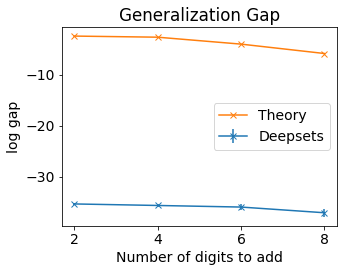

In [ ]:
gaps = torch.DoubleTensor(total_gap).log()
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))
# plt.plot(lengths, gaps.mean(0), 'x-', label='Deepsets') 
# plt.fill_between(lengths, gaps.mean(0) - gaps.std(0), gaps.mean(0) + gaps.std(0), alpha=0.2)
plt.errorbar(lengths, gaps.mean(0), fmt='x-', yerr=gaps.std(0), label='Deepsets' )
plt.plot(lengths, [math.log(theory_bound(l, train_sample_size, 0)) for l in lengths], 'x-', label='Theory')
plt.xlabel('Number of digits to add')
plt.ylabel('log gap')
plt.title('Generalization Gap')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
gaps

tensor([[-35.5265, -36.2224, -35.3711, -37.5393],
        [-35.1479, -35.2013, -36.8226, -36.2696],
        [-35.2750, -35.7173, -35.7137, -37.4988],
        [-35.3307, -35.4841, -36.0771, -36.1642],
        [-35.3989, -35.5540, -35.7504, -37.8544]])

In [ ]:
gaps=torch.tensor([[-35.5265, -36.2224, -35.3711, -37.5393],
        [-35.1479, -35.2013, -36.8226, -36.2696],
        [-35.2750, -35.7173, -35.7137, -37.4988],
        [-35.3307, -35.4841, -36.0771, -36.1642],
        [-35.3989, -35.5540, -35.7504, -37.8544]])
gaps.mean(0), gaps.std(0)


(tensor([-35.3358, -35.6358, -35.9470, -37.0653]),
 tensor([0.1409, 0.3772, 0.5496, 0.7875]))